### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

from textwrap import wrap

import seaborn as sns

### Loading the data

In [4]:
official_names = ['Benzyl_benzoate', 'm Anisaldehyde']

In [5]:
mix = np.loadtxt(os.getcwd()+'/1H_manisaldehyde_benzylbenzoate_DMSO.csv', skiprows=0, usecols=range(2), 
                      delimiter='\t',dtype=float)
ppm = mix[:,0]
mix = mix[:,1]

comp = np.loadtxt(os.getcwd()+'/library.csv', skiprows=1, usecols=[0, 2, 4],
                      delimiter='\t',dtype=float)
ppm_components = comp[:,0]
components = comp[:,1:]

In [6]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [7]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [8]:
mix = Spectrum(confs=list(zip(ppm,mix)))

<IPython.core.display.Javascript object>


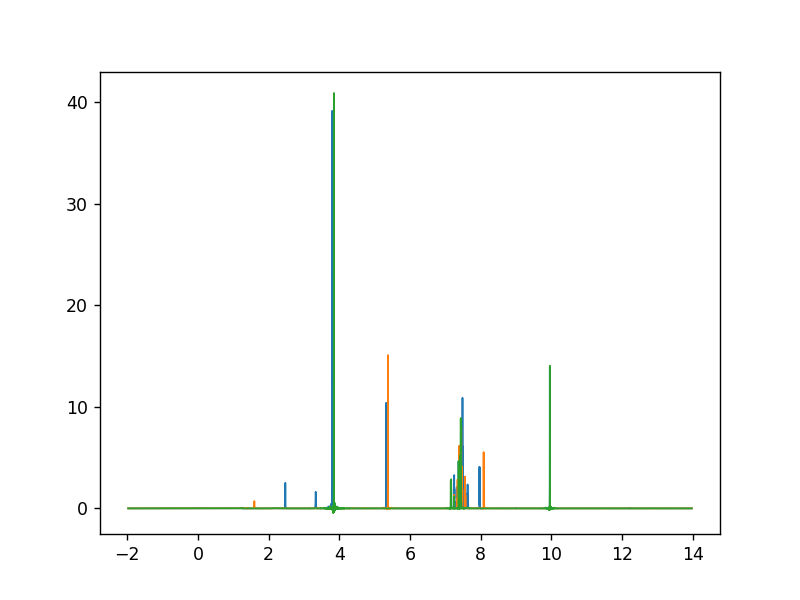

In [9]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)

### Ground truth

In [10]:
protons = [8, 12]
molar_proportions = [0.3702, 0.6298]
molar_proportions

[0.3702, 0.6298]

In [11]:
real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]

In [12]:
real_visible_proportions

[0.2815423226100844, 0.7184576773899155]

### Preprocessing

In [13]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [14]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [15]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [16]:
spectra_and_mixture = spectra + [mix]

In [17]:
spectra_and_mixture = shift(spectra_and_mixture)

In [18]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [19]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [20]:
cma = common_mass_axis(spectra_and_mixture)

In [21]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [22]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [23]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [24]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [25]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [26]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [27]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


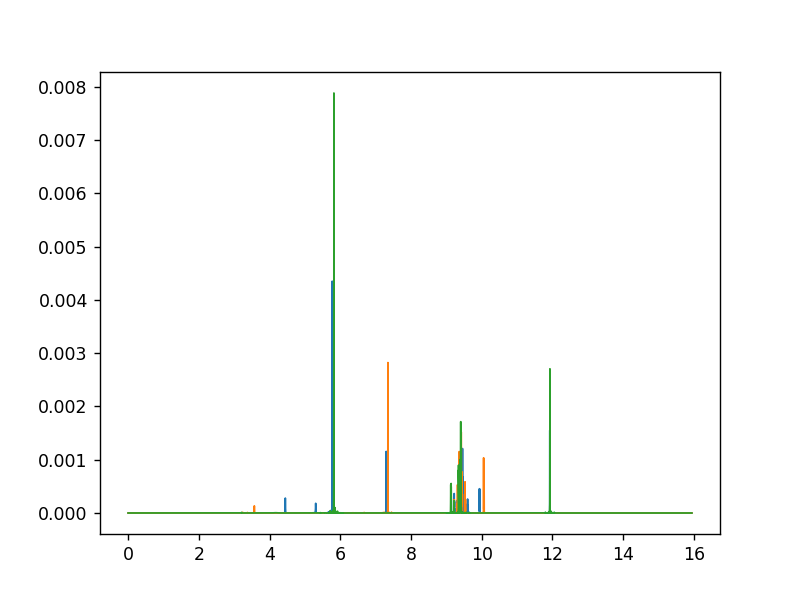

In [28]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 

### Removing unnecessary data points

In [29]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.Spectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [30]:
#3.5, 12
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 3.5, 12)

In [31]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [32]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [33]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [34]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [35]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [36]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


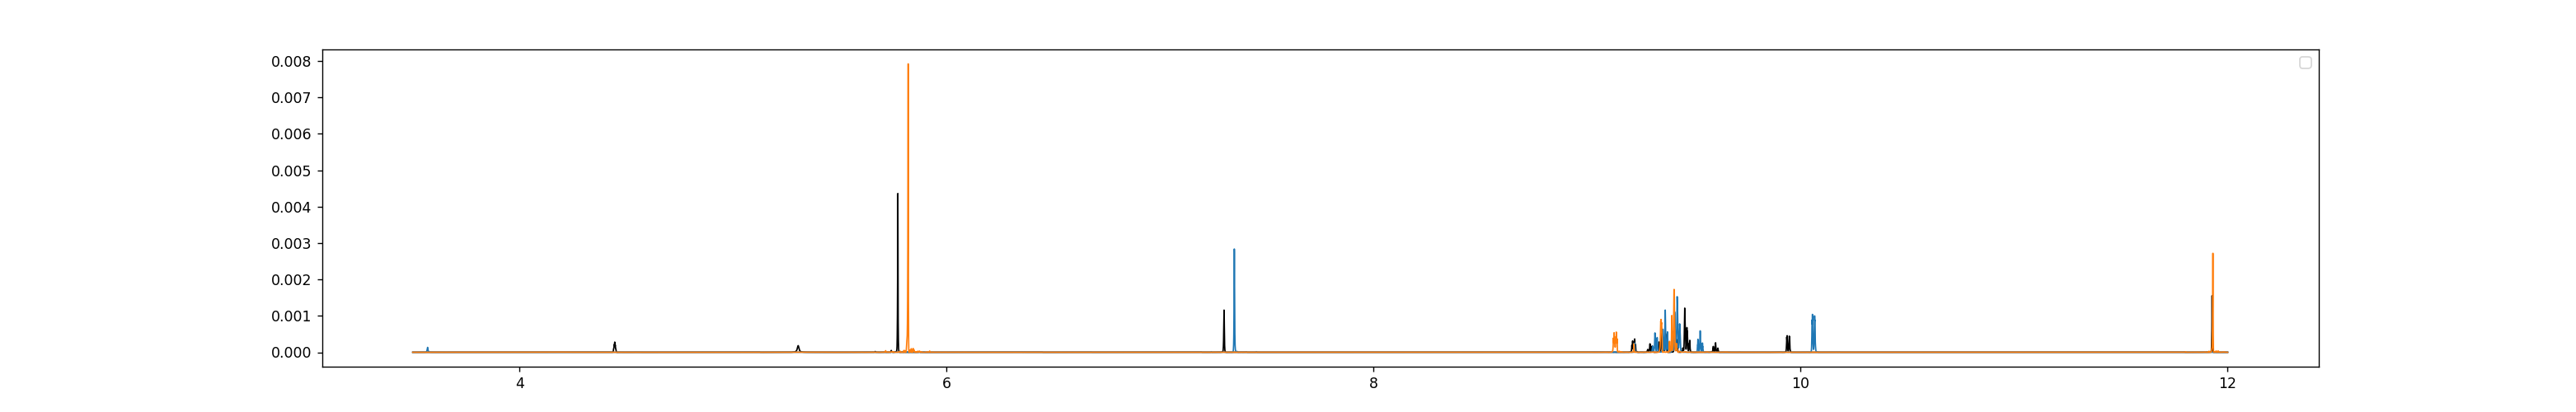

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 4, forward=True)
mix.plot(profile=True, color='black')
comp0.plot(profile=True)
comp1.plot(profile=True) 
ax.legend()

### Finding best kappa

In [38]:
import time
import pandas as pd
import pulp

In [39]:
lower_limit = 0.01
upper_limit = 0.5
step = 0.01

In [40]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3418420.09it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.95s/it]


Estimation for 0.01 and 0.01 done
It took: 259.1120204925537 seconds.
[0.26161890715899927, 0.2613460118679993]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316160.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:53<00:00, 473.20s/it]


Estimation for 0.01 and 0.02 done
It took: 473.3649871349335 seconds.
[0.04767412502099987, 0.009842105601999974]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25191.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1336695.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.82s/it]


Estimation for 0.01 and 0.03 done
It took: 261.13035130500793 seconds.
[0.00367388763799999, 0.0031352609939999916]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2784624.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.27s/it]


Estimation for 0.01 and 0.04 done
It took: 249.45898699760437 seconds.
[0.0027268236979999926, 0.003137719433999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2918983.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.90s/it]


Estimation for 0.01 and 0.05 done
It took: 258.09584856033325 seconds.
[0.0027099115309999924, 0.003137767325999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2994748.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:24<00:00, 264.87s/it]


Estimation for 0.01 and 0.060000000000000005 done
It took: 265.0496983528137 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3121885.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.96s/it]


Estimation for 0.01 and 0.06999999999999999 done
It took: 243.13719058036804 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29746.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1971603.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:23<00:00, 263.30s/it]


Estimation for 0.01 and 0.08 done
It took: 263.53656458854675 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2928415.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:13<00:00, 253.58s/it]


Estimation for 0.01 and 0.09 done
It took: 253.75893306732178 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3299879.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.84s/it]


Estimation for 0.01 and 0.09999999999999999 done
It took: 256.0072133541107 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3057785.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.17s/it]


Estimation for 0.01 and 0.11 done
It took: 266.3451397418976 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3244197.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.80s/it]


Estimation for 0.01 and 0.12 done
It took: 259.9690275192261 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3197122.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.84s/it]


Estimation for 0.01 and 0.13 done
It took: 260.015793800354 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27869.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2575201.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.58s/it]


Estimation for 0.01 and 0.14 done
It took: 236.80249547958374 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2055577.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.32s/it]


Estimation for 0.01 and 0.15000000000000002 done
It took: 251.54603552818298 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30615.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2598877.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:14<00:00, 254.48s/it]


Estimation for 0.01 and 0.16 done
It took: 254.69517970085144 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2862758.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.26s/it]


Estimation for 0.01 and 0.17 done
It took: 235.46214079856873 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32513.98it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1633495.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.20s/it]


Estimation for 0.01 and 0.18000000000000002 done
It took: 214.52384305000305 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269417.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.26s/it]


Estimation for 0.01 and 0.19 done
It took: 193.42360758781433 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3254640.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.10s/it]


Estimation for 0.01 and 0.2 done
It took: 184.25811624526978 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274665.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.67s/it]


Estimation for 0.01 and 0.21000000000000002 done
It took: 176.83324599266052 seconds.
[0.0027025868019999928, 0.002644752927999993]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3285895.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.98s/it]


Estimation for 0.01 and 0.22 done
It took: 198.14890432357788 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33420.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2296508.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.61s/it]


Estimation for 0.01 and 0.23 done
It took: 197.85004997253418 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35696.20it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312670.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.50s/it]


Estimation for 0.01 and 0.24000000000000002 done
It took: 191.65402221679688 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3281641.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.81s/it]


Estimation for 0.01 and 0.25 done
It took: 190.9652805328369 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327583.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.03s/it]


Estimation for 0.01 and 0.26 done
It took: 190.1901731491089 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3155965.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.26s/it]


Estimation for 0.01 and 0.27 done
It took: 196.428466796875 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3291604.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.58s/it]


Estimation for 0.01 and 0.28 done
It took: 189.74860525131226 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2499075.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.18s/it]


Estimation for 0.01 and 0.29000000000000004 done
It took: 201.38790583610535 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289126.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.80s/it]


Estimation for 0.01 and 0.3 done
It took: 198.95616459846497 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3257066.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.05s/it]


Estimation for 0.01 and 0.31 done
It took: 189.21599221229553 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2830412.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.94s/it]


Estimation for 0.01 and 0.32 done
It took: 187.1277618408203 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348040.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.69s/it]


Estimation for 0.01 and 0.33 done
It took: 191.84641861915588 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315785.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.21s/it]


Estimation for 0.01 and 0.34 done
It took: 195.36711144447327 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294568.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.88s/it]


Estimation for 0.01 and 0.35000000000000003 done
It took: 173.05262899398804 seconds.
[0.0027025868019999928, 0.002644752927999993]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3193234.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.54s/it]


Estimation for 0.01 and 0.36000000000000004 done
It took: 190.7051990032196 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337124.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.77s/it]


Estimation for 0.01 and 0.37 done
It took: 192.93022108078003 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3107352.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.28s/it]


Estimation for 0.01 and 0.38 done
It took: 201.4497148990631 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3114577.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.74s/it]


Estimation for 0.01 and 0.39 done
It took: 194.9169623851776 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2591044.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.09s/it]


Estimation for 0.01 and 0.4 done
It took: 188.28842115402222 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3330100.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.14s/it]


Estimation for 0.01 and 0.41000000000000003 done
It took: 195.29614281654358 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39756.44it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3094475.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.49s/it]


Estimation for 0.01 and 0.42000000000000004 done
It took: 194.6541645526886 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268869.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.68s/it]


Estimation for 0.01 and 0.43 done
It took: 197.83883905410767 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341581.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.47s/it]


Estimation for 0.01 and 0.44 done
It took: 185.62851786613464 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22610.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1811170.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.52s/it]


Estimation for 0.01 and 0.45 done
It took: 189.74714493751526 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3252759.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.76s/it]


Estimation for 0.01 and 0.46 done
It took: 190.9190707206726 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3282469.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.91s/it]


Estimation for 0.01 and 0.47000000000000003 done
It took: 194.07264947891235 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3227954.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.75s/it]


Estimation for 0.01 and 0.48000000000000004 done
It took: 197.91352152824402 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3196965.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.01s/it]


Estimation for 0.01 and 0.49 done
It took: 199.17365908622742 seconds.
[0.002703560555999993, 0.003137787843999992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3310684.67it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [22:39<00:00, 1359.57s/it]


Estimation for 0.02 and 0.01 done
It took: 1359.7350692749023 seconds.
[0.5083647938949987, 0.48976233721299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3378959.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:53<00:00, 293.98s/it]


Estimation for 0.02 and 0.02 done
It took: 294.1334857940674 seconds.
[0.2857922788569992, 0.26321399744899926]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3244197.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:23<00:00, 323.59s/it]


Estimation for 0.02 and 0.03 done
It took: 323.7509322166443 seconds.
[0.1855458833179995, 0.09116382726699974]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3242490.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:07<00:00, 667.50s/it]


Estimation for 0.02 and 0.04 done
It took: 667.6634392738342 seconds.
[0.16186187201799956, 0.011855127472999969]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341600.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:48<00:00, 348.02s/it]


Estimation for 0.02 and 0.05 done
It took: 348.1786012649536 seconds.
[0.02014714445499995, 0.008854115252999976]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278333.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:28<00:00, 328.29s/it]


Estimation for 0.02 and 0.060000000000000005 done
It took: 328.4485182762146 seconds.
[0.010090259205999975, 0.008879334619999976]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3251512.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:26<00:00, 326.01s/it]


Estimation for 0.02 and 0.06999999999999999 done
It took: 326.1693069934845 seconds.
[0.006146345230999983, 0.008832568639999976]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312726.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:20<00:00, 320.21s/it]


Estimation for 0.02 and 0.08 done
It took: 320.3678572177887 seconds.
[0.004271752150999989, 0.008733888210999977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2918721.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:21<00:00, 321.98s/it]


Estimation for 0.02 and 0.09 done
It took: 322.1697750091553 seconds.
[0.004268317583999989, 0.008636138319999978]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2858969.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:46<00:00, 286.29s/it]


Estimation for 0.02 and 0.09999999999999999 done
It took: 286.47845244407654 seconds.
[0.004265989773999989, 0.008533107601999977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36157.79it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2817268.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:45<00:00, 285.48s/it]


Estimation for 0.02 and 0.11 done
It took: 285.66925072669983 seconds.
[0.004266017181999988, 0.008478149274999977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3264185.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:44<00:00, 284.69s/it]


Estimation for 0.02 and 0.12 done
It took: 284.8513677120209 seconds.
[0.004266045826999989, 0.008417197589999977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3144286.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:47<00:00, 287.54s/it]


Estimation for 0.02 and 0.13 done
It took: 287.7039773464203 seconds.
[0.004266076030999989, 0.008369619121999978]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325881.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:53<00:00, 293.60s/it]


Estimation for 0.02 and 0.14 done
It took: 293.7596356868744 seconds.
[0.004266121015999989, 0.008291993420999977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3306813.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:57<00:00, 297.87s/it]


Estimation for 0.02 and 0.15000000000000002 done
It took: 298.0353055000305 seconds.
[0.004266166000999988, 0.008212660950999977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2846680.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:45<00:00, 285.79s/it]


Estimation for 0.02 and 0.16 done
It took: 285.9838149547577 seconds.
[0.004266219505999988, 0.008105646395999979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32896.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2849978.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:51<00:00, 291.49s/it]


Estimation for 0.02 and 0.17 done
It took: 291.6922574043274 seconds.
[0.004266258897999989, 0.008060826191999979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3334596.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:43<00:00, 283.71s/it]


Estimation for 0.02 and 0.18000000000000002 done
It took: 283.86746883392334 seconds.
[0.004266310465999988, 0.007968867185999979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3201826.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:46<00:00, 286.26s/it]


Estimation for 0.02 and 0.19 done
It took: 286.42923164367676 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3352258.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:50<00:00, 290.46s/it]


Estimation for 0.02 and 0.2 done
It took: 290.63065791130066 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2226860.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:03<00:00, 303.10s/it]


Estimation for 0.02 and 0.21000000000000002 done
It took: 303.3364140987396 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3188833.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:52<00:00, 292.19s/it]


Estimation for 0.02 and 0.22 done
It took: 292.35730814933777 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3377672.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:49<00:00, 289.96s/it]


Estimation for 0.02 and 0.23 done
It took: 290.1200306415558 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2861890.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:48<00:00, 288.88s/it]


Estimation for 0.02 and 0.24000000000000002 done
It took: 289.0609133243561 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29433.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1828909.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:55<00:00, 295.05s/it]


Estimation for 0.02 and 0.25 done
It took: 295.28679180145264 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12652.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3039812.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:59<00:00, 299.51s/it]


Estimation for 0.02 and 0.26 done
It took: 299.6820819377899 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340227.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:49<00:00, 289.89s/it]


Estimation for 0.02 and 0.27 done
It took: 290.05364894866943 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3246932.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:53<00:00, 293.21s/it]


Estimation for 0.02 and 0.28 done
It took: 293.36876344680786 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3310815.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:51<00:00, 291.97s/it]


Estimation for 0.02 and 0.29000000000000004 done
It took: 292.13787388801575 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2928474.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:50<00:00, 290.77s/it]


Estimation for 0.02 and 0.3 done
It took: 290.9502592086792 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2986955.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:54<00:00, 294.70s/it]


Estimation for 0.02 and 0.31 done
It took: 294.8752784729004 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3076150.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:51<00:00, 291.37s/it]


Estimation for 0.02 and 0.32 done
It took: 291.54016947746277 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3139312.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:52<00:00, 292.55s/it]


Estimation for 0.02 and 0.33 done
It took: 292.7188494205475 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266498.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.04s/it]


Estimation for 0.02 and 0.34 done
It took: 237.20452737808228 seconds.
[0.004265957279999988, 0.007918577682999979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2931906.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:56<00:00, 296.61s/it]


Estimation for 0.02 and 0.35000000000000003 done
It took: 296.7966511249542 seconds.
[0.004266277012999989, 0.00792052343199998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2881938.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.39s/it]


Estimation for 0.02 and 0.36000000000000004 done
It took: 247.56866145133972 seconds.
[0.004265957279999988, 0.007918577682999979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287667.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:54<00:00, 294.79s/it]


Estimation for 0.02 and 0.37 done
It took: 294.94996976852417 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309075.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.87s/it]


Estimation for 0.02 and 0.38 done
It took: 280.02617049217224 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335109.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:44<00:00, 284.57s/it]


Estimation for 0.02 and 0.39 done
It took: 284.7286560535431 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3226994.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:45<00:00, 285.72s/it]


Estimation for 0.02 and 0.4 done
It took: 285.88511300086975 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3255237.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:53<00:00, 293.79s/it]


Estimation for 0.02 and 0.41000000000000003 done
It took: 293.94620847702026 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3171162.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:38<00:00, 278.01s/it]


Estimation for 0.02 and 0.42000000000000004 done
It took: 278.1808669567108 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3141148.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.79s/it]


Estimation for 0.02 and 0.43 done
It took: 279.9520831108093 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315146.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:46<00:00, 286.37s/it]


Estimation for 0.02 and 0.44 done
It took: 286.53179240226746 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3157394.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:48<00:00, 288.70s/it]


Estimation for 0.02 and 0.45 done
It took: 288.8685736656189 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278241.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:45<00:00, 285.69s/it]


Estimation for 0.02 and 0.46 done
It took: 285.85098457336426 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3257791.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.55s/it]


Estimation for 0.02 and 0.47000000000000003 done
It took: 279.7107753753662 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3333665.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:50<00:00, 290.68s/it]


Estimation for 0.02 and 0.48000000000000004 done
It took: 290.8461961746216 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2920920.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:05<00:00, 305.67s/it]


Estimation for 0.02 and 0.49 done
It took: 305.8480587005615 seconds.
[0.004266342466999988, 0.00792052318599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3295533.00it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [16:45<00:00, 1005.41s/it]


Estimation for 0.03 and 0.01 done
It took: 1005.5889291763306 seconds.
[0.5157472238209987, 0.48385388193199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3201056.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.77s/it]


Estimation for 0.03 and 0.02 done
It took: 217.93824315071106 seconds.
[0.382719262378999, 0.5445682335619986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237218.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.25s/it]


Estimation for 0.03 and 0.03 done
It took: 275.43562030792236 seconds.
[0.28642631669799923, 0.27296677474999925]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3089625.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:31<00:00, 271.54s/it]


Estimation for 0.03 and 0.04 done
It took: 271.7110278606415 seconds.
[0.2896695949549992, 0.10319106158799972]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3271938.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.21s/it]


Estimation for 0.03 and 0.05 done
It took: 241.38811564445496 seconds.
[0.23604138370199937, 0.10077295605599973]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284992.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.72s/it]


Estimation for 0.03 and 0.060000000000000005 done
It took: 216.89261484146118 seconds.
[0.2147298680839994, 0.08729054345799976]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24385.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2257595.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.81s/it]


Estimation for 0.03 and 0.06999999999999999 done
It took: 209.0766007900238 seconds.
[0.19736351562599946, 0.08561708145899978]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3084741.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.34s/it]


Estimation for 0.03 and 0.08 done
It took: 257.52366948127747 seconds.
[0.17429107767499952, 0.09880392456699974]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261493.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.94s/it]


Estimation for 0.03 and 0.09 done
It took: 200.1040759086609 seconds.
[0.11757357891599968, 0.10166331800099972]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3279122.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:18<00:00, 558.89s/it]


Estimation for 0.03 and 0.09999999999999999 done
It took: 559.0579564571381 seconds.
[0.02963637237699992, 0.1152224351729997]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29537.35it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1615888.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:36<00:00, 276.49s/it]


Estimation for 0.03 and 0.11 done
It took: 276.72074365615845 seconds.
[0.013584291238999964, 0.1154074510289997]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268595.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.96s/it]


Estimation for 0.03 and 0.12 done
It took: 229.1234471797943 seconds.
[0.009999816408999974, 0.11149534954099971]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3185068.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:03<00:00, 363.47s/it]


Estimation for 0.03 and 0.13 done
It took: 363.64832878112793 seconds.
[0.009565026838999974, 0.10502345568099972]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2913709.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.34s/it]


Estimation for 0.03 and 0.14 done
It took: 238.52141213417053 seconds.
[0.009182778570999976, 0.10139271554499973]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3165538.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.59s/it]


Estimation for 0.03 and 0.15000000000000002 done
It took: 252.74976325035095 seconds.
[0.009119857319999976, 0.09787118672099973]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302709.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.10s/it]


Estimation for 0.03 and 0.16 done
It took: 181.25782775878906 seconds.
[0.009093924931999975, 0.09410501087799975]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268997.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:01<00:00, 301.58s/it]


Estimation for 0.03 and 0.17 done
It took: 301.7417023181915 seconds.
[0.009053365434999976, 0.09018382116299976]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3036406.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.78s/it]


Estimation for 0.03 and 0.18000000000000002 done
It took: 182.95175409317017 seconds.
[0.008928806468999975, 0.08773378832199977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3123817.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.33s/it]


Estimation for 0.03 and 0.19 done
It took: 175.5070402622223 seconds.
[0.008968390911999975, 0.08466276959299977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283168.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.89s/it]


Estimation for 0.03 and 0.2 done
It took: 210.05530214309692 seconds.
[0.009004266985999976, 0.08112380759699978]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33825.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2161496.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.37s/it]


Estimation for 0.03 and 0.21000000000000002 done
It took: 186.58350896835327 seconds.
[0.009020896449999975, 0.07987506050999979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3249527.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:37<00:00, 457.39s/it]


Estimation for 0.03 and 0.22 done
It took: 457.56267046928406 seconds.
[0.009031503343999976, 0.07921969561899979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3238472.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:14<00:00, 374.01s/it]


Estimation for 0.03 and 0.23 done
It took: 374.1748342514038 seconds.
[0.009092846744999977, 0.0763440863789998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39383.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3112110.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:38<00:00, 338.96s/it]


Estimation for 0.03 and 0.24000000000000002 done
It took: 339.12640166282654 seconds.
[0.009130723270999976, 0.0739870801529998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261294.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:37<00:00, 277.87s/it]


Estimation for 0.03 and 0.25 done
It took: 278.0307879447937 seconds.
[0.009190301951999975, 0.0709962528769998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3381496.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:10<00:00, 310.63s/it]


Estimation for 0.03 and 0.26 done
It took: 310.803364276886 seconds.
[0.009216352354999976, 0.06980516205199983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2985371.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:36<00:00, 396.16s/it]


Estimation for 0.03 and 0.27 done
It took: 396.33169412612915 seconds.
[0.009239376998999975, 0.06759151255899983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219080.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:37<00:00, 457.54s/it]


Estimation for 0.03 and 0.28 done
It took: 457.69976830482483 seconds.
[0.009277959047999976, 0.06593016598599982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3147092.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:17<00:00, 437.72s/it]


Estimation for 0.03 and 0.29000000000000004 done
It took: 437.8828501701355 seconds.
[0.009304554812999976, 0.06293398361499983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2951625.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:53<00:00, 413.27s/it]


Estimation for 0.03 and 0.3 done
It took: 413.4478394985199 seconds.
[0.009306214101999976, 0.06253155079899983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2718232.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.66s/it]


Estimation for 0.03 and 0.31 done
It took: 250.8520884513855 seconds.
[0.009323408795999976, 0.06107326810299984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3205683.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:52<00:00, 592.55s/it]


Estimation for 0.03 and 0.32 done
It took: 592.7158150672913 seconds.
[0.009354878814999976, 0.05979168539899984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302411.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:33<00:00, 453.87s/it]


Estimation for 0.03 and 0.33 done
It took: 454.0548949241638 seconds.
[0.009351294434999975, 0.05932645478099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3065968.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:59<00:00, 599.86s/it]


Estimation for 0.03 and 0.34 done
It took: 600.0335648059845 seconds.
[0.009363412350999975, 0.05895308598799984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3060359.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:33<00:00, 513.50s/it]


Estimation for 0.03 and 0.35000000000000003 done
It took: 513.6796703338623 seconds.
[0.009363414644999976, 0.05895310042999984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219876.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.46s/it]


Estimation for 0.03 and 0.36000000000000004 done
It took: 234.62249445915222 seconds.
[0.009357087508999976, 0.05895310104099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3034691.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.10s/it]


Estimation for 0.03 and 0.37 done
It took: 251.2749605178833 seconds.
[0.009357087508999976, 0.05895310104099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2944203.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.47s/it]


Estimation for 0.03 and 0.38 done
It took: 238.6502342224121 seconds.
[0.009357087508999976, 0.05895310104099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3073453.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.86s/it]


Estimation for 0.03 and 0.39 done
It took: 203.0291805267334 seconds.
[0.009357087508999976, 0.05895310104099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3106050.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.95s/it]


Estimation for 0.03 and 0.4 done
It took: 183.12776446342468 seconds.
[0.009357087508999976, 0.05895310104099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2794100.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.57s/it]


Estimation for 0.03 and 0.41000000000000003 done
It took: 237.7749421596527 seconds.
[0.009357087508999976, 0.05895310104099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3184271.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:28<00:00, 508.05s/it]


Estimation for 0.03 and 0.42000000000000004 done
It took: 508.2136981487274 seconds.
[0.009363414644999976, 0.05895310042999984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3193774.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.11s/it]


Estimation for 0.03 and 0.43 done
It took: 151.29469895362854 seconds.
[0.009357087508999976, 0.05895310104099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3218266.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:35<00:00, 335.97s/it]


Estimation for 0.03 and 0.44 done
It took: 336.12742924690247 seconds.
[0.009357087508999976, 0.05895310104099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272139.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.13s/it]


Estimation for 0.03 and 0.45 done
It took: 171.28654599189758 seconds.
[0.009357087508999976, 0.05895310104099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289422.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.58s/it]


Estimation for 0.03 and 0.46 done
It took: 235.7394027709961 seconds.
[0.009357087508999976, 0.05895310104099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269526.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.93s/it]


Estimation for 0.03 and 0.47000000000000003 done
It took: 167.09586715698242 seconds.
[0.009357087508999976, 0.05895310104099984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263566.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:07<00:00, 427.02s/it]


Estimation for 0.03 and 0.48000000000000004 done
It took: 427.17767786979675 seconds.
[0.009363414644999976, 0.05895310042999984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3319093.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:54<00:00, 414.34s/it]


Estimation for 0.03 and 0.49 done
It took: 414.50114011764526 seconds.
[0.009363414644999976, 0.05895310042999984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294179.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:05<00:00, 785.84s/it]


Estimation for 0.04 and 0.01 done
It took: 786.0002267360687 seconds.
[0.5125067678179986, 0.48710785198499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3397431.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:42<00:00, 582.49s/it]


Estimation for 0.04 and 0.02 done
It took: 582.6496560573578 seconds.
[0.21135542480799943, 0.7847187134799979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3403831.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.87s/it]


Estimation for 0.04 and 0.03 done
It took: 199.0296950340271 seconds.
[0.43644730322899883, 0.28056989681599925]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262057.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.28s/it]


Estimation for 0.04 and 0.04 done
It took: 224.4367413520813 seconds.
[0.3474303147929991, 0.29698445396199924]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3267209.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.09s/it]


Estimation for 0.04 and 0.05 done
It took: 227.2471776008606 seconds.
[0.27521681677299925, 0.3424598094219991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3255852.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.34s/it]


Estimation for 0.04 and 0.060000000000000005 done
It took: 221.4976065158844 seconds.
[0.2659331437709993, 0.32870035882599913]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301629.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.98s/it]


Estimation for 0.04 and 0.06999999999999999 done
It took: 236.1576726436615 seconds.
[0.25246935478599936, 0.3018909808499992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3401813.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:50<00:00, 410.98s/it]


Estimation for 0.04 and 0.08 done
It took: 411.15366411209106 seconds.
[0.20306504211299947, 0.2865856924249992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3280795.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.97s/it]


Estimation for 0.04 and 0.09 done
It took: 231.12989568710327 seconds.
[0.16420115434299956, 0.3090254838319992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323370.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.83s/it]


Estimation for 0.04 and 0.09999999999999999 done
It took: 235.98544311523438 seconds.
[0.12586357060999967, 0.34184113448799913]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290938.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:43<00:00, 284.00s/it]


Estimation for 0.04 and 0.11 done
It took: 284.1562213897705 seconds.
[0.09167239926899975, 0.35976988029399903]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3345649.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.43s/it]


Estimation for 0.04 and 0.12 done
It took: 182.58941078186035 seconds.
[0.07694642875199979, 0.365598491183999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3226087.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.13s/it]


Estimation for 0.04 and 0.13 done
It took: 185.312495470047 seconds.
[0.0764806632219998, 0.3603307679749991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3281990.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.19s/it]


Estimation for 0.04 and 0.14 done
It took: 194.36745715141296 seconds.
[0.07592874383299979, 0.35578618899399905]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2989167.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.84s/it]


Estimation for 0.04 and 0.15000000000000002 done
It took: 204.0116035938263 seconds.
[0.07614064912699979, 0.35099514361999906]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2842561.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.68s/it]


Estimation for 0.04 and 0.16 done
It took: 206.86185336112976 seconds.
[0.07730572370799979, 0.34379856122899904]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3007394.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.31s/it]


Estimation for 0.04 and 0.17 done
It took: 203.48904061317444 seconds.
[0.0780681232019998, 0.3397509252399991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3096685.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.39s/it]


Estimation for 0.04 and 0.18000000000000002 done
It took: 206.5591881275177 seconds.
[0.07860721875899979, 0.33583109206399914]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2827009.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.38s/it]


Estimation for 0.04 and 0.19 done
It took: 214.55951619148254 seconds.
[0.08019730650299979, 0.33083481554599914]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34379.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2772623.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.03s/it]


Estimation for 0.04 and 0.2 done
It took: 196.21844029426575 seconds.
[0.0803706915039998, 0.3281131554319991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2984321.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.60s/it]


Estimation for 0.04 and 0.21000000000000002 done
It took: 187.77534198760986 seconds.
[0.08104482449699978, 0.3247918701269991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3127405.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.23s/it]


Estimation for 0.04 and 0.22 done
It took: 188.42568516731262 seconds.
[0.08087370147899978, 0.32330531070699914]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2835580.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.90s/it]


Estimation for 0.04 and 0.23 done
It took: 197.1048662662506 seconds.
[0.0804511394159998, 0.32179232080999914]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3117994.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.42s/it]


Estimation for 0.04 and 0.24000000000000002 done
It took: 203.59920382499695 seconds.
[0.0799931420249998, 0.32077339571599917]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3128207.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.92s/it]


Estimation for 0.04 and 0.25 done
It took: 199.10899901390076 seconds.
[0.0786520251929998, 0.3209498597719992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3053224.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.93s/it]


Estimation for 0.04 and 0.26 done
It took: 204.118488073349 seconds.
[0.0771004331319998, 0.3212057340099992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3126553.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.07s/it]


Estimation for 0.04 and 0.27 done
It took: 181.24511885643005 seconds.
[0.07605841438599979, 0.32166467341199917]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2924714.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.12s/it]


Estimation for 0.04 and 0.28 done
It took: 184.30111408233643 seconds.
[0.0738577077879998, 0.3232679478039991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3192972.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.66s/it]


Estimation for 0.04 and 0.29000000000000004 done
It took: 187.83438777923584 seconds.
[0.07166105142599981, 0.3249083897769991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2959713.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.08s/it]


Estimation for 0.04 and 0.3 done
It took: 196.26960635185242 seconds.
[0.06955961072499982, 0.3265290250719991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2938410.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.26s/it]


Estimation for 0.04 and 0.31 done
It took: 198.43770933151245 seconds.
[0.06727978793499982, 0.3289015249019991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3018403.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.16s/it]


Estimation for 0.04 and 0.32 done
It took: 184.3413393497467 seconds.
[0.06458434473699984, 0.33149173647999913]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3155471.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.61s/it]


Estimation for 0.04 and 0.33 done
It took: 242.77730512619019 seconds.
[0.061425224956999834, 0.33482541405099914]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35246.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2756695.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.55s/it]


Estimation for 0.04 and 0.34 done
It took: 216.74038124084473 seconds.
[0.05884152877099984, 0.3371836028269991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11023.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2568659.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.44s/it]


Estimation for 0.04 and 0.35000000000000003 done
It took: 181.62545776367188 seconds.
[0.05564948184899986, 0.3403839299679991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2981570.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.18s/it]


Estimation for 0.04 and 0.36000000000000004 done
It took: 236.3638412952423 seconds.
[0.05257508875899986, 0.3440303525249991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2998398.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.71s/it]


Estimation for 0.04 and 0.37 done
It took: 220.8930642604828 seconds.
[0.05017951784099987, 0.34591796208899905]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3106709.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.57s/it]


Estimation for 0.04 and 0.38 done
It took: 184.75721549987793 seconds.
[0.046853941139999876, 0.35033308717499906]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3127004.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.08s/it]


Estimation for 0.04 and 0.39 done
It took: 192.2610354423523 seconds.
[0.04438526757799988, 0.3529788131269991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2995376.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.80s/it]


Estimation for 0.04 and 0.4 done
It took: 210.99030661582947 seconds.
[0.04120131881299989, 0.35654846648199906]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2874213.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.81s/it]


Estimation for 0.04 and 0.41000000000000003 done
It took: 236.9947075843811 seconds.
[0.038675994318999894, 0.35912653351399904]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 8144.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2638538.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.43s/it]


Estimation for 0.04 and 0.42000000000000004 done
It took: 189.63664960861206 seconds.
[0.0363676615449999, 0.36141792046699905]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3115671.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.94s/it]


Estimation for 0.04 and 0.43 done
It took: 231.12586855888367 seconds.
[0.03416354787999991, 0.3634581125359991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3185397.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.04s/it]


Estimation for 0.04 and 0.44 done
It took: 233.21805715560913 seconds.
[0.03175417132599992, 0.365767310717999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3065712.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 204.00s/it]


Estimation for 0.04 and 0.45 done
It took: 204.18961024284363 seconds.
[0.02948249491299992, 0.367988147567999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32768.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3085554.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.03s/it]


Estimation for 0.04 and 0.46 done
It took: 168.22259259223938 seconds.
[0.027055615251999926, 0.370434041153999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3127822.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.07s/it]


Estimation for 0.04 and 0.47000000000000003 done
It took: 169.2430944442749 seconds.
[0.025309516314999933, 0.371975725316999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3148022.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.74s/it]


Estimation for 0.04 and 0.48000000000000004 done
It took: 172.9032745361328 seconds.
[0.02309725055199994, 0.374139797929999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274445.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.44s/it]


Estimation for 0.04 and 0.49 done
It took: 167.59916400909424 seconds.
[0.021169765687999945, 0.376338891037999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3142008.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:49<00:00, 829.68s/it]


Estimation for 0.05 and 0.01 done
It took: 829.8468999862671 seconds.
[0.5039312762469986, 0.4957182222719987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3193146.95it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [18:24<00:00, 1104.87s/it]


Estimation for 0.05 and 0.02 done
It took: 1105.0534920692444 seconds.
[0.5710168581749985, 0.4279751185919988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342669.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:12<00:00, 312.99s/it]


Estimation for 0.05 and 0.03 done
It took: 313.14650106430054 seconds.
[0.40082611967299897, 0.5706521926489985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3273676.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.65s/it]


Estimation for 0.05 and 0.04 done
It took: 275.8052363395691 seconds.
[0.4178325282869989, 0.377057770186999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3184046.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.04s/it]


Estimation for 0.05 and 0.05 done
It took: 210.219473361969 seconds.
[0.35083280618499907, 0.4214652482209989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3276645.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.58s/it]


Estimation for 0.05 and 0.060000000000000005 done
It took: 247.74757623672485 seconds.
[0.29739742400499924, 0.4392146442889988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284789.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.70s/it]


Estimation for 0.05 and 0.06999999999999999 done
It took: 251.87582230567932 seconds.
[0.2768085852369993, 0.44418490603699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305282.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.20s/it]


Estimation for 0.05 and 0.08 done
It took: 242.35421323776245 seconds.
[0.2675725272059993, 0.4483646962259988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3251639.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:47<00:00, 287.86s/it]


Estimation for 0.05 and 0.09 done
It took: 288.02288341522217 seconds.
[0.25155761279199934, 0.45593201075099876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328056.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.83s/it]


Estimation for 0.05 and 0.09999999999999999 done
It took: 234.99214339256287 seconds.
[0.2283849355319994, 0.4677701219519988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3352200.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.13s/it]


Estimation for 0.05 and 0.11 done
It took: 249.28446507453918 seconds.
[0.2219199072499994, 0.46389825586799877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269362.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.31s/it]


Estimation for 0.05 and 0.12 done
It took: 236.47347259521484 seconds.
[0.21768247334799942, 0.4622061907229988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3326316.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.20s/it]


Estimation for 0.05 and 0.13 done
It took: 238.35379457473755 seconds.
[0.21502858810699943, 0.46243407040399875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3281034.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.44s/it]


Estimation for 0.05 and 0.14 done
It took: 246.6108684539795 seconds.
[0.21379204526599943, 0.46229824727699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315653.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.21s/it]


Estimation for 0.05 and 0.15000000000000002 done
It took: 219.36818289756775 seconds.
[0.21228586265099944, 0.46261894715399876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263821.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.64s/it]


Estimation for 0.05 and 0.16 done
It took: 232.81219935417175 seconds.
[0.21092106415499945, 0.4627849560309988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3142834.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.36s/it]


Estimation for 0.05 and 0.17 done
It took: 203.52630186080933 seconds.
[0.20851465387799945, 0.4628742553339988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278608.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.12s/it]


Estimation for 0.05 and 0.18000000000000002 done
It took: 201.2974991798401 seconds.
[0.20731928559899945, 0.4620195504039988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283352.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.00s/it]


Estimation for 0.05 and 0.19 done
It took: 199.1619598865509 seconds.
[0.20509056856799945, 0.4614673782349988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3292604.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.89s/it]


Estimation for 0.05 and 0.2 done
It took: 201.0574004650116 seconds.
[0.20326580966399946, 0.4612295393869988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259060.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.71s/it]


Estimation for 0.05 and 0.21000000000000002 done
It took: 188.87349438667297 seconds.
[0.20071763538099946, 0.46073446995299877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274793.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.75s/it]


Estimation for 0.05 and 0.22 done
It took: 186.90666246414185 seconds.
[0.19936254072699947, 0.4596693240089988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3296312.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.95s/it]


Estimation for 0.05 and 0.23 done
It took: 217.1066255569458 seconds.
[0.19713818171799946, 0.45934796741799877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344177.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.66s/it]


Estimation for 0.05 and 0.24000000000000002 done
It took: 190.83107328414917 seconds.
[0.19401208080899948, 0.45974908454399877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3352392.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.95s/it]


Estimation for 0.05 and 0.25 done
It took: 209.13291358947754 seconds.
[0.1910407739099995, 0.46010794294599877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309318.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.40s/it]


Estimation for 0.05 and 0.26 done
It took: 179.5624499320984 seconds.
[0.1872696660069995, 0.4605541675399988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3225269.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.56s/it]


Estimation for 0.05 and 0.27 done
It took: 191.7230739593506 seconds.
[0.1838909147219995, 0.4609382661049988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312576.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.35s/it]


Estimation for 0.05 and 0.28 done
It took: 176.5054304599762 seconds.
[0.17981703200799953, 0.46143392647199877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27685.17it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3404920.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.48s/it]


Estimation for 0.05 and 0.29000000000000004 done
It took: 174.63918328285217 seconds.
[0.17546362760899953, 0.46193899665799876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3254839.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.20s/it]


Estimation for 0.05 and 0.3 done
It took: 201.35753417015076 seconds.
[0.17208735280299953, 0.4623512383429988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3238149.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.31s/it]


Estimation for 0.05 and 0.31 done
It took: 200.4739007949829 seconds.
[0.16782403530999956, 0.4628221765679988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3225482.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.74s/it]


Estimation for 0.05 and 0.32 done
It took: 183.9243142604828 seconds.
[0.16328176663699956, 0.46329054267699876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313851.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.24s/it]


Estimation for 0.05 and 0.33 done
It took: 177.39828610420227 seconds.
[0.1589095687649996, 0.4636956823739988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288424.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.80s/it]


Estimation for 0.05 and 0.34 done
It took: 180.95991778373718 seconds.
[0.1547112610419996, 0.46404566723599877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261802.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.17s/it]


Estimation for 0.05 and 0.35000000000000003 done
It took: 199.3337278366089 seconds.
[0.1513008329379996, 0.46437561163699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287907.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.75s/it]


Estimation for 0.05 and 0.36000000000000004 done
It took: 178.93485307693481 seconds.
[0.14765749261299962, 0.4647022406339988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3137427.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.66s/it]


Estimation for 0.05 and 0.37 done
It took: 218.83179879188538 seconds.
[0.1432878045709996, 0.4650354888869988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2927376.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.50s/it]


Estimation for 0.05 and 0.38 done
It took: 177.6719992160797 seconds.
[0.13961634844599963, 0.4653908106139988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3169531.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.66s/it]


Estimation for 0.05 and 0.39 done
It took: 178.82794308662415 seconds.
[0.13559026534899965, 0.46574642875099875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3211134.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.03s/it]


Estimation for 0.05 and 0.4 done
It took: 178.19849061965942 seconds.
[0.13188948462799963, 0.46607437264899876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3163725.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.52s/it]


Estimation for 0.05 and 0.41000000000000003 done
It took: 191.68792247772217 seconds.
[0.12781036341599966, 0.4663771540059988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3213196.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.63s/it]


Estimation for 0.05 and 0.42000000000000004 done
It took: 182.81392335891724 seconds.
[0.12198515555599967, 0.4668525840809988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3107336.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.86s/it]


Estimation for 0.05 and 0.43 done
It took: 175.02839636802673 seconds.
[0.1144720180649997, 0.4674762284309988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3167182.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.07s/it]


Estimation for 0.05 and 0.44 done
It took: 169.2406997680664 seconds.
[0.10891520562799971, 0.4679442563809988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3136251.41it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [21:32<00:00, 1292.37s/it]


Estimation for 0.05 and 0.45 done
It took: 1292.536440372467 seconds.
[0.10317920097999972, 0.4684182349769988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261366.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.37s/it]


Estimation for 0.05 and 0.46 done
It took: 183.55927872657776 seconds.
[0.09850135073699974, 0.46880137604399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31895.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3053065.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.07s/it]


Estimation for 0.05 and 0.47000000000000003 done
It took: 175.23786401748657 seconds.
[0.09426820200999975, 0.46915356919499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3169360.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.75s/it]


Estimation for 0.05 and 0.48000000000000004 done
It took: 167.9216411113739 seconds.
[0.08966988551699977, 0.4695453198689987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3012594.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.13s/it]


Estimation for 0.05 and 0.49 done
It took: 177.317631483078 seconds.
[0.08585200504999978, 0.4698734691599987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216621.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:36<00:00, 756.47s/it]


Estimation for 0.060000000000000005 and 0.01 done
It took: 756.6317768096924 seconds.
[0.4868187408319987, 0.5128852331859987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3189719.56it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [18:26<00:00, 1106.93s/it]


Estimation for 0.060000000000000005 and 0.02 done
It took: 1107.1058809757233 seconds.
[0.5656595533399984, 0.4335364298409988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3157990.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.90s/it]


Estimation for 0.060000000000000005 and 0.03 done
It took: 166.07428240776062 seconds.
[0.379837043643999, 0.5966639108179984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247364.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.80s/it]


Estimation for 0.060000000000000005 and 0.04 done
It took: 224.96163630485535 seconds.
[0.5372144158579986, 0.32976526990599914]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3133347.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.04s/it]


Estimation for 0.060000000000000005 and 0.05 done
It took: 247.20109868049622 seconds.
[0.39566973741799893, 0.4228643289729989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3201178.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.52s/it]


Estimation for 0.060000000000000005 and 0.060000000000000005 done
It took: 195.70259547233582 seconds.
[0.375622711107999, 0.44250803538499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3227581.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.43s/it]


Estimation for 0.060000000000000005 and 0.06999999999999999 done
It took: 232.5912766456604 seconds.
[0.372156371759999, 0.44875288729099877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3296108.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.65s/it]


Estimation for 0.060000000000000005 and 0.08 done
It took: 250.82566666603088 seconds.
[0.374788151462999, 0.4535252359139988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266279.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.77s/it]


Estimation for 0.060000000000000005 and 0.09 done
It took: 231.93085289001465 seconds.
[0.370649057806999, 0.4635513877419988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237075.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.03s/it]


Estimation for 0.060000000000000005 and 0.09999999999999999 done
It took: 260.1964478492737 seconds.
[0.35690629356199904, 0.4701306358949987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3239493.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.99s/it]


Estimation for 0.060000000000000005 and 0.11 done
It took: 260.14922165870667 seconds.
[0.3413541450399991, 0.47454587353399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3238132.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.25s/it]


Estimation for 0.060000000000000005 and 0.12 done
It took: 206.42389488220215 seconds.
[0.33311074270499913, 0.48111648311399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3248103.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.92s/it]


Estimation for 0.060000000000000005 and 0.13 done
It took: 204.0987663269043 seconds.
[0.33117982206999913, 0.4772235548859987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3260585.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.88s/it]


Estimation for 0.060000000000000005 and 0.14 done
It took: 198.04478859901428 seconds.
[0.3371800038039991, 0.4615939946429988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3172709.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.16s/it]


Estimation for 0.060000000000000005 and 0.15000000000000002 done
It took: 192.32876420021057 seconds.
[0.3383310888139991, 0.4538351709309988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3162221.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.73s/it]


Estimation for 0.060000000000000005 and 0.16 done
It took: 215.89284753799438 seconds.
[0.33486520317199914, 0.4538298491049988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3267811.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.47s/it]


Estimation for 0.060000000000000005 and 0.17 done
It took: 234.625896692276 seconds.
[0.3321578056369991, 0.45385107123599877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3281015.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.08s/it]


Estimation for 0.060000000000000005 and 0.18000000000000002 done
It took: 247.24193620681763 seconds.
[0.3286250745279991, 0.4541943073319988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40721.40it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311920.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.12s/it]


Estimation for 0.060000000000000005 and 0.19 done
It took: 207.30205464363098 seconds.
[0.3256662401249991, 0.45447343948699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3275673.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.18s/it]


Estimation for 0.060000000000000005 and 0.2 done
It took: 189.3409287929535 seconds.
[0.3224542998829992, 0.4546304404929988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3201073.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.46s/it]


Estimation for 0.060000000000000005 and 0.21000000000000002 done
It took: 191.64717555046082 seconds.
[0.3208749066399992, 0.4538208846839988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3128692.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.03s/it]


Estimation for 0.060000000000000005 and 0.22 done
It took: 201.20419692993164 seconds.
[0.31859490761399917, 0.45347351819699877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3167045.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.09s/it]


Estimation for 0.060000000000000005 and 0.23 done
It took: 215.28013062477112 seconds.
[0.3167004923459992, 0.4533813751089988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3054212.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.06s/it]


Estimation for 0.060000000000000005 and 0.24000000000000002 done
It took: 208.24005556106567 seconds.
[0.31588226503599914, 0.4527417642519988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256359.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:14<00:00, 254.79s/it]


Estimation for 0.060000000000000005 and 0.25 done
It took: 254.96070289611816 seconds.
[0.3149607912309992, 0.45175441610599876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2965936.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.14s/it]


Estimation for 0.060000000000000005 and 0.26 done
It took: 196.327800989151 seconds.
[0.31399840308999916, 0.4513797258699988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3155114.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.38s/it]


Estimation for 0.060000000000000005 and 0.27 done
It took: 204.55897736549377 seconds.
[0.31263133656699915, 0.4516472908519988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3152583.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.58s/it]


Estimation for 0.060000000000000005 and 0.28 done
It took: 199.7571234703064 seconds.
[0.3115724554269992, 0.4518929406199988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3054913.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.43s/it]


Estimation for 0.060000000000000005 and 0.29000000000000004 done
It took: 186.60795187950134 seconds.
[0.31048733722999916, 0.45211454844299875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2989502.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.83s/it]


Estimation for 0.060000000000000005 and 0.3 done
It took: 199.0095410346985 seconds.
[0.3095403911859992, 0.45226525803399875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3246464.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.21s/it]


Estimation for 0.060000000000000005 and 0.31 done
It took: 252.388254404068 seconds.
[0.30868931392199916, 0.4524858464099988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2426193.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.60s/it]


Estimation for 0.060000000000000005 and 0.32 done
It took: 252.81101870536804 seconds.
[0.3075838179799992, 0.45270670461399876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2611479.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.04s/it]


Estimation for 0.060000000000000005 and 0.33 done
It took: 239.24874997138977 seconds.
[0.3066872311019992, 0.45288591708199877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24036.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2580593.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.77s/it]


Estimation for 0.060000000000000005 and 0.34 done
It took: 244.98340559005737 seconds.
[0.3053390917849992, 0.45308528950799876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38657.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2489966.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:49<00:00, 289.29s/it]


Estimation for 0.060000000000000005 and 0.35000000000000003 done
It took: 289.51432633399963 seconds.
[0.30413617948499916, 0.4532135854119988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32388.45it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2742181.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:08<00:00, 368.87s/it]


Estimation for 0.060000000000000005 and 0.36000000000000004 done
It took: 369.0839936733246 seconds.
[0.3021809547149992, 0.4533408795879988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2625863.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.08s/it]


Estimation for 0.060000000000000005 and 0.37 done
It took: 244.29386949539185 seconds.
[0.30073594738299925, 0.45347829584999877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2748851.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.25s/it]


Estimation for 0.060000000000000005 and 0.38 done
It took: 247.4502398967743 seconds.
[0.2986038718519992, 0.4536582744999988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2979324.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.68s/it]


Estimation for 0.060000000000000005 and 0.39 done
It took: 241.88026666641235 seconds.
[0.2957328929959992, 0.45389067674099876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3144218.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:12<00:00, 312.93s/it]


Estimation for 0.060000000000000005 and 0.4 done
It took: 313.1164803504944 seconds.
[0.2929570950689992, 0.4544998190209988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2890404.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.03s/it]


Estimation for 0.060000000000000005 and 0.41000000000000003 done
It took: 221.20102643966675 seconds.
[0.2887116942899992, 0.4561853957899988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3096341.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.55s/it]


Estimation for 0.060000000000000005 and 0.42000000000000004 done
It took: 214.73398423194885 seconds.
[0.2852585209829992, 0.4574431075879988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3152141.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.21s/it]


Estimation for 0.060000000000000005 and 0.43 done
It took: 200.3725426197052 seconds.
[0.2811450057329993, 0.4588683272689988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2941141.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.22s/it]


Estimation for 0.060000000000000005 and 0.44 done
It took: 192.40969944000244 seconds.
[0.2766586021069993, 0.46135716310399877]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31184.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3119439.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.73s/it]


Estimation for 0.060000000000000005 and 0.45 done
It took: 223.9065601825714 seconds.
[0.27313332041999927, 0.4628536960169988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25811.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2555373.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.37s/it]


Estimation for 0.060000000000000005 and 0.46 done
It took: 211.56445622444153 seconds.
[0.26964841966699926, 0.46439694913899876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2804998.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.60s/it]


Estimation for 0.060000000000000005 and 0.47000000000000003 done
It took: 275.8000919818878 seconds.
[0.2661127124499993, 0.4660006325949988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11748.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3058185.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.02s/it]


Estimation for 0.060000000000000005 and 0.48000000000000004 done
It took: 205.18695616722107 seconds.
[0.2628758713419993, 0.4672639598679988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3218336.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.03s/it]


Estimation for 0.060000000000000005 and 0.49 done
It took: 227.19483613967896 seconds.
[0.25961012537499933, 0.46876979569899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2790637.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [15:01<00:00, 901.36s/it]


Estimation for 0.06999999999999999 and 0.01 done
It took: 901.5503494739532 seconds.
[0.4815536171559987, 0.5181954673369986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268960.73it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [18:47<00:00, 1127.81s/it]


Estimation for 0.06999999999999999 and 0.02 done
It took: 1127.9658033847809 seconds.
[0.5779658198789984, 0.42143543831199887]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322521.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.69s/it]


Estimation for 0.06999999999999999 and 0.03 done
It took: 187.8713037967682 seconds.
[0.3276769608369991, 0.6565238290269982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3257211.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.92s/it]


Estimation for 0.06999999999999999 and 0.04 done
It took: 230.07830429077148 seconds.
[0.5719348821399984, 0.3149481556549992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328245.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.81s/it]


Estimation for 0.06999999999999999 and 0.05 done
It took: 237.96460914611816 seconds.
[0.4209852518789989, 0.4195858860099989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290957.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.16s/it]


Estimation for 0.06999999999999999 and 0.060000000000000005 done
It took: 190.31847286224365 seconds.
[0.3878350815089989, 0.44386229282699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3236449.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:45<00:00, 285.86s/it]


Estimation for 0.06999999999999999 and 0.06999999999999999 done
It took: 286.02190375328064 seconds.
[0.380140628981999, 0.4535124994399988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261893.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.96s/it]


Estimation for 0.06999999999999999 and 0.08 done
It took: 218.1155607700348 seconds.
[0.38797648339999896, 0.46256758422799876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303119.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.14s/it]


Estimation for 0.06999999999999999 and 0.09 done
It took: 258.3114893436432 seconds.
[0.39461706442399896, 0.4705398989339987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3195430.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.20s/it]


Estimation for 0.06999999999999999 and 0.09999999999999999 done
It took: 217.35659527778625 seconds.
[0.39740301624399893, 0.47251622247999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353256.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.23s/it]


Estimation for 0.06999999999999999 and 0.11 done
It took: 209.40416526794434 seconds.
[0.4072709394089989, 0.4830108417539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3240964.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:03<00:00, 243.82s/it]


Estimation for 0.06999999999999999 and 0.12 done
It took: 243.97770428657532 seconds.
[0.4081610355009989, 0.48348834842599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262075.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.52s/it]


Estimation for 0.06999999999999999 and 0.13 done
It took: 218.69821095466614 seconds.
[0.4087980818249989, 0.4825786133159987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2945432.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.63s/it]


Estimation for 0.06999999999999999 and 0.14 done
It took: 241.80157375335693 seconds.
[0.41097506966699887, 0.47995899997999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3319168.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:24<00:00, 264.25s/it]


Estimation for 0.06999999999999999 and 0.15000000000000002 done
It took: 264.40843868255615 seconds.
[0.4102084760999989, 0.4783891958939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344253.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.09s/it]


Estimation for 0.06999999999999999 and 0.16 done
It took: 245.25633835792542 seconds.
[0.4124662392759989, 0.47335540980499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3144657.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.27s/it]


Estimation for 0.06999999999999999 and 0.17 done
It took: 204.42749691009521 seconds.
[0.4147500092829989, 0.46952588255699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318698.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.78s/it]


Estimation for 0.06999999999999999 and 0.18000000000000002 done
It took: 179.94271302223206 seconds.
[0.4147810846229989, 0.46940074151399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321032.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.09s/it]


Estimation for 0.06999999999999999 and 0.19 done
It took: 244.25114059448242 seconds.
[0.41460779889299887, 0.46944547793999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337923.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.09s/it]


Estimation for 0.06999999999999999 and 0.2 done
It took: 260.26414155960083 seconds.
[0.4147927322749989, 0.46935468923699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290235.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.31s/it]


Estimation for 0.06999999999999999 and 0.21000000000000002 done
It took: 205.46781039237976 seconds.
[0.41470371734099887, 0.46949705156599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3146178.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.82s/it]


Estimation for 0.06999999999999999 and 0.22 done
It took: 252.97742009162903 seconds.
[0.4143594128039989, 0.4698308481299987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262911.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.35s/it]


Estimation for 0.06999999999999999 and 0.23 done
It took: 275.53527092933655 seconds.
[0.4142506612209989, 0.4695811865569987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3264349.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.26s/it]


Estimation for 0.06999999999999999 and 0.24000000000000002 done
It took: 258.4239501953125 seconds.
[0.4139880649649989, 0.4694555777819987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2975130.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.24s/it]


Estimation for 0.06999999999999999 and 0.25 done
It took: 193.4039716720581 seconds.
[0.4134713834299989, 0.4697009767449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3417921.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.32s/it]


Estimation for 0.06999999999999999 and 0.26 done
It took: 191.47304153442383 seconds.
[0.4128765160229989, 0.4698819929599987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341257.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.16s/it]


Estimation for 0.06999999999999999 and 0.27 done
It took: 252.3146629333496 seconds.
[0.4120783973249989, 0.4698053934279987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3050392.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.51s/it]


Estimation for 0.06999999999999999 and 0.28 done
It took: 251.67531943321228 seconds.
[0.4112352879909989, 0.4702338810059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3162802.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:31<00:00, 271.08s/it]


Estimation for 0.06999999999999999 and 0.29000000000000004 done
It took: 271.2497606277466 seconds.
[0.41019950960399887, 0.4709834352819987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3226834.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.69s/it]


Estimation for 0.06999999999999999 and 0.3 done
It took: 186.85169577598572 seconds.
[0.4083229822229989, 0.47208421616199875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3333589.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.27s/it]


Estimation for 0.06999999999999999 and 0.31 done
It took: 213.44437432289124 seconds.
[0.4070039426179989, 0.47298935730499875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3136066.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.00s/it]


Estimation for 0.06999999999999999 and 0.32 done
It took: 227.17290091514587 seconds.
[0.40560926679199893, 0.4736614156499987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3002289.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.32s/it]


Estimation for 0.06999999999999999 and 0.33 done
It took: 190.4896354675293 seconds.
[0.40397251091799896, 0.4746546230629987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31536.12it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2959369.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:30<00:00, 330.51s/it]


Estimation for 0.06999999999999999 and 0.34 done
It took: 330.70081400871277 seconds.
[0.40231572582399894, 0.47562744374099875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3042672.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.59s/it]


Estimation for 0.06999999999999999 and 0.35000000000000003 done
It took: 245.76341128349304 seconds.
[0.40068769732599896, 0.4764814553849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2861932.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:03<00:00, 243.34s/it]


Estimation for 0.06999999999999999 and 0.36000000000000004 done
It took: 243.53800702095032 seconds.
[0.39906215443499893, 0.4772272341809987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12748.64it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3205297.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:28<00:00, 328.52s/it]


Estimation for 0.06999999999999999 and 0.37 done
It took: 328.693058013916 seconds.
[0.39737268873399895, 0.47792335997999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2986803.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:01<00:00, 301.52s/it]


Estimation for 0.06999999999999999 and 0.38 done
It took: 301.6993992328644 seconds.
[0.3957738029399989, 0.4786912904519987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2991794.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:24<00:00, 264.67s/it]


Estimation for 0.06999999999999999 and 0.39 done
It took: 264.84635043144226 seconds.
[0.39391616268099894, 0.4794390599409987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2919652.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:23<00:00, 263.00s/it]


Estimation for 0.06999999999999999 and 0.4 done
It took: 263.1770763397217 seconds.
[0.392602725504999, 0.48005250631299873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2896726.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:05<00:00, 365.42s/it]


Estimation for 0.06999999999999999 and 0.41000000000000003 done
It took: 365.6022973060608 seconds.
[0.39046339047499895, 0.4807123317509987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2724608.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.14s/it]


Estimation for 0.06999999999999999 and 0.42000000000000004 done
It took: 251.33060359954834 seconds.
[0.3890948250829989, 0.4811368068319987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3221968.03it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [27:31<00:00, 1651.77s/it]


Estimation for 0.06999999999999999 and 0.43 done
It took: 1651.9328932762146 seconds.
[0.38719413736799896, 0.48170257752699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3264804.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.03s/it]


Estimation for 0.06999999999999999 and 0.44 done
It took: 206.21800208091736 seconds.
[0.38592567425999896, 0.48214777786499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3255309.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.81s/it]


Estimation for 0.06999999999999999 and 0.45 done
It took: 190.9909224510193 seconds.
[0.384307908083999, 0.48245387215999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43690.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3141417.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.60s/it]


Estimation for 0.06999999999999999 and 0.46 done
It took: 169.78727197647095 seconds.
[0.383027429537999, 0.4827975467009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2947093.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.01s/it]


Estimation for 0.06999999999999999 and 0.47000000000000003 done
It took: 200.18561577796936 seconds.
[0.381608386157999, 0.4830880685109987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3189406.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.53s/it]


Estimation for 0.06999999999999999 and 0.48000000000000004 done
It took: 179.70386910438538 seconds.
[0.380394145066999, 0.4833443308429987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3243190.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.74s/it]


Estimation for 0.06999999999999999 and 0.49 done
It took: 174.90585041046143 seconds.
[0.379153319142999, 0.4836145390459987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3251296.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [16:00<00:00, 960.98s/it]


Estimation for 0.08 and 0.01 done
It took: 961.1379697322845 seconds.
[0.4131019696859989, 0.5867692007839984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278994.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:26<00:00, 686.90s/it]


Estimation for 0.08 and 0.02 done
It took: 687.0596106052399 seconds.
[0.5672433481019984, 0.43220232433499883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263421.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.46s/it]


Estimation for 0.08 and 0.03 done
It took: 186.63195824623108 seconds.
[0.2613951034439993, 0.730261745768998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278847.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.36s/it]


Estimation for 0.08 and 0.04 done
It took: 170.53274512290955 seconds.
[0.6431534367949984, 0.2949506493869992]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348232.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:14<00:00, 254.54s/it]


Estimation for 0.08 and 0.05 done
It took: 254.71211004257202 seconds.
[0.4586749255499988, 0.40389868533599893]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3245384.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.95s/it]


Estimation for 0.08 and 0.060000000000000005 done
It took: 229.13304138183594 seconds.
[0.39390701153999896, 0.4490835632419988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3254404.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.02s/it]


Estimation for 0.08 and 0.06999999999999999 done
It took: 215.18066024780273 seconds.
[0.39658780157699897, 0.46077264162499876]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316442.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.86s/it]


Estimation for 0.08 and 0.08 done
It took: 178.02394151687622 seconds.
[0.40231643535299894, 0.4701255324909987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312145.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.66s/it]


Estimation for 0.08 and 0.09 done
It took: 219.83108282089233 seconds.
[0.40332472029299893, 0.4726150095309987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268978.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.77s/it]


Estimation for 0.08 and 0.09999999999999999 done
It took: 173.92940974235535 seconds.
[0.4124309413349989, 0.4847343901319987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323389.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.77s/it]


Estimation for 0.08 and 0.11 done
It took: 200.93631744384766 seconds.
[0.4146492058239989, 0.4839925748809987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303398.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.51s/it]


Estimation for 0.08 and 0.12 done
It took: 216.6793830394745 seconds.
[0.4147688699799989, 0.4837096248359987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2971958.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.49s/it]


Estimation for 0.08 and 0.13 done
It took: 186.67318844795227 seconds.
[0.4147552700809989, 0.48353016609899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3170458.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.95s/it]


Estimation for 0.08 and 0.14 done
It took: 259.13538455963135 seconds.
[0.4157424396509989, 0.4822733747929987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288535.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.20s/it]


Estimation for 0.08 and 0.15000000000000002 done
It took: 186.3643717765808 seconds.
[0.4154564608039989, 0.4819839607629987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3149479.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.94s/it]


Estimation for 0.08 and 0.16 done
It took: 241.10314416885376 seconds.
[0.4137455355609989, 0.48157553646199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250411.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:42<00:00, 282.36s/it]


Estimation for 0.08 and 0.17 done
It took: 282.51526975631714 seconds.
[0.4126705989809989, 0.4806627651059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237576.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.53s/it]


Estimation for 0.08 and 0.18000000000000002 done
It took: 250.69334530830383 seconds.
[0.4125840414469989, 0.4788748156879987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3352239.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.98s/it]


Estimation for 0.08 and 0.19 done
It took: 232.13610363006592 seconds.
[0.4132666028329989, 0.47752311119999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3326429.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.16s/it]


Estimation for 0.08 and 0.2 done
It took: 183.344810962677 seconds.
[0.4134930895989989, 0.47740259630899873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237362.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.19s/it]


Estimation for 0.08 and 0.21000000000000002 done
It took: 201.35278415679932 seconds.
[0.4137573876089989, 0.47747652672499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311564.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.41s/it]


Estimation for 0.08 and 0.22 done
It took: 179.57384252548218 seconds.
[0.4138973336659989, 0.47760954808199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301014.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.40s/it]


Estimation for 0.08 and 0.23 done
It took: 236.56111812591553 seconds.
[0.4139477548519989, 0.4777972638869987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263839.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.81s/it]


Estimation for 0.08 and 0.24000000000000002 done
It took: 244.9686598777771 seconds.
[0.4138303009569989, 0.4781198422979987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348002.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.97s/it]


Estimation for 0.08 and 0.25 done
It took: 236.12952995300293 seconds.
[0.4139607992519989, 0.47801426693599874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301796.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.12s/it]


Estimation for 0.08 and 0.26 done
It took: 181.2852909564972 seconds.
[0.4139629627569989, 0.4780652007849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3245870.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.55s/it]


Estimation for 0.08 and 0.27 done
It took: 175.71416974067688 seconds.
[0.4139892846609989, 0.47811006917099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3232125.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:03<00:00, 243.35s/it]


Estimation for 0.08 and 0.28 done
It took: 243.51925349235535 seconds.
[0.41381258488599887, 0.47830016388999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3215508.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.29s/it]


Estimation for 0.08 and 0.29000000000000004 done
It took: 226.44575905799866 seconds.
[0.4137071565329989, 0.4782407128259987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325768.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.72s/it]


Estimation for 0.08 and 0.3 done
It took: 171.88340401649475 seconds.
[0.4136637778449989, 0.4782318881479987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327034.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.32s/it]


Estimation for 0.08 and 0.31 done
It took: 191.47810101509094 seconds.
[0.4133651270959989, 0.47866284489199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31184.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3299972.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:30<00:00, 390.58s/it]


Estimation for 0.08 and 0.32 done
It took: 390.7426817417145 seconds.
[0.4130814578989989, 0.47906982204299875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290753.67it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [24:07<00:00, 1447.46s/it]


Estimation for 0.08 and 0.33 done
It took: 1447.6251678466797 seconds.
[0.4126610097469989, 0.47953855365799875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302970.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.47s/it]


Estimation for 0.08 and 0.34 done
It took: 246.6285276412964 seconds.
[0.4123126863629989, 0.4799765082099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313814.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.40s/it]


Estimation for 0.08 and 0.35000000000000003 done
It took: 223.5634686946869 seconds.
[0.4121051156019989, 0.48029206985899875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36002.61it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340551.84it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [23:29<00:00, 1409.02s/it]


Estimation for 0.08 and 0.36000000000000004 done
It took: 1409.1816575527191 seconds.
[0.4117777893959989, 0.4806431066099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274244.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.84s/it]


Estimation for 0.08 and 0.37 done
It took: 163.9986355304718 seconds.
[0.4114833781529989, 0.4809986353099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3220780.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.32s/it]


Estimation for 0.08 and 0.38 done
It took: 170.4963903427124 seconds.
[0.4112185789989989, 0.4812807835169987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284329.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.86s/it]


Estimation for 0.08 and 0.39 done
It took: 178.02023315429688 seconds.
[0.41106589154899886, 0.4814463627339987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262511.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.42s/it]


Estimation for 0.08 and 0.4 done
It took: 193.58745455741882 seconds.
[0.4107839423609989, 0.48168857643999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3234232.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.50s/it]


Estimation for 0.08 and 0.41000000000000003 done
It took: 204.6857738494873 seconds.
[0.4105704583489989, 0.48184777970799875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3343241.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.43s/it]


Estimation for 0.08 and 0.42000000000000004 done
It took: 202.6041238307953 seconds.
[0.4102878523539989, 0.4821032783599987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289976.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.21s/it]


Estimation for 0.08 and 0.43 done
It took: 233.37478518486023 seconds.
[0.4100635956879989, 0.48227720825599873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3326978.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.99s/it]


Estimation for 0.08 and 0.44 done
It took: 165.14738941192627 seconds.
[0.40995658563499887, 0.4823715343939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344636.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.54s/it]


Estimation for 0.08 and 0.45 done
It took: 196.69742274284363 seconds.
[0.4097028823259989, 0.4825666807739987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3267957.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.47s/it]


Estimation for 0.08 and 0.46 done
It took: 175.65280961990356 seconds.
[0.4095676465669989, 0.48271622098699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3225500.66it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [26:07<00:00, 1567.00s/it]


Estimation for 0.08 and 0.47000000000000003 done
It took: 1567.1643290519714 seconds.
[0.4094005946349989, 0.4828319893279987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3213849.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.69s/it]


Estimation for 0.08 and 0.48000000000000004 done
It took: 170.86971473693848 seconds.
[0.4092119852339989, 0.4829638504179987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307729.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.54s/it]


Estimation for 0.08 and 0.49 done
It took: 190.6993486881256 seconds.
[0.4090396787359989, 0.4830942003509987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3282340.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:18<00:00, 858.46s/it]


Estimation for 0.09 and 0.01 done
It took: 858.6238267421722 seconds.
[0.36171476032499905, 0.6382213876299984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317532.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:23<00:00, 863.31s/it]


Estimation for 0.09 and 0.02 done
It took: 863.4861488342285 seconds.
[0.5553862302399986, 0.44410941786799885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297556.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:28<00:00, 748.15s/it]


Estimation for 0.09 and 0.03 done
It took: 748.3259420394897 seconds.
[0.380207345977999, 0.6159469682369983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294605.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.71s/it]


Estimation for 0.09 and 0.04 done
It took: 239.88623785972595 seconds.
[0.6193356385659984, 0.3405424337189991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3355582.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.12s/it]


Estimation for 0.09 and 0.05 done
It took: 220.2986786365509 seconds.
[0.5174046524959987, 0.373736449835999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265787.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.75s/it]


Estimation for 0.09 and 0.060000000000000005 done
It took: 170.9176323413849 seconds.
[0.4101145289599989, 0.4561049795649988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3210042.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.18s/it]


Estimation for 0.09 and 0.06999999999999999 done
It took: 195.34668374061584 seconds.
[0.4126009801159989, 0.4692181294659987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338227.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:59<00:00, 359.63s/it]


Estimation for 0.09 and 0.08 done
It took: 359.807492017746 seconds.
[0.4125046845729989, 0.47250224412999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3384585.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.30s/it]


Estimation for 0.09 and 0.09 done
It took: 211.453373670578 seconds.
[0.4224744372599989, 0.4840472373469987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3260422.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.34s/it]


Estimation for 0.09 and 0.09999999999999999 done
It took: 226.49615287780762 seconds.
[0.42394328459199887, 0.48585710774299873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328567.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.96s/it]


Estimation for 0.09 and 0.11 done
It took: 192.13446593284607 seconds.
[0.42429915054599887, 0.4854217019179987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283168.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.80s/it]


Estimation for 0.09 and 0.12 done
It took: 185.97913599014282 seconds.
[0.4242024238099989, 0.4850845404729987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43690.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3384507.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.66s/it]


Estimation for 0.09 and 0.13 done
It took: 223.8236289024353 seconds.
[0.4244065704739989, 0.48461742229599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3373954.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.77s/it]


Estimation for 0.09 and 0.14 done
It took: 195.93432593345642 seconds.
[0.4258041107809989, 0.48242168835399873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3248013.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.12s/it]


Estimation for 0.09 and 0.15000000000000002 done
It took: 250.27850079536438 seconds.
[0.4257309204239989, 0.4822226157039987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3148954.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.42s/it]


Estimation for 0.09 and 0.16 done
It took: 245.59078192710876 seconds.
[0.4256255843669989, 0.48226778588799873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337637.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.50s/it]


Estimation for 0.09 and 0.17 done
It took: 192.6835458278656 seconds.
[0.4244200889269989, 0.4824936822649987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2971717.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.45s/it]


Estimation for 0.09 and 0.18000000000000002 done
It took: 248.62065196037292 seconds.
[0.42192013710499887, 0.48262107618399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262511.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.63s/it]


Estimation for 0.09 and 0.19 done
It took: 241.8049042224884 seconds.
[0.4194400480939989, 0.4821867938039987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3252434.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.12s/it]


Estimation for 0.09 and 0.2 done
It took: 235.28056597709656 seconds.
[0.4180677120809989, 0.4818671117559987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338589.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.60s/it]


Estimation for 0.09 and 0.21000000000000002 done
It took: 240.77451491355896 seconds.
[0.4179952707629989, 0.48205284531299875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2843265.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.20s/it]


Estimation for 0.09 and 0.22 done
It took: 170.3767077922821 seconds.
[0.4177885873439989, 0.4822133347099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3131637.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.24s/it]


Estimation for 0.09 and 0.23 done
It took: 223.40186071395874 seconds.
[0.4177774847609989, 0.4823753795049987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3253970.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.01s/it]


Estimation for 0.09 and 0.24000000000000002 done
It took: 176.17370796203613 seconds.
[0.41757514714299887, 0.4826270276779987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2724912.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.95s/it]


Estimation for 0.09 and 0.25 done
It took: 202.1272189617157 seconds.
[0.4174828299639989, 0.4827839845049987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321824.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.64s/it]


Estimation for 0.09 and 0.26 done
It took: 236.8130350112915 seconds.
[0.4174353966269989, 0.4828538278639987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3232214.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.85s/it]


Estimation for 0.09 and 0.27 done
It took: 176.01711010932922 seconds.
[0.41705643073799886, 0.4830127199499987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3189302.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.67s/it]


Estimation for 0.09 and 0.28 done
It took: 226.83325171470642 seconds.
[0.4167683508189989, 0.4831681934429987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290790.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.42s/it]


Estimation for 0.09 and 0.29000000000000004 done
It took: 181.6052770614624 seconds.
[0.41678860987299887, 0.48315847661699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379681.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.25s/it]


Estimation for 0.09 and 0.3 done
It took: 177.40414476394653 seconds.
[0.4164820549349989, 0.4831346984829987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278847.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.54s/it]


Estimation for 0.09 and 0.31 done
It took: 246.69859385490417 seconds.
[0.41634294054299886, 0.48308468154499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3273146.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.01s/it]


Estimation for 0.09 and 0.32 done
It took: 257.17155599594116 seconds.
[0.4159797909809989, 0.4831501103699987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3281825.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.75s/it]


Estimation for 0.09 and 0.33 done
It took: 214.9261338710785 seconds.
[0.4158158272709989, 0.4833526882899987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3233928.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.74s/it]


Estimation for 0.09 and 0.34 done
It took: 232.90236687660217 seconds.
[0.41556740605499887, 0.4835123679159987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313120.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.90s/it]


Estimation for 0.09 and 0.35000000000000003 done
It took: 219.05696606636047 seconds.
[0.4152410512939989, 0.48364717325499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313908.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.87s/it]


Estimation for 0.09 and 0.36000000000000004 done
It took: 207.02964544296265 seconds.
[0.4150506496999989, 0.48379123380699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3280666.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.08s/it]


Estimation for 0.09 and 0.37 done
It took: 207.24236154556274 seconds.
[0.4150064459199989, 0.4838690416709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329570.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.15s/it]


Estimation for 0.09 and 0.38 done
It took: 196.31284189224243 seconds.
[0.4146900103579989, 0.4840576172789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307673.10it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [25:52<00:00, 1552.37s/it]


Estimation for 0.09 and 0.39 done
It took: 1552.5312395095825 seconds.
[0.41451303580299886, 0.4841757798529987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259568.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.32s/it]


Estimation for 0.09 and 0.4 done
It took: 258.4772312641144 seconds.
[0.41410341863099887, 0.4843377322229987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26973.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3267464.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.52s/it]


Estimation for 0.09 and 0.41000000000000003 done
It took: 208.6831133365631 seconds.
[0.4139470228079989, 0.4844305296509987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3167799.58it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [22:28<00:00, 1348.89s/it]


Estimation for 0.09 and 0.42000000000000004 done
It took: 1349.0574743747711 seconds.
[0.4137664255839989, 0.48457020724899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247904.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.54s/it]


Estimation for 0.09 and 0.43 done
It took: 203.708402633667 seconds.
[0.4134460928799989, 0.48468626621199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3225447.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.06s/it]


Estimation for 0.09 and 0.44 done
It took: 237.25032496452332 seconds.
[0.4131648353709989, 0.48477779648299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3296089.64it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [22:29<00:00, 1349.18s/it]


Estimation for 0.09 and 0.45 done
It took: 1349.3349001407623 seconds.
[0.4130889845819989, 0.4848525795099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3245330.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.30s/it]


Estimation for 0.09 and 0.46 done
It took: 174.4655203819275 seconds.
[0.4129565842079989, 0.48497217454999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265969.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.82s/it]


Estimation for 0.09 and 0.47000000000000003 done
It took: 196.98319053649902 seconds.
[0.4126819866039989, 0.48511193181499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266917.61it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [22:21<00:00, 1341.56s/it]


Estimation for 0.09 and 0.48000000000000004 done
It took: 1341.7257108688354 seconds.
[0.4124520267119989, 0.48523471612799873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3205051.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.24s/it]


Estimation for 0.09 and 0.49 done
It took: 193.4036545753479 seconds.
[0.4123097190929989, 0.48533479405799873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3281420.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:52<00:00, 832.99s/it]


Estimation for 0.09999999999999999 and 0.01 done
It took: 833.1530311107635 seconds.
[0.3403012828849991, 0.6596711533689982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22610.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3275673.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:28<00:00, 868.74s/it]


Estimation for 0.09999999999999999 and 0.02 done
It took: 868.9047813415527 seconds.
[0.5421932115609985, 0.4573571678759988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3240121.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:24<00:00, 804.24s/it]


Estimation for 0.09999999999999999 and 0.03 done
It took: 804.3995904922485 seconds.
[0.5222453408969986, 0.4762219140389987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272011.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.97s/it]


Estimation for 0.09999999999999999 and 0.04 done
It took: 258.159437417984 seconds.
[0.5087064605909987, 0.4607161913929988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3285674.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.89s/it]


Estimation for 0.09999999999999999 and 0.05 done
It took: 230.06705617904663 seconds.
[0.5450079698629986, 0.365361172745999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303231.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.16s/it]


Estimation for 0.09999999999999999 and 0.060000000000000005 done
It took: 226.33321166038513 seconds.
[0.44531088175199884, 0.4494726613099988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392528.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.99s/it]


Estimation for 0.09999999999999999 and 0.06999999999999999 done
It took: 179.1695258617401 seconds.
[0.4155845777539989, 0.4726225128659987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3308514.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.92s/it]


Estimation for 0.09999999999999999 and 0.08 done
It took: 222.07427406311035 seconds.
[0.4264723923189989, 0.4842504953299987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28630.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3204630.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.44s/it]


Estimation for 0.09999999999999999 and 0.09 done
It took: 213.60218143463135 seconds.
[0.42952067425199886, 0.48615181562599874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3240480.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.16s/it]


Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 245.32321190834045 seconds.
[0.42985571355999885, 0.4860639050419987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263748.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.89s/it]


Estimation for 0.09999999999999999 and 0.11 done
It took: 220.0559823513031 seconds.
[0.42996167956599884, 0.4860895996219987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263239.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.57s/it]


Estimation for 0.09999999999999999 and 0.12 done
It took: 240.73223900794983 seconds.
[0.43023996053799884, 0.48538352858399875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3282874.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.56s/it]


Estimation for 0.09999999999999999 and 0.13 done
It took: 207.7204463481903 seconds.
[0.4302648906859988, 0.48538917617599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278223.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.65s/it]


Estimation for 0.09999999999999999 and 0.14 done
It took: 185.81396389007568 seconds.
[0.4307585729349988, 0.48435799053699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284107.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.18s/it]


Estimation for 0.09999999999999999 and 0.15000000000000002 done
It took: 208.3498957157135 seconds.
[0.43092883250599884, 0.48412862100799875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3390839.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.76s/it]


Estimation for 0.09999999999999999 and 0.16 done
It took: 201.91715788841248 seconds.
[0.43107915965099886, 0.48397312804799875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317964.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.86s/it]


Estimation for 0.09999999999999999 and 0.17 done
It took: 187.01497101783752 seconds.
[0.43117919613499883, 0.48398045588599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3086335.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.45s/it]


Estimation for 0.09999999999999999 and 0.18000000000000002 done
It took: 193.63911652565002 seconds.
[0.4315946380519988, 0.4829844472659987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300865.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.54s/it]


Estimation for 0.09999999999999999 and 0.19 done
It took: 257.7031602859497 seconds.
[0.4317797653489988, 0.4831561784789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3349209.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.09s/it]


Estimation for 0.09999999999999999 and 0.2 done
It took: 242.2642478942871 seconds.
[0.43053805926699884, 0.4838925919579987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300977.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.08s/it]


Estimation for 0.09999999999999999 and 0.21000000000000002 done
It took: 211.24487590789795 seconds.
[0.42929505497599885, 0.4844601116369987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3227616.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.19s/it]


Estimation for 0.09999999999999999 and 0.22 done
It took: 178.35322833061218 seconds.
[0.4291783562579988, 0.48461364380699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269636.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:14<00:00, 254.13s/it]


Estimation for 0.09999999999999999 and 0.23 done
It took: 254.2904245853424 seconds.
[0.42918865167399883, 0.4847750904279987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322389.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.46s/it]


Estimation for 0.09999999999999999 and 0.24000000000000002 done
It took: 248.64055848121643 seconds.
[0.42920699706899884, 0.48492796962999873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288258.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.78s/it]


Estimation for 0.09999999999999999 and 0.25 done
It took: 232.93521785736084 seconds.
[0.42930007931399883, 0.48502281144799875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3293438.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.92s/it]


Estimation for 0.09999999999999999 and 0.26 done
It took: 247.07928133010864 seconds.
[0.4292749166759988, 0.4851630821439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329608.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.63s/it]


Estimation for 0.09999999999999999 and 0.27 done
It took: 241.79270911216736 seconds.
[0.42913668824299883, 0.4852840885319987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307897.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.24s/it]


Estimation for 0.09999999999999999 and 0.28 done
It took: 181.425443649292 seconds.
[0.42898825257999884, 0.4853000241809987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332166.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.97s/it]


Estimation for 0.09999999999999999 and 0.29000000000000004 done
It took: 237.127512216568 seconds.
[0.4289263184689988, 0.4852370924789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2759424.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.01s/it]


Estimation for 0.09999999999999999 and 0.3 done
It took: 167.1814694404602 seconds.
[0.42889596485799886, 0.4852814637009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3200478.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.25s/it]


Estimation for 0.09999999999999999 and 0.31 done
It took: 240.41322445869446 seconds.
[0.4287205924249988, 0.4853224463429987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3251729.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.45s/it]


Estimation for 0.09999999999999999 and 0.32 done
It took: 212.61456966400146 seconds.
[0.42829754121299884, 0.48537218337399873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3299414.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:53<00:00, 413.10s/it]


Estimation for 0.09999999999999999 and 0.33 done
It took: 413.25519609451294 seconds.
[0.42802719778899884, 0.48547084877299873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297500.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:02<00:00, 482.31s/it]


Estimation for 0.09999999999999999 and 0.34 done
It took: 482.4663517475128 seconds.
[0.4278841979429988, 0.4855452844249987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259333.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.95s/it]


Estimation for 0.09999999999999999 and 0.35000000000000003 done
It took: 218.11213183403015 seconds.
[0.42767843285499885, 0.48564767486899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278700.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.95s/it]


Estimation for 0.09999999999999999 and 0.36000000000000004 done
It took: 250.12337160110474 seconds.
[0.4275304027599988, 0.48568351756899875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3292678.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.56s/it]


Estimation for 0.09999999999999999 and 0.37 done
It took: 257.7230656147003 seconds.
[0.42729058645499884, 0.4857878576049987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266188.55it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [26:14<00:00, 1574.44s/it]


Estimation for 0.09999999999999999 and 0.38 done
It took: 1574.6065340042114 seconds.
[0.4270803353269989, 0.4858601633949987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298782.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.31s/it]


Estimation for 0.09999999999999999 and 0.39 done
It took: 214.473375082016 seconds.
[0.4268782775459989, 0.4859395434989987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3330991.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.01s/it]


Estimation for 0.09999999999999999 and 0.4 done
It took: 211.19248962402344 seconds.
[0.4266073452879989, 0.48601833633299873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328434.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.21s/it]


Estimation for 0.09999999999999999 and 0.41000000000000003 done
It took: 204.3803231716156 seconds.
[0.4263768049429989, 0.4860686231279987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3173707.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.80s/it]


Estimation for 0.09999999999999999 and 0.42000000000000004 done
It took: 195.96323823928833 seconds.
[0.4261221432589989, 0.48612421779299875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3194506.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.61s/it]


Estimation for 0.09999999999999999 and 0.43 done
It took: 230.79135298728943 seconds.
[0.4259514199089989, 0.4861314459339987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3276535.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.78s/it]


Estimation for 0.09999999999999999 and 0.44 done
It took: 191.94328236579895 seconds.
[0.4256321228929989, 0.48615475102699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3225109.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.71s/it]


Estimation for 0.09999999999999999 and 0.45 done
It took: 170.8839933872223 seconds.
[0.4255767035469989, 0.4861691383949987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3233839.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.71s/it]


Estimation for 0.09999999999999999 and 0.46 done
It took: 163.88331747055054 seconds.
[0.4252857184129989, 0.48619787720799873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3273329.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.25s/it]


Estimation for 0.09999999999999999 and 0.47000000000000003 done
It took: 198.4208791255951 seconds.
[0.4251483928069989, 0.48621375028499875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262220.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.59s/it]


Estimation for 0.09999999999999999 and 0.48000000000000004 done
It took: 191.75472974777222 seconds.
[0.42490377031299886, 0.4862397094679987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274482.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.50s/it]


Estimation for 0.09999999999999999 and 0.49 done
It took: 208.6670207977295 seconds.
[0.4246572972729989, 0.4862566324599987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2948028.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:53<00:00, 533.96s/it]


Estimation for 0.11 and 0.01 done
It took: 534.1368777751923 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332337.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:45<00:00, 585.78s/it]


Estimation for 0.11 and 0.02 done
It took: 585.9581763744354 seconds.
[0.5354665504309986, 0.4641449659119988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340208.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:28<00:00, 628.24s/it]


Estimation for 0.11 and 0.03 done
It took: 628.3991687297821 seconds.
[0.5584688831409985, 0.44056860761699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325390.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.54s/it]


Estimation for 0.11 and 0.04 done
It took: 258.69610834121704 seconds.
[0.4674539629529988, 0.5116027258499987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354794.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.93s/it]


Estimation for 0.11 and 0.05 done
It took: 231.11089205741882 seconds.
[0.5681135837919985, 0.3573652808949991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312051.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.59s/it]


Estimation for 0.11 and 0.060000000000000005 done
It took: 219.76096105575562 seconds.
[0.46612006222699875, 0.44203620163799884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3149682.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.79s/it]


Estimation for 0.11 and 0.06999999999999999 done
It took: 204.95850276947021 seconds.
[0.42823447650299884, 0.48371866250699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321918.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.59s/it]


Estimation for 0.11 and 0.08 done
It took: 215.74523258209229 seconds.
[0.42954914098499886, 0.4875842691409987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3295199.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.85s/it]


Estimation for 0.11 and 0.09 done
It took: 210.03460502624512 seconds.
[0.4302852906149988, 0.4868307100809987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3286504.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:31<00:00, 271.67s/it]


Estimation for 0.11 and 0.09999999999999999 done
It took: 271.84583044052124 seconds.
[0.4305264913799988, 0.4864772324639987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3276791.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:02<00:00, 302.99s/it]


Estimation for 0.11 and 0.11 done
It took: 303.16379261016846 seconds.
[0.4306888133619988, 0.48617153694899873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3291567.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.02s/it]


Estimation for 0.11 and 0.12 done
It took: 202.1826446056366 seconds.
[0.43076945845799886, 0.48608395519599873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3333513.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.41s/it]


Estimation for 0.11 and 0.13 done
It took: 185.56496453285217 seconds.
[0.43086750503399884, 0.48587221361899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3184930.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.88s/it]


Estimation for 0.11 and 0.14 done
It took: 187.04014992713928 seconds.
[0.43089914937999885, 0.4857998895089987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302187.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.68s/it]


Estimation for 0.11 and 0.15000000000000002 done
It took: 185.8422393798828 seconds.
[0.43130864128299884, 0.4847870390969987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268066.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.66s/it]


Estimation for 0.11 and 0.16 done
It took: 189.83329463005066 seconds.
[0.4313859150639988, 0.4847508161649987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3285822.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.86s/it]


Estimation for 0.11 and 0.17 done
It took: 184.02866458892822 seconds.
[0.43164138178399886, 0.4849413616309987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256848.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.71s/it]


Estimation for 0.11 and 0.18000000000000002 done
It took: 202.86791014671326 seconds.
[0.43207238849199886, 0.4850604810399987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312614.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.18s/it]


Estimation for 0.11 and 0.19 done
It took: 199.34394359588623 seconds.
[0.43255341288699883, 0.48547783739399875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3228649.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.82s/it]


Estimation for 0.11 and 0.2 done
It took: 213.9848861694336 seconds.
[0.43314594795999883, 0.4854553790769987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312726.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.41s/it]


Estimation for 0.11 and 0.21000000000000002 done
It took: 252.59481406211853 seconds.
[0.43347700546199885, 0.4847194244019987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3319055.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.04s/it]


Estimation for 0.11 and 0.22 done
It took: 259.2158188819885 seconds.
[0.43305204524999885, 0.48510994334299873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332375.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.08s/it]


Estimation for 0.11 and 0.23 done
It took: 249.2380039691925 seconds.
[0.43306585762899885, 0.4852841358139987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3279674.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.71s/it]


Estimation for 0.11 and 0.24000000000000002 done
It took: 190.88927125930786 seconds.
[0.43309686876399883, 0.48544838383399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3184115.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.23s/it]


Estimation for 0.11 and 0.25 done
It took: 220.40365386009216 seconds.
[0.4332788525999988, 0.4855013590939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301052.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.39s/it]


Estimation for 0.11 and 0.26 done
It took: 188.5731611251831 seconds.
[0.4332917686269988, 0.48562254664599874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219717.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.87s/it]


Estimation for 0.11 and 0.27 done
It took: 173.03255653381348 seconds.
[0.43328151165699885, 0.4857370404379987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3243460.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.03s/it]


Estimation for 0.11 and 0.28 done
It took: 275.19436287879944 seconds.
[0.4332726912889988, 0.48578163583699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304088.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.81s/it]


Estimation for 0.11 and 0.29000000000000004 done
It took: 170.9969494342804 seconds.
[0.43323838573499884, 0.48577499531999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338837.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.07s/it]


Estimation for 0.11 and 0.3 done
It took: 173.23265075683594 seconds.
[0.4331243153939988, 0.4858339264139987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300363.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.52s/it]


Estimation for 0.11 and 0.31 done
It took: 241.692134141922 seconds.
[0.43305180412999883, 0.4859091730749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3275783.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.47s/it]


Estimation for 0.11 and 0.32 done
It took: 230.63093733787537 seconds.
[0.4328759193119988, 0.4859991511789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3356082.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.70s/it]


Estimation for 0.11 and 0.33 done
It took: 218.86153054237366 seconds.
[0.4325789906299988, 0.4861118321699987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2942516.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.52s/it]


Estimation for 0.11 and 0.34 done
It took: 217.71491479873657 seconds.
[0.4324077120359988, 0.4861602631629987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3068154.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.15s/it]


Estimation for 0.11 and 0.35000000000000003 done
It took: 240.32308077812195 seconds.
[0.4323946054139988, 0.4861687715979987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3293123.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.15s/it]


Estimation for 0.11 and 0.36000000000000004 done
It took: 165.30882000923157 seconds.
[0.43244176806999884, 0.4861442108879987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313720.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:24<00:00, 324.26s/it]


Estimation for 0.11 and 0.37 done
It took: 324.43587946891785 seconds.
[0.43243709783699885, 0.4861735855059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3382805.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.24s/it]


Estimation for 0.11 and 0.38 done
It took: 206.41448211669922 seconds.
[0.43238219230299885, 0.48619828557399875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315127.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.89s/it]


Estimation for 0.11 and 0.39 done
It took: 193.0437033176422 seconds.
[0.43236258346399886, 0.4862145861489987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3003937.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.60s/it]


Estimation for 0.11 and 0.4 done
It took: 198.76334142684937 seconds.
[0.4323394383709988, 0.4862319094709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2884380.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.35s/it]


Estimation for 0.11 and 0.41000000000000003 done
It took: 202.51260709762573 seconds.
[0.43227137447499886, 0.48623789575599874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3281861.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.13s/it]


Estimation for 0.11 and 0.42000000000000004 done
It took: 211.31209111213684 seconds.
[0.43225349595299883, 0.48623208285999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3141165.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.02s/it]


Estimation for 0.11 and 0.43 done
It took: 205.20633363723755 seconds.
[0.43219431360699884, 0.4862355955059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3241718.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.18s/it]


Estimation for 0.11 and 0.44 done
It took: 191.33597326278687 seconds.
[0.43216924539799884, 0.48624991762099873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263457.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.11s/it]


Estimation for 0.11 and 0.45 done
It took: 202.2852258682251 seconds.
[0.43209957567699886, 0.4862677583419987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283223.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.03s/it]


Estimation for 0.11 and 0.46 done
It took: 169.18988251686096 seconds.
[0.43203465872799884, 0.4862908588829987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15335.66it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3187010.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.36s/it]


Estimation for 0.11 and 0.47000000000000003 done
It took: 206.54397916793823 seconds.
[0.43199618371399884, 0.48631215397699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3221879.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.01s/it]


Estimation for 0.11 and 0.48000000000000004 done
It took: 204.17474746704102 seconds.
[0.43196823189899886, 0.48632693123099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322389.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.42s/it]


Estimation for 0.11 and 0.49 done
It took: 185.57740378379822 seconds.
[0.4319165559939988, 0.4863420437159987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268121.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:59<00:00, 779.72s/it]


Estimation for 0.12 and 0.01 done
It took: 779.8778710365295 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3271390.24it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [17:01<00:00, 1021.55s/it]


Estimation for 0.12 and 0.02 done
It took: 1021.7363028526306 seconds.
[0.5040334250119987, 0.49569450389399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3127121.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:02<00:00, 662.18s/it]


Estimation for 0.12 and 0.03 done
It took: 662.3676166534424 seconds.
[0.5625544160209984, 0.4365991037049988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303156.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:16<00:00, 256.42s/it]


Estimation for 0.12 and 0.04 done
It took: 256.58233976364136 seconds.
[0.4583699085839988, 0.5283789236719986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392627.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.96s/it]


Estimation for 0.12 and 0.05 done
It took: 228.13008189201355 seconds.
[0.5886633508599984, 0.3573347199009991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268686.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.27s/it]


Estimation for 0.12 and 0.060000000000000005 done
It took: 198.43061017990112 seconds.
[0.4950307306279987, 0.4383927201749988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325862.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.53s/it]


Estimation for 0.12 and 0.06999999999999999 done
It took: 216.7054922580719 seconds.
[0.43629272918699885, 0.4852734956099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278278.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.58s/it]


Estimation for 0.12 and 0.08 done
It took: 192.73727989196777 seconds.
[0.43219935312499885, 0.48784709418899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3281935.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:48<00:00, 288.98s/it]


Estimation for 0.12 and 0.09 done
It took: 289.1426317691803 seconds.
[0.43189658321999885, 0.48709987165699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3286357.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.65s/it]


Estimation for 0.12 and 0.09999999999999999 done
It took: 190.83059787750244 seconds.
[0.4317095901329988, 0.4866252363099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3244862.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.38s/it]


Estimation for 0.12 and 0.11 done
It took: 214.55936408042908 seconds.
[0.4316638066499988, 0.48625763586099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261166.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.79s/it]


Estimation for 0.12 and 0.12 done
It took: 217.9535937309265 seconds.
[0.4314078645189988, 0.48627575768799874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2887183.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.29s/it]


Estimation for 0.12 and 0.13 done
It took: 226.46405625343323 seconds.
[0.43128576129299884, 0.48623742536799874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247760.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.98s/it]


Estimation for 0.12 and 0.14 done
It took: 168.14202332496643 seconds.
[0.4313836392709988, 0.4861550787339987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3292363.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.14s/it]


Estimation for 0.12 and 0.15000000000000002 done
It took: 183.313410282135 seconds.
[0.4314863658929988, 0.48606594741599873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3240228.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.83s/it]


Estimation for 0.12 and 0.16 done
It took: 181.00893425941467 seconds.
[0.4319780286739988, 0.48514071157599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318021.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.90s/it]


Estimation for 0.12 and 0.17 done
It took: 186.05749249458313 seconds.
[0.43224106302699883, 0.48537285501899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294160.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.75s/it]


Estimation for 0.12 and 0.18000000000000002 done
It took: 176.90752911567688 seconds.
[0.43251695380199884, 0.4859020530639987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3179757.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.66s/it]


Estimation for 0.12 and 0.19 done
It took: 189.8447470664978 seconds.
[0.43310387866899885, 0.48649706329799874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269617.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.65s/it]


Estimation for 0.12 and 0.2 done
It took: 199.8166058063507 seconds.
[0.4337915671359988, 0.4866223175709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263985.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.74s/it]


Estimation for 0.12 and 0.21000000000000002 done
It took: 189.91994762420654 seconds.
[0.4343040533459988, 0.4867498232429987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3086758.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.04s/it]


Estimation for 0.12 and 0.22 done
It took: 182.20861887931824 seconds.
[0.43462163377699886, 0.4870386484479987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3129662.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.43s/it]


Estimation for 0.12 and 0.23 done
It took: 221.59595012664795 seconds.
[0.4348197677039988, 0.48718902043499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312501.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.94s/it]


Estimation for 0.12 and 0.24000000000000002 done
It took: 187.10042881965637 seconds.
[0.4349233414429988, 0.4873241239209987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14290.64it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300419.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.36s/it]


Estimation for 0.12 and 0.25 done
It took: 186.5299916267395 seconds.
[0.43505609251699884, 0.4873591229609987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256015.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.07s/it]


Estimation for 0.12 and 0.26 done
It took: 180.23108983039856 seconds.
[0.4351229571579988, 0.48745328554399875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337752.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.20s/it]


Estimation for 0.12 and 0.27 done
It took: 218.3584544658661 seconds.
[0.4351531899109988, 0.48754767093999873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312895.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.83s/it]


Estimation for 0.12 and 0.28 done
It took: 251.99361181259155 seconds.
[0.43520965525599886, 0.48762258726299873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3260694.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.31s/it]


Estimation for 0.12 and 0.29000000000000004 done
It took: 173.47327661514282 seconds.
[0.4353041187689988, 0.4875346699679987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3197751.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.80s/it]


Estimation for 0.12 and 0.3 done
It took: 199.96397256851196 seconds.
[0.4353886096699988, 0.48755432875599874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35696.20it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3138975.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.04s/it]


Estimation for 0.12 and 0.31 done
It took: 196.22788166999817 seconds.
[0.4354370564189988, 0.4876345806469987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247418.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.19s/it]


Estimation for 0.12 and 0.32 done
It took: 246.3484308719635 seconds.
[0.43548356757999884, 0.48770120129699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3308364.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.40s/it]


Estimation for 0.12 and 0.33 done
It took: 229.55548334121704 seconds.
[0.4354862935189988, 0.48779318725099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265696.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.56s/it]


Estimation for 0.12 and 0.34 done
It took: 252.7412509918213 seconds.
[0.43554312074499885, 0.4877567035279987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358682.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:10<00:00, 370.85s/it]


Estimation for 0.12 and 0.35000000000000003 done
It took: 371.00449991226196 seconds.
[0.43561170005199884, 0.4875906816169987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288960.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.19s/it]


Estimation for 0.12 and 0.36000000000000004 done
It took: 228.34977865219116 seconds.
[0.4356046865889988, 0.48763576678099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3293104.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.12s/it]


Estimation for 0.12 and 0.37 done
It took: 225.2877688407898 seconds.
[0.4356038042209988, 0.4876947865999987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263475.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:34<00:00, 274.56s/it]


Estimation for 0.12 and 0.38 done
It took: 274.7260322570801 seconds.
[0.43562212169299885, 0.4876926403089987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344846.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.84s/it]


Estimation for 0.12 and 0.39 done
It took: 241.00321578979492 seconds.
[0.43561349967799884, 0.48771121024799874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332470.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.13s/it]


Estimation for 0.12 and 0.4 done
It took: 225.3050820827484 seconds.
[0.43559160261099883, 0.4877224626869987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256794.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.15s/it]


Estimation for 0.12 and 0.41000000000000003 done
It took: 214.3111481666565 seconds.
[0.4355201392449988, 0.4878195350339987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3333153.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:01<00:00, 361.97s/it]


Estimation for 0.12 and 0.42000000000000004 done
It took: 362.1551628112793 seconds.
[0.4354682977639988, 0.4879024069389987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3199569.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.95s/it]


Estimation for 0.12 and 0.43 done
It took: 223.10854268074036 seconds.
[0.43541791847999883, 0.48791254108599874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15477.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250519.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.26s/it]


Estimation for 0.12 and 0.44 done
It took: 222.4359052181244 seconds.
[0.4353732920519988, 0.4879212109359987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3333798.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.31s/it]


Estimation for 0.12 and 0.45 done
It took: 221.47316455841064 seconds.
[0.4353313160649988, 0.4879356045209987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303827.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.58s/it]


Estimation for 0.12 and 0.46 done
It took: 218.7498242855072 seconds.
[0.43528116120899885, 0.48795525523899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2741911.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.10s/it]


Estimation for 0.12 and 0.47000000000000003 done
It took: 227.27924704551697 seconds.
[0.43524199165199884, 0.4879608593029987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305992.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.52s/it]


Estimation for 0.12 and 0.48000000000000004 done
It took: 211.67595410346985 seconds.
[0.4351788890159988, 0.48797465146999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268467.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.92s/it]


Estimation for 0.12 and 0.49 done
It took: 218.08083748817444 seconds.
[0.43513880695799884, 0.48798312930899873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3374207.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:03<00:00, 543.26s/it]


Estimation for 0.13 and 0.01 done
It took: 543.4350702762604 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283868.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:30<00:00, 750.50s/it]


Estimation for 0.13 and 0.02 done
It took: 750.6766836643219 seconds.
[0.4697875006109987, 0.5300802940319985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3080488.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:33<00:00, 753.26s/it]


Estimation for 0.13 and 0.03 done
It took: 753.4351990222931 seconds.
[0.5509086955619985, 0.4484279638639988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3310609.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:36<00:00, 276.47s/it]


Estimation for 0.13 and 0.04 done
It took: 276.6337020397186 seconds.
[0.44668987854299885, 0.5412026334729986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14665.40it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304573.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.32s/it]


Estimation for 0.13 and 0.05 done
It took: 230.48058199882507 seconds.
[0.5972756388619984, 0.35242132904299905]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14169.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3264003.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.37s/it]


Estimation for 0.13 and 0.060000000000000005 done
It took: 223.5555455684662 seconds.
[0.4995197155979987, 0.43656667048399883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3276003.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.37s/it]


Estimation for 0.13 and 0.06999999999999999 done
It took: 203.52770590782166 seconds.
[0.44553514123399884, 0.4820961073939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3234196.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.24s/it]


Estimation for 0.13 and 0.08 done
It took: 227.3968698978424 seconds.
[0.43534077079399885, 0.4875060829499987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3320128.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.80s/it]


Estimation for 0.13 and 0.09 done
It took: 194.96418237686157 seconds.
[0.43428297818899886, 0.4872607675549987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2887881.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.01s/it]


Estimation for 0.13 and 0.09999999999999999 done
It took: 160.18774032592773 seconds.
[0.43408823120999884, 0.4866403072989987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3207158.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:47<00:00, 287.44s/it]


Estimation for 0.13 and 0.11 done
It took: 287.6250913143158 seconds.
[0.4339303703849988, 0.4863784326799987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3224097.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.79s/it]


Estimation for 0.13 and 0.12 done
It took: 212.9515347480774 seconds.
[0.43369523858099884, 0.4861415923829987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3264767.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.07s/it]


Estimation for 0.13 and 0.13 done
It took: 248.229261636734 seconds.
[0.4330565331219988, 0.4862107451609987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3255038.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.89s/it]


Estimation for 0.13 and 0.14 done
It took: 181.0535454750061 seconds.
[0.43284851532699886, 0.48616891124399875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322767.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.35s/it]


Estimation for 0.13 and 0.15000000000000002 done
It took: 190.51678276062012 seconds.
[0.43260670050699884, 0.4862562355539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15621.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287224.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.23s/it]


Estimation for 0.13 and 0.16 done
It took: 187.40804290771484 seconds.
[0.4322686364219988, 0.4864812431089987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237738.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.83s/it]


Estimation for 0.13 and 0.17 done
It took: 195.99232149124146 seconds.
[0.43283481520999884, 0.4860046138719987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27869.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3423577.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.39s/it]


Estimation for 0.13 and 0.18000000000000002 done
It took: 185.55727195739746 seconds.
[0.43322363048799883, 0.48661208684999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272743.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.56s/it]


Estimation for 0.13 and 0.19 done
It took: 199.72217392921448 seconds.
[0.4337192585149988, 0.4872643190729987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3242059.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.01s/it]


Estimation for 0.13 and 0.2 done
It took: 182.17659521102905 seconds.
[0.4341087297619988, 0.4876535012289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3251368.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.90s/it]


Estimation for 0.13 and 0.21000000000000002 done
It took: 196.07473278045654 seconds.
[0.4345489843829988, 0.4876462553329987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3440276.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.83s/it]


Estimation for 0.13 and 0.22 done
It took: 186.98736810684204 seconds.
[0.43488173613299885, 0.4877520700199987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3279508.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.26s/it]


Estimation for 0.13 and 0.23 done
It took: 191.43810176849365 seconds.
[0.43503979676699883, 0.48791070327499875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3221932.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.54s/it]


Estimation for 0.13 and 0.24000000000000002 done
It took: 181.7042362689972 seconds.
[0.43514894097199885, 0.4880493452279987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36472.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3145840.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.14s/it]


Estimation for 0.13 and 0.25 done
It took: 205.31590747833252 seconds.
[0.43525047583099885, 0.4881622024069987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3236002.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.83s/it]


Estimation for 0.13 and 0.26 done
It took: 178.0086498260498 seconds.
[0.43532615063099883, 0.48823768242599874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3208037.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.49s/it]


Estimation for 0.13 and 0.27 done
It took: 174.6523220539093 seconds.
[0.43537631405899885, 0.4882417929919987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3254024.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.12s/it]


Estimation for 0.13 and 0.28 done
It took: 218.28136444091797 seconds.
[0.43542301224299884, 0.4883193395889987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318642.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.72s/it]


Estimation for 0.13 and 0.29000000000000004 done
It took: 194.8796181678772 seconds.
[0.43550531372199885, 0.4884357592199987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3057737.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.40s/it]


Estimation for 0.13 and 0.3 done
It took: 202.57548666000366 seconds.
[0.43558161899099884, 0.4883888113229987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2960656.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.67s/it]


Estimation for 0.13 and 0.31 done
It took: 192.85977244377136 seconds.
[0.4356465038419988, 0.4883697563509987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17367.72it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2710517.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.34s/it]


Estimation for 0.13 and 0.32 done
It took: 222.53789138793945 seconds.
[0.43566360046799885, 0.4884395684219987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2846694.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.50s/it]


Estimation for 0.13 and 0.33 done
It took: 230.6854066848755 seconds.
[0.4357109155469988, 0.48853987650299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2990495.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:59<00:00, 299.88s/it]


Estimation for 0.13 and 0.34 done
It took: 300.0646481513977 seconds.
[0.4357563915439988, 0.48863051105899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294494.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.97s/it]


Estimation for 0.13 and 0.35000000000000003 done
It took: 191.1297426223755 seconds.
[0.4357793651099988, 0.4886110089019987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237487.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.51s/it]


Estimation for 0.13 and 0.36000000000000004 done
It took: 236.66965126991272 seconds.
[0.4357307827849988, 0.4886350509289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337847.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.48s/it]


Estimation for 0.13 and 0.37 done
It took: 227.63553285598755 seconds.
[0.4357461242749988, 0.4885758584489987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3200076.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.52s/it]


Estimation for 0.13 and 0.38 done
It took: 212.70416927337646 seconds.
[0.43571843130099885, 0.48859507038199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317795.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.24s/it]


Estimation for 0.13 and 0.39 done
It took: 210.40181136131287 seconds.
[0.4357122509449988, 0.48859397779999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3334976.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.39s/it]


Estimation for 0.13 and 0.4 done
It took: 210.55060052871704 seconds.
[0.43568573836799884, 0.48859120758999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3249906.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.89s/it]


Estimation for 0.13 and 0.41000000000000003 done
It took: 232.0536732673645 seconds.
[0.4356664553799988, 0.48859419177799873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3372924.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.10s/it]


Estimation for 0.13 and 0.42000000000000004 done
It took: 212.28208470344543 seconds.
[0.4356647353429988, 0.48859445743499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3186819.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.49s/it]


Estimation for 0.13 and 0.43 done
It took: 205.65528678894043 seconds.
[0.43563734277599886, 0.4885997641099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3229415.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.03s/it]


Estimation for 0.13 and 0.44 done
It took: 223.21413445472717 seconds.
[0.43564648644399884, 0.4885974201739987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3097357.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.07s/it]


Estimation for 0.13 and 0.45 done
It took: 223.23047256469727 seconds.
[0.4356437958359988, 0.48859800589799873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3331692.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.64s/it]


Estimation for 0.13 and 0.46 done
It took: 224.8094506263733 seconds.
[0.4355560815699988, 0.48861620635999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3296683.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.01s/it]


Estimation for 0.13 and 0.47000000000000003 done
It took: 181.17306327819824 seconds.
[0.43545439980699885, 0.48863441124999873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3181381.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 209.00s/it]


Estimation for 0.13 and 0.48000000000000004 done
It took: 209.16361141204834 seconds.
[0.43542907931799885, 0.4886476192359987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344081.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.91s/it]


Estimation for 0.13 and 0.49 done
It took: 212.07710003852844 seconds.
[0.43538821279999884, 0.48865304343599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3190675.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:53<00:00, 593.95s/it]


Estimation for 0.14 and 0.01 done
It took: 594.1320486068726 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3320298.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:56<00:00, 716.87s/it]


Estimation for 0.14 and 0.02 done
It took: 717.0321788787842 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327204.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:16<00:00, 736.76s/it]


Estimation for 0.14 and 0.03 done
It took: 736.9218714237213 seconds.
[0.5643355707919985, 0.4351956410069988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3208178.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:37<00:00, 277.04s/it]


Estimation for 0.14 and 0.04 done
It took: 277.2221477031708 seconds.
[0.4357036034549988, 0.5529118770589986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288313.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.30s/it]


Estimation for 0.14 and 0.05 done
It took: 209.48664045333862 seconds.
[0.6061695318059983, 0.34486855764899904]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3285195.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.46s/it]


Estimation for 0.14 and 0.060000000000000005 done
It took: 255.6479423046112 seconds.
[0.5048708314579987, 0.4323108069109988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219151.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.62s/it]


Estimation for 0.14 and 0.06999999999999999 done
It took: 193.79779148101807 seconds.
[0.44761705533499885, 0.48121119732199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3111233.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.54s/it]


Estimation for 0.14 and 0.08 done
It took: 208.7204155921936 seconds.
[0.44035990817099885, 0.4866720927689987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2671639.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.65s/it]


Estimation for 0.14 and 0.09 done
It took: 207.84629487991333 seconds.
[0.43854655891199884, 0.4868720111889987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3120487.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.15s/it]


Estimation for 0.14 and 0.09999999999999999 done
It took: 179.30878329277039 seconds.
[0.43708785700299885, 0.48629130858299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263803.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.58s/it]


Estimation for 0.14 and 0.11 done
It took: 184.73940873146057 seconds.
[0.43576835044699885, 0.4863209119769987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3091044.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.54s/it]


Estimation for 0.14 and 0.12 done
It took: 177.72118258476257 seconds.
[0.4355571689619988, 0.48614215101499875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294123.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.72s/it]


Estimation for 0.14 and 0.13 done
It took: 198.88312363624573 seconds.
[0.43540622185399885, 0.48618738967999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3213461.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.58s/it]


Estimation for 0.14 and 0.14 done
It took: 213.7587764263153 seconds.
[0.43551117173599885, 0.4861006862949987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3279067.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.72s/it]


Estimation for 0.14 and 0.15000000000000002 done
It took: 187.87965655326843 seconds.
[0.43503156115299885, 0.4862567262879987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3229415.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.42s/it]


Estimation for 0.14 and 0.16 done
It took: 165.58073568344116 seconds.
[0.43461747796199884, 0.4865242820799987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3241215.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.00s/it]


Estimation for 0.14 and 0.17 done
It took: 191.16583514213562 seconds.
[0.43414178643499884, 0.4866613911379987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3016070.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.41s/it]


Estimation for 0.14 and 0.18000000000000002 done
It took: 178.57981777191162 seconds.
[0.43412697146299883, 0.4873009188119987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3235733.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.67s/it]


Estimation for 0.14 and 0.19 done
It took: 183.8359990119934 seconds.
[0.4343275843569988, 0.4877826034159987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303921.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.93s/it]


Estimation for 0.14 and 0.2 done
It took: 214.0857493877411 seconds.
[0.4345351193329988, 0.4881029870449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329759.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.85s/it]


Estimation for 0.14 and 0.21000000000000002 done
It took: 225.00961065292358 seconds.
[0.4348519618189988, 0.48838222008099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2931377.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.43s/it]


Estimation for 0.14 and 0.22 done
It took: 185.60185527801514 seconds.
[0.4351192064839988, 0.48831449145699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3292789.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.93s/it]


Estimation for 0.14 and 0.23 done
It took: 171.0871934890747 seconds.
[0.43529685230099885, 0.4882418153849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2941703.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.78s/it]


Estimation for 0.14 and 0.24000000000000002 done
It took: 198.94987845420837 seconds.
[0.43539431328699885, 0.48834193695899875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3310497.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.29s/it]


Estimation for 0.14 and 0.25 done
It took: 174.4550485610962 seconds.
[0.4354570646839988, 0.4884364144669987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3241197.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.29s/it]


Estimation for 0.14 and 0.26 done
It took: 190.45474433898926 seconds.
[0.4355048809059988, 0.48850947778799875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3244287.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.96s/it]


Estimation for 0.14 and 0.27 done
It took: 177.11698818206787 seconds.
[0.43557666053999883, 0.4885838662099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327734.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.73s/it]


Estimation for 0.14 and 0.28 done
It took: 191.88667750358582 seconds.
[0.43568346869099883, 0.48859504982999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315071.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.73s/it]


Estimation for 0.14 and 0.29000000000000004 done
It took: 191.89270067214966 seconds.
[0.43577058600499885, 0.48869237115599873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3295996.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.49s/it]


Estimation for 0.14 and 0.3 done
It took: 183.6762146949768 seconds.
[0.43582311347099884, 0.4887697705919987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323389.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.63s/it]


Estimation for 0.14 and 0.31 done
It took: 178.7991075515747 seconds.
[0.4358562559579988, 0.4887602305589987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3070938.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.18s/it]


Estimation for 0.14 and 0.32 done
It took: 188.36314392089844 seconds.
[0.43594764477799886, 0.4887151828469987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268504.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.25s/it]


Estimation for 0.14 and 0.33 done
It took: 177.40499830245972 seconds.
[0.4360050961299988, 0.4887681179369987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3072163.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.51s/it]


Estimation for 0.14 and 0.34 done
It took: 191.6754114627838 seconds.
[0.43598615598699886, 0.4887999137439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321937.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.41s/it]


Estimation for 0.14 and 0.35000000000000003 done
It took: 190.57470083236694 seconds.
[0.4359789502879988, 0.48881886338799874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3029524.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.03s/it]


Estimation for 0.14 and 0.36000000000000004 done
It took: 201.19717049598694 seconds.
[0.4359546887599988, 0.4888330967749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247598.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.07s/it]


Estimation for 0.14 and 0.37 done
It took: 171.2461223602295 seconds.
[0.43594056705199885, 0.4888104872299987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309243.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.48s/it]


Estimation for 0.14 and 0.38 done
It took: 190.6437451839447 seconds.
[0.4359216251549988, 0.4887912555409987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317212.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.91s/it]


Estimation for 0.14 and 0.39 done
It took: 192.072744846344 seconds.
[0.43591038301999885, 0.48873193175499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325938.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.29s/it]


Estimation for 0.14 and 0.4 done
It took: 210.45107913017273 seconds.
[0.43588031531399885, 0.4887370821199987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284034.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.54s/it]


Estimation for 0.14 and 0.41000000000000003 done
It took: 210.70487332344055 seconds.
[0.4358237394239988, 0.4887350598879987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324389.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.33s/it]


Estimation for 0.14 and 0.42000000000000004 done
It took: 224.50220227241516 seconds.
[0.43578948601899886, 0.4887398082839987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3364472.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.07s/it]


Estimation for 0.14 and 0.43 done
It took: 208.24612140655518 seconds.
[0.43578868401099885, 0.48875546371499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294679.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.10s/it]


Estimation for 0.14 and 0.44 done
It took: 204.25740694999695 seconds.
[0.43575791118499885, 0.4887670491389987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315860.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.91s/it]


Estimation for 0.14 and 0.45 done
It took: 234.08487224578857 seconds.
[0.43574952745199885, 0.48876354370999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269855.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:55<00:00, 295.97s/it]


Estimation for 0.14 and 0.46 done
It took: 296.1446261405945 seconds.
[0.4357530054889988, 0.48876114157199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284329.05it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [24:28<00:00, 1468.34s/it]


Estimation for 0.14 and 0.47000000000000003 done
It took: 1468.496481180191 seconds.
[0.43574731936699884, 0.4887652708519987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3254422.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.14s/it]


Estimation for 0.14 and 0.48000000000000004 done
It took: 205.2998490333557 seconds.
[0.43572250898799886, 0.4887703553559987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348232.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.62s/it]


Estimation for 0.14 and 0.49 done
It took: 219.78555822372437 seconds.
[0.43571509044499884, 0.48877399695199875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3299600.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:04<00:00, 304.75s/it]


Estimation for 0.15000000000000002 and 0.01 done
It took: 304.9093635082245 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332071.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:42<00:00, 702.93s/it]


Estimation for 0.15000000000000002 and 0.02 done
It took: 703.1155045032501 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3172039.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:32<00:00, 752.29s/it]


Estimation for 0.15000000000000002 and 0.03 done
It took: 752.4802558422089 seconds.
[0.5603435644309985, 0.4393160699279988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379622.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:14<00:00, 254.98s/it]


Estimation for 0.15000000000000002 and 0.04 done
It took: 255.13322615623474 seconds.
[0.4173201735769989, 0.5719928713809984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365807.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.02s/it]


Estimation for 0.15000000000000002 and 0.05 done
It took: 222.17618250846863 seconds.
[0.6145777308699983, 0.3390346118019991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2783711.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.48s/it]


Estimation for 0.15000000000000002 and 0.060000000000000005 done
It took: 231.6706554889679 seconds.
[0.5114742179199987, 0.4269003406709989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329191.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.18s/it]


Estimation for 0.15000000000000002 and 0.06999999999999999 done
It took: 187.34564232826233 seconds.
[0.44858271567399877, 0.4806626113119987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259877.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.48s/it]


Estimation for 0.15000000000000002 and 0.08 done
It took: 207.64546608924866 seconds.
[0.44145076825199886, 0.48657034750399875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3292400.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.37s/it]


Estimation for 0.15000000000000002 and 0.09 done
It took: 192.54513788223267 seconds.
[0.4417384697699988, 0.4863728721619987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3084091.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.26s/it]


Estimation for 0.15000000000000002 and 0.09999999999999999 done
It took: 183.43989419937134 seconds.
[0.44182677731799885, 0.4855851732679987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2850297.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.21s/it]


Estimation for 0.15000000000000002 and 0.11 done
It took: 178.41156148910522 seconds.
[0.43994876872699884, 0.48570409296199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348404.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.68s/it]


Estimation for 0.15000000000000002 and 0.12 done
It took: 232.84225130081177 seconds.
[0.43787912217599884, 0.4859190430459987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328869.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.55s/it]


Estimation for 0.15000000000000002 and 0.13 done
It took: 209.7132248878479 seconds.
[0.4363928871919988, 0.48620293498399875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3267318.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.80s/it]


Estimation for 0.15000000000000002 and 0.14 done
It took: 214.96487545967102 seconds.
[0.4361346648139988, 0.4863073924449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322352.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.64s/it]


Estimation for 0.15000000000000002 and 0.15000000000000002 done
It took: 189.80236268043518 seconds.
[0.4362643946409988, 0.48633173676799873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3235233.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.30s/it]


Estimation for 0.15000000000000002 and 0.16 done
It took: 160.4661741256714 seconds.
[0.4364697283599988, 0.48661340854999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290716.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.61s/it]


Estimation for 0.15000000000000002 and 0.17 done
It took: 222.77150964736938 seconds.
[0.4357656478399988, 0.4873948422939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2793074.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.27s/it]


Estimation for 0.15000000000000002 and 0.18000000000000002 done
It took: 184.4658694267273 seconds.
[0.43507901987099884, 0.4877331361059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2793794.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.93s/it]


Estimation for 0.15000000000000002 and 0.19 done
It took: 199.12339162826538 seconds.
[0.43491308708899884, 0.4881284349759987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2973785.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.23s/it]


Estimation for 0.15000000000000002 and 0.2 done
It took: 210.4025321006775 seconds.
[0.4351113802139988, 0.48860590809399873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14588.88it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3131838.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.73s/it]


Estimation for 0.15000000000000002 and 0.21000000000000002 done
It took: 177.8973000049591 seconds.
[0.43528155698099885, 0.4888476064009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3386386.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.35s/it]


Estimation for 0.15000000000000002 and 0.22 done
It took: 182.51578187942505 seconds.
[0.43533204004299886, 0.4889819448959987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219522.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.58s/it]


Estimation for 0.15000000000000002 and 0.23 done
It took: 199.73708868026733 seconds.
[0.43550531611099885, 0.48874961992899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3388209.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.58s/it]


Estimation for 0.15000000000000002 and 0.24000000000000002 done
It took: 182.76723074913025 seconds.
[0.4356314629759988, 0.4885883831059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324031.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.04s/it]


Estimation for 0.15000000000000002 and 0.25 done
It took: 175.19356417655945 seconds.
[0.43567134603999885, 0.48865417325399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3115953.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.57s/it]


Estimation for 0.15000000000000002 and 0.26 done
It took: 199.7577567100525 seconds.
[0.43572900853599883, 0.48873003501199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3255834.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.99s/it]


Estimation for 0.15000000000000002 and 0.27 done
It took: 194.15147590637207 seconds.
[0.43581143659199884, 0.4888250553449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3231589.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.85s/it]


Estimation for 0.15000000000000002 and 0.28 done
It took: 184.02057695388794 seconds.
[0.4358983413879988, 0.4889362443229987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324031.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.74s/it]


Estimation for 0.15000000000000002 and 0.29000000000000004 done
It took: 170.90488290786743 seconds.
[0.4359639274739988, 0.4890102763849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216020.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.44s/it]


Estimation for 0.15000000000000002 and 0.3 done
It took: 170.6051208972931 seconds.
[0.4360079492169988, 0.4889896629529987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3203157.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.55s/it]


Estimation for 0.15000000000000002 and 0.31 done
It took: 196.73613834381104 seconds.
[0.43608380655699885, 0.4890738381129987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3299898.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.83s/it]


Estimation for 0.15000000000000002 and 0.32 done
It took: 191.99456787109375 seconds.
[0.43615911364099885, 0.48916314742899875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3282726.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.43s/it]


Estimation for 0.15000000000000002 and 0.33 done
It took: 232.60887479782104 seconds.
[0.4362450495899988, 0.4890358880739987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323955.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.59s/it]


Estimation for 0.15000000000000002 and 0.34 done
It took: 184.74955248832703 seconds.
[0.43626967695999885, 0.48898585211699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3310722.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.97s/it]


Estimation for 0.15000000000000002 and 0.35000000000000003 done
It took: 187.13700246810913 seconds.
[0.43623883036199884, 0.48899746204399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3128725.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.70s/it]


Estimation for 0.15000000000000002 and 0.36000000000000004 done
It took: 194.86007452011108 seconds.
[0.43622866509599884, 0.4890105536529987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3280758.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.37s/it]


Estimation for 0.15000000000000002 and 0.37 done
It took: 190.53198432922363 seconds.
[0.43621001714799884, 0.4890110005269987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250050.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.24s/it]


Estimation for 0.15000000000000002 and 0.38 done
It took: 181.40053057670593 seconds.
[0.43617884708899884, 0.4889909311549987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3221879.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.97s/it]


Estimation for 0.15000000000000002 and 0.39 done
It took: 215.12861919403076 seconds.
[0.43614080036999886, 0.48897285179899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274519.22it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [27:35<00:00, 1655.28s/it]


Estimation for 0.15000000000000002 and 0.4 done
It took: 1655.4455745220184 seconds.
[0.4361161922249988, 0.4889161851719987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3234982.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.20s/it]


Estimation for 0.15000000000000002 and 0.41000000000000003 done
It took: 200.38495206832886 seconds.
[0.43607431659499885, 0.4888968402909987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3306122.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.23s/it]


Estimation for 0.15000000000000002 and 0.42000000000000004 done
It took: 177.39250421524048 seconds.
[0.4360758459069988, 0.48890168133499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3228738.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.58s/it]


Estimation for 0.15000000000000002 and 0.43 done
It took: 213.7689552307129 seconds.
[0.43604149603099884, 0.48891010079999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3191110.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.98s/it]


Estimation for 0.15000000000000002 and 0.44 done
It took: 180.13789439201355 seconds.
[0.4360332243039988, 0.4889201375959987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269745.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.79s/it]


Estimation for 0.15000000000000002 and 0.45 done
It took: 169.95210146903992 seconds.
[0.4359591450929988, 0.4889310012629987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3295570.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.08s/it]


Estimation for 0.15000000000000002 and 0.46 done
It took: 165.26510882377625 seconds.
[0.4359455106219988, 0.4889451755609987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329267.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.60s/it]


Estimation for 0.15000000000000002 and 0.47000000000000003 done
It took: 195.78043580055237 seconds.
[0.43592468057199885, 0.48893314473399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3190919.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.10s/it]


Estimation for 0.15000000000000002 and 0.48000000000000004 done
It took: 205.26083135604858 seconds.
[0.43590673411499886, 0.4889316574829987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3345419.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.89s/it]


Estimation for 0.15000000000000002 and 0.49 done
It took: 201.0522186756134 seconds.
[0.43588950108099883, 0.48893306760599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301014.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:28<00:00, 688.01s/it]


Estimation for 0.16 and 0.01 done
It took: 688.1704533100128 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36954.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3224932.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:15<00:00, 675.69s/it]


Estimation for 0.16 and 0.02 done
It took: 675.8480694293976 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266680.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:10<00:00, 850.00s/it]


Estimation for 0.16 and 0.03 done
It took: 850.1625919342041 seconds.
[0.5085148429799987, 0.4913493583159987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2970119.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:38<00:00, 278.33s/it]


Estimation for 0.16 and 0.04 done
It took: 278.50808238983154 seconds.
[0.40042337499099895, 0.5904132283529985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298336.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.93s/it]


Estimation for 0.16 and 0.05 done
It took: 232.09351253509521 seconds.
[0.6259881257999983, 0.3323136522929991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274629.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.16s/it]


Estimation for 0.16 and 0.060000000000000005 done
It took: 236.31536746025085 seconds.
[0.5207579395959987, 0.4190799194769989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247634.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.97s/it]


Estimation for 0.16 and 0.06999999999999999 done
It took: 195.1570029258728 seconds.
[0.4506313125019988, 0.4791706095489987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261766.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.07s/it]


Estimation for 0.16 and 0.08 done
It took: 205.23740673065186 seconds.
[0.44183052001499884, 0.48650896889999873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278296.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.42s/it]


Estimation for 0.16 and 0.09 done
It took: 197.57873439788818 seconds.
[0.44181601452799885, 0.4865133073089987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287242.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.95s/it]


Estimation for 0.16 and 0.09999999999999999 done
It took: 230.12302947044373 seconds.
[0.44287206889499886, 0.4855485670319987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272304.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.31s/it]


Estimation for 0.16 and 0.11 done
It took: 170.46665215492249 seconds.
[0.44334274068499885, 0.4852349435359987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294828.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.27s/it]


Estimation for 0.16 and 0.12 done
It took: 202.42880749702454 seconds.
[0.4426370767339988, 0.48523491525499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3215084.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.27s/it]


Estimation for 0.16 and 0.13 done
It took: 217.4580898284912 seconds.
[0.44057802700899884, 0.4855187697469987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263894.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.78s/it]


Estimation for 0.16 and 0.14 done
It took: 181.94638538360596 seconds.
[0.43848728900499884, 0.4861297712959987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2785936.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.94s/it]


Estimation for 0.16 and 0.15000000000000002 done
It took: 172.12581419944763 seconds.
[0.4371956992509988, 0.4865473441509987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256305.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.41s/it]


Estimation for 0.16 and 0.16 done
It took: 224.59613871574402 seconds.
[0.43721494045399883, 0.4872350931539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250231.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.11s/it]


Estimation for 0.16 and 0.17 done
It took: 209.27510118484497 seconds.
[0.4377545897919988, 0.4877342988669987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3196721.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.67s/it]


Estimation for 0.16 and 0.18000000000000002 done
It took: 226.85437417030334 seconds.
[0.43721635195099884, 0.4881387053539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269745.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.35s/it]


Estimation for 0.16 and 0.19 done
It took: 218.53245282173157 seconds.
[0.4365273644909988, 0.4885208324029987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284752.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.57s/it]


Estimation for 0.16 and 0.2 done
It took: 196.74303817749023 seconds.
[0.4360750700359988, 0.4888633958709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3356025.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.70s/it]


Estimation for 0.16 and 0.21000000000000002 done
It took: 185.8817594051361 seconds.
[0.4358726583459988, 0.4890624486199987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250411.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.31s/it]


Estimation for 0.16 and 0.22 done
It took: 185.46962332725525 seconds.
[0.43588364698599885, 0.4891685160259987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3255780.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.64s/it]


Estimation for 0.16 and 0.23 done
It took: 178.80854034423828 seconds.
[0.43588170637999885, 0.4892106639229987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313720.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.53s/it]


Estimation for 0.16 and 0.24000000000000002 done
It took: 223.69720435142517 seconds.
[0.43587367148999884, 0.4891685766419987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2893833.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.05s/it]


Estimation for 0.16 and 0.25 done
It took: 219.24099898338318 seconds.
[0.43592350403099883, 0.48902475097799875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2731421.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.11s/it]


Estimation for 0.16 and 0.26 done
It took: 207.29567170143127 seconds.
[0.43597723296599883, 0.4888724148369987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33554.43it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2850991.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.42s/it]


Estimation for 0.16 and 0.27 done
It took: 205.60493397712708 seconds.
[0.43605975073799885, 0.4889654920939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3041249.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.45s/it]


Estimation for 0.16 and 0.28 done
It took: 203.62891244888306 seconds.
[0.43611718356999885, 0.4890497496599987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 16416.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2886243.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.01s/it]


Estimation for 0.16 and 0.29000000000000004 done
It took: 203.19798851013184 seconds.
[0.4361360254569988, 0.48910850948199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2802098.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.05s/it]


Estimation for 0.16 and 0.3 done
It took: 233.2588722705841 seconds.
[0.4361910818879988, 0.48918234829499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2883074.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.76s/it]


Estimation for 0.16 and 0.31 done
It took: 237.93336462974548 seconds.
[0.43629659941699883, 0.48918243620199875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2769004.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.58s/it]


Estimation for 0.16 and 0.32 done
It took: 217.79420590400696 seconds.
[0.43634647031799884, 0.4892482023129987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2681171.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:33<00:00, 273.47s/it]


Estimation for 0.16 and 0.33 done
It took: 273.6651620864868 seconds.
[0.43635528912899885, 0.48926863772499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2954873.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.87s/it]


Estimation for 0.16 and 0.34 done
It took: 229.0540862083435 seconds.
[0.43635340808699885, 0.48921489828599873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3064684.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.99s/it]


Estimation for 0.16 and 0.35000000000000003 done
It took: 198.18314456939697 seconds.
[0.4364004515009988, 0.4890855635149987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39756.44it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2734867.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.89s/it]


Estimation for 0.16 and 0.36000000000000004 done
It took: 190.0738332271576 seconds.
[0.43641053749799885, 0.4890430624359987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2894177.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.72s/it]


Estimation for 0.16 and 0.37 done
It took: 232.91098546981812 seconds.
[0.43639702739599884, 0.48903272602599873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2858369.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.05s/it]


Estimation for 0.16 and 0.38 done
It took: 201.23171401023865 seconds.
[0.4363988185239988, 0.48902501232199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34100.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2896855.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.94s/it]


Estimation for 0.16 and 0.39 done
It took: 199.13343977928162 seconds.
[0.43636983530499884, 0.48902800522199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2942516.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.94s/it]


Estimation for 0.16 and 0.4 done
It took: 186.1223909854889 seconds.
[0.43633604209699883, 0.48898154024199875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2919390.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.31s/it]


Estimation for 0.16 and 0.41000000000000003 done
It took: 190.49030661582947 seconds.
[0.43634149645399883, 0.4889743786779987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2707007.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.91s/it]


Estimation for 0.16 and 0.42000000000000004 done
It took: 210.1074299812317 seconds.
[0.43633036679299886, 0.4889172093519987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2922932.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.76s/it]


Estimation for 0.16 and 0.43 done
It took: 180.93259119987488 seconds.
[0.4362865951109988, 0.4889365627209987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3165846.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.03s/it]


Estimation for 0.16 and 0.44 done
It took: 188.19462633132935 seconds.
[0.4362616600259988, 0.4889313610529987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3128993.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.50s/it]


Estimation for 0.16 and 0.45 done
It took: 180.6947853565216 seconds.
[0.4362283068519988, 0.48893900406999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3026674.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.42s/it]


Estimation for 0.16 and 0.46 done
It took: 182.58308720588684 seconds.
[0.43619126426399885, 0.4889490206559987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3209427.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.82s/it]


Estimation for 0.16 and 0.47000000000000003 done
It took: 187.9898829460144 seconds.
[0.43615944620999886, 0.4889551320059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3095440.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.57s/it]


Estimation for 0.16 and 0.48000000000000004 done
It took: 206.73395252227783 seconds.
[0.4361468689699988, 0.4889516919449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36631.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3113020.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.76s/it]


Estimation for 0.16 and 0.49 done
It took: 175.9216823577881 seconds.
[0.43611761011899886, 0.48895359187599874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3143729.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.21s/it]


Estimation for 0.17 and 0.01 done
It took: 152.37219500541687 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2961615.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:49<00:00, 469.26s/it]


Estimation for 0.17 and 0.02 done
It took: 469.4442811012268 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3199953.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [15:06<00:00, 906.55s/it]


Estimation for 0.17 and 0.03 done
It took: 906.7636489868164 seconds.
[0.48111906163999874, 0.5188333447949987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2692491.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.90s/it]


Estimation for 0.17 and 0.04 done
It took: 192.12816262245178 seconds.
[0.3296343204379991, 0.6642379882859982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335413.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.37s/it]


Estimation for 0.17 and 0.05 done
It took: 250.5529749393463 seconds.
[0.6375154814329983, 0.3262324570109991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313289.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.54s/it]


Estimation for 0.17 and 0.060000000000000005 done
It took: 266.7016258239746 seconds.
[0.5320947883569985, 0.4094354187729989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3176703.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.05s/it]


Estimation for 0.17 and 0.06999999999999999 done
It took: 240.23452401161194 seconds.
[0.4540454026309988, 0.4764891039849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3065182.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.35s/it]


Estimation for 0.17 and 0.08 done
It took: 222.5439009666443 seconds.
[0.44217283124299883, 0.48640622921099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 18315.74it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362463.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.54s/it]


Estimation for 0.17 and 0.09 done
It took: 193.6919927597046 seconds.
[0.44199555270299884, 0.4865852459139987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339656.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.47s/it]


Estimation for 0.17 and 0.09999999999999999 done
It took: 239.62742829322815 seconds.
[0.44296888607199886, 0.48571670124899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3422817.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.50s/it]


Estimation for 0.17 and 0.11 done
It took: 228.66592979431152 seconds.
[0.44342739319599883, 0.4854126690519987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297890.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.43s/it]


Estimation for 0.17 and 0.12 done
It took: 219.59540796279907 seconds.
[0.4438908345709988, 0.4851657240709987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3375900.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.97s/it]


Estimation for 0.17 and 0.13 done
It took: 198.14239406585693 seconds.
[0.4444420101409988, 0.4850389269709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365149.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.70s/it]


Estimation for 0.17 and 0.14 done
It took: 203.86919116973877 seconds.
[0.44344557061799883, 0.48551751927099873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3252885.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.05s/it]


Estimation for 0.17 and 0.15000000000000002 done
It took: 216.22964668273926 seconds.
[0.4414349264529988, 0.48612584967399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362482.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.21s/it]


Estimation for 0.17 and 0.16 done
It took: 170.38614082336426 seconds.
[0.4390856878639988, 0.48758903293199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3364762.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.12s/it]


Estimation for 0.17 and 0.17 done
It took: 181.28152871131897 seconds.
[0.43821744506599886, 0.4882517699939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366020.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.49s/it]


Estimation for 0.17 and 0.18000000000000002 done
It took: 202.6703872680664 seconds.
[0.4388323861719988, 0.48851507873699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325126.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.66s/it]


Estimation for 0.17 and 0.19 done
It took: 195.81487345695496 seconds.
[0.43868206920299885, 0.4887469657469987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340113.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.59s/it]


Estimation for 0.17 and 0.2 done
It took: 190.75218963623047 seconds.
[0.43842224178499883, 0.4891080689599987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316667.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.16s/it]


Estimation for 0.17 and 0.21000000000000002 done
It took: 187.33034682273865 seconds.
[0.4382781299199988, 0.48912989165299875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313382.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.73s/it]


Estimation for 0.17 and 0.22 done
It took: 238.8891317844391 seconds.
[0.4375774952939988, 0.4893253535529987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3334007.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:31<00:00, 271.96s/it]


Estimation for 0.17 and 0.23 done
It took: 272.1229169368744 seconds.
[0.43733913081799886, 0.4894181741299987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2931906.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.76s/it]


Estimation for 0.17 and 0.24000000000000002 done
It took: 250.95130920410156 seconds.
[0.4369050575499988, 0.4894863054329987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311883.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.26s/it]


Estimation for 0.17 and 0.25 done
It took: 217.41661882400513 seconds.
[0.43643333733499884, 0.4896034232389987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3399542.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.89s/it]


Estimation for 0.17 and 0.26 done
It took: 180.04338264465332 seconds.
[0.4364335948779988, 0.4893971583269987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348749.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.36s/it]


Estimation for 0.17 and 0.27 done
It took: 189.51357555389404 seconds.
[0.43652179113999884, 0.4892400408109987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3417801.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.01s/it]


Estimation for 0.17 and 0.28 done
It took: 180.1684594154358 seconds.
[0.43644047461099883, 0.4892975891979987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298392.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.57s/it]


Estimation for 0.17 and 0.29000000000000004 done
It took: 170.74033427238464 seconds.
[0.43642413060999885, 0.4893670380319987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305842.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.79s/it]


Estimation for 0.17 and 0.3 done
It took: 179.95163416862488 seconds.
[0.43641070793799885, 0.48947658268199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3202176.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.40s/it]


Estimation for 0.17 and 0.31 done
It took: 172.56594228744507 seconds.
[0.43646825155999885, 0.4895516078919987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3286486.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.78s/it]


Estimation for 0.17 and 0.32 done
It took: 191.93794751167297 seconds.
[0.43647447878299883, 0.4895581923899987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358161.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:01<00:00, 301.56s/it]


Estimation for 0.17 and 0.33 done
It took: 301.7351071834564 seconds.
[0.43646564770199886, 0.4894903069629987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3370826.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.43s/it]


Estimation for 0.17 and 0.34 done
It took: 185.60451984405518 seconds.
[0.4364683881859988, 0.4895035652699987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350282.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.59s/it]


Estimation for 0.17 and 0.35000000000000003 done
It took: 193.7440264225006 seconds.
[0.4364543804139988, 0.48950169571799873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362617.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.94s/it]


Estimation for 0.17 and 0.36000000000000004 done
It took: 218.09260535240173 seconds.
[0.4364769915569988, 0.48938983749099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327053.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.63s/it]


Estimation for 0.17 and 0.37 done
It took: 179.78561902046204 seconds.
[0.43647458273399886, 0.48928534616999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3390112.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.01s/it]


Estimation for 0.17 and 0.38 done
It took: 177.18030834197998 seconds.
[0.43647162005199885, 0.4892481718119987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321202.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.94s/it]


Estimation for 0.17 and 0.39 done
It took: 213.09771704673767 seconds.
[0.43645547777599886, 0.4892345413249987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3367976.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.34s/it]


Estimation for 0.17 and 0.4 done
It took: 193.50774884223938 seconds.
[0.4364662089029988, 0.4892353877639987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3120886.48it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [28:38<00:00, 1718.23s/it]


Estimation for 0.17 and 0.41000000000000003 done
It took: 1718.3918335437775 seconds.
[0.43646043340699886, 0.4892408404169987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3062905.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.72s/it]


Estimation for 0.17 and 0.42000000000000004 done
It took: 188.87862086296082 seconds.
[0.43647194299099884, 0.48920862710499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3286375.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.17s/it]


Estimation for 0.17 and 0.43 done
It took: 197.33117175102234 seconds.
[0.43647042228399885, 0.48918317083199875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325296.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.78s/it]


Estimation for 0.17 and 0.44 done
It took: 190.9356734752655 seconds.
[0.43644616808899883, 0.4891349422199987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3399581.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.78s/it]


Estimation for 0.17 and 0.45 done
It took: 242.95209860801697 seconds.
[0.43642126783999885, 0.4891416166659987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323710.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.34s/it]


Estimation for 0.17 and 0.46 done
It took: 177.49646425247192 seconds.
[0.4364066918369988, 0.48913393416999873]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3359800.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.17s/it]


Estimation for 0.17 and 0.47000000000000003 done
It took: 167.33300685882568 seconds.
[0.43637263064899884, 0.4891415730529987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287741.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.74s/it]


Estimation for 0.17 and 0.48000000000000004 done
It took: 177.89813685417175 seconds.
[0.43633037405099884, 0.48915600509199875]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3293160.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.60s/it]


Estimation for 0.17 and 0.49 done
It took: 168.75756454467773 seconds.
[0.4363024245359988, 0.48917040819499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3190310.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:29<00:00, 389.71s/it]


Estimation for 0.18000000000000002 and 0.01 done
It took: 389.87719655036926 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366601.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:45<00:00, 585.24s/it]


Estimation for 0.18000000000000002 and 0.02 done
It took: 585.3993482589722 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3190154.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:56<00:00, 776.87s/it]


Estimation for 0.18000000000000002 and 0.03 done
It took: 777.0297379493713 seconds.
[0.4657959974749988, 0.5342009759369986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3370244.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.89s/it]


Estimation for 0.18000000000000002 and 0.04 done
It took: 182.04902505874634 seconds.
[0.26903669386599927, 0.7270759517079981]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341200.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.86s/it]


Estimation for 0.18000000000000002 and 0.05 done
It took: 169.04117941856384 seconds.
[0.6667582779079982, 0.30284692423699916]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3374868.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.91s/it]


Estimation for 0.18000000000000002 and 0.060000000000000005 done
It took: 212.07601952552795 seconds.
[0.5440667539279985, 0.39921436971399893]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3380500.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.45s/it]


Estimation for 0.18000000000000002 and 0.06999999999999999 done
It took: 200.62625765800476 seconds.
[0.4592812697719988, 0.47229067072599873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348864.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.46s/it]


Estimation for 0.18000000000000002 and 0.08 done
It took: 236.61685156822205 seconds.
[0.4425085930689988, 0.4863219680509987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3253572.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.55s/it]


Estimation for 0.18000000000000002 and 0.09 done
It took: 211.71432209014893 seconds.
[0.44216078752399884, 0.4866776234579987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256033.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:25<00:00, 265.67s/it]


Estimation for 0.18000000000000002 and 0.09999999999999999 done
It took: 265.8512864112854 seconds.
[0.4431562820619988, 0.4858111307779987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3246950.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.04s/it]


Estimation for 0.18000000000000002 and 0.11 done
It took: 180.21363711357117 seconds.
[0.4435933126139988, 0.4855901381329987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3157190.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.04s/it]


Estimation for 0.18000000000000002 and 0.12 done
It took: 249.23323106765747 seconds.
[0.4441644922429988, 0.48541466880199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3190536.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.81s/it]


Estimation for 0.18000000000000002 and 0.13 done
It took: 212.9892132282257 seconds.
[0.44467883439399886, 0.48532890867399875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3314714.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.68s/it]


Estimation for 0.18000000000000002 and 0.14 done
It took: 203.8416223526001 seconds.
[0.4449113309039988, 0.48544802288199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3252940.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.28s/it]


Estimation for 0.18000000000000002 and 0.15000000000000002 done
It took: 210.45974230766296 seconds.
[0.44513183240299886, 0.4855359079059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3208090.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.76s/it]


Estimation for 0.18000000000000002 and 0.16 done
It took: 181.92878651618958 seconds.
[0.4416200177929988, 0.4873842436329987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3244448.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.52s/it]


Estimation for 0.18000000000000002 and 0.17 done
It took: 189.70146656036377 seconds.
[0.4407749671449988, 0.48840102883299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322333.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.37s/it]


Estimation for 0.18000000000000002 and 0.18000000000000002 done
It took: 157.52860569953918 seconds.
[0.4401653985349988, 0.4890637786179987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3195255.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.78s/it]


Estimation for 0.18000000000000002 and 0.19 done
It took: 255.94255304336548 seconds.
[0.4398642920959988, 0.48924771661899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265969.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.76s/it]


Estimation for 0.18000000000000002 and 0.2 done
It took: 189.92599773406982 seconds.
[0.43970294493799883, 0.4892386758309987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3320392.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.68s/it]


Estimation for 0.18000000000000002 and 0.21000000000000002 done
It took: 184.83657717704773 seconds.
[0.43884161241799885, 0.48946642206999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3176876.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.66s/it]


Estimation for 0.18000000000000002 and 0.22 done
It took: 206.8404347896576 seconds.
[0.4389313787079988, 0.4893895244859987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287132.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.46s/it]


Estimation for 0.18000000000000002 and 0.23 done
It took: 196.6209409236908 seconds.
[0.4389742105339988, 0.48946455655399873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358566.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.22s/it]


Estimation for 0.18000000000000002 and 0.24000000000000002 done
It took: 184.40016531944275 seconds.
[0.4390346133979988, 0.4895205741679987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3369740.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.98s/it]


Estimation for 0.18000000000000002 and 0.25 done
It took: 176.13395619392395 seconds.
[0.43872009697099884, 0.48962516985299864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3277177.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.29s/it]


Estimation for 0.18000000000000002 and 0.26 done
It took: 176.46514415740967 seconds.
[0.4383660994959988, 0.48971854664699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3150428.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.76s/it]


Estimation for 0.18000000000000002 and 0.27 done
It took: 226.92243146896362 seconds.
[0.43798352378499883, 0.48959776666799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317175.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.26s/it]


Estimation for 0.18000000000000002 and 0.28 done
It took: 197.42298650741577 seconds.
[0.4376236089089988, 0.48952789792699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3293363.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.08s/it]


Estimation for 0.18000000000000002 and 0.29000000000000004 done
It took: 184.2411813735962 seconds.
[0.43713863334299885, 0.4895110927849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2870647.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.44s/it]


Estimation for 0.18000000000000002 and 0.3 done
It took: 200.6337447166443 seconds.
[0.43690390199999884, 0.48962067495299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3116749.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.08s/it]


Estimation for 0.18000000000000002 and 0.31 done
It took: 223.2421522140503 seconds.
[0.43687849148799884, 0.48965250718499864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3179360.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:33<00:00, 333.80s/it]


Estimation for 0.18000000000000002 and 0.32 done
It took: 333.96717596054077 seconds.
[0.43676578645899883, 0.48967166036199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2952206.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.06s/it]


Estimation for 0.18000000000000002 and 0.33 done
It took: 203.23591566085815 seconds.
[0.43670607715399884, 0.4896891493749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3195569.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 210.00s/it]


Estimation for 0.18000000000000002 and 0.34 done
It took: 210.16435980796814 seconds.
[0.43663231327799884, 0.48961311898299864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3158365.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.58s/it]


Estimation for 0.18000000000000002 and 0.35000000000000003 done
It took: 182.7653844356537 seconds.
[0.4366000375379988, 0.48961245366499867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3093510.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.90s/it]


Estimation for 0.18000000000000002 and 0.36000000000000004 done
It took: 193.07508397102356 seconds.
[0.43657583213999884, 0.4896069833279987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2950881.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.96s/it]


Estimation for 0.18000000000000002 and 0.37 done
It took: 242.14177918434143 seconds.
[0.43655652615999885, 0.48959907888699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3162819.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.33s/it]


Estimation for 0.18000000000000002 and 0.38 done
It took: 197.49591159820557 seconds.
[0.43656468261599884, 0.4894195844429987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25191.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2744830.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:07<00:00, 307.60s/it]


Estimation for 0.18000000000000002 and 0.39 done
It took: 307.81691455841064 seconds.
[0.43656621707899884, 0.48935168739699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2974374.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.81s/it]


Estimation for 0.18000000000000002 and 0.4 done
It took: 189.99360394477844 seconds.
[0.43657952388699883, 0.4893550453759987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3037635.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.95s/it]


Estimation for 0.18000000000000002 and 0.41000000000000003 done
It took: 196.12073516845703 seconds.
[0.43657899911299886, 0.48936014183399873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3067575.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.74s/it]


Estimation for 0.18000000000000002 and 0.42000000000000004 done
It took: 190.910413980484 seconds.
[0.4365543465919988, 0.4893596117639987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3113003.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.43s/it]


Estimation for 0.18000000000000002 and 0.43 done
It took: 237.60257077217102 seconds.
[0.4365436912469988, 0.4893304248699987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3092269.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.16s/it]


Estimation for 0.18000000000000002 and 0.44 done
It took: 204.35822343826294 seconds.
[0.43654940543599885, 0.48932650137899875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3153873.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.14s/it]


Estimation for 0.18000000000000002 and 0.45 done
It took: 194.32508397102356 seconds.
[0.43656060203099883, 0.48925360117199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3122584.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.92s/it]


Estimation for 0.18000000000000002 and 0.46 done
It took: 183.11205077171326 seconds.
[0.4365491968649988, 0.48924198099399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3064219.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.64s/it]


Estimation for 0.18000000000000002 and 0.47000000000000003 done
It took: 185.81648540496826 seconds.
[0.43655898988599884, 0.48924195706999873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3003536.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.51s/it]


Estimation for 0.18000000000000002 and 0.48000000000000004 done
It took: 218.7020697593689 seconds.
[0.4365406894239988, 0.4892509686879987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3116716.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.68s/it]


Estimation for 0.18000000000000002 and 0.49 done
It took: 184.87247037887573 seconds.
[0.43649446943799886, 0.4892607696169987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3098767.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:44<00:00, 524.81s/it]


Estimation for 0.19 and 0.01 done
It took: 524.98703789711 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2962559.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.05s/it]


Estimation for 0.19 and 0.02 done
It took: 184.22457885742188 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3150123.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:07<00:00, 787.50s/it]


Estimation for 0.19 and 0.03 done
It took: 787.6881721019745 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3103300.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.25s/it]


Estimation for 0.19 and 0.04 done
It took: 211.4175353050232 seconds.
[0.22833221708199938, 0.769118764845998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3192763.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.71s/it]


Estimation for 0.19 and 0.05 done
It took: 258.8774311542511 seconds.
[0.6625162735269983, 0.31206989845799915]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3121036.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.15s/it]


Estimation for 0.19 and 0.060000000000000005 done
It took: 233.35099935531616 seconds.
[0.5526914807139985, 0.39189831781999895]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 9799.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3230787.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.38s/it]


Estimation for 0.19 and 0.06999999999999999 done
It took: 202.5468873977661 seconds.
[0.46503259722599877, 0.4676705650559988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3135512.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.10s/it]


Estimation for 0.19 and 0.08 done
It took: 244.26252388954163 seconds.
[0.4428776407919988, 0.48626435652899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3180638.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.19s/it]


Estimation for 0.19 and 0.09 done
It took: 222.35808062553406 seconds.
[0.44224256478999885, 0.48687758775199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3044729.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:42<00:00, 282.35s/it]


Estimation for 0.19 and 0.09999999999999999 done
It took: 282.52352142333984 seconds.
[0.44326220967499885, 0.48603546580199875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3184860.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.64s/it]


Estimation for 0.19 and 0.11 done
It took: 216.81119990348816 seconds.
[0.4438336033709988, 0.48587029429899875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3191597.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:13<00:00, 253.22s/it]


Estimation for 0.19 and 0.12 done
It took: 253.40866947174072 seconds.
[0.44440944507299884, 0.4857175056899987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36631.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2966281.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:37<00:00, 277.27s/it]


Estimation for 0.19 and 0.13 done
It took: 277.470906496048 seconds.
[0.44491845785999884, 0.4855473861219987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3206245.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:28<00:00, 268.46s/it]


Estimation for 0.19 and 0.14 done
It took: 268.6528060436249 seconds.
[0.4451296571969988, 0.48561395616599873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3098881.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.63s/it]


Estimation for 0.19 and 0.15000000000000002 done
It took: 174.79185581207275 seconds.
[0.44531639873699885, 0.4857115813589987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3038424.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.02s/it]


Estimation for 0.19 and 0.16 done
It took: 179.19465827941895 seconds.
[0.4443202464139988, 0.4868432007999987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3040601.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:43<00:00, 283.66s/it]


Estimation for 0.19 and 0.17 done
It took: 283.8243622779846 seconds.
[0.4417514549539988, 0.48889732674099873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3103893.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:21<00:00, 261.38s/it]


Estimation for 0.19 and 0.18000000000000002 done
It took: 261.55522775650024 seconds.
[0.4419291049149988, 0.4893354307839987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3127555.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.41s/it]


Estimation for 0.19 and 0.19 done
It took: 218.58194971084595 seconds.
[0.44205812563999886, 0.4892865233249987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3114394.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.64s/it]


Estimation for 0.19 and 0.2 done
It took: 230.8036389350891 seconds.
[0.44182736714299886, 0.4892947145229987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3097357.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:29<00:00, 269.14s/it]


Estimation for 0.19 and 0.21000000000000002 done
It took: 269.31404066085815 seconds.
[0.44134688934599886, 0.4894403522529987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34663.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3026251.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.50s/it]


Estimation for 0.19 and 0.22 done
It took: 222.67266535758972 seconds.
[0.44073418521099883, 0.4894790942289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216285.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.03s/it]


Estimation for 0.19 and 0.23 done
It took: 197.19911789894104 seconds.
[0.43997273365199885, 0.4896650443449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3159149.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.03s/it]


Estimation for 0.19 and 0.24000000000000002 done
It took: 219.20684695243835 seconds.
[0.4393228506979988, 0.48967084514999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3131838.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.34s/it]


Estimation for 0.19 and 0.25 done
It took: 199.51389169692993 seconds.
[0.43930099115099885, 0.4898014983229987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3099538.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.94s/it]


Estimation for 0.19 and 0.26 done
It took: 226.1284956932068 seconds.
[0.43935598049499885, 0.4898528672059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3068170.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.98s/it]


Estimation for 0.19 and 0.27 done
It took: 240.16910982131958 seconds.
[0.4393906798339988, 0.4898456311399987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3177203.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.80s/it]


Estimation for 0.19 and 0.28 done
It took: 190.96694040298462 seconds.
[0.43946761187399885, 0.4898350228349987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3051156.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.33s/it]


Estimation for 0.19 and 0.29000000000000004 done
It took: 187.49858355522156 seconds.
[0.43934002480199885, 0.48968953443899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2946900.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.90s/it]


Estimation for 0.19 and 0.3 done
It took: 197.10339093208313 seconds.
[0.43921502367799886, 0.4895208343619987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3007595.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:21<00:00, 261.80s/it]


Estimation for 0.19 and 0.31 done
It took: 261.9858899116516 seconds.
[0.4384007822759988, 0.48960095386099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2978187.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.85s/it]


Estimation for 0.19 and 0.32 done
It took: 215.04821848869324 seconds.
[0.4381300456619988, 0.48963762200299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3152600.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.01s/it]


Estimation for 0.19 and 0.33 done
It took: 252.20035648345947 seconds.
[0.4375626457749988, 0.48969808928399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3222464.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.23s/it]


Estimation for 0.19 and 0.34 done
It took: 222.3954782485962 seconds.
[0.43712414842099884, 0.48974019006199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3198031.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.87s/it]


Estimation for 0.19 and 0.35000000000000003 done
It took: 193.03370571136475 seconds.
[0.43698982446199885, 0.4897383367819987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3129009.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.46s/it]


Estimation for 0.19 and 0.36000000000000004 done
It took: 195.6234209537506 seconds.
[0.43693509734299885, 0.48965643460399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3198782.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:52<00:00, 292.67s/it]


Estimation for 0.19 and 0.37 done
It took: 292.8498065471649 seconds.
[0.43679616044999886, 0.48966377124299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3136822.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.52s/it]


Estimation for 0.19 and 0.38 done
It took: 189.69976997375488 seconds.
[0.43673124647199885, 0.4896749850069987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2905697.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.09s/it]


Estimation for 0.19 and 0.39 done
It took: 200.2996962070465 seconds.
[0.43667875055999883, 0.48962783719699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2983910.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.93s/it]


Estimation for 0.19 and 0.4 done
It took: 181.10698580741882 seconds.
[0.43670333432799885, 0.48948424407999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2947687.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.15s/it]


Estimation for 0.19 and 0.41000000000000003 done
It took: 185.32368326187134 seconds.
[0.4366976451519988, 0.48944225461499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3260022.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.78s/it]


Estimation for 0.19 and 0.42000000000000004 done
It took: 200.93771886825562 seconds.
[0.4366671519729988, 0.48943649184899873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3202299.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.47s/it]


Estimation for 0.19 and 0.43 done
It took: 185.63909769058228 seconds.
[0.4366602096169988, 0.48944203847199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3139851.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.47s/it]


Estimation for 0.19 and 0.44 done
It took: 195.636465549469 seconds.
[0.43663421074299885, 0.4894404369299987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3101640.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.73s/it]


Estimation for 0.19 and 0.45 done
It took: 185.89780640602112 seconds.
[0.4366467141209988, 0.4893922131949987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2895050.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:27<00:00, 387.65s/it]


Estimation for 0.19 and 0.46 done
It took: 387.8303642272949 seconds.
[0.43664073429199884, 0.4893828716579987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3078819.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.43s/it]


Estimation for 0.19 and 0.47000000000000003 done
It took: 178.60963439941406 seconds.
[0.43664592087899884, 0.4893253085929987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3121285.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.89s/it]


Estimation for 0.19 and 0.48000000000000004 done
It took: 201.05482292175293 seconds.
[0.4366248983359988, 0.4893352071409987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3135915.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.77s/it]


Estimation for 0.19 and 0.49 done
It took: 198.93452072143555 seconds.
[0.4366280550719988, 0.4893265933459987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2906577.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [15:40<00:00, 940.88s/it]


Estimation for 0.2 and 0.01 done
It took: 941.0507206916809 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2922495.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:36<00:00, 876.15s/it]


Estimation for 0.2 and 0.02 done
It took: 876.3512444496155 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3080747.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:29<00:00, 749.00s/it]


Estimation for 0.2 and 0.03 done
It took: 749.1703042984009 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284126.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.65s/it]


Estimation for 0.2 and 0.04 done
It took: 207.84253644943237 seconds.
[0.17436804805999953, 0.8243927925529978]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3203333.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:19<00:00, 319.12s/it]


Estimation for 0.2 and 0.05 done
It took: 319.30402064323425 seconds.
[0.6216767938059984, 0.35751861737799906]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3210588.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:29<00:00, 269.38s/it]


Estimation for 0.2 and 0.060000000000000005 done
It took: 269.55046558380127 seconds.
[0.5581588581739986, 0.38741164648499893]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3209286.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.26s/it]


Estimation for 0.2 and 0.06999999999999999 done
It took: 214.43133449554443 seconds.
[0.4697172397029987, 0.46391704933599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3205859.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:24<00:00, 264.54s/it]


Estimation for 0.2 and 0.08 done
It took: 264.7120752334595 seconds.
[0.44357556468399884, 0.48596154183499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2913579.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.00s/it]


Estimation for 0.2 and 0.09 done
It took: 224.1789243221283 seconds.
[0.44216078361899885, 0.4872657889129987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3200723.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:31<00:00, 271.01s/it]


Estimation for 0.2 and 0.09999999999999999 done
It took: 271.1686780452728 seconds.
[0.44337929937899884, 0.4864180937459987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3258861.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.98s/it]


Estimation for 0.2 and 0.11 done
It took: 235.15151453018188 seconds.
[0.44404112022099884, 0.4861820103719987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3081347.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.31s/it]


Estimation for 0.2 and 0.12 done
It took: 251.48197841644287 seconds.
[0.44464631073999883, 0.48590937883999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2913564.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.55s/it]


Estimation for 0.2 and 0.13 done
It took: 244.74536871910095 seconds.
[0.44513797472699884, 0.4857139471299987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2964374.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.98s/it]


Estimation for 0.2 and 0.14 done
It took: 242.15535616874695 seconds.
[0.44532959026299884, 0.48580570741499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3127188.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.29s/it]


Estimation for 0.2 and 0.15000000000000002 done
It took: 212.45931887626648 seconds.
[0.44554152850999884, 0.48587107285299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3066804.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.57s/it]


Estimation for 0.2 and 0.16 done
It took: 194.74694299697876 seconds.
[0.44465488123099883, 0.4868436955189987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2920949.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:23<00:00, 263.71s/it]


Estimation for 0.2 and 0.17 done
It took: 263.8856921195984 seconds.
[0.44260636608599885, 0.4888328817599987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3121835.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:23<00:00, 263.90s/it]


Estimation for 0.2 and 0.18000000000000002 done
It took: 264.0709047317505 seconds.
[0.44206923551099886, 0.48944751800299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3088028.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.21s/it]


Estimation for 0.2 and 0.19 done
It took: 208.38406229019165 seconds.
[0.44232218068199886, 0.4892904729509987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3086595.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:28<00:00, 268.60s/it]


Estimation for 0.2 and 0.2 done
It took: 268.78682351112366 seconds.
[0.44239964376999885, 0.4893340044209987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3118027.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.02s/it]


Estimation for 0.2 and 0.21000000000000002 done
It took: 232.19727683067322 seconds.
[0.44246065844599886, 0.48940522436199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3093903.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.30s/it]


Estimation for 0.2 and 0.22 done
It took: 220.47089314460754 seconds.
[0.44253694293299883, 0.4894531003509987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3152990.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.04s/it]


Estimation for 0.2 and 0.23 done
It took: 205.21281337738037 seconds.
[0.44225567428999885, 0.4895085674619987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3001658.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.10s/it]


Estimation for 0.2 and 0.24000000000000002 done
It took: 223.27559876441956 seconds.
[0.4416247661509988, 0.48968748703699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3207035.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.57s/it]


Estimation for 0.2 and 0.25 done
It took: 208.75841808319092 seconds.
[0.4415825360499988, 0.48968684949699864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3202895.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.08s/it]


Estimation for 0.2 and 0.26 done
It took: 227.24503374099731 seconds.
[0.44099787055699885, 0.4898349019869987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3160531.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.59s/it]


Estimation for 0.2 and 0.27 done
It took: 189.75872540473938 seconds.
[0.44050841285599884, 0.48993611761799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3032129.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.10s/it]


Estimation for 0.2 and 0.28 done
It took: 194.28701829910278 seconds.
[0.43975936891899886, 0.49011512879899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3120470.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.27s/it]


Estimation for 0.2 and 0.29000000000000004 done
It took: 198.4395089149475 seconds.
[0.43970186773899883, 0.49015730289499865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3120869.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.18s/it]


Estimation for 0.2 and 0.3 done
It took: 196.34628629684448 seconds.
[0.43977040563799885, 0.4898701288709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2997462.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:40<00:00, 280.07s/it]


Estimation for 0.2 and 0.31 done
It took: 280.23787808418274 seconds.
[0.4398034986539988, 0.4896540827289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3109614.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:05<00:00, 365.60s/it]


Estimation for 0.2 and 0.32 done
It took: 365.76642894744873 seconds.
[0.4398169125399988, 0.4895727170029987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3044634.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.36s/it]


Estimation for 0.2 and 0.33 done
It took: 194.53250360488892 seconds.
[0.4397810861729988, 0.4895645969549987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3180638.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.73s/it]


Estimation for 0.2 and 0.34 done
It took: 206.9016833305359 seconds.
[0.43939809458699886, 0.4896041890459987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3207071.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.64s/it]


Estimation for 0.2 and 0.35000000000000003 done
It took: 260.81694626808167 seconds.
[0.4389426738969988, 0.4896585297579987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39568.91it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3159422.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.56s/it]


Estimation for 0.2 and 0.36000000000000004 done
It took: 207.7320637702942 seconds.
[0.43840718137999884, 0.48972411402799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3063706.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.96s/it]


Estimation for 0.2 and 0.37 done
It took: 221.13313794136047 seconds.
[0.4379940568149988, 0.4897404550429987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3204367.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.81s/it]


Estimation for 0.2 and 0.38 done
It took: 248.97583198547363 seconds.
[0.4374179477349988, 0.48977191638799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3120770.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.02s/it]


Estimation for 0.2 and 0.39 done
It took: 191.18464040756226 seconds.
[0.43709938225899886, 0.48980785073299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2935434.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.60s/it]


Estimation for 0.2 and 0.4 done
It took: 189.78172254562378 seconds.
[0.43704684354199885, 0.48981294388099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2930643.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:44<00:00, 404.47s/it]


Estimation for 0.2 and 0.41000000000000003 done
It took: 404.6685962677002 seconds.
[0.4369636767139988, 0.4897098145419987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3089005.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.82s/it]


Estimation for 0.2 and 0.42000000000000004 done
It took: 220.98486876487732 seconds.
[0.43688643049899883, 0.48963318252299864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3076247.57it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [28:56<00:00, 1736.17s/it]


Estimation for 0.2 and 0.43 done
It took: 1736.3453738689423 seconds.
[0.43680592217799885, 0.48960673895299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289403.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:30<00:00, 270.86s/it]


Estimation for 0.2 and 0.44 done
It took: 271.0146884918213 seconds.
[0.43677711106199885, 0.4895955205739987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3376523.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.13s/it]


Estimation for 0.2 and 0.45 done
It took: 169.296790599823 seconds.
[0.43676474831799883, 0.48959661892499867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269453.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.26s/it]


Estimation for 0.2 and 0.46 done
It took: 221.42279767990112 seconds.
[0.4367503547639988, 0.48959900459999867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3291734.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.08s/it]


Estimation for 0.2 and 0.47000000000000003 done
It took: 169.24703001976013 seconds.
[0.43672466820999883, 0.4895666720719987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328529.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.66s/it]


Estimation for 0.2 and 0.48000000000000004 done
It took: 169.82042384147644 seconds.
[0.43671340370999884, 0.4895446158669987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337086.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.67s/it]


Estimation for 0.2 and 0.49 done
It took: 170.82567834854126 seconds.
[0.43671372491699884, 0.4894857723379987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3498854.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:37<00:00, 877.88s/it]


Estimation for 0.21000000000000002 and 0.01 done
It took: 878.0414853096008 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3068701.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:01<00:00, 661.43s/it]


Estimation for 0.21000000000000002 and 0.02 done
It took: 661.600798368454 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272450.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:11<00:00, 611.81s/it]


Estimation for 0.21000000000000002 and 0.03 done
It took: 611.9711673259735 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354871.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.88s/it]


Estimation for 0.21000000000000002 and 0.04 done
It took: 214.03722548484802 seconds.
[0.1551409749449996, 0.8440450924649978]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361710.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.28s/it]


Estimation for 0.21000000000000002 and 0.05 done
It took: 242.4479124546051 seconds.
[0.5700270647969985, 0.4118760823409989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321711.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.27s/it]


Estimation for 0.21000000000000002 and 0.060000000000000005 done
It took: 212.42617058753967 seconds.
[0.5647781531319984, 0.381921088065999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3295143.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.67s/it]


Estimation for 0.21000000000000002 and 0.06999999999999999 done
It took: 190.83181357383728 seconds.
[0.4752507625299987, 0.4593296301929988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3376757.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.87s/it]


Estimation for 0.21000000000000002 and 0.08 done
It took: 206.03101062774658 seconds.
[0.4443528630029988, 0.48560014024299875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3308869.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.95s/it]


Estimation for 0.21000000000000002 and 0.09 done
It took: 217.1346435546875 seconds.
[0.4421777012459988, 0.48771389735299875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2841968.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.99s/it]


Estimation for 0.21000000000000002 and 0.09999999999999999 done
It took: 194.15188336372375 seconds.
[0.4434685858049988, 0.4868229462009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294698.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.28s/it]


Estimation for 0.21000000000000002 and 0.11 done
It took: 197.4342589378357 seconds.
[0.4441909599009988, 0.48643916598099873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3349439.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.86s/it]


Estimation for 0.21000000000000002 and 0.12 done
It took: 249.02018117904663 seconds.
[0.4448161989839988, 0.48610109353799874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3223085.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.79s/it]


Estimation for 0.21000000000000002 and 0.13 done
It took: 173.94827580451965 seconds.
[0.44530568959199884, 0.48589578290999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3334406.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.97s/it]


Estimation for 0.21000000000000002 and 0.14 done
It took: 214.12774991989136 seconds.
[0.44551067695799884, 0.48597754934099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298410.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.49s/it]


Estimation for 0.21000000000000002 and 0.15000000000000002 done
It took: 199.64381980895996 seconds.
[0.4457105266579988, 0.4860335947789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362405.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.50s/it]


Estimation for 0.21000000000000002 and 0.16 done
It took: 175.66187977790833 seconds.
[0.4449959302129988, 0.4868582018959987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3212597.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.47s/it]


Estimation for 0.21000000000000002 and 0.17 done
It took: 231.63058304786682 seconds.
[0.44292748927899883, 0.48882284567499873]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3378159.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.32s/it]


Estimation for 0.21000000000000002 and 0.18000000000000002 done
It took: 279.4898226261139 seconds.
[0.44219504528799886, 0.4895939389559987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3293697.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.36s/it]


Estimation for 0.21000000000000002 and 0.19 done
It took: 181.52682900428772 seconds.
[0.4424615505999988, 0.48943442519999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303138.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.32s/it]


Estimation for 0.21000000000000002 and 0.2 done
It took: 203.478741645813 seconds.
[0.44259796628299886, 0.48938266402299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2689151.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.89s/it]


Estimation for 0.21000000000000002 and 0.21000000000000002 done
It took: 214.06929111480713 seconds.
[0.44261486102299885, 0.48945930432699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3351107.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.54s/it]


Estimation for 0.21000000000000002 and 0.22 done
It took: 208.69413089752197 seconds.
[0.44263677528499884, 0.4895106018079987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365865.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.58s/it]


Estimation for 0.21000000000000002 and 0.23 done
It took: 164.75633811950684 seconds.
[0.44270374195999884, 0.4895358928769987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3367375.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.68s/it]


Estimation for 0.21000000000000002 and 0.24000000000000002 done
It took: 165.8455047607422 seconds.
[0.44260442342999884, 0.4896915591349987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348059.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.84s/it]


Estimation for 0.21000000000000002 and 0.25 done
It took: 172.0050082206726 seconds.
[0.44255893802299884, 0.4897023556829987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321862.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.65s/it]


Estimation for 0.21000000000000002 and 0.26 done
It took: 164.8103802204132 seconds.
[0.44195934974199885, 0.48988402295299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316761.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.34s/it]


Estimation for 0.21000000000000002 and 0.27 done
It took: 170.5165467262268 seconds.
[0.4419859733889988, 0.4899475627019987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336915.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.99s/it]


Estimation for 0.21000000000000002 and 0.28 done
It took: 189.14343976974487 seconds.
[0.4420409922049988, 0.49001582229299867]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309094.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.80s/it]


Estimation for 0.21000000000000002 and 0.29000000000000004 done
It took: 168.96420288085938 seconds.
[0.4419202430629988, 0.4900494703269987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348940.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.31s/it]


Estimation for 0.21000000000000002 and 0.3 done
It took: 173.49500179290771 seconds.
[0.44136831021699885, 0.49009075816199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294031.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.30s/it]


Estimation for 0.21000000000000002 and 0.31 done
It took: 233.47199392318726 seconds.
[0.4409338049289988, 0.49002725388099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354678.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.15s/it]


Estimation for 0.21000000000000002 and 0.32 done
It took: 182.32526302337646 seconds.
[0.44051146516899886, 0.48991049645099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3275783.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.34s/it]


Estimation for 0.21000000000000002 and 0.33 done
It took: 255.5253710746765 seconds.
[0.4399640389489988, 0.48970964483399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323993.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.96s/it]


Estimation for 0.21000000000000002 and 0.34 done
It took: 220.13563537597656 seconds.
[0.43990270519999886, 0.48969640163799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3376036.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.71s/it]


Estimation for 0.21000000000000002 and 0.35000000000000003 done
It took: 201.878497838974 seconds.
[0.43988164756799886, 0.48968980452499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250501.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.85s/it]


Estimation for 0.21000000000000002 and 0.36000000000000004 done
It took: 178.01456332206726 seconds.
[0.4398467909109988, 0.48969258770899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3273640.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:52<00:00, 412.66s/it]


Estimation for 0.21000000000000002 and 0.37 done
It took: 412.8163661956787 seconds.
[0.43983885796199884, 0.48969752846199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325636.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.76s/it]


Estimation for 0.21000000000000002 and 0.38 done
It took: 175.9354567527771 seconds.
[0.4396920885219988, 0.48970771578499867]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344120.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.65s/it]


Estimation for 0.21000000000000002 and 0.39 done
It took: 171.81754636764526 seconds.
[0.4394497276839988, 0.48965164692599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3347753.61it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [25:07<00:00, 1507.95s/it]


Estimation for 0.21000000000000002 and 0.4 done
It took: 1508.110628604889 seconds.
[0.4386661674669988, 0.4897324437879987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3296572.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.76s/it]


Estimation for 0.21000000000000002 and 0.41000000000000003 done
It took: 204.9227478504181 seconds.
[0.43836778908499885, 0.4897709287769987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284937.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.43s/it]


Estimation for 0.21000000000000002 and 0.42000000000000004 done
It took: 174.58662343025208 seconds.
[0.4377909519059988, 0.4898017882009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350109.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.81s/it]


Estimation for 0.21000000000000002 and 0.43 done
It took: 198.97259068489075 seconds.
[0.43734699970099883, 0.48969056353899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336477.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:33<00:00, 273.61s/it]


Estimation for 0.21000000000000002 and 0.44 done
It took: 273.77859115600586 seconds.
[0.43716842325599886, 0.48967049668099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339922.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.12s/it]


Estimation for 0.21000000000000002 and 0.45 done
It took: 171.29702758789062 seconds.
[0.4371239419169988, 0.4896718701199987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3299024.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.08s/it]


Estimation for 0.21000000000000002 and 0.46 done
It took: 231.23598098754883 seconds.
[0.4369945756379988, 0.48969122539999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325107.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.10s/it]


Estimation for 0.21000000000000002 and 0.47000000000000003 done
It took: 168.26491808891296 seconds.
[0.4369121830039988, 0.4896954445049987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3192032.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.77s/it]


Estimation for 0.21000000000000002 and 0.48000000000000004 done
It took: 171.95899963378906 seconds.
[0.4368370677649988, 0.4896859986449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341066.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.91s/it]


Estimation for 0.21000000000000002 and 0.49 done
It took: 180.06772708892822 seconds.
[0.4368306914039988, 0.48966865234399864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3296702.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:17<00:00, 497.80s/it]


Estimation for 0.22 and 0.01 done
It took: 497.95489859580994 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348538.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:26<00:00, 566.41s/it]


Estimation for 0.22 and 0.02 done
It took: 566.5879020690918 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3279802.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:55<00:00, 655.59s/it]


Estimation for 0.22 and 0.03 done
It took: 655.7594044208527 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3382395.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.03s/it]


Estimation for 0.22 and 0.04 done
It took: 201.19977617263794 seconds.
[0.1554008106519996, 0.8439587365989978]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3390662.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:28<00:00, 268.87s/it]


Estimation for 0.22 and 0.05 done
It took: 269.02244758605957 seconds.
[0.48299135741599875, 0.5023731892069987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3351490.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.75s/it]


Estimation for 0.22 and 0.060000000000000005 done
It took: 209.90613913536072 seconds.
[0.5743341064289984, 0.373780040153999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371448.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.16s/it]


Estimation for 0.22 and 0.06999999999999999 done
It took: 198.31382608413696 seconds.
[0.48098471170999874, 0.4545759424039988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3398575.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.36s/it]


Estimation for 0.22 and 0.08 done
It took: 188.5187211036682 seconds.
[0.4449942565969988, 0.4855475074839987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307149.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.51s/it]


Estimation for 0.22 and 0.09 done
It took: 214.67183256149292 seconds.
[0.44232838314699885, 0.48803758108899875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379466.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.00s/it]


Estimation for 0.22 and 0.09999999999999999 done
It took: 196.1586675643921 seconds.
[0.44345876060899886, 0.4872337400119987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344024.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.21s/it]


Estimation for 0.22 and 0.11 done
It took: 172.36881256103516 seconds.
[0.4442543154809988, 0.48671382704399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3356698.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.97s/it]


Estimation for 0.22 and 0.12 done
It took: 238.1280837059021 seconds.
[0.4449476737679988, 0.4863032618709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290106.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.51s/it]


Estimation for 0.22 and 0.13 done
It took: 171.67120623588562 seconds.
[0.4454528190309988, 0.4860637984839987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342249.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.74s/it]


Estimation for 0.22 and 0.14 done
It took: 198.89546489715576 seconds.
[0.4456359974079988, 0.48615582445199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361131.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.07s/it]


Estimation for 0.22 and 0.15000000000000002 done
It took: 244.2257387638092 seconds.
[0.44584201785899885, 0.4862048062589987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3245114.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.46s/it]


Estimation for 0.22 and 0.16 done
It took: 171.6272053718567 seconds.
[0.44530752817799885, 0.4868479622549987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317626.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.51s/it]


Estimation for 0.22 and 0.17 done
It took: 249.68580675125122 seconds.
[0.44312811433199883, 0.4889068663489987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312389.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.22s/it]


Estimation for 0.22 and 0.18000000000000002 done
It took: 226.39622473716736 seconds.
[0.44237386025399883, 0.48965904923899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3130616.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.63s/it]


Estimation for 0.22 and 0.19 done
It took: 244.7938256263733 seconds.
[0.44255148672899886, 0.4895417562529987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3357564.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.61s/it]


Estimation for 0.22 and 0.2 done
It took: 257.7712779045105 seconds.
[0.44272438131099884, 0.4894341206839987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290457.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.94s/it]


Estimation for 0.22 and 0.21000000000000002 done
It took: 205.1126446723938 seconds.
[0.4427424999749988, 0.48950872074999874]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327545.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.42s/it]


Estimation for 0.22 and 0.22 done
It took: 230.5798065662384 seconds.
[0.4427839669049988, 0.48956265106999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3386210.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.71s/it]


Estimation for 0.22 and 0.23 done
It took: 165.89137077331543 seconds.
[0.4427976339299988, 0.48959987900899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15797.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3202772.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.49s/it]


Estimation for 0.22 and 0.24000000000000002 done
It took: 168.6696755886078 seconds.
[0.4426894783879988, 0.48972333712499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366756.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.33s/it]


Estimation for 0.22 and 0.25 done
It took: 157.50320959091187 seconds.
[0.4426964184159988, 0.4897332700949987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335356.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.84s/it]


Estimation for 0.22 and 0.26 done
It took: 158.99660968780518 seconds.
[0.4426307046049988, 0.4898417797739987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3382981.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.92s/it]


Estimation for 0.22 and 0.27 done
It took: 167.07671284675598 seconds.
[0.4424218649719988, 0.4900473769139987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338780.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.44s/it]


Estimation for 0.22 and 0.28 done
It took: 215.5934703350067 seconds.
[0.4423673093289988, 0.49011045506099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323200.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.90s/it]


Estimation for 0.22 and 0.29000000000000004 done
It took: 189.05853605270386 seconds.
[0.4423139805099988, 0.4900835196899987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311021.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.81s/it]


Estimation for 0.22 and 0.3 done
It took: 176.9737160205841 seconds.
[0.44224999993099884, 0.49008002395799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366233.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.02s/it]


Estimation for 0.22 and 0.31 done
It took: 171.17919850349426 seconds.
[0.44223589601799884, 0.48999409915499864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3399009.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.59s/it]


Estimation for 0.22 and 0.32 done
It took: 245.74497961997986 seconds.
[0.4422369552589988, 0.48993100474299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304163.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.12s/it]


Estimation for 0.22 and 0.33 done
It took: 198.29787588119507 seconds.
[0.44220294993899883, 0.4898820226549987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3330536.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:01<00:00, 301.20s/it]


Estimation for 0.22 and 0.34 done
It took: 301.3623263835907 seconds.
[0.44211054069699884, 0.4896304370209987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350282.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.10s/it]


Estimation for 0.22 and 0.35000000000000003 done
It took: 174.27090287208557 seconds.
[0.44152643151599885, 0.48968051599399864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15060.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3204806.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.45s/it]


Estimation for 0.22 and 0.36000000000000004 done
It took: 173.61322379112244 seconds.
[0.4410097674019988, 0.48973143527599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3215420.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.72s/it]


Estimation for 0.22 and 0.37 done
It took: 171.88453078269958 seconds.
[0.44038433564799884, 0.4898171093569987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3320580.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.96s/it]


Estimation for 0.22 and 0.38 done
It took: 175.1352505683899 seconds.
[0.4399431918749988, 0.48985597661099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328623.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.98s/it]


Estimation for 0.22 and 0.39 done
It took: 186.15316820144653 seconds.
[0.4399329090879988, 0.4898581534369987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3331085.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.93s/it]


Estimation for 0.22 and 0.4 done
It took: 167.0892355442047 seconds.
[0.43992372970399884, 0.48980472251099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3286430.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.72s/it]


Estimation for 0.22 and 0.41000000000000003 done
It took: 202.87970066070557 seconds.
[0.43991376274399885, 0.4897749788209987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304834.90it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [28:11<00:00, 1691.18s/it]


Estimation for 0.22 and 0.42000000000000004 done
It took: 1691.3417656421661 seconds.
[0.43990796770499885, 0.48976971468099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3184462.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.10s/it]


Estimation for 0.22 and 0.43 done
It took: 218.25966572761536 seconds.
[0.43956178681299884, 0.4897980772579987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354256.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.88s/it]


Estimation for 0.22 and 0.44 done
It took: 181.03993272781372 seconds.
[0.4393420556609988, 0.48968748780999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300698.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.71s/it]


Estimation for 0.22 and 0.45 done
It took: 216.86584281921387 seconds.
[0.4385586880619988, 0.48970747226599864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346892.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.68s/it]


Estimation for 0.22 and 0.46 done
It took: 195.83258175849915 seconds.
[0.4382747988799988, 0.48969639411699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3326826.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.32s/it]


Estimation for 0.22 and 0.47000000000000003 done
It took: 176.49803495407104 seconds.
[0.4377125256109988, 0.48974612220399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263020.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.61s/it]


Estimation for 0.22 and 0.48000000000000004 done
It took: 170.7700753211975 seconds.
[0.43728754526499886, 0.48978686252899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3229005.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.81s/it]


Estimation for 0.22 and 0.49 done
It took: 173.9736762046814 seconds.
[0.4372062087979988, 0.48979314201099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3400786.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:57<00:00, 897.85s/it]


Estimation for 0.23 and 0.01 done
It took: 898.0145871639252 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297333.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:11<00:00, 671.02s/it]


Estimation for 0.23 and 0.02 done
It took: 671.1932737827301 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300177.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:48<00:00, 648.77s/it]


Estimation for 0.23 and 0.03 done
It took: 648.926481962204 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268431.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.43s/it]


Estimation for 0.23 and 0.04 done
It took: 199.59457850456238 seconds.
[0.14619843632399962, 0.8534055089719977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298559.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:31<00:00, 271.24s/it]


Estimation for 0.23 and 0.05 done
It took: 271.42444229125977 seconds.
[0.43847268465399886, 0.5488773876899986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259550.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.19s/it]


Estimation for 0.23 and 0.060000000000000005 done
It took: 225.35144090652466 seconds.
[0.5825887826829984, 0.366859668574999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297946.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.45s/it]


Estimation for 0.23 and 0.06999999999999999 done
It took: 207.61040496826172 seconds.
[0.48747221318399875, 0.44929624235799875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313307.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.20s/it]


Estimation for 0.23 and 0.08 done
It took: 206.35933303833008 seconds.
[0.44544179166099884, 0.4856455135939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346873.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.01s/it]


Estimation for 0.23 and 0.09 done
It took: 200.16528129577637 seconds.
[0.44251255687999885, 0.48826290463699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327356.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.80s/it]


Estimation for 0.23 and 0.09999999999999999 done
It took: 199.9624593257904 seconds.
[0.44350988436999883, 0.48752734379699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3378043.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.35s/it]


Estimation for 0.23 and 0.11 done
It took: 177.51156759262085 seconds.
[0.4443829690439988, 0.4869160814769987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332773.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.61s/it]


Estimation for 0.23 and 0.12 done
It took: 173.77120447158813 seconds.
[0.44502792342299885, 0.48652944452499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313682.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.75s/it]


Estimation for 0.23 and 0.13 done
It took: 246.9071798324585 seconds.
[0.44557883456099884, 0.4862327148159987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305767.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.38s/it]


Estimation for 0.23 and 0.14 done
It took: 249.5612142086029 seconds.
[0.44575237033399884, 0.48632615573099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3209286.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.59s/it]


Estimation for 0.23 and 0.15000000000000002 done
It took: 239.75093746185303 seconds.
[0.4459776617369988, 0.4863108147799987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3415169.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.12s/it]


Estimation for 0.23 and 0.16 done
It took: 186.28381657600403 seconds.
[0.4455723989079988, 0.48683223531099873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3212209.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.83s/it]


Estimation for 0.23 and 0.17 done
It took: 207.99772429466248 seconds.
[0.44344360489699886, 0.4888332342939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3243891.65it/s]
Deconvolving chunks: 100%|████████████████████| 1/1 [1:17:09<00:00, 4629.89s/it]


Estimation for 0.23 and 0.18000000000000002 done
It took: 4630.068135738373 seconds.
[0.44247432524499886, 0.4897535495769987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237183.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.18s/it]


Estimation for 0.23 and 0.19 done
It took: 232.3598291873932 seconds.
[0.44264164346699886, 0.4896124825749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28826.83it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3193739.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.29s/it]


Estimation for 0.23 and 0.2 done
It took: 245.4559383392334 seconds.
[0.4428275435349988, 0.48948991703699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309524.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.96s/it]


Estimation for 0.23 and 0.21000000000000002 done
It took: 252.11606907844543 seconds.
[0.44285613448499883, 0.4895656541109987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3273292.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.85s/it]


Estimation for 0.23 and 0.22 done
It took: 177.01494550704956 seconds.
[0.44288631107899884, 0.48959949555799864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3244412.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.22s/it]


Estimation for 0.23 and 0.23 done
It took: 200.39738512039185 seconds.
[0.44288261395499884, 0.48965317892699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3281567.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.99s/it]


Estimation for 0.23 and 0.24000000000000002 done
It took: 179.17271900177002 seconds.
[0.44280638394399885, 0.48976035321599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3273713.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.48s/it]


Estimation for 0.23 and 0.25 done
It took: 175.65228605270386 seconds.
[0.4428148242089988, 0.4897637554699987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348596.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.75s/it]


Estimation for 0.23 and 0.26 done
It took: 164.90856766700745 seconds.
[0.44268293123799884, 0.48989456562999867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338418.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.02s/it]


Estimation for 0.23 and 0.27 done
It took: 168.19424200057983 seconds.
[0.44245301876299886, 0.49011379741799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3271061.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.41s/it]


Estimation for 0.23 and 0.28 done
It took: 170.56451058387756 seconds.
[0.44239801536499884, 0.4901525610909987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335109.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.86s/it]


Estimation for 0.23 and 0.29000000000000004 done
It took: 167.03632259368896 seconds.
[0.4424337806229988, 0.4901486445969987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3460183.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.74s/it]


Estimation for 0.23 and 0.3 done
It took: 208.90042519569397 seconds.
[0.44244107284699885, 0.49013811777199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3430901.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:32<00:00, 272.56s/it]


Estimation for 0.23 and 0.31 done
It took: 272.7151401042938 seconds.
[0.4424676114569988, 0.49011045346999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392037.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.01s/it]


Estimation for 0.23 and 0.32 done
It took: 180.17803192138672 seconds.
[0.4424983665469988, 0.49002319858699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3240533.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.64s/it]


Estimation for 0.23 and 0.33 done
It took: 183.8029339313507 seconds.
[0.44251141335999883, 0.48991835293899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294401.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.27s/it]


Estimation for 0.23 and 0.34 done
It took: 241.4272210597992 seconds.
[0.4424372975879988, 0.4899072090779987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3347581.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.03s/it]


Estimation for 0.23 and 0.35000000000000003 done
It took: 213.1847140789032 seconds.
[0.44239875039899884, 0.48982326004199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3330176.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.94s/it]


Estimation for 0.23 and 0.36000000000000004 done
It took: 233.1020975112915 seconds.
[0.44238734113999884, 0.4897398865119987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289163.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.77s/it]


Estimation for 0.23 and 0.37 done
It took: 177.93454480171204 seconds.
[0.44235772155799885, 0.4897325934159987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265878.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.24s/it]


Estimation for 0.23 and 0.38 done
It took: 200.3938844203949 seconds.
[0.4422682244219988, 0.48974329337299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3355890.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.24s/it]


Estimation for 0.23 and 0.39 done
It took: 169.3958990573883 seconds.
[0.44190055000999884, 0.4897783695159987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3277085.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.29s/it]


Estimation for 0.23 and 0.4 done
It took: 203.44843125343323 seconds.
[0.4412945741959988, 0.48983881167499865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3229219.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:37<00:00, 337.46s/it]


Estimation for 0.23 and 0.41000000000000003 done
It took: 337.6169650554657 seconds.
[0.4408384252859988, 0.48986654628199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298931.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.35s/it]


Estimation for 0.23 and 0.42000000000000004 done
It took: 174.51145005226135 seconds.
[0.44018657481199885, 0.48985547104199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3295254.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.12s/it]


Estimation for 0.23 and 0.43 done
It took: 189.2821364402771 seconds.
[0.43999830428899883, 0.4898688672119987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2628067.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.43s/it]


Estimation for 0.23 and 0.44 done
It took: 174.6372892856598 seconds.
[0.43999301494899884, 0.48986553915699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3282340.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.63s/it]


Estimation for 0.23 and 0.45 done
It took: 231.81014132499695 seconds.
[0.4399817052189988, 0.48979341907299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358971.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.88s/it]


Estimation for 0.23 and 0.46 done
It took: 190.0495331287384 seconds.
[0.43999556669699885, 0.4896766378789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3389680.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.64s/it]


Estimation for 0.23 and 0.47000000000000003 done
It took: 216.79516220092773 seconds.
[0.43994031192399885, 0.4896384745939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336268.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.43s/it]


Estimation for 0.23 and 0.48000000000000004 done
It took: 173.5835018157959 seconds.
[0.43955957743199886, 0.48966488164299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315428.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.32s/it]


Estimation for 0.23 and 0.49 done
It took: 203.49521684646606 seconds.
[0.43908263518699886, 0.4897140234859987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3204315.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.87s/it]


Estimation for 0.24000000000000002 and 0.01 done
It took: 181.02394318580627 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329191.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:18<00:00, 678.91s/it]


Estimation for 0.24000000000000002 and 0.02 done
It took: 679.0703513622284 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340685.28it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [30:07<00:00, 1807.61s/it]


Estimation for 0.24000000000000002 and 0.03 done
It took: 1807.7857723236084 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3137478.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:47<00:00, 287.76s/it]


Estimation for 0.24000000000000002 and 0.04 done
It took: 287.9270920753479 seconds.
[0.14669218474499962, 0.8530601084979977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3030120.49it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [55:25<00:00, 3325.17s/it]


Estimation for 0.24000000000000002 and 0.05 done
It took: 3325.3539423942566 seconds.
[0.39625631012099893, 0.5928960925639984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3062841.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.51s/it]


Estimation for 0.24000000000000002 and 0.060000000000000005 done
It took: 184.68965768814087 seconds.
[0.5874891049509985, 0.36280163710899904]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3306346.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.70s/it]


Estimation for 0.24000000000000002 and 0.06999999999999999 done
It took: 202.85778546333313 seconds.
[0.49252057622299866, 0.44534114257499885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3138521.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.13s/it]


Estimation for 0.24000000000000002 and 0.08 done
It took: 196.30745601654053 seconds.
[0.44621870880799885, 0.4853487172909987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3408230.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.70s/it]


Estimation for 0.24000000000000002 and 0.09 done
It took: 208.86032032966614 seconds.
[0.44265587611999885, 0.4884561492899987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256432.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.08s/it]


Estimation for 0.24000000000000002 and 0.09999999999999999 done
It took: 197.2386829853058 seconds.
[0.44352749423699883, 0.48784818325999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3333343.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.02s/it]


Estimation for 0.24000000000000002 and 0.11 done
It took: 228.1816165447235 seconds.
[0.4445126358559988, 0.48711508581999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344827.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:24<00:00, 264.79s/it]


Estimation for 0.24000000000000002 and 0.12 done
It took: 264.9458878040314 seconds.
[0.44508409826399886, 0.48678594855699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2995024.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.77s/it]


Estimation for 0.24000000000000002 and 0.13 done
It took: 167.93274998664856 seconds.
[0.44566563315499885, 0.48642475251899875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340647.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:54<00:00, 294.76s/it]


Estimation for 0.24000000000000002 and 0.14 done
It took: 294.9155855178833 seconds.
[0.4458553782099988, 0.4864443153299987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3385485.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.74s/it]


Estimation for 0.24000000000000002 and 0.15000000000000002 done
It took: 238.91439962387085 seconds.
[0.4460785326019988, 0.48639997264999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3281346.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.85s/it]


Estimation for 0.24000000000000002 and 0.16 done
It took: 170.02754139900208 seconds.
[0.4457164203869988, 0.4868568018219987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3248553.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.97s/it]


Estimation for 0.24000000000000002 and 0.17 done
It took: 232.12907814979553 seconds.
[0.44368141827599883, 0.4887604795719987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361150.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.33s/it]


Estimation for 0.24000000000000002 and 0.18000000000000002 done
It took: 179.48459887504578 seconds.
[0.44256296257999883, 0.48982300025499864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338437.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.59s/it]


Estimation for 0.24000000000000002 and 0.19 done
It took: 237.76747488975525 seconds.
[0.4427200838559988, 0.48969513938699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366213.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.81s/it]


Estimation for 0.24000000000000002 and 0.2 done
It took: 215.9902515411377 seconds.
[0.44289937417799885, 0.4895559538059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318811.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.54s/it]


Estimation for 0.24000000000000002 and 0.21000000000000002 done
It took: 246.6990258693695 seconds.
[0.44292677193299884, 0.4896012596269987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338532.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.78s/it]


Estimation for 0.24000000000000002 and 0.22 done
It took: 239.93914031982422 seconds.
[0.44294743793299884, 0.48965329509799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2829359.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.19s/it]


Estimation for 0.24000000000000002 and 0.23 done
It took: 242.3651978969574 seconds.
[0.44297281268699884, 0.4896762602139987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3330953.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.62s/it]


Estimation for 0.24000000000000002 and 0.24000000000000002 done
It took: 223.7953164577484 seconds.
[0.44290079664299886, 0.48978545559899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3296163.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.77s/it]


Estimation for 0.24000000000000002 and 0.25 done
It took: 186.94290018081665 seconds.
[0.44285414105199883, 0.4898651549939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322917.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.60s/it]


Estimation for 0.24000000000000002 and 0.26 done
It took: 158.77227783203125 seconds.
[0.44274369096599886, 0.48997440565999867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3319206.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.70s/it]


Estimation for 0.24000000000000002 and 0.27 done
It took: 168.85733222961426 seconds.
[0.4425682484869988, 0.4901553083789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3082759.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.06s/it]


Estimation for 0.24000000000000002 and 0.28 done
It took: 181.22638583183289 seconds.
[0.4424726320349988, 0.49023082676599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315409.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.47s/it]


Estimation for 0.24000000000000002 and 0.29000000000000004 done
It took: 162.6229691505432 seconds.
[0.44250114115399886, 0.49018120048599867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265714.83it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [53:26<00:00, 3206.90s/it]


Estimation for 0.24000000000000002 and 0.3 done
It took: 3207.0658876895905 seconds.
[0.4425010639049988, 0.4901617187979987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3090359.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.67s/it]


Estimation for 0.24000000000000002 and 0.31 done
It took: 211.83875465393066 seconds.
[0.4425330546899988, 0.49010759126399867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3132039.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:10<00:00, 370.40s/it]


Estimation for 0.24000000000000002 and 0.32 done
It took: 370.59255361557007 seconds.
[0.4425880583719988, 0.49004969487099864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2755086.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.14s/it]


Estimation for 0.24000000000000002 and 0.33 done
It took: 240.33848333358765 seconds.
[0.4427009421179988, 0.48996253085199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2902729.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.47s/it]


Estimation for 0.24000000000000002 and 0.34 done
It took: 252.66070103645325 seconds.
[0.4427316245249988, 0.48992437505399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3152871.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.31s/it]


Estimation for 0.24000000000000002 and 0.35000000000000003 done
It took: 249.4856104850769 seconds.
[0.4427562799859988, 0.48989791768199864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3013136.77it/s]
Deconvolving chunks: 100%|████████████████████| 1/1 [1:59:16<00:00, 7156.20s/it]


Estimation for 0.24000000000000002 and 0.36000000000000004 done
It took: 7156.38557434082 seconds.
[0.44269412733099883, 0.4898292040049987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2896124.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.55s/it]


Estimation for 0.24000000000000002 and 0.37 done
It took: 198.72062969207764 seconds.
[0.44264744217799884, 0.4897855241409987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3087572.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.16s/it]


Estimation for 0.24000000000000002 and 0.38 done
It took: 185.3288004398346 seconds.
[0.4426015823569988, 0.4897662134789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3180690.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.52s/it]


Estimation for 0.24000000000000002 and 0.39 done
It took: 192.69104719161987 seconds.
[0.4425163240969988, 0.48977172990399864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2907617.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.34s/it]


Estimation for 0.24000000000000002 and 0.4 done
It took: 185.5321433544159 seconds.
[0.44245403207999884, 0.4897789622469987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3088419.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.49s/it]


Estimation for 0.24000000000000002 and 0.41000000000000003 done
It took: 191.6579761505127 seconds.
[0.44241255904899884, 0.4897627491999987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3015542.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.07s/it]


Estimation for 0.24000000000000002 and 0.42000000000000004 done
It took: 185.24176001548767 seconds.
[0.44239419369699884, 0.48970083026299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3056747.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.02s/it]


Estimation for 0.24000000000000002 and 0.43 done
It took: 204.1882712841034 seconds.
[0.44225589698999884, 0.48970712242699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2867694.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.19s/it]


Estimation for 0.24000000000000002 and 0.44 done
It took: 201.37084126472473 seconds.
[0.44170661844899883, 0.48976091170199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2949424.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.35s/it]


Estimation for 0.24000000000000002 and 0.45 done
It took: 192.52129983901978 seconds.
[0.44118288156599883, 0.48976814529099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3055710.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.69s/it]


Estimation for 0.24000000000000002 and 0.46 done
It took: 235.85646748542786 seconds.
[0.44072376931299884, 0.48974104421199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3123800.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.37s/it]


Estimation for 0.24000000000000002 and 0.47000000000000003 done
It took: 201.53897619247437 seconds.
[0.4401167345679988, 0.48972853716199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3046884.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:33<00:00, 273.82s/it]


Estimation for 0.24000000000000002 and 0.48000000000000004 done
It took: 273.98905181884766 seconds.
[0.44008014275499885, 0.48968781749899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2961435.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.18s/it]


Estimation for 0.24000000000000002 and 0.49 done
It took: 226.36878323554993 seconds.
[0.4400426877199988, 0.4896808144919987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2893962.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [15:56<00:00, 956.59s/it]


Estimation for 0.25 and 0.01 done
It took: 956.7645523548126 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29746.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2921751.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:49<00:00, 769.27s/it]


Estimation for 0.25 and 0.02 done
It took: 769.4474096298218 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3251621.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:30<00:00, 690.00s/it]


Estimation for 0.25 and 0.03 done
It took: 690.1594662666321 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3334558.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.16s/it]


Estimation for 0.25 and 0.04 done
It took: 275.3119628429413 seconds.
[0.1468098499519996, 0.8529951041629977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278810.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.93s/it]


Estimation for 0.25 and 0.05 done
It took: 259.08865189552307 seconds.
[0.369866575231999, 0.6205670241469984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3148632.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.73s/it]


Estimation for 0.25 and 0.060000000000000005 done
It took: 252.89989733695984 seconds.
[0.5916475549919984, 0.35953301018299905]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325825.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.80s/it]


Estimation for 0.25 and 0.06999999999999999 done
It took: 226.9542007446289 seconds.
[0.4960915764419987, 0.44263568749399884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262093.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.50s/it]


Estimation for 0.25 and 0.08 done
It took: 202.6559624671936 seconds.
[0.4480392181839988, 0.48414170716099875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216780.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.30s/it]


Estimation for 0.25 and 0.09 done
It took: 200.474027633667 seconds.
[0.44276448331999885, 0.48867844232499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323351.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.56s/it]


Estimation for 0.25 and 0.09999999999999999 done
It took: 210.71726083755493 seconds.
[0.4435132605639988, 0.4881841635249987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3286984.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:14<00:00, 254.88s/it]


Estimation for 0.25 and 0.11 done
It took: 255.05417323112488 seconds.
[0.44462920203399886, 0.4872730234129987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272213.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.46s/it]


Estimation for 0.25 and 0.12 done
It took: 215.6130063533783 seconds.
[0.4451434249719988, 0.4869767330529987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3210500.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.80s/it]


Estimation for 0.25 and 0.13 done
It took: 219.9749071598053 seconds.
[0.4457029818289988, 0.4866021869609987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3271792.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.53s/it]


Estimation for 0.25 and 0.14 done
It took: 260.7141082286835 seconds.
[0.44594800904799886, 0.4865328959179987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318660.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.61s/it]


Estimation for 0.25 and 0.15000000000000002 done
It took: 245.76583051681519 seconds.
[0.44616065655099885, 0.4864875852309987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360648.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.92s/it]


Estimation for 0.25 and 0.16 done
It took: 175.07436680793762 seconds.
[0.4458953803419988, 0.4868480157269987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237469.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:34<00:00, 274.43s/it]


Estimation for 0.25 and 0.17 done
It took: 274.5896198749542 seconds.
[0.44390265965799885, 0.4886944671889987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3057610.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:15<00:00, 315.11s/it]


Estimation for 0.25 and 0.18000000000000002 done
It took: 315.29079508781433 seconds.
[0.44261211526199884, 0.4899055645289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360745.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.25s/it]


Estimation for 0.25 and 0.19 done
It took: 250.404452085495 seconds.
[0.44283703249999884, 0.48972805511299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3331446.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.96s/it]


Estimation for 0.25 and 0.2 done
It took: 210.11862468719482 seconds.
[0.4429642022629988, 0.48958916704999866]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315878.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:16<00:00, 256.75s/it]


Estimation for 0.25 and 0.21000000000000002 done
It took: 256.9075894355774 seconds.
[0.44298950807699883, 0.48963907418099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3387738.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.65s/it]


Estimation for 0.25 and 0.22 done
It took: 206.80624341964722 seconds.
[0.44299115059199884, 0.4897025387529987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339827.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.60s/it]


Estimation for 0.25 and 0.23 done
It took: 210.7761206626892 seconds.
[0.44299958192899885, 0.4897498829969987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3425781.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.06s/it]


Estimation for 0.25 and 0.24000000000000002 done
It took: 206.21942615509033 seconds.
[0.44297612093199884, 0.48981774717999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362656.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.79s/it]


Estimation for 0.25 and 0.25 done
It took: 194.96742057800293 seconds.
[0.44292756239599884, 0.48987779282999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3185796.68it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [31:16<00:00, 1876.40s/it]


Estimation for 0.25 and 0.26 done
It took: 1876.5664505958557 seconds.
[0.4428341089089988, 0.48999483791999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259913.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.80s/it]


Estimation for 0.25 and 0.27 done
It took: 178.9676342010498 seconds.
[0.4426734214929988, 0.4901609649019987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3245528.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.30s/it]


Estimation for 0.25 and 0.28 done
It took: 177.46435570716858 seconds.
[0.44256401269499884, 0.49022263672299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283389.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.47s/it]


Estimation for 0.25 and 0.29000000000000004 done
It took: 183.64453125 seconds.
[0.44257392733699885, 0.49018912264999864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289884.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.09s/it]


Estimation for 0.25 and 0.3 done
It took: 201.2517077922821 seconds.
[0.44256970315499883, 0.49017818131399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3323521.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.07s/it]


Estimation for 0.25 and 0.31 done
It took: 218.23088884353638 seconds.
[0.44264464609399884, 0.49011114552599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3241161.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.25s/it]


Estimation for 0.25 and 0.32 done
It took: 228.43974089622498 seconds.
[0.44270708863999886, 0.4900581934619987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332394.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.67s/it]


Estimation for 0.25 and 0.33 done
It took: 188.8469042778015 seconds.
[0.4427892928439988, 0.48995471761699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3230930.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:34<00:00, 394.44s/it]


Estimation for 0.25 and 0.34 done
It took: 394.6235990524292 seconds.
[0.44279880559799883, 0.48992082504099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14364.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3193146.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:33<00:00, 393.31s/it]


Estimation for 0.25 and 0.35000000000000003 done
It took: 393.4799518585205 seconds.
[0.44281476856799884, 0.48990336072399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3195360.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.69s/it]


Estimation for 0.25 and 0.36000000000000004 done
It took: 202.85121250152588 seconds.
[0.44287388921599885, 0.4898402869759987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3201581.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.43s/it]


Estimation for 0.25 and 0.37 done
It took: 200.6134855747223 seconds.
[0.44293210900799884, 0.4897825377579987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3179671.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.90s/it]


Estimation for 0.25 and 0.38 done
It took: 202.06654047966003 seconds.
[0.4429280854859988, 0.4897712540039987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28826.83it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2781634.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.44s/it]


Estimation for 0.25 and 0.39 done
It took: 212.6374797821045 seconds.
[0.4429161587409988, 0.48976904784699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2820036.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.02s/it]


Estimation for 0.25 and 0.4 done
It took: 220.21165561676025 seconds.
[0.4428252736939988, 0.4897683807769987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2598831.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.12s/it]


Estimation for 0.25 and 0.41000000000000003 done
It took: 208.31420373916626 seconds.
[0.44273984668999883, 0.48976817884399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2825726.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:14<00:00, 434.82s/it]


Estimation for 0.25 and 0.42000000000000004 done
It took: 435.01057267189026 seconds.
[0.44267903532099884, 0.48976196465699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2786241.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.18s/it]


Estimation for 0.25 and 0.43 done
It took: 227.40364289283752 seconds.
[0.4426184904189988, 0.4897199836729987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2095875.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.62s/it]


Estimation for 0.25 and 0.44 done
It took: 179.83998203277588 seconds.
[0.4425289640139988, 0.48970809643099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2926688.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.82s/it]


Estimation for 0.25 and 0.45 done
It took: 186.99756813049316 seconds.
[0.44247875063899883, 0.4897044006589987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43690.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2835580.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.32s/it]


Estimation for 0.25 and 0.46 done
It took: 266.5081076622009 seconds.
[0.4424629277539988, 0.48963415042599867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2731294.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [15:15<00:00, 915.71s/it]


Estimation for 0.25 and 0.47000000000000003 done
It took: 915.924970626831 seconds.
[0.44246095351099884, 0.48954846934999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2775423.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.54s/it]


Estimation for 0.25 and 0.48000000000000004 done
It took: 179.7256064414978 seconds.
[0.44229996235499885, 0.48951329781299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2718068.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.65s/it]


Estimation for 0.25 and 0.49 done
It took: 195.85981512069702 seconds.
[0.44167919141299883, 0.4895675140269987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2926483.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [15:19<00:00, 919.21s/it]


Estimation for 0.26 and 0.01 done
It took: 919.4024152755737 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262129.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:23<00:00, 683.72s/it]


Estimation for 0.26 and 0.02 done
It took: 683.875168800354 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297110.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:16<00:00, 856.46s/it]


Estimation for 0.26 and 0.03 done
It took: 856.6339197158813 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3203368.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.04s/it]


Estimation for 0.26 and 0.04 done
It took: 232.2017481327057 seconds.
[0.13904045860099964, 0.8609073644539976]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3201581.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.11s/it]


Estimation for 0.26 and 0.05 done
It took: 279.29887986183167 seconds.
[0.3511439233239991, 0.6402878641399984]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2603396.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.95s/it]


Estimation for 0.26 and 0.060000000000000005 done
It took: 231.14508390426636 seconds.
[0.5962880829609984, 0.35583266995499907]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3330782.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.84s/it]


Estimation for 0.26 and 0.06999999999999999 done
It took: 206.02632665634155 seconds.
[0.4988555328649987, 0.44066700690899885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2982892.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.18s/it]


Estimation for 0.26 and 0.08 done
It took: 193.3832938671112 seconds.
[0.4489174106829988, 0.4836623705149987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317344.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.02s/it]


Estimation for 0.26 and 0.09 done
It took: 206.17628407478333 seconds.
[0.44295188175999883, 0.4887896296849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266133.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.89s/it]


Estimation for 0.26 and 0.09999999999999999 done
It took: 200.06055665016174 seconds.
[0.4434727040279988, 0.48849995141299873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265259.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.49s/it]


Estimation for 0.26 and 0.11 done
It took: 178.65977954864502 seconds.
[0.44473978926999885, 0.48740800340199875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3218814.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.76s/it]


Estimation for 0.26 and 0.12 done
It took: 163.93013215065002 seconds.
[0.44522373151899886, 0.48711307321499875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302206.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.66s/it]


Estimation for 0.26 and 0.13 done
It took: 201.8187975883484 seconds.
[0.4456997536169988, 0.48680629551099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3202614.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.55s/it]


Estimation for 0.26 and 0.14 done
It took: 212.73808097839355 seconds.
[0.4459942357969988, 0.4866608194609987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3253771.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.24s/it]


Estimation for 0.26 and 0.15000000000000002 done
It took: 258.4311239719391 seconds.
[0.44622913663499886, 0.4865675724249987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3154791.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 205.00s/it]


Estimation for 0.26 and 0.16 done
It took: 205.16064190864563 seconds.
[0.44598811720099885, 0.48690920593799875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337675.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.57s/it]


Estimation for 0.26 and 0.17 done
It took: 248.74623823165894 seconds.
[0.44410752646999885, 0.48864654046699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290272.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.98s/it]


Estimation for 0.26 and 0.18000000000000002 done
It took: 245.13778591156006 seconds.
[0.44269804980399885, 0.4899390958649987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322955.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.21s/it]


Estimation for 0.26 and 0.19 done
It took: 255.37697958946228 seconds.
[0.4428809712099988, 0.48975970642299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2560682.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.28s/it]


Estimation for 0.26 and 0.2 done
It took: 221.47888731956482 seconds.
[0.4430355466829988, 0.48961912406399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336496.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.44s/it]


Estimation for 0.26 and 0.21000000000000002 done
It took: 228.6003487110138 seconds.
[0.44302036085499885, 0.48968782180499865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3299619.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.32s/it]


Estimation for 0.26 and 0.22 done
It took: 213.47797179222107 seconds.
[0.44300939113599885, 0.4897585690609987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272688.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.33s/it]


Estimation for 0.26 and 0.23 done
It took: 206.51593494415283 seconds.
[0.44302302252399883, 0.48978879290699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3209075.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.48s/it]


Estimation for 0.26 and 0.24000000000000002 done
It took: 209.63858318328857 seconds.
[0.44300020997199885, 0.48984354477699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3239081.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.75s/it]


Estimation for 0.26 and 0.25 done
It took: 170.91201663017273 seconds.
[0.44293858256299884, 0.48991050015199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261348.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.82s/it]


Estimation for 0.26 and 0.26 done
It took: 171.9886348247528 seconds.
[0.4428308649589988, 0.49003986184999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3189597.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.30s/it]


Estimation for 0.26 and 0.27 done
It took: 180.4792332649231 seconds.
[0.4426519781039988, 0.4902073529969987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301573.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.86s/it]


Estimation for 0.26 and 0.28 done
It took: 163.04373717308044 seconds.
[0.44259626915199884, 0.49023921749799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2526022.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.58s/it]


Estimation for 0.26 and 0.29000000000000004 done
It took: 169.77154397964478 seconds.
[0.4426222849129988, 0.49020726771299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3101672.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.87s/it]


Estimation for 0.26 and 0.3 done
It took: 198.04106855392456 seconds.
[0.4426561930979988, 0.49017973155299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256939.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.57s/it]


Estimation for 0.26 and 0.31 done
It took: 225.7314031124115 seconds.
[0.44273644989499883, 0.4901160125709987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3285527.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.65s/it]


Estimation for 0.26 and 0.32 done
It took: 183.81325125694275 seconds.
[0.4427965478509988, 0.49004765751299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278149.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.53s/it]


Estimation for 0.26 and 0.33 done
It took: 185.69241309165955 seconds.
[0.44288086373599883, 0.4899630308059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3182385.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.78s/it]


Estimation for 0.26 and 0.34 done
It took: 206.9466941356659 seconds.
[0.4429190793639988, 0.48992014098499864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289570.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.48s/it]


Estimation for 0.26 and 0.35000000000000003 done
It took: 260.64270067214966 seconds.
[0.4429431877119988, 0.4898934542979987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3236914.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:36<00:00, 276.91s/it]


Estimation for 0.26 and 0.36000000000000004 done
It took: 277.075980424881 seconds.
[0.44301119393199884, 0.4898159583879987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3249491.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.42s/it]


Estimation for 0.26 and 0.37 done
It took: 200.5855209827423 seconds.
[0.44301973774399883, 0.48979091501799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272670.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.10s/it]


Estimation for 0.26 and 0.38 done
It took: 181.28276801109314 seconds.
[0.4429878435729988, 0.4897917671639987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287132.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.96s/it]


Estimation for 0.26 and 0.39 done
It took: 192.14489150047302 seconds.
[0.4429536703679988, 0.48979498165699864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302821.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.07s/it]


Estimation for 0.26 and 0.4 done
It took: 219.23211002349854 seconds.
[0.44294225969299883, 0.48978992742199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3258317.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.52s/it]


Estimation for 0.26 and 0.41000000000000003 done
It took: 189.6930387020111 seconds.
[0.4429459718789988, 0.48978765340699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3211997.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.37s/it]


Estimation for 0.26 and 0.42000000000000004 done
It took: 180.5301284790039 seconds.
[0.44294867061599885, 0.48977702402599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3201721.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.87s/it]


Estimation for 0.26 and 0.43 done
It took: 203.02840542793274 seconds.
[0.4429505076099988, 0.4897639151369987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3386504.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.14s/it]


Estimation for 0.26 and 0.44 done
It took: 170.29876232147217 seconds.
[0.4429643529519988, 0.4897404611299987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3231358.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.82s/it]


Estimation for 0.26 and 0.45 done
It took: 210.98154854774475 seconds.
[0.44281202760099886, 0.4897397606749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283831.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:30<00:00, 270.10s/it]


Estimation for 0.26 and 0.46 done
It took: 270.2646977901459 seconds.
[0.44273027766999884, 0.4897405992279987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250068.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.75s/it]


Estimation for 0.26 and 0.47000000000000003 done
It took: 179.9393699169159 seconds.
[0.4427362129069988, 0.48965619897099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3025625.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.91s/it]


Estimation for 0.26 and 0.48000000000000004 done
It took: 223.07775282859802 seconds.
[0.44267290480399885, 0.48957205629199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3292456.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.99s/it]


Estimation for 0.26 and 0.49 done
It took: 171.15164136886597 seconds.
[0.44260138974499885, 0.4895331297469987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290235.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:57<00:00, 537.65s/it]


Estimation for 0.27 and 0.01 done
It took: 537.8266203403473 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332090.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:08<00:00, 668.38s/it]


Estimation for 0.27 and 0.02 done
It took: 668.5375664234161 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3295848.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:39<00:00, 639.92s/it]


Estimation for 0.27 and 0.03 done
It took: 640.0936253070831 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269727.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.62s/it]


Estimation for 0.27 and 0.04 done
It took: 181.7849006652832 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283002.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.06s/it]


Estimation for 0.27 and 0.05 done
It took: 245.21551275253296 seconds.
[0.3256682776979991, 0.6671758133989982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344597.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.69s/it]


Estimation for 0.27 and 0.060000000000000005 done
It took: 200.86990070343018 seconds.
[0.6002031921099984, 0.35297610482299907]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362965.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.26s/it]


Estimation for 0.27 and 0.06999999999999999 done
It took: 189.43335437774658 seconds.
[0.5037256028739987, 0.43668833607299884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3260658.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.02s/it]


Estimation for 0.27 and 0.08 done
It took: 199.1819281578064 seconds.
[0.44939823583999877, 0.48354459864599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3367530.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.20s/it]


Estimation for 0.27 and 0.09 done
It took: 223.3548412322998 seconds.
[0.44304847134099884, 0.48898729358099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3150988.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.88s/it]


Estimation for 0.27 and 0.09999999999999999 done
It took: 198.04339575767517 seconds.
[0.44354757934499883, 0.48868752503199875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283665.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.68s/it]


Estimation for 0.27 and 0.11 done
It took: 192.84020519256592 seconds.
[0.44479945104999885, 0.48758221980399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3329854.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.29s/it]


Estimation for 0.27 and 0.12 done
It took: 176.4482719898224 seconds.
[0.44527207743499886, 0.48726988881199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3264330.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.75s/it]


Estimation for 0.27 and 0.13 done
It took: 208.90901708602905 seconds.
[0.44576459997199885, 0.48692255933499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342420.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.74s/it]


Estimation for 0.27 and 0.14 done
It took: 203.9125349521637 seconds.
[0.44602942856999883, 0.4867896151969987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290161.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.08s/it]


Estimation for 0.27 and 0.15000000000000002 done
It took: 178.24162769317627 seconds.
[0.4462518741259988, 0.48669165239699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3192850.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.92s/it]


Estimation for 0.27 and 0.16 done
It took: 224.0857093334198 seconds.
[0.44616744149099885, 0.4868617542809987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3291253.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.85s/it]


Estimation for 0.27 and 0.17 done
It took: 178.01996517181396 seconds.
[0.44427997070599884, 0.48858190052199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288831.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.35s/it]


Estimation for 0.27 and 0.18000000000000002 done
It took: 184.51430773735046 seconds.
[0.44270392031199884, 0.49001857633599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263894.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.19s/it]


Estimation for 0.27 and 0.19 done
It took: 226.347412109375 seconds.
[0.4428974059779988, 0.4898236926409987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262602.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.46s/it]


Estimation for 0.27 and 0.2 done
It took: 206.62142133712769 seconds.
[0.44306904027599886, 0.4896532489749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3295644.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.06s/it]


Estimation for 0.27 and 0.21000000000000002 done
It took: 170.2152111530304 seconds.
[0.4430356142079988, 0.48974271828999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302914.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.25s/it]


Estimation for 0.27 and 0.22 done
It took: 171.41610646247864 seconds.
[0.44302132500299884, 0.48979113972799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266006.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.18s/it]


Estimation for 0.27 and 0.23 done
It took: 209.34023332595825 seconds.
[0.44303440174099884, 0.4898166684289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219540.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.56s/it]


Estimation for 0.27 and 0.24000000000000002 done
It took: 201.72511315345764 seconds.
[0.44301504319999885, 0.48986326334899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3270238.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.79s/it]


Estimation for 0.27 and 0.25 done
It took: 233.9516637325287 seconds.
[0.44291894283499883, 0.48998444998799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3249852.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.41s/it]


Estimation for 0.27 and 0.26 done
It took: 188.57506394386292 seconds.
[0.44280721166899883, 0.4900882123769987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3388072.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.73s/it]


Estimation for 0.27 and 0.27 done
It took: 205.8864529132843 seconds.
[0.4426386658529988, 0.49024158214199864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305394.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.92s/it]


Estimation for 0.27 and 0.28 done
It took: 183.0748484134674 seconds.
[0.44257348077899883, 0.49029320054899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3231821.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.84s/it]


Estimation for 0.27 and 0.29000000000000004 done
It took: 179.00261235237122 seconds.
[0.4425878169579988, 0.49026975021599867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337904.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.19s/it]


Estimation for 0.27 and 0.3 done
It took: 166.35282683372498 seconds.
[0.44264385657899885, 0.4902169353039987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3155726.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.95s/it]


Estimation for 0.27 and 0.31 done
It took: 206.11368227005005 seconds.
[0.44273688941999884, 0.49012270321399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3207615.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.85s/it]


Estimation for 0.27 and 0.32 done
It took: 218.01109051704407 seconds.
[0.44281373108399885, 0.4900644170079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325598.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.74s/it]


Estimation for 0.27 and 0.33 done
It took: 193.90060663223267 seconds.
[0.4428919559919988, 0.4899888617519987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3189928.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.08s/it]


Estimation for 0.27 and 0.34 done
It took: 226.26527571678162 seconds.
[0.44296403238699883, 0.48991758699999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262366.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.78s/it]


Estimation for 0.27 and 0.35000000000000003 done
It took: 218.94434332847595 seconds.
[0.44300186719799883, 0.4898842173909987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3220372.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.79s/it]


Estimation for 0.27 and 0.36000000000000004 done
It took: 214.96706652641296 seconds.
[0.4430805426839988, 0.48981577910399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269125.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.83s/it]


Estimation for 0.27 and 0.37 done
It took: 189.99241280555725 seconds.
[0.4430987262489988, 0.48980072426799864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309898.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.60s/it]


Estimation for 0.27 and 0.38 done
It took: 184.77243328094482 seconds.
[0.4430881502699988, 0.48979663791099864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3142969.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.27s/it]


Estimation for 0.27 and 0.39 done
It took: 181.4346742630005 seconds.
[0.4430674101639988, 0.4898010159559987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219257.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.11s/it]


Estimation for 0.27 and 0.4 done
It took: 189.29850816726685 seconds.
[0.44305382337199883, 0.48980315494199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3223742.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.09s/it]


Estimation for 0.27 and 0.41000000000000003 done
It took: 258.2517569065094 seconds.
[0.4430409693799988, 0.48980085004899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3271883.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.43s/it]


Estimation for 0.27 and 0.42000000000000004 done
It took: 182.59177350997925 seconds.
[0.4430248293249988, 0.48978932572299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3343604.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.58s/it]


Estimation for 0.27 and 0.43 done
It took: 169.77489829063416 seconds.
[0.4430308747489988, 0.4897550538149987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3158195.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.48s/it]


Estimation for 0.27 and 0.44 done
It took: 168.67897295951843 seconds.
[0.4430119192959988, 0.48975187059399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3186472.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.44s/it]


Estimation for 0.27 and 0.45 done
It took: 167.61807298660278 seconds.
[0.4430111574089988, 0.48974485144099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283150.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.42s/it]


Estimation for 0.27 and 0.46 done
It took: 185.57985639572144 seconds.
[0.44302163029099884, 0.48973461180999867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3222783.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.31s/it]


Estimation for 0.27 and 0.47000000000000003 done
It took: 236.46980905532837 seconds.
[0.44305369320599886, 0.4896883090439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3342707.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.89s/it]


Estimation for 0.27 and 0.48000000000000004 done
It took: 192.06650686264038 seconds.
[0.44312916096899885, 0.48960880427199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3367356.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.49s/it]


Estimation for 0.27 and 0.49 done
It took: 168.6487226486206 seconds.
[0.44299308682399885, 0.48955070127699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3191006.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:53<00:00, 533.14s/it]


Estimation for 0.28 and 0.01 done
It took: 533.304582118988 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3209409.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:55<00:00, 655.83s/it]


Estimation for 0.28 and 0.02 done
It took: 656.0088875293732 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3395815.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:02<00:00, 782.71s/it]


Estimation for 0.28 and 0.03 done
It took: 782.8710918426514 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3293271.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.41s/it]


Estimation for 0.28 and 0.04 done
It took: 206.56772828102112 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3211028.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:33<00:00, 273.79s/it]


Estimation for 0.28 and 0.05 done
It took: 273.97565627098083 seconds.
[0.2991676181349992, 0.6949193505389981]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336667.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.86s/it]


Estimation for 0.28 and 0.060000000000000005 done
It took: 209.04204940795898 seconds.
[0.5969114298759984, 0.3586835701119991]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3171300.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.20s/it]


Estimation for 0.28 and 0.06999999999999999 done
It took: 177.36233162879944 seconds.
[0.5092371065709986, 0.43222037155599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321522.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.96s/it]


Estimation for 0.28 and 0.08 done
It took: 189.1163845062256 seconds.
[0.4499631886379988, 0.4833523337649987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3252885.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.72s/it]


Estimation for 0.28 and 0.09 done
It took: 220.87624764442444 seconds.
[0.44310764273099884, 0.4892157118389987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327904.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.91s/it]


Estimation for 0.28 and 0.09999999999999999 done
It took: 211.08218097686768 seconds.
[0.44360722506499883, 0.4888749349739987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3404524.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.11s/it]


Estimation for 0.28 and 0.11 done
It took: 183.26350021362305 seconds.
[0.4448173019539988, 0.4877861878079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3162221.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.60s/it]


Estimation for 0.28 and 0.12 done
It took: 224.7809717655182 seconds.
[0.4452739658339988, 0.48746956758399873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289533.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.46s/it]


Estimation for 0.28 and 0.13 done
It took: 171.62471389770508 seconds.
[0.44579923228199886, 0.48705215402499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3235537.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.28s/it]


Estimation for 0.28 and 0.14 done
It took: 186.43977856636047 seconds.
[0.44602948100199885, 0.48692534859799874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3279306.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.50s/it]


Estimation for 0.28 and 0.15000000000000002 done
It took: 182.6716639995575 seconds.
[0.4462866865649988, 0.4867703389099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3405831.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.52s/it]


Estimation for 0.28 and 0.16 done
It took: 171.68141388893127 seconds.
[0.44624872043299885, 0.4868778024009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3291993.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.53s/it]


Estimation for 0.28 and 0.17 done
It took: 229.69146943092346 seconds.
[0.44441153382799886, 0.4885566311569987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2724557.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:29<00:00, 269.43s/it]


Estimation for 0.28 and 0.18000000000000002 done
It took: 269.63304805755615 seconds.
[0.4427352259419988, 0.4900649297359987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3154927.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.98s/it]


Estimation for 0.28 and 0.19 done
It took: 256.13711285591125 seconds.
[0.44287880847399885, 0.48992624496199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284439.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.88s/it]


Estimation for 0.28 and 0.2 done
It took: 173.06544017791748 seconds.
[0.4430742147769988, 0.4897235806259987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247850.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.39s/it]


Estimation for 0.28 and 0.21000000000000002 done
It took: 219.54952669143677 seconds.
[0.4430475892169988, 0.4897693293699987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339980.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.21s/it]


Estimation for 0.28 and 0.22 done
It took: 208.36772322654724 seconds.
[0.44303370377699886, 0.4898207077829987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219806.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.03s/it]


Estimation for 0.28 and 0.23 done
It took: 247.19321155548096 seconds.
[0.4430463480829988, 0.48983827161799864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3280776.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 245.00s/it]


Estimation for 0.28 and 0.24000000000000002 done
It took: 245.17953658103943 seconds.
[0.44305200846599885, 0.48987986209399864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316630.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.69s/it]


Estimation for 0.28 and 0.25 done
It took: 183.8683364391327 seconds.
[0.4429209267959988, 0.4899924395259987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3229130.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.41s/it]


Estimation for 0.28 and 0.26 done
It took: 174.57327365875244 seconds.
[0.44280571486599885, 0.4900962653589987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3242795.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.87s/it]


Estimation for 0.28 and 0.27 done
It took: 174.0301411151886 seconds.
[0.44265034111499885, 0.49023515320499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266024.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.51s/it]


Estimation for 0.28 and 0.28 done
It took: 177.6739363670349 seconds.
[0.44257908786699884, 0.49029462298499865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3264239.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.83s/it]


Estimation for 0.28 and 0.29000000000000004 done
It took: 174.01861310005188 seconds.
[0.44258417726099886, 0.49028028640299864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3243586.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.96s/it]


Estimation for 0.28 and 0.3 done
It took: 203.11806964874268 seconds.
[0.4426309167629988, 0.4902335303539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3252090.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.61s/it]


Estimation for 0.28 and 0.31 done
It took: 229.7729947566986 seconds.
[0.44274694871599884, 0.4901377598829987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261693.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.32s/it]


Estimation for 0.28 and 0.32 done
It took: 213.47901248931885 seconds.
[0.4428034464769988, 0.49008278244199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321749.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.53s/it]


Estimation for 0.28 and 0.33 done
It took: 182.69146704673767 seconds.
[0.4428895254449988, 0.4899962168539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262675.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.78s/it]


Estimation for 0.28 and 0.34 done
It took: 211.94737458229065 seconds.
[0.44295994270899886, 0.48992933903599867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3226922.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.65s/it]


Estimation for 0.28 and 0.35000000000000003 done
It took: 201.82329559326172 seconds.
[0.44300491482699883, 0.48990008480099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250790.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.83s/it]


Estimation for 0.28 and 0.36000000000000004 done
It took: 218.0070571899414 seconds.
[0.44306487131499883, 0.48984915348099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259006.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.62s/it]


Estimation for 0.28 and 0.37 done
It took: 180.784161567688 seconds.
[0.44308450759799883, 0.4898290160569987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3280078.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.97s/it]


Estimation for 0.28 and 0.38 done
It took: 190.14749312400818 seconds.
[0.44308631583499886, 0.48982666291199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3277433.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.70s/it]


Estimation for 0.28 and 0.39 done
It took: 203.85930180549622 seconds.
[0.44308613939799885, 0.48982768384399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315184.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.66s/it]


Estimation for 0.28 and 0.4 done
It took: 196.8253619670868 seconds.
[0.44308665227599886, 0.48982717988699864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3347791.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.94s/it]


Estimation for 0.28 and 0.41000000000000003 done
It took: 200.09837436676025 seconds.
[0.4430988638689988, 0.48981413509499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274299.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.60s/it]


Estimation for 0.28 and 0.42000000000000004 done
It took: 207.7599904537201 seconds.
[0.44314845306199885, 0.48976176439599867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3319150.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.13s/it]


Estimation for 0.28 and 0.43 done
It took: 207.2898211479187 seconds.
[0.44314850981299886, 0.48974246042099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302634.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:52<00:00, 292.77s/it]


Estimation for 0.28 and 0.44 done
It took: 292.9470102787018 seconds.
[0.4431400467939988, 0.48973968306699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348385.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.01s/it]


Estimation for 0.28 and 0.45 done
It took: 173.19069290161133 seconds.
[0.44312890150499884, 0.48973813897299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360957.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.92s/it]


Estimation for 0.28 and 0.46 done
It took: 165.1085684299469 seconds.
[0.4431202803989988, 0.48972215938399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256830.83it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [28:41<00:00, 1721.19s/it]


Estimation for 0.28 and 0.47000000000000003 done
It took: 1721.353539466858 seconds.
[0.4431469503239988, 0.4896676371269987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3225020.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.38s/it]


Estimation for 0.28 and 0.48000000000000004 done
It took: 190.54611086845398 seconds.
[0.4432086062239988, 0.4895831557649987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266425.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.64s/it]


Estimation for 0.28 and 0.49 done
It took: 180.81536602973938 seconds.
[0.44325239800399885, 0.48953024350299873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3282837.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:55<00:00, 595.12s/it]


Estimation for 0.29000000000000004 and 0.01 done
It took: 595.2821574211121 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3235358.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:40<00:00, 820.13s/it]


Estimation for 0.29000000000000004 and 0.02 done
It took: 820.2876522541046 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3260313.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:47<00:00, 647.06s/it]


Estimation for 0.29000000000000004 and 0.03 done
It took: 647.2214868068695 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3226513.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.06s/it]


Estimation for 0.29000000000000004 and 0.04 done
It took: 196.22452116012573 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350109.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.16s/it]


Estimation for 0.29000000000000004 and 0.05 done
It took: 199.34503364562988 seconds.
[0.2547771398659993, 0.741082857576998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297017.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.05s/it]


Estimation for 0.29000000000000004 and 0.060000000000000005 done
It took: 183.20720863342285 seconds.
[0.5800728860729985, 0.379668350696999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305058.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.37s/it]


Estimation for 0.29000000000000004 and 0.06999999999999999 done
It took: 199.5291817188263 seconds.
[0.5151738541329987, 0.42731261514599883]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2499747.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.60s/it]


Estimation for 0.29000000000000004 and 0.08 done
It took: 214.82285737991333 seconds.
[0.4506026879079988, 0.48314146872299873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3161913.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.25s/it]


Estimation for 0.29000000000000004 and 0.09 done
It took: 203.4518494606018 seconds.
[0.4435597868069988, 0.4890431718229987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3222056.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.28s/it]


Estimation for 0.29000000000000004 and 0.09999999999999999 done
It took: 232.44019103050232 seconds.
[0.4436632108229988, 0.4890265343449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3193286.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.03s/it]


Estimation for 0.29000000000000004 and 0.11 done
It took: 171.1993443965912 seconds.
[0.44484262122199886, 0.48793387194099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40329.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3159507.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.78s/it]


Estimation for 0.29000000000000004 and 0.12 done
It took: 217.9650068283081 seconds.
[0.44527060931699886, 0.48762389131399875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3245726.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.19s/it]


Estimation for 0.29000000000000004 and 0.13 done
It took: 247.35022902488708 seconds.
[0.44582541524599884, 0.48715510939699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274885.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.20s/it]


Estimation for 0.29000000000000004 and 0.14 done
It took: 170.36419987678528 seconds.
[0.4460458664829988, 0.4870307462689987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3212068.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.82s/it]


Estimation for 0.29000000000000004 and 0.15000000000000002 done
It took: 195.9818615913391 seconds.
[0.44631309846499884, 0.4868362592359987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274629.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.05s/it]


Estimation for 0.29000000000000004 and 0.16 done
It took: 192.23787117004395 seconds.
[0.44634704548799886, 0.4868673528179987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3402446.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.64s/it]


Estimation for 0.29000000000000004 and 0.17 done
It took: 224.79354166984558 seconds.
[0.44458650285199885, 0.4884953170279987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3275252.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.75s/it]


Estimation for 0.29000000000000004 and 0.18000000000000002 done
It took: 213.9157202243805 seconds.
[0.44284275999699885, 0.49004660586199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3275746.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.64s/it]


Estimation for 0.29000000000000004 and 0.19 done
It took: 230.80728554725647 seconds.
[0.44288231630599884, 0.4899909547439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3193721.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.96s/it]


Estimation for 0.29000000000000004 and 0.2 done
It took: 246.12314701080322 seconds.
[0.4430941573589988, 0.48974682320799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3253410.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.43s/it]


Estimation for 0.29000000000000004 and 0.21000000000000002 done
It took: 176.6087327003479 seconds.
[0.4430625473559988, 0.48980005453399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3167799.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.28s/it]


Estimation for 0.29000000000000004 and 0.22 done
It took: 214.44960355758667 seconds.
[0.44302957792799885, 0.4898564205969987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324295.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.17s/it]


Estimation for 0.29000000000000004 and 0.23 done
It took: 207.3529543876648 seconds.
[0.44306595189799886, 0.48987171743199864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315991.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.63s/it]


Estimation for 0.29000000000000004 and 0.24000000000000002 done
It took: 211.78759121894836 seconds.
[0.44305395909499884, 0.4898835194499987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14614.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3230181.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.32s/it]


Estimation for 0.29000000000000004 and 0.25 done
It took: 181.48615074157715 seconds.
[0.4429170456409988, 0.49000936086699864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3226496.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.20s/it]


Estimation for 0.29000000000000004 and 0.26 done
It took: 179.38529253005981 seconds.
[0.4427885096579988, 0.4901313141439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216038.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.11s/it]


Estimation for 0.29000000000000004 and 0.27 done
It took: 162.2757351398468 seconds.
[0.44264945807199885, 0.49025968353499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3182990.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.07s/it]


Estimation for 0.29000000000000004 and 0.28 done
It took: 174.23752093315125 seconds.
[0.4425625722689988, 0.4903336855799987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247112.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.08s/it]


Estimation for 0.29000000000000004 and 0.29000000000000004 done
It took: 186.25605463981628 seconds.
[0.44256012394899885, 0.49032650410599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3300214.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.67s/it]


Estimation for 0.29000000000000004 and 0.3 done
It took: 185.84320449829102 seconds.
[0.44261616115499886, 0.49027793743399867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303902.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.61s/it]


Estimation for 0.29000000000000004 and 0.31 done
It took: 164.76585221290588 seconds.
[0.44274280411499883, 0.49014744850399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3224239.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.16s/it]


Estimation for 0.29000000000000004 and 0.32 done
It took: 225.33734846115112 seconds.
[0.44280196599099886, 0.4900919200499987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247977.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.83s/it]


Estimation for 0.29000000000000004 and 0.33 done
It took: 208.9927260875702 seconds.
[0.44287141356099885, 0.49003128917099864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3271189.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.90s/it]


Estimation for 0.29000000000000004 and 0.34 done
It took: 192.05696082115173 seconds.
[0.44296752056899885, 0.48993965017699864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259060.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.36s/it]


Estimation for 0.29000000000000004 and 0.35000000000000003 done
It took: 229.52507090568542 seconds.
[0.44301165019899885, 0.48990884310299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3403613.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.25s/it]


Estimation for 0.29000000000000004 and 0.36000000000000004 done
It took: 198.408442735672 seconds.
[0.44305406640399886, 0.4898655698299987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3181036.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.69s/it]


Estimation for 0.29000000000000004 and 0.37 done
It took: 180.86065673828125 seconds.
[0.44307861343599886, 0.4898381811989987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3217028.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.95s/it]


Estimation for 0.29000000000000004 and 0.38 done
It took: 176.11313462257385 seconds.
[0.44308509560099885, 0.48983126649499864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3224310.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.98s/it]


Estimation for 0.29000000000000004 and 0.39 done
It took: 238.14312720298767 seconds.
[0.44308503352499884, 0.48983200158799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3308252.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.53s/it]


Estimation for 0.29000000000000004 and 0.4 done
It took: 225.68668365478516 seconds.
[0.44308527867799885, 0.48983059407099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3282248.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.46s/it]


Estimation for 0.29000000000000004 and 0.41000000000000003 done
It took: 250.64661860466003 seconds.
[0.4430966903229988, 0.4898202152779987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297742.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.38s/it]


Estimation for 0.29000000000000004 and 0.42000000000000004 done
It took: 212.559232711792 seconds.
[0.44313299763099884, 0.4897821888449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17154.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3158229.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.84s/it]


Estimation for 0.29000000000000004 and 0.43 done
It took: 207.01202297210693 seconds.
[0.4431694148109988, 0.48974186104299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297166.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:53<00:00, 353.48s/it]


Estimation for 0.29000000000000004 and 0.44 done
It took: 353.6417546272278 seconds.
[0.4431709914099988, 0.4897397844359987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3374168.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.06s/it]


Estimation for 0.29000000000000004 and 0.45 done
It took: 180.21756076812744 seconds.
[0.44317742513299885, 0.48973261180799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13934.56it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268595.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.35s/it]


Estimation for 0.29000000000000004 and 0.46 done
It took: 199.53325819969177 seconds.
[0.44319116954099885, 0.4897180390169987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3190241.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.48s/it]


Estimation for 0.29000000000000004 and 0.47000000000000003 done
It took: 211.64619874954224 seconds.
[0.4432500096929988, 0.48965793872899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284992.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.30s/it]


Estimation for 0.29000000000000004 and 0.48000000000000004 done
It took: 181.45891118049622 seconds.
[0.44333648043699886, 0.48957580174899873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3275252.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.30s/it]


Estimation for 0.29000000000000004 and 0.49 done
It took: 194.4560089111328 seconds.
[0.44334473050199885, 0.4895773087809987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3306626.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:17<00:00, 497.71s/it]


Estimation for 0.3 and 0.01 done
It took: 497.88018560409546 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30954.27it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3228382.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:11<00:00, 671.76s/it]


Estimation for 0.3 and 0.02 done
It took: 671.9228684902191 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3306738.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:47<00:00, 887.53s/it]


Estimation for 0.3 and 0.03 done
It took: 887.6895365715027 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261439.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.11s/it]


Estimation for 0.3 and 0.04 done
It took: 228.27175188064575 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3252217.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:53<00:00, 293.04s/it]


Estimation for 0.3 and 0.05 done
It took: 293.2103865146637 seconds.
[0.23995834287999937, 0.756329500781998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307841.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.39s/it]


Estimation for 0.3 and 0.060000000000000005 done
It took: 235.54979991912842 seconds.
[0.5701271725849985, 0.3946527229199989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337447.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.13s/it]


Estimation for 0.3 and 0.06999999999999999 done
It took: 195.28964853286743 seconds.
[0.5243719377789986, 0.4195572180229989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297816.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.72s/it]


Estimation for 0.3 and 0.08 done
It took: 195.87699508666992 seconds.
[0.4520993130579988, 0.4822099523749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3236932.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.11s/it]


Estimation for 0.3 and 0.09 done
It took: 187.27693343162537 seconds.
[0.44370644665099884, 0.48911918284699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3207896.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.24s/it]


Estimation for 0.3 and 0.09999999999999999 done
It took: 194.4005265235901 seconds.
[0.44371817921199885, 0.48915027698499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268905.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.50s/it]


Estimation for 0.3 and 0.11 done
It took: 197.6659550666809 seconds.
[0.44484204919099885, 0.4880944464749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3308757.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.34s/it]


Estimation for 0.3 and 0.12 done
It took: 207.51896834373474 seconds.
[0.44522770470899886, 0.4878011071239987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3231286.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.14s/it]


Estimation for 0.3 and 0.13 done
It took: 216.30115389823914 seconds.
[0.44588220825099883, 0.48721702888699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265860.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.56s/it]


Estimation for 0.3 and 0.14 done
It took: 178.72155618667603 seconds.
[0.4460189409409988, 0.4871672362089987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263093.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.99s/it]


Estimation for 0.3 and 0.15000000000000002 done
It took: 204.1498565673828 seconds.
[0.44630683440299884, 0.4869516107069987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324219.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.38s/it]


Estimation for 0.3 and 0.16 done
It took: 174.54585146903992 seconds.
[0.44631759500199886, 0.4870016169379987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3192816.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.69s/it]


Estimation for 0.3 and 0.17 done
It took: 227.88094472885132 seconds.
[0.44477525781599886, 0.48838894154499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14098.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3414751.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.53s/it]


Estimation for 0.3 and 0.18000000000000002 done
It took: 249.68435049057007 seconds.
[0.44292095218099886, 0.49004143770099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237111.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.92s/it]


Estimation for 0.3 and 0.19 done
It took: 212.09280562400818 seconds.
[0.4428728754549988, 0.49004727998999864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3233071.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.88s/it]


Estimation for 0.3 and 0.2 done
It took: 178.0432448387146 seconds.
[0.44311769703799886, 0.48978468208899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3203368.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.13s/it]


Estimation for 0.3 and 0.21000000000000002 done
It took: 161.3030514717102 seconds.
[0.44303041370299884, 0.48988270279599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288683.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.89s/it]


Estimation for 0.3 and 0.22 done
It took: 209.06105065345764 seconds.
[0.44303172368599886, 0.4899104541669987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3351433.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.90s/it]


Estimation for 0.3 and 0.23 done
It took: 226.05970668792725 seconds.
[0.44306914106399886, 0.48987403293199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3189580.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.67s/it]


Estimation for 0.3 and 0.24000000000000002 done
It took: 203.83547925949097 seconds.
[0.44305981638099884, 0.4898965078339987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3072163.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.96s/it]


Estimation for 0.3 and 0.25 done
It took: 222.12561964988708 seconds.
[0.44290973408199885, 0.49003368501599864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305413.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.92s/it]


Estimation for 0.3 and 0.26 done
It took: 218.09397721290588 seconds.
[0.4427811634259988, 0.49015125346799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3197576.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.01s/it]


Estimation for 0.3 and 0.27 done
It took: 182.1732199192047 seconds.
[0.44265713755099884, 0.4902640564539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315503.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.35s/it]


Estimation for 0.3 and 0.28 done
It took: 180.53512358665466 seconds.
[0.44256421865999884, 0.49034265105699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2501349.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.77s/it]


Estimation for 0.3 and 0.29000000000000004 done
It took: 179.9635829925537 seconds.
[0.44255501134599884, 0.49034480403099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3258444.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.75s/it]


Estimation for 0.3 and 0.3 done
It took: 176.90751719474792 seconds.
[0.44260125454099886, 0.4902987325669987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3260658.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.66s/it]


Estimation for 0.3 and 0.31 done
It took: 197.81411147117615 seconds.
[0.4427405621769988, 0.49015938451099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3281733.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:53<00:00, 473.49s/it]


Estimation for 0.3 and 0.32 done
It took: 473.6733629703522 seconds.
[0.44279139124199884, 0.49011947370999864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301852.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.54s/it]


Estimation for 0.3 and 0.33 done
It took: 193.71649408340454 seconds.
[0.44285099151799884, 0.4900699337079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3154298.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.13s/it]


Estimation for 0.3 and 0.34 done
It took: 170.29809045791626 seconds.
[0.44294637060399883, 0.48997900955799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3205086.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:58<00:00, 298.21s/it]


Estimation for 0.3 and 0.35000000000000003 done
It took: 298.3775863647461 seconds.
[0.4430129076009988, 0.48991086365399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3246482.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:52<00:00, 292.29s/it]


Estimation for 0.3 and 0.36000000000000004 done
It took: 292.4688756465912 seconds.
[0.4430524228639988, 0.48986929216099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3208494.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.66s/it]


Estimation for 0.3 and 0.37 done
It took: 192.84419655799866 seconds.
[0.44307557151699883, 0.48984425294299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3143340.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.58s/it]


Estimation for 0.3 and 0.38 done
It took: 233.75831294059753 seconds.
[0.44308386781899883, 0.4898357101539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318547.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.75s/it]


Estimation for 0.3 and 0.39 done
It took: 164.92939829826355 seconds.
[0.44308286618299886, 0.48983656216499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315165.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.76s/it]


Estimation for 0.3 and 0.4 done
It took: 180.9176938533783 seconds.
[0.44308355029299884, 0.48983500734099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340418.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.73s/it]


Estimation for 0.3 and 0.41000000000000003 done
It took: 228.90911674499512 seconds.
[0.4430927379299988, 0.48982662876999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278792.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.09s/it]


Estimation for 0.3 and 0.42000000000000004 done
It took: 190.25286865234375 seconds.
[0.44311659923999885, 0.4898006037699987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294031.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.09s/it]


Estimation for 0.3 and 0.43 done
It took: 194.26857590675354 seconds.
[0.44316523533799884, 0.48974982549799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346241.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.28s/it]


Estimation for 0.3 and 0.44 done
It took: 177.43736815452576 seconds.
[0.4431661830329988, 0.48974796851599867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3277745.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.87s/it]


Estimation for 0.3 and 0.45 done
It took: 187.03658485412598 seconds.
[0.44317267310099884, 0.4897406425689987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339046.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.63s/it]


Estimation for 0.3 and 0.46 done
It took: 201.80552744865417 seconds.
[0.44318759768899885, 0.4897242336969987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3202754.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.31s/it]


Estimation for 0.3 and 0.47000000000000003 done
It took: 208.4775390625 seconds.
[0.4432217313549988, 0.4897204903159987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3276718.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.27s/it]


Estimation for 0.3 and 0.48000000000000004 done
It took: 177.4326581954956 seconds.
[0.44330986463199884, 0.48964231192099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3357372.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.78s/it]


Estimation for 0.3 and 0.49 done
It took: 180.9387767314911 seconds.
[0.44335772969399884, 0.48959387459499865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3220266.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:47<00:00, 527.25s/it]


Estimation for 0.31 and 0.01 done
It took: 527.434225320816 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298726.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:40<00:00, 700.94s/it]


Estimation for 0.31 and 0.02 done
It took: 701.1040873527527 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3253590.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:18<00:00, 858.34s/it]


Estimation for 0.31 and 0.03 done
It took: 858.5034692287445 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272615.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:09<00:00, 309.93s/it]


Estimation for 0.31 and 0.04 done
It took: 310.0949158668518 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3279784.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:21<00:00, 381.84s/it]


Estimation for 0.31 and 0.05 done
It took: 382.0037741661072 seconds.
[0.22397336547099939, 0.7726824211199979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274885.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.96s/it]


Estimation for 0.31 and 0.060000000000000005 done
It took: 195.14420080184937 seconds.
[0.5287421089049985, 0.44327260225799886]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3240067.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:22<00:00, 262.34s/it]


Estimation for 0.31 and 0.06999999999999999 done
It took: 262.5002906322479 seconds.
[0.5352597904699986, 0.4102724935019989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3084156.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.18s/it]


Estimation for 0.31 and 0.08 done
It took: 244.35838627815247 seconds.
[0.45499889269999877, 0.4800891160529987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3034801.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:37<00:00, 277.26s/it]


Estimation for 0.31 and 0.09 done
It took: 277.4811682701111 seconds.
[0.44383448098999884, 0.48922729294699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33026.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2304391.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.40s/it]


Estimation for 0.31 and 0.09999999999999999 done
It took: 231.64352798461914 seconds.
[0.4437076209379988, 0.48933863364799873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2850839.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.59s/it]


Estimation for 0.31 and 0.11 done
It took: 232.77972435951233 seconds.
[0.44474094368199885, 0.48835795884199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3064331.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:11<00:00, 551.02s/it]


Estimation for 0.31 and 0.12 done
It took: 551.1932625770569 seconds.
[0.4451935755679988, 0.4879889733439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3047122.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.48s/it]


Estimation for 0.31 and 0.13 done
It took: 228.6547646522522 seconds.
[0.44587269809099883, 0.4873501290469987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3117678.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:27<00:00, 267.32s/it]


Estimation for 0.31 and 0.14 done
It took: 267.48203682899475 seconds.
[0.44602311418699886, 0.4872602067289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3183856.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.49s/it]


Estimation for 0.31 and 0.15000000000000002 done
It took: 202.6588954925537 seconds.
[0.4463242823679988, 0.4870087568129987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3131889.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.45s/it]


Estimation for 0.31 and 0.16 done
It took: 168.61439895629883 seconds.
[0.44633008210299885, 0.48704251165499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3271006.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.89s/it]


Estimation for 0.31 and 0.17 done
It took: 233.05473732948303 seconds.
[0.4449951030589988, 0.4882447354539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2734356.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:03<00:00, 243.60s/it]


Estimation for 0.31 and 0.18000000000000002 done
It took: 243.7966010570526 seconds.
[0.44296429382799885, 0.49004261413799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3055982.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.40s/it]


Estimation for 0.31 and 0.19 done
It took: 266.5689742565155 seconds.
[0.4429048852749988, 0.49008037234899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3242274.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:38<00:00, 278.66s/it]


Estimation for 0.31 and 0.2 done
It took: 278.8460576534271 seconds.
[0.44313740664699885, 0.48980892007799864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3215226.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.34s/it]


Estimation for 0.31 and 0.21000000000000002 done
It took: 179.51029181480408 seconds.
[0.4430337930289988, 0.4899171845469987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3223884.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.04s/it]


Estimation for 0.31 and 0.22 done
It took: 185.20374369621277 seconds.
[0.44300446310499886, 0.4899450936009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3178842.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.46s/it]


Estimation for 0.31 and 0.23 done
It took: 238.63921189308167 seconds.
[0.44307957309499885, 0.48988340395099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3171523.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.94s/it]


Estimation for 0.31 and 0.24000000000000002 done
It took: 203.10380458831787 seconds.
[0.4430585329239988, 0.4899064264559987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3189841.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.56s/it]


Estimation for 0.31 and 0.25 done
It took: 174.74000024795532 seconds.
[0.44291300168599884, 0.4900388758439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3230787.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.27s/it]


Estimation for 0.31 and 0.26 done
It took: 168.43667316436768 seconds.
[0.44278271596499885, 0.49015634550899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3231982.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.56s/it]


Estimation for 0.31 and 0.27 done
It took: 192.72450137138367 seconds.
[0.4426655072799988, 0.49026299271799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237272.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.92s/it]


Estimation for 0.31 and 0.28 done
It took: 194.07899689674377 seconds.
[0.44256983661699884, 0.4903483729619987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3175979.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.92s/it]


Estimation for 0.31 and 0.29000000000000004 done
It took: 166.08408951759338 seconds.
[0.4425473227439988, 0.49036063247299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3182558.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.88s/it]


Estimation for 0.31 and 0.3 done
It took: 179.05018091201782 seconds.
[0.44258323857399884, 0.49032841152299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3028427.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.68s/it]


Estimation for 0.31 and 0.31 done
It took: 178.85538172721863 seconds.
[0.4427368914959988, 0.4901802790939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216692.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.24s/it]


Estimation for 0.31 and 0.32 done
It took: 221.42288279533386 seconds.
[0.44278194885399885, 0.49014748642799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3255653.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.17s/it]


Estimation for 0.31 and 0.33 done
It took: 213.3325605392456 seconds.
[0.44283779527699885, 0.49009442033299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3174326.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.72s/it]


Estimation for 0.31 and 0.34 done
It took: 202.90661644935608 seconds.
[0.4429309045079988, 0.48999778241199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3178566.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.88s/it]


Estimation for 0.31 and 0.35000000000000003 done
It took: 230.0466606616974 seconds.
[0.44299753012199883, 0.4899291651649987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3167662.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.63s/it]


Estimation for 0.31 and 0.36000000000000004 done
It took: 206.79103112220764 seconds.
[0.44305129555199885, 0.4898738343009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3126186.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.70s/it]


Estimation for 0.31 and 0.37 done
It took: 231.8640067577362 seconds.
[0.4430707659529988, 0.48985382561399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3125685.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.56s/it]


Estimation for 0.31 and 0.38 done
It took: 191.73020577430725 seconds.
[0.44307930383099886, 0.48984432068099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3192520.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.91s/it]


Estimation for 0.31 and 0.39 done
It took: 195.07169198989868 seconds.
[0.44307923148499884, 0.4898444059799987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3185536.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.24s/it]


Estimation for 0.31 and 0.4 done
It took: 187.42708730697632 seconds.
[0.44307989634399886, 0.4898416791439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3184098.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.41s/it]


Estimation for 0.31 and 0.41000000000000003 done
It took: 202.5717327594757 seconds.
[0.4430887596579988, 0.48983336672999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3195517.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.38s/it]


Estimation for 0.31 and 0.42000000000000004 done
It took: 197.56738209724426 seconds.
[0.44310062391399885, 0.48982449330299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3228506.82it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [27:46<00:00, 1666.91s/it]


Estimation for 0.31 and 0.43 done
It took: 1667.0753121376038 seconds.
[0.44314323009799883, 0.4897923748659987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3368247.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:13<00:00, 373.54s/it]


Estimation for 0.31 and 0.44 done
It took: 373.7072205543518 seconds.
[0.4431476407109988, 0.4897855166729987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3122467.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.41s/it]


Estimation for 0.31 and 0.45 done
It took: 251.5774507522583 seconds.
[0.44314473052799885, 0.48979329813099864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3151412.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.46s/it]


Estimation for 0.31 and 0.46 done
It took: 195.62581253051758 seconds.
[0.44316298938699883, 0.4897922887729987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3241502.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.74s/it]


Estimation for 0.31 and 0.47000000000000003 done
It took: 182.9033408164978 seconds.
[0.44322577301399885, 0.48973450149699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3210747.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.46s/it]


Estimation for 0.31 and 0.48000000000000004 done
It took: 208.6346251964569 seconds.
[0.44327741719499886, 0.48969803529099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3148056.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.85s/it]


Estimation for 0.31 and 0.49 done
It took: 200.0128755569458 seconds.
[0.44330030499199885, 0.4896918972619987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219735.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:52<00:00, 532.83s/it]


Estimation for 0.32 and 0.01 done
It took: 532.9946987628937 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3206561.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:44<00:00, 764.24s/it]


Estimation for 0.32 and 0.02 done
It took: 764.4077336788177 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3149513.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:12<00:00, 672.71s/it]


Estimation for 0.32 and 0.03 done
It took: 672.8748226165771 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2763905.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.12s/it]


Estimation for 0.32 and 0.04 done
It took: 206.29638719558716 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216568.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:58<00:00, 298.84s/it]


Estimation for 0.32 and 0.05 done
It took: 299.0221607685089 seconds.
[0.20743370657399945, 0.7896191992139979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3166206.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:59<00:00, 359.01s/it]


Estimation for 0.32 and 0.060000000000000005 done
It took: 359.1776649951935 seconds.
[0.4289727401419988, 0.5526730130009986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268613.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.83s/it]


Estimation for 0.32 and 0.06999999999999999 done
It took: 228.0009262561798 seconds.
[0.5455586086869986, 0.40147536314199894]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302579.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.73s/it]


Estimation for 0.32 and 0.08 done
It took: 207.8906970024109 seconds.
[0.45987923672199876, 0.4761712910449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3190588.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.82s/it]


Estimation for 0.32 and 0.09 done
It took: 227.98932647705078 seconds.
[0.4439618623389988, 0.48930207166699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3222304.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.32s/it]


Estimation for 0.32 and 0.09999999999999999 done
It took: 233.48403215408325 seconds.
[0.4435333994019988, 0.4896647264559987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3279031.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.08s/it]


Estimation for 0.32 and 0.11 done
It took: 224.25202107429504 seconds.
[0.44462760217799885, 0.4886014425079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3141417.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.83s/it]


Estimation for 0.32 and 0.12 done
It took: 241.01649498939514 seconds.
[0.44522984819499883, 0.4880448333899987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3239691.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.71s/it]


Estimation for 0.32 and 0.13 done
It took: 255.86715960502625 seconds.
[0.4458442701159988, 0.48746332533299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3148090.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.13s/it]


Estimation for 0.32 and 0.14 done
It took: 201.29729056358337 seconds.
[0.4460443981539988, 0.4873117763839987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3107583.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.76s/it]


Estimation for 0.32 and 0.15000000000000002 done
It took: 205.92568683624268 seconds.
[0.44632861453399886, 0.4870611717489987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3234267.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.93s/it]


Estimation for 0.32 and 0.16 done
It took: 237.09045505523682 seconds.
[0.44634023800699885, 0.48708855074699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3210306.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.31s/it]


Estimation for 0.32 and 0.17 done
It took: 266.47668528556824 seconds.
[0.4451646834249988, 0.48814396399399873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3291253.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:40<00:00, 280.24s/it]


Estimation for 0.32 and 0.18000000000000002 done
It took: 280.3975477218628 seconds.
[0.44298688880899884, 0.4901000816229987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256631.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.48s/it]


Estimation for 0.32 and 0.19 done
It took: 250.67140436172485 seconds.
[0.44290208179199886, 0.49012229215199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2664150.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.25s/it]


Estimation for 0.32 and 0.2 done
It took: 279.45741057395935 seconds.
[0.44313343171599884, 0.48985302928099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3271262.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.60s/it]


Estimation for 0.32 and 0.21000000000000002 done
It took: 191.7621726989746 seconds.
[0.4430378466359988, 0.48992786999999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315747.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.90s/it]


Estimation for 0.32 and 0.22 done
It took: 238.07863235473633 seconds.
[0.4429833662489988, 0.4899868644219987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3087409.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:00<00:00, 300.19s/it]


Estimation for 0.32 and 0.23 done
It took: 300.35571908950806 seconds.
[0.44307520477299883, 0.4898967432189987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3227545.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.72s/it]


Estimation for 0.32 and 0.24000000000000002 done
It took: 203.88523697853088 seconds.
[0.44305646841999885, 0.4899151954449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3218602.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.42s/it]


Estimation for 0.32 and 0.25 done
It took: 181.60259985923767 seconds.
[0.44292012780199885, 0.49003892651699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3240982.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.97s/it]


Estimation for 0.32 and 0.26 done
It took: 235.1252646446228 seconds.
[0.44278296138799883, 0.49016655060399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3188555.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.61s/it]


Estimation for 0.32 and 0.27 done
It took: 187.77433824539185 seconds.
[0.44267956611099885, 0.49027048153899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3236449.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.04s/it]


Estimation for 0.32 and 0.28 done
It took: 190.2170078754425 seconds.
[0.44256348555299885, 0.4903737313349987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247148.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.07s/it]


Estimation for 0.32 and 0.29000000000000004 done
It took: 192.227441072464 seconds.
[0.4425271878789988, 0.4904013898829987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3097045.78it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [31:45<00:00, 1905.95s/it]


Estimation for 0.32 and 0.3 done
It took: 1906.12060713768 seconds.
[0.44256845341299883, 0.49036079491299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3343165.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:38<00:00, 278.30s/it]


Estimation for 0.32 and 0.31 done
It took: 278.45702362060547 seconds.
[0.4427222401909988, 0.49021372648799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305786.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:38<00:00, 278.60s/it]


Estimation for 0.32 and 0.32 done
It took: 278.7742762565613 seconds.
[0.44277919037299884, 0.4901557118119987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3083847.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.80s/it]


Estimation for 0.32 and 0.33 done
It took: 221.97662448883057 seconds.
[0.44283699707599883, 0.4900973460769987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3092579.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:42<00:00, 282.64s/it]


Estimation for 0.32 and 0.34 done
It took: 282.81186747550964 seconds.
[0.44292571602099884, 0.49000535915299864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3104798.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.09s/it]


Estimation for 0.32 and 0.35000000000000003 done
It took: 231.25796794891357 seconds.
[0.44299320966899886, 0.48993694287999867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3171523.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.06s/it]


Estimation for 0.32 and 0.36000000000000004 done
It took: 221.22585821151733 seconds.
[0.4430439246949988, 0.4899046853109987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3168211.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.22s/it]


Estimation for 0.32 and 0.37 done
It took: 259.40709400177 seconds.
[0.4430389209819988, 0.48991399910599864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2724772.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.10s/it]


Estimation for 0.32 and 0.38 done
It took: 257.2817499637604 seconds.
[0.44303794346299885, 0.4899185418939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2727934.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.05s/it]


Estimation for 0.32 and 0.39 done
It took: 225.24215841293335 seconds.
[0.4430319127849988, 0.48992659237199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2836748.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:27<00:00, 267.90s/it]


Estimation for 0.32 and 0.4 done
It took: 268.10681676864624 seconds.
[0.44302476462799883, 0.48993499744899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2832960.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.45s/it]


Estimation for 0.32 and 0.41000000000000003 done
It took: 249.65468287467957 seconds.
[0.44303714474999883, 0.4899251841399987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2798695.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.96s/it]


Estimation for 0.32 and 0.42000000000000004 done
It took: 210.1561884880066 seconds.
[0.44309665062599884, 0.4898706106359987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2965740.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.89s/it]


Estimation for 0.32 and 0.43 done
It took: 200.07396793365479 seconds.
[0.4431005965959988, 0.4898649061189987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24818.37it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2547921.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:42<00:00, 282.99s/it]


Estimation for 0.32 and 0.44 done
It took: 283.1902015209198 seconds.
[0.4430993157309988, 0.4898651895929987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2719204.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.05s/it]


Estimation for 0.32 and 0.45 done
It took: 221.258620262146 seconds.
[0.4431110042379988, 0.48985316220099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2825044.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.63s/it]


Estimation for 0.32 and 0.46 done
It took: 242.83567714691162 seconds.
[0.44316159316799886, 0.48980938019399867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2988938.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.82s/it]


Estimation for 0.32 and 0.47000000000000003 done
It took: 197.00103330612183 seconds.
[0.44320828340999885, 0.48980227074699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2947434.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.12s/it]


Estimation for 0.32 and 0.48000000000000004 done
It took: 208.2980170249939 seconds.
[0.44324724407699884, 0.48977022827599864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2843527.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.13s/it]


Estimation for 0.32 and 0.49 done
It took: 245.3113729953766 seconds.
[0.4432559659829988, 0.48976509915999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2696956.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:10<00:00, 790.78s/it]


Estimation for 0.33 and 0.01 done
It took: 790.9714779853821 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2752677.17it/s]
Deconvolving chunks: 100%|███████████████████| 1/1 [7:35:55<00:00, 27355.24s/it]


Estimation for 0.33 and 0.02 done
It took: 27355.434245109558 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3286984.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:34<00:00, 694.49s/it]


Estimation for 0.33 and 0.03 done
It took: 694.6662421226501 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266006.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.87s/it]


Estimation for 0.33 and 0.04 done
It took: 181.03547477722168 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3277819.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:05<00:00, 545.43s/it]


Estimation for 0.33 and 0.05 done
It took: 545.6174631118774 seconds.
[0.1910766351689995, 0.8064098575469979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3233928.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.65s/it]


Estimation for 0.33 and 0.060000000000000005 done
It took: 249.81075859069824 seconds.
[0.3353822671969991, 0.6527608148809982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3189250.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.71s/it]


Estimation for 0.33 and 0.06999999999999999 done
It took: 237.90045547485352 seconds.
[0.5541852442179985, 0.39407154433999897]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2470860.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.58s/it]


Estimation for 0.33 and 0.08 done
It took: 194.76685762405396 seconds.
[0.46631783749599875, 0.47064893219599874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3188138.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.40s/it]


Estimation for 0.33 and 0.09 done
It took: 201.56462407112122 seconds.
[0.44416630692599884, 0.4893027249349987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3277507.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.29s/it]


Estimation for 0.33 and 0.09999999999999999 done
It took: 213.47363328933716 seconds.
[0.44341415457199884, 0.4899108294329987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250014.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.18s/it]


Estimation for 0.33 and 0.11 done
It took: 207.35892128944397 seconds.
[0.4445587408789988, 0.4887723325889987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3241592.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.39s/it]


Estimation for 0.33 and 0.12 done
It took: 230.57794451713562 seconds.
[0.4451912985529988, 0.48817164008999875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3192781.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:03<00:00, 243.37s/it]


Estimation for 0.33 and 0.13 done
It took: 243.55056047439575 seconds.
[0.44575976829299885, 0.48763395841199875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336002.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.01s/it]


Estimation for 0.33 and 0.14 done
It took: 185.1683268547058 seconds.
[0.4460328632719988, 0.4873983738179987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3162785.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.59s/it]


Estimation for 0.33 and 0.15000000000000002 done
It took: 204.77762699127197 seconds.
[0.44630986211699886, 0.4871529583209987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40524.68it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328699.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.07s/it]


Estimation for 0.33 and 0.16 done
It took: 177.25758981704712 seconds.
[0.4463323097779988, 0.4871587501849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3261439.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.75s/it]


Estimation for 0.33 and 0.17 done
It took: 219.90917825698853 seconds.
[0.44529324782499885, 0.4880928241779987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272688.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:23<00:00, 263.07s/it]


Estimation for 0.33 and 0.18000000000000002 done
It took: 263.2359745502472 seconds.
[0.44307304396999886, 0.4900623138809987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289219.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.53s/it]


Estimation for 0.33 and 0.19 done
It took: 245.68931579589844 seconds.
[0.44290475754099884, 0.49016184399099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262020.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.07s/it]


Estimation for 0.33 and 0.2 done
It took: 227.22930550575256 seconds.
[0.4431096032679988, 0.4899107690459987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256051.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:17<00:00, 197.00s/it]


Estimation for 0.33 and 0.21000000000000002 done
It took: 197.16818642616272 seconds.
[0.44301564197899884, 0.48996898326999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3215208.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.75s/it]


Estimation for 0.33 and 0.22 done
It took: 215.9135708808899 seconds.
[0.44298906499299884, 0.48998900777499865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348289.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:28<00:00, 268.83s/it]


Estimation for 0.33 and 0.23 done
It took: 268.98546624183655 seconds.
[0.44307859047099885, 0.4899003888559987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3260676.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.48s/it]


Estimation for 0.33 and 0.24000000000000002 done
It took: 199.65535974502563 seconds.
[0.44304511869099883, 0.48993946518499865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268851.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.32s/it]


Estimation for 0.33 and 0.25 done
It took: 215.48434710502625 seconds.
[0.4429135091679988, 0.49006247398899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288849.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.64s/it]


Estimation for 0.33 and 0.26 done
It took: 191.81312489509583 seconds.
[0.44278258476599885, 0.4901854585139987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3241574.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:23<00:00, 263.42s/it]


Estimation for 0.33 and 0.27 done
It took: 263.57732009887695 seconds.
[0.44268682819599886, 0.4902789243109987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3183371.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.55s/it]


Estimation for 0.33 and 0.28 done
It took: 237.73714232444763 seconds.
[0.44256947048299883, 0.49038436049599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3254730.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.29s/it]


Estimation for 0.33 and 0.29000000000000004 done
It took: 183.4494423866272 seconds.
[0.4425198616289988, 0.49042534737199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259006.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.35s/it]


Estimation for 0.33 and 0.3 done
It took: 228.52366471290588 seconds.
[0.44254954887299885, 0.49039729307899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13443.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3374985.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.13s/it]


Estimation for 0.33 and 0.31 done
It took: 209.30769658088684 seconds.
[0.44271770118599885, 0.49022189375399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3239278.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.43s/it]


Estimation for 0.33 and 0.32 done
It took: 201.61391925811768 seconds.
[0.4427785017029988, 0.4901604344549987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290809.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:22<00:00, 502.69s/it]


Estimation for 0.33 and 0.33 done
It took: 502.8493585586548 seconds.
[0.4428351327219988, 0.49010114618299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3279031.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.60s/it]


Estimation for 0.33 and 0.34 done
It took: 196.76311135292053 seconds.
[0.44291352962599884, 0.49002166560499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3296423.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.04s/it]


Estimation for 0.33 and 0.35000000000000003 done
It took: 233.201740026474 seconds.
[0.44300217273399883, 0.4899667006009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2409130.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.61s/it]


Estimation for 0.33 and 0.36000000000000004 done
It took: 230.78092432022095 seconds.
[0.44301872203399884, 0.4899561941859987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3184930.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.27s/it]


Estimation for 0.33 and 0.37 done
It took: 220.46483445167542 seconds.
[0.44301427186399883, 0.48996178967999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268340.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.34s/it]


Estimation for 0.33 and 0.38 done
It took: 184.5053482055664 seconds.
[0.4430107800479988, 0.4899657294539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3299972.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:51<00:00, 351.67s/it]


Estimation for 0.33 and 0.39 done
It took: 351.85116481781006 seconds.
[0.44301428625399886, 0.4899596452079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3264421.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.74s/it]


Estimation for 0.33 and 0.4 done
It took: 186.90039038658142 seconds.
[0.4430085794179988, 0.48996458219099864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3285103.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.79s/it]


Estimation for 0.33 and 0.41000000000000003 done
It took: 207.95286655426025 seconds.
[0.44302384695799885, 0.48995029799599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3293753.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.14s/it]


Estimation for 0.33 and 0.42000000000000004 done
It took: 193.3028609752655 seconds.
[0.44307695262999885, 0.48991070955499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307000.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.91s/it]


Estimation for 0.33 and 0.43 done
It took: 200.0877890586853 seconds.
[0.4430743733149988, 0.4899117763439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3368848.41it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [31:30<00:00, 1890.48s/it]


Estimation for 0.33 and 0.44 done
It took: 1890.6366069316864 seconds.
[0.44307042236599886, 0.4899166582679987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272103.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:22<00:00, 262.58s/it]


Estimation for 0.33 and 0.45 done
It took: 262.74627590179443 seconds.
[0.4430708304409988, 0.48992242841099864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3282101.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.41s/it]


Estimation for 0.33 and 0.46 done
It took: 194.56942319869995 seconds.
[0.44314328278399884, 0.4898787486609987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3197140.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:32<00:00, 272.91s/it]


Estimation for 0.33 and 0.47000000000000003 done
It took: 273.0780792236328 seconds.
[0.44319021407099884, 0.48984635548799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3174429.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:59<00:00, 359.62s/it]


Estimation for 0.33 and 0.48000000000000004 done
It took: 359.7884097099304 seconds.
[0.44321193553099886, 0.48983864239699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15033.35it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3038408.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.75s/it]


Estimation for 0.33 and 0.49 done
It took: 239.93064641952515 seconds.
[0.44322294998199885, 0.48982975991499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2543770.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:26<00:00, 626.57s/it]


Estimation for 0.34 and 0.01 done
It took: 626.7526140213013 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33026.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2991473.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:21<00:00, 801.39s/it]


Estimation for 0.34 and 0.02 done
It took: 801.5864443778992 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2778321.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [16:18<00:00, 978.16s/it]


Estimation for 0.34 and 0.03 done
It took: 978.348783493042 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2749148.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.30s/it]


Estimation for 0.34 and 0.04 done
It took: 247.50516414642334 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2513128.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:19<00:00, 379.46s/it]


Estimation for 0.34 and 0.05 done
It took: 379.68177556991577 seconds.
[0.17461025056999951, 0.8232304387999978]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2987687.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:53<00:00, 353.34s/it]


Estimation for 0.34 and 0.060000000000000005 done
It took: 353.52258563041687 seconds.
[0.2809742568409993, 0.7106577614409981]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3163605.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.64s/it]


Estimation for 0.34 and 0.06999999999999999 done
It took: 215.8288073539734 seconds.
[0.5597406385249986, 0.3893400126139989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2921168.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.37s/it]


Estimation for 0.34 and 0.08 done
It took: 220.55112528800964 seconds.
[0.4711081528609987, 0.4665750716969988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2880648.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.43s/it]


Estimation for 0.34 and 0.09 done
It took: 249.6152641773224 seconds.
[0.4446012428689988, 0.4891199942209987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2844315.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.01s/it]


Estimation for 0.34 and 0.09999999999999999 done
It took: 255.218523979187 seconds.
[0.44340581885799885, 0.4900412715059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2743389.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.24s/it]


Estimation for 0.34 and 0.11 done
It took: 211.42343306541443 seconds.
[0.4444421300079988, 0.4890051616609987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2704444.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.29s/it]


Estimation for 0.34 and 0.12 done
It took: 226.4971513748169 seconds.
[0.44517189847599886, 0.48828926208999873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2777398.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:33<00:00, 393.77s/it]


Estimation for 0.34 and 0.13 done
It took: 393.95554423332214 seconds.
[0.44568972938699886, 0.4877819781919987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12192.74it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2903147.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:27<00:00, 327.67s/it]


Estimation for 0.34 and 0.14 done
It took: 327.8535144329071 seconds.
[0.4460392715789988, 0.4874484489409987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2727743.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.08s/it]


Estimation for 0.34 and 0.15000000000000002 done
It took: 200.2736942768097 seconds.
[0.44631112764499886, 0.48719666888499874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2831685.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.13s/it]


Estimation for 0.34 and 0.16 done
It took: 202.31485033035278 seconds.
[0.4463408457399988, 0.4872007047199987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3187670.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.62s/it]


Estimation for 0.34 and 0.17 done
It took: 190.78439664840698 seconds.
[0.4454482357469988, 0.4879802514529987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3201651.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:55<00:00, 295.23s/it]


Estimation for 0.34 and 0.18000000000000002 done
It took: 295.39175271987915 seconds.
[0.44322400567399883, 0.4899632705969987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3158485.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:24<00:00, 324.96s/it]


Estimation for 0.34 and 0.19 done
It took: 325.13709259033203 seconds.
[0.4429327618339988, 0.4901604328939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344483.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:00<00:00, 300.15s/it]


Estimation for 0.34 and 0.2 done
It took: 300.3314962387085 seconds.
[0.44308904886699885, 0.48994083980999864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3231732.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.75s/it]


Estimation for 0.34 and 0.21000000000000002 done
It took: 186.91748785972595 seconds.
[0.4430157546099988, 0.48997530212299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3165658.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.85s/it]


Estimation for 0.34 and 0.22 done
It took: 259.03844356536865 seconds.
[0.4429944614399988, 0.48999280131099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3238006.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.39s/it]


Estimation for 0.34 and 0.23 done
It took: 204.5509421825409 seconds.
[0.44306740219999885, 0.48993128740899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3308607.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.87s/it]


Estimation for 0.34 and 0.24000000000000002 done
It took: 204.02825903892517 seconds.
[0.4430307705859988, 0.4899713049399987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3170664.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.26s/it]


Estimation for 0.34 and 0.25 done
It took: 218.43182754516602 seconds.
[0.4429107174299988, 0.49008368493299864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3180794.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.59s/it]


Estimation for 0.34 and 0.26 done
It took: 195.7736201286316 seconds.
[0.44278263877199886, 0.4902013127619987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3256685.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.02s/it]


Estimation for 0.34 and 0.27 done
It took: 185.1848566532135 seconds.
[0.4426889919829988, 0.49029068845099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3292345.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:51<00:00, 292.00s/it]


Estimation for 0.34 and 0.28 done
It took: 292.1590120792389 seconds.
[0.4425720301059988, 0.49039208168199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3275765.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.78s/it]


Estimation for 0.34 and 0.29000000000000004 done
It took: 206.95282411575317 seconds.
[0.4425243930689988, 0.4904279673259987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2728417.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.85s/it]


Estimation for 0.34 and 0.3 done
It took: 203.04528379440308 seconds.
[0.4425319439939988, 0.4904197298639987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3245294.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.29s/it]


Estimation for 0.34 and 0.31 done
It took: 174.46308517456055 seconds.
[0.4427034194419988, 0.49024075349099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3111365.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.59s/it]


Estimation for 0.34 and 0.32 done
It took: 246.75578594207764 seconds.
[0.44277773856799885, 0.49016400129199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265186.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.54s/it]


Estimation for 0.34 and 0.33 done
It took: 202.73131728172302 seconds.
[0.44282692993399886, 0.4901168114699987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3239350.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.16s/it]


Estimation for 0.34 and 0.34 done
It took: 181.35420417785645 seconds.
[0.4428963952939988, 0.49008066533499867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2691253.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:31<00:00, 271.29s/it]


Estimation for 0.34 and 0.35000000000000003 done
It took: 271.4861991405487 seconds.
[0.44300477150999884, 0.4899772516819987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3010440.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.37s/it]


Estimation for 0.34 and 0.36000000000000004 done
It took: 219.5510025024414 seconds.
[0.44300654817699886, 0.48998253068399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3063241.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:45<00:00, 405.42s/it]


Estimation for 0.34 and 0.37 done
It took: 405.6170058250427 seconds.
[0.44299666436799884, 0.48999449998799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2797157.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.53s/it]


Estimation for 0.34 and 0.38 done
It took: 225.7110197544098 seconds.
[0.44299226367999883, 0.48999801715199864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2891804.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.19s/it]


Estimation for 0.34 and 0.39 done
It took: 240.40124559402466 seconds.
[0.44299818101899885, 0.48999031741299864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2419845.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.96s/it]


Estimation for 0.34 and 0.4 done
It took: 242.1631772518158 seconds.
[0.44298954962099885, 0.4900014774969987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2862520.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.55s/it]


Estimation for 0.34 and 0.41000000000000003 done
It took: 235.7540740966797 seconds.
[0.44300193166699886, 0.4900154692389987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2971612.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:26<00:00, 326.00s/it]


Estimation for 0.34 and 0.42000000000000004 done
It took: 326.1934883594513 seconds.
[0.44302741204299884, 0.48999649008099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2968778.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.35s/it]


Estimation for 0.34 and 0.43 done
It took: 230.53298115730286 seconds.
[0.44302230592499886, 0.49000417164699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3036784.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:12<00:00, 432.58s/it]


Estimation for 0.34 and 0.44 done
It took: 432.7544152736664 seconds.
[0.44302333926599885, 0.49000316318399867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2656317.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:53<00:00, 353.18s/it]


Estimation for 0.34 and 0.45 done
It took: 353.3721590042114 seconds.
[0.4430581604919988, 0.48998231426799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35246.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2916278.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.47s/it]


Estimation for 0.34 and 0.46 done
It took: 244.6515395641327 seconds.
[0.44312337851999883, 0.48993582613899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3063145.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:35<00:00, 335.56s/it]


Estimation for 0.34 and 0.47000000000000003 done
It took: 335.742618560791 seconds.
[0.44315822665199883, 0.48990993734999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3054132.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.57s/it]


Estimation for 0.34 and 0.48000000000000004 done
It took: 227.74472665786743 seconds.
[0.44318522455799886, 0.48988445748899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301145.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.46s/it]


Estimation for 0.34 and 0.49 done
It took: 226.64701771736145 seconds.
[0.44319921000799883, 0.4898712245709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322314.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:45<00:00, 825.73s/it]


Estimation for 0.35000000000000003 and 0.01 done
It took: 825.8875968456268 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324106.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:01<00:00, 661.65s/it]


Estimation for 0.35000000000000003 and 0.02 done
It took: 661.8097531795502 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287205.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:06<00:00, 846.60s/it]


Estimation for 0.35000000000000003 and 0.03 done
It took: 846.7832758426666 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3127004.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.30s/it]


Estimation for 0.35000000000000003 and 0.04 done
It took: 217.47564673423767 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14364.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3209937.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:11<00:00, 491.16s/it]


Estimation for 0.35000000000000003 and 0.05 done
It took: 491.34066438674927 seconds.
[0.15818090040099958, 0.8399879949779978]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3144725.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.07s/it]


Estimation for 0.35000000000000003 and 0.060000000000000005 done
It took: 252.23906230926514 seconds.
[0.2601812950099993, 0.732849443074998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2339084.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.83s/it]


Estimation for 0.35000000000000003 and 0.06999999999999999 done
It took: 261.03157472610474 seconds.
[0.5657082930769984, 0.384162801510999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3231982.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.51s/it]


Estimation for 0.35000000000000003 and 0.08 done
It took: 208.67051672935486 seconds.
[0.47602105690799873, 0.4623557228209988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3079807.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.90s/it]


Estimation for 0.35000000000000003 and 0.09 done
It took: 215.0880630016327 seconds.
[0.4453096499979988, 0.48862122677299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3108491.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.86s/it]


Estimation for 0.35000000000000003 and 0.09999999999999999 done
It took: 216.02739930152893 seconds.
[0.4434254060069988, 0.4901059843329987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3206140.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.12s/it]


Estimation for 0.35000000000000003 and 0.11 done
It took: 224.28244590759277 seconds.
[0.44432180012199884, 0.4892048570079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3242795.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.72s/it]


Estimation for 0.35000000000000003 and 0.12 done
It took: 206.87902879714966 seconds.
[0.44515117020399886, 0.4883670140279987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3257428.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.37s/it]


Estimation for 0.35000000000000003 and 0.13 done
It took: 218.5531771183014 seconds.
[0.4456222478579988, 0.4878992794829987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288221.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:57<00:00, 297.80s/it]


Estimation for 0.35000000000000003 and 0.14 done
It took: 297.9653117656708 seconds.
[0.44605057963499883, 0.4874816441009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3375880.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:14<00:00, 254.98s/it]


Estimation for 0.35000000000000003 and 0.15000000000000002 done
It took: 255.15687584877014 seconds.
[0.4463003166069988, 0.4872650414499987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302690.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.87s/it]


Estimation for 0.35000000000000003 and 0.16 done
It took: 183.02987337112427 seconds.
[0.44633796020499883, 0.4872411987709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3321824.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.33s/it]


Estimation for 0.35000000000000003 and 0.17 done
It took: 212.4912393093109 seconds.
[0.4455808251469988, 0.4879125794679987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3184445.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.91s/it]


Estimation for 0.35000000000000003 and 0.18000000000000002 done
It took: 247.1024796962738 seconds.
[0.44335535084999883, 0.4898699617759987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2904069.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.24s/it]


Estimation for 0.35000000000000003 and 0.19 done
It took: 251.42167019844055 seconds.
[0.4429153179409988, 0.49018886399599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3303044.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.65s/it]


Estimation for 0.35000000000000003 and 0.2 done
It took: 246.82387685775757 seconds.
[0.44310121539299885, 0.48994822823599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3238436.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.91s/it]


Estimation for 0.35000000000000003 and 0.21000000000000002 done
It took: 194.07669591903687 seconds.
[0.4430021077199988, 0.49000634191399867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3092448.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.60s/it]


Estimation for 0.35000000000000003 and 0.22 done
It took: 242.7749171257019 seconds.
[0.4429722535869988, 0.49003633429799864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3071035.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.72s/it]


Estimation for 0.35000000000000003 and 0.23 done
It took: 216.88520097732544 seconds.
[0.44304887798299886, 0.4899643878449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3260658.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.29s/it]


Estimation for 0.35000000000000003 and 0.24000000000000002 done
It took: 202.45732283592224 seconds.
[0.4430226751249988, 0.4899981642009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14004.35it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3158059.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.82s/it]


Estimation for 0.35000000000000003 and 0.25 done
It took: 180.98201322555542 seconds.
[0.44290815182199883, 0.4901029680209987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3349285.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.40s/it]


Estimation for 0.35000000000000003 and 0.26 done
It took: 202.58103895187378 seconds.
[0.44278361279399886, 0.49021153348899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3161231.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.06s/it]


Estimation for 0.35000000000000003 and 0.27 done
It took: 231.2365484237671 seconds.
[0.44269756418999884, 0.49028724252499867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3131353.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:56<00:00, 356.02s/it]


Estimation for 0.35000000000000003 and 0.28 done
It took: 356.19867634773254 seconds.
[0.4425785919979988, 0.49039057445599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3234964.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.09s/it]


Estimation for 0.35000000000000003 and 0.29000000000000004 done
It took: 200.25494742393494 seconds.
[0.44252999632799883, 0.49042780161299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3076037.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.35s/it]


Estimation for 0.35000000000000003 and 0.3 done
It took: 249.5246126651764 seconds.
[0.4425190519589988, 0.4904352142879987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2938985.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.66s/it]


Estimation for 0.35000000000000003 and 0.31 done
It took: 234.8506624698639 seconds.
[0.44269013565299886, 0.4902566094789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2949008.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.56s/it]


Estimation for 0.35000000000000003 and 0.32 done
It took: 212.74031329154968 seconds.
[0.4427855296289988, 0.49018234882099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2807581.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.16s/it]


Estimation for 0.35000000000000003 and 0.33 done
It took: 226.3601438999176 seconds.
[0.44279754064599885, 0.49018849151299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3101557.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.33s/it]


Estimation for 0.35000000000000003 and 0.34 done
It took: 224.50300121307373 seconds.
[0.4428715999019988, 0.4901265285719987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3139699.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.45s/it]


Estimation for 0.35000000000000003 and 0.35000000000000003 done
It took: 228.62632632255554 seconds.
[0.4429559807699988, 0.49006368521199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3018636.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.81s/it]


Estimation for 0.35000000000000003 and 0.36000000000000004 done
It took: 245.98313212394714 seconds.
[0.4429636988449988, 0.49006212363299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2932155.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.69s/it]


Estimation for 0.35000000000000003 and 0.37 done
It took: 199.86339044570923 seconds.
[0.44295513083199883, 0.49006730134299864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43690.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3065856.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:30<00:00, 210.26s/it]


Estimation for 0.35000000000000003 and 0.38 done
It took: 210.445307970047 seconds.
[0.4429627700239988, 0.49005514199999867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2850505.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.62s/it]


Estimation for 0.35000000000000003 and 0.39 done
It took: 229.81884241104126 seconds.
[0.4429685381699988, 0.4900455288349987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3192050.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:21<00:00, 261.06s/it]


Estimation for 0.35000000000000003 and 0.4 done
It took: 261.2418234348297 seconds.
[0.4429697574959988, 0.49005012009999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3051474.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.19s/it]


Estimation for 0.35000000000000003 and 0.41000000000000003 done
It took: 190.3680477142334 seconds.
[0.44299306355699886, 0.49005389608599864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216144.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.99s/it]


Estimation for 0.35000000000000003 and 0.42000000000000004 done
It took: 214.15503072738647 seconds.
[0.4429985298329988, 0.4900488577849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3087979.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.37s/it]


Estimation for 0.35000000000000003 and 0.43 done
It took: 218.54886937141418 seconds.
[0.44300074887099883, 0.49004427980699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36954.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3100211.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.29s/it]


Estimation for 0.35000000000000003 and 0.44 done
It took: 250.4600546360016 seconds.
[0.44299274551499884, 0.49005944784499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3181658.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.36s/it]


Estimation for 0.35000000000000003 and 0.45 done
It took: 237.52722668647766 seconds.
[0.4430435247449988, 0.49003094147999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2994962.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.38s/it]


Estimation for 0.35000000000000003 and 0.46 done
It took: 223.5490207672119 seconds.
[0.4431028823859988, 0.4899930354639987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3051331.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:40<00:00, 280.02s/it]


Estimation for 0.35000000000000003 and 0.47000000000000003 done
It took: 280.193998336792 seconds.
[0.4431387590609988, 0.4899613605789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2906779.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.37s/it]


Estimation for 0.35000000000000003 and 0.48000000000000004 done
It took: 245.54799151420593 seconds.
[0.4431436457369988, 0.4899553054109987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2378890.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.89s/it]


Estimation for 0.35000000000000003 and 0.49 done
It took: 228.0960602760315 seconds.
[0.44315663917599885, 0.48994491476099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2692615.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:12<00:00, 612.08s/it]


Estimation for 0.36000000000000004 and 0.01 done
It took: 612.3000144958496 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32263.88it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2804406.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:15<00:00, 855.69s/it]


Estimation for 0.36000000000000004 and 0.02 done
It took: 855.8959243297577 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3056907.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:11<00:00, 791.59s/it]


Estimation for 0.36000000000000004 and 0.03 done
It took: 791.7596642971039 seconds.
[0.46353294883399876, 0.5364670511659986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3241807.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.26s/it]


Estimation for 0.36000000000000004 and 0.04 done
It took: 214.42471575737 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3184566.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:07<00:00, 367.89s/it]


Estimation for 0.36000000000000004 and 0.05 done
It took: 368.0494155883789 seconds.
[0.14308025837899963, 0.8554294868239977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3224683.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:12<00:00, 312.68s/it]


Estimation for 0.36000000000000004 and 0.060000000000000005 done
It took: 312.83747243881226 seconds.
[0.25922840703499933, 0.734066256607998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250790.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.54s/it]


Estimation for 0.36000000000000004 and 0.06999999999999999 done
It took: 242.72559428215027 seconds.
[0.5735912887659984, 0.377358953725999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316235.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.37s/it]


Estimation for 0.36000000000000004 and 0.08 done
It took: 196.54735946655273 seconds.
[0.48091977948599873, 0.4582299330609988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3273823.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.92s/it]


Estimation for 0.36000000000000004 and 0.09 done
It took: 192.1046597957611 seconds.
[0.44575672278899886, 0.4883952548819987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3237129.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.15s/it]


Estimation for 0.36000000000000004 and 0.09999999999999999 done
It took: 232.31161308288574 seconds.
[0.44341889576399884, 0.49019795706699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3276938.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.89s/it]


Estimation for 0.36000000000000004 and 0.11 done
It took: 212.0520977973938 seconds.
[0.44406393926699883, 0.4895479446979987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304051.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.92s/it]


Estimation for 0.36000000000000004 and 0.12 done
It took: 231.09109687805176 seconds.
[0.44506356155899884, 0.4885250876019987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3253934.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.66s/it]


Estimation for 0.36000000000000004 and 0.13 done
It took: 190.8241903781891 seconds.
[0.4455489749259988, 0.48804079500299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301312.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:03<00:00, 243.12s/it]


Estimation for 0.36000000000000004 and 0.14 done
It took: 243.27585792541504 seconds.
[0.44604618806199886, 0.4875463690349987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3277856.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.06s/it]


Estimation for 0.36000000000000004 and 0.15000000000000002 done
It took: 174.21612763404846 seconds.
[0.4462941684669988, 0.48730550186899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3252470.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.94s/it]


Estimation for 0.36000000000000004 and 0.16 done
It took: 220.11721086502075 seconds.
[0.4463406779379988, 0.4872743217809987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216798.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.49s/it]


Estimation for 0.36000000000000004 and 0.17 done
It took: 219.650648355484 seconds.
[0.4457128126859988, 0.48781599515999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3267774.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.23s/it]


Estimation for 0.36000000000000004 and 0.18000000000000002 done
It took: 260.3928909301758 seconds.
[0.44353334263199884, 0.48971890107799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3004168.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:32<00:00, 332.12s/it]


Estimation for 0.36000000000000004 and 0.19 done
It took: 332.29829120635986 seconds.
[0.4428721110009988, 0.49025771594099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3238992.00it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [20:18<00:00, 1218.59s/it]


Estimation for 0.36000000000000004 and 0.2 done
It took: 1218.7544164657593 seconds.
[0.44306639056799885, 0.49001027445299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3249671.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.70s/it]


Estimation for 0.36000000000000004 and 0.21000000000000002 done
It took: 190.86473560333252 seconds.
[0.4429813939969988, 0.4900455747289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3122934.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:45<00:00, 285.80s/it]


Estimation for 0.36000000000000004 and 0.22 done
It took: 285.9839472770691 seconds.
[0.44295472504399885, 0.49007246832399864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392902.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.05s/it]


Estimation for 0.36000000000000004 and 0.23 done
It took: 221.22232604026794 seconds.
[0.44304055316599883, 0.4899843806109987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3380813.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.48s/it]


Estimation for 0.36000000000000004 and 0.24000000000000002 done
It took: 185.6439185142517 seconds.
[0.44302210635399886, 0.4900035211869987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3334710.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.91s/it]


Estimation for 0.36000000000000004 and 0.25 done
It took: 193.0844190120697 seconds.
[0.44291668221499886, 0.49009923499399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3316893.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.07s/it]


Estimation for 0.36000000000000004 and 0.26 done
It took: 250.25246596336365 seconds.
[0.44279449845799884, 0.4902051220619987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3346567.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.92s/it]


Estimation for 0.36000000000000004 and 0.27 done
It took: 252.0746467113495 seconds.
[0.4427087916779988, 0.49028142303099864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3394948.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:47<00:00, 467.57s/it]


Estimation for 0.36000000000000004 and 0.28 done
It took: 467.7277879714966 seconds.
[0.44258262464399883, 0.49039104106499865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3172950.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:17<00:00, 317.78s/it]


Estimation for 0.36000000000000004 and 0.29000000000000004 done
It took: 317.9419503211975 seconds.
[0.44252961033199884, 0.4904321629709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3397884.81it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [30:32<00:00, 1832.30s/it]


Estimation for 0.36000000000000004 and 0.3 done
It took: 1832.4544348716736 seconds.
[0.4425184507259988, 0.4904396702999987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3050456.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.32s/it]


Estimation for 0.36000000000000004 and 0.31 done
It took: 201.49292373657227 seconds.
[0.44267041053999884, 0.4903186315919987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3197402.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.98s/it]


Estimation for 0.36000000000000004 and 0.32 done
It took: 199.14843153953552 seconds.
[0.44276176695799885, 0.49023255644699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3257827.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.56s/it]


Estimation for 0.36000000000000004 and 0.33 done
It took: 221.72358894348145 seconds.
[0.44280103912999885, 0.49020247886799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2971461.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.13s/it]


Estimation for 0.36000000000000004 and 0.34 done
It took: 237.32056331634521 seconds.
[0.44288126392099886, 0.4901739233439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2989640.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.33s/it]


Estimation for 0.36000000000000004 and 0.35000000000000003 done
It took: 238.52483010292053 seconds.
[0.44290083154699883, 0.49016110011699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2948548.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.57s/it]


Estimation for 0.36000000000000004 and 0.36000000000000004 done
It took: 224.74622654914856 seconds.
[0.44290986892699885, 0.49015390427599864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14716.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2758526.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.23s/it]


Estimation for 0.36000000000000004 and 0.37 done
It took: 234.41324758529663 seconds.
[0.44290515073799885, 0.49015267321099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41943.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2766086.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:01<00:00, 241.46s/it]


Estimation for 0.36000000000000004 and 0.38 done
It took: 241.6546459197998 seconds.
[0.44291283414199883, 0.4901420124039987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34807.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2746465.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:14<00:00, 314.61s/it]


Estimation for 0.36000000000000004 and 0.39 done
It took: 314.81829857826233 seconds.
[0.4429200356249988, 0.4901323054149987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2682129.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.26s/it]


Estimation for 0.36000000000000004 and 0.4 done
It took: 237.4476592540741 seconds.
[0.4429612223789988, 0.49009943053799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2894234.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.63s/it]


Estimation for 0.36000000000000004 and 0.41000000000000003 done
It took: 216.81007170677185 seconds.
[0.44297692287999885, 0.4900831742109987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35696.20it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2744907.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.53s/it]


Estimation for 0.36000000000000004 and 0.42000000000000004 done
It took: 233.75088381767273 seconds.
[0.4429831340429988, 0.49007987196599867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2831274.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:29<00:00, 269.46s/it]


Estimation for 0.36000000000000004 and 0.43 done
It took: 269.6492643356323 seconds.
[0.44298021893899886, 0.49008619714899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26051.58it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1423260.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:29<00:00, 269.25s/it]


Estimation for 0.36000000000000004 and 0.44 done
It took: 269.51560521125793 seconds.
[0.4429924126259988, 0.49009680199799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2825099.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.23s/it]


Estimation for 0.36000000000000004 and 0.45 done
It took: 238.42414021492004 seconds.
[0.44303857083099885, 0.4900673744709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1842534.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.33s/it]


Estimation for 0.36000000000000004 and 0.46 done
It took: 279.6131908893585 seconds.
[0.44306345091699884, 0.49006017094199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3128123.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.72s/it]


Estimation for 0.36000000000000004 and 0.47000000000000003 done
It took: 223.89082670211792 seconds.
[0.44307334342899884, 0.49007139222399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32513.98it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1683726.59it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [36:09<00:00, 2169.28s/it]


Estimation for 0.36000000000000004 and 0.48000000000000004 done
It took: 2169.518269777298 seconds.
[0.44308260387299886, 0.49006646924199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3212262.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.21s/it]


Estimation for 0.36000000000000004 and 0.49 done
It took: 193.38929891586304 seconds.
[0.44308831965499884, 0.49006384102599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362424.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:54<00:00, 774.90s/it]


Estimation for 0.37 and 0.01 done
It took: 775.0541098117828 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3350225.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:39<00:00, 759.61s/it]


Estimation for 0.37 and 0.02 done
It took: 759.769077539444 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3330782.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:23<00:00, 803.93s/it]


Estimation for 0.37 and 0.03 done
It took: 804.1023759841919 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3334824.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.79s/it]


Estimation for 0.37 and 0.04 done
It took: 194.9494812488556 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3381067.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:42<00:00, 582.99s/it]


Estimation for 0.37 and 0.05 done
It took: 583.1501536369324 seconds.
[0.13038638794199964, 0.8684143273539977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3359549.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:08<00:00, 308.34s/it]


Estimation for 0.37 and 0.060000000000000005 done
It took: 308.50997400283813 seconds.
[0.25785429731399934, 0.735683174642998]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3391448.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:40<00:00, 220.23s/it]


Estimation for 0.37 and 0.06999999999999999 done
It took: 220.40091228485107 seconds.
[0.5810184421429985, 0.371086979677999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3398160.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.38s/it]


Estimation for 0.37 and 0.08 done
It took: 216.53090167045593 seconds.
[0.48576669023299873, 0.45425256860699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3396169.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.70s/it]


Estimation for 0.37 and 0.09 done
It took: 189.85567212104797 seconds.
[0.44622818084399885, 0.48806364897099874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338665.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.75s/it]


Estimation for 0.37 and 0.09999999999999999 done
It took: 208.9088146686554 seconds.
[0.4434236773829988, 0.49025264418199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3068910.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.63s/it]


Estimation for 0.37 and 0.11 done
It took: 259.79252457618713 seconds.
[0.4438499346659988, 0.48982846679499864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3421456.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.60s/it]


Estimation for 0.37 and 0.12 done
It took: 203.76380133628845 seconds.
[0.44506709417299883, 0.4885684375779987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3398318.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.74s/it]


Estimation for 0.37 and 0.13 done
It took: 185.89185547828674 seconds.
[0.4454945537069988, 0.4881405155969987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284273.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.38s/it]


Estimation for 0.37 and 0.14 done
It took: 230.54251170158386 seconds.
[0.44605481417799886, 0.48756634594299875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3408548.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.52s/it]


Estimation for 0.37 and 0.15000000000000002 done
It took: 218.69342637062073 seconds.
[0.4462409466589988, 0.4873914936179987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43018.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3290309.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.44s/it]


Estimation for 0.37 and 0.16 done
It took: 219.61245012283325 seconds.
[0.44634894992999885, 0.4872886463909987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337866.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.97s/it]


Estimation for 0.37 and 0.17 done
It took: 191.12996101379395 seconds.
[0.44580688181399886, 0.4877490589219987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358682.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:44<00:00, 284.78s/it]


Estimation for 0.37 and 0.18000000000000002 done
It took: 284.9382338523865 seconds.
[0.4436793409479988, 0.48960586818799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361053.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.51s/it]


Estimation for 0.37 and 0.19 done
It took: 255.6741955280304 seconds.
[0.44287683593199884, 0.49027060007099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341695.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.55s/it]


Estimation for 0.37 and 0.2 done
It took: 236.72055196762085 seconds.
[0.44307763316599885, 0.49001395148999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337637.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.76s/it]


Estimation for 0.37 and 0.21000000000000002 done
It took: 193.91763043403625 seconds.
[0.44296984067499884, 0.4900681889439987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337866.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.19s/it]


Estimation for 0.37 and 0.22 done
It took: 237.35573935508728 seconds.
[0.4429599203669988, 0.49007525648599864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3381750.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.00s/it]


Estimation for 0.37 and 0.23 done
It took: 179.17233300209045 seconds.
[0.4430419280719988, 0.48998870812899864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297853.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.53s/it]


Estimation for 0.37 and 0.24000000000000002 done
It took: 190.68172645568848 seconds.
[0.44302227236799885, 0.4900085562539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3347581.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.24s/it]


Estimation for 0.37 and 0.25 done
It took: 219.39422750473022 seconds.
[0.44293111735799884, 0.49009087430899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3349630.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.31s/it]


Estimation for 0.37 and 0.26 done
It took: 180.47786664962769 seconds.
[0.44280568043999885, 0.49020071116199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3345763.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.48s/it]


Estimation for 0.37 and 0.27 done
It took: 168.6361677646637 seconds.
[0.4427150468939988, 0.4902818097649987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335318.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.51s/it]


Estimation for 0.37 and 0.28 done
It took: 222.66682839393616 seconds.
[0.4425871070749988, 0.49040373747999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263202.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.81s/it]


Estimation for 0.37 and 0.29000000000000004 done
It took: 209.98884057998657 seconds.
[0.4425137401459988, 0.49047008783299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3302877.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.41s/it]


Estimation for 0.37 and 0.3 done
It took: 188.5792646408081 seconds.
[0.44252849467499883, 0.4904716024689987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3296627.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.94s/it]


Estimation for 0.37 and 0.31 done
It took: 216.09700417518616 seconds.
[0.4426525633899988, 0.49035673841199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3144488.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.31s/it]


Estimation for 0.37 and 0.32 done
It took: 211.46905612945557 seconds.
[0.44272314246399885, 0.49030125490999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315109.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.55s/it]


Estimation for 0.37 and 0.33 done
It took: 201.70206880569458 seconds.
[0.4428220885099988, 0.4902394606119987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301722.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.18s/it]


Estimation for 0.37 and 0.34 done
It took: 205.33354473114014 seconds.
[0.44285185705499885, 0.49023563782099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57852.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348385.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:50<00:00, 290.07s/it]


Estimation for 0.37 and 0.35000000000000003 done
It took: 290.24587202072144 seconds.
[0.44287159737399884, 0.49021652895799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379661.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.17s/it]


Estimation for 0.37 and 0.36000000000000004 done
It took: 196.3257234096527 seconds.
[0.4428795287069988, 0.4902085292629987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3326221.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.99s/it]


Estimation for 0.37 and 0.37 done
It took: 214.14936447143555 seconds.
[0.44286990107299884, 0.49021608724699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3410076.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.79s/it]


Estimation for 0.37 and 0.38 done
It took: 237.9674470424652 seconds.
[0.4428687398969988, 0.49021888993899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3387425.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.53s/it]


Estimation for 0.37 and 0.39 done
It took: 260.68190836906433 seconds.
[0.44287162914699885, 0.4902161862749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362134.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.65s/it]


Estimation for 0.37 and 0.4 done
It took: 189.80637121200562 seconds.
[0.44292717356699884, 0.4901707144989987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317607.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.19s/it]


Estimation for 0.37 and 0.41000000000000003 done
It took: 170.34822702407837 seconds.
[0.44292567876899885, 0.4901728056389987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362443.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.82s/it]


Estimation for 0.37 and 0.42000000000000004 done
It took: 182.00083780288696 seconds.
[0.44293331516499884, 0.4901653389149987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336477.60it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [33:28<00:00, 2008.23s/it]


Estimation for 0.37 and 0.43 done
It took: 2008.3844120502472 seconds.
[0.4429444480879988, 0.49015980504899864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3344559.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:58<00:00, 478.86s/it]


Estimation for 0.37 and 0.44 done
It took: 479.0270195007324 seconds.
[0.44298731745599884, 0.49012394417799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3382942.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.57s/it]


Estimation for 0.37 and 0.45 done
It took: 235.74014282226562 seconds.
[0.44301999190999886, 0.4901336230349987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360668.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:55<00:00, 235.26s/it]


Estimation for 0.37 and 0.46 done
It took: 235.4259386062622 seconds.
[0.44303980753499883, 0.4901287607489987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3378647.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.11s/it]


Estimation for 0.37 and 0.47000000000000003 done
It took: 207.27138686180115 seconds.
[0.44304224996999886, 0.4901340109229987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3398062.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.39s/it]


Estimation for 0.37 and 0.48000000000000004 done
It took: 229.54359984397888 seconds.
[0.44304190495499884, 0.4901375088729987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3420057.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:57<00:00, 177.17s/it]


Estimation for 0.37 and 0.49 done
It took: 177.3267936706543 seconds.
[0.44304904448099885, 0.49013070780799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3420397.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:37<00:00, 517.02s/it]


Estimation for 0.38 and 0.01 done
It took: 517.189347743988 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3379329.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:34<00:00, 694.52s/it]


Estimation for 0.38 and 0.02 done
It took: 694.6759312152863 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3375102.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:38<00:00, 638.77s/it]


Estimation for 0.38 and 0.03 done
It took: 638.9273834228516 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3248247.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.63s/it]


Estimation for 0.38 and 0.04 done
It took: 202.7989525794983 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3397687.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:59<00:00, 299.07s/it]


Estimation for 0.38 and 0.05 done
It took: 299.2507658004761 seconds.
[0.11756576103599968, 0.8816293044109976]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3326335.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:21<00:00, 381.48s/it]


Estimation for 0.38 and 0.060000000000000005 done
It took: 381.6322774887085 seconds.
[0.25581099676099933, 0.737942149282998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3387738.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.57s/it]


Estimation for 0.38 and 0.06999999999999999 done
It took: 223.72609210014343 seconds.
[0.5856464935149984, 0.367108786598999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3378822.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.20s/it]


Estimation for 0.38 and 0.08 done
It took: 206.3588888645172 seconds.
[0.49056198243499866, 0.4501291849329988]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348270.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.96s/it]


Estimation for 0.38 and 0.09 done
It took: 210.1116406917572 seconds.
[0.44654962245599883, 0.4878561477239987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318717.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.52s/it]


Estimation for 0.38 and 0.09999999999999999 done
It took: 232.67680621147156 seconds.
[0.44335185269399885, 0.49038336556899864]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332546.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.31s/it]


Estimation for 0.38 and 0.11 done
It took: 223.48159456253052 seconds.
[0.44385545029699885, 0.48987274009199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3335052.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.94s/it]


Estimation for 0.38 and 0.12 done
It took: 223.10156989097595 seconds.
[0.44505767868799884, 0.48862876554999873]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3353660.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.18s/it]


Estimation for 0.38 and 0.13 done
It took: 251.3455400466919 seconds.
[0.44545213626299884, 0.4882269769199987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3356871.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:11<00:00, 191.85s/it]


Estimation for 0.38 and 0.14 done
It took: 192.0079140663147 seconds.
[0.4460445560069988, 0.48761586567899873]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3309262.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.35s/it]


Estimation for 0.38 and 0.15000000000000002 done
It took: 233.50984358787537 seconds.
[0.44619811585599883, 0.48747146346099873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3322465.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.17s/it]


Estimation for 0.38 and 0.16 done
It took: 186.32446694374084 seconds.
[0.4463284695279988, 0.48733065336299874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3368790.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.18s/it]


Estimation for 0.38 and 0.17 done
It took: 244.33259963989258 seconds.
[0.4459306772469988, 0.48766251821699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3268084.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:15<00:00, 315.66s/it]


Estimation for 0.38 and 0.18000000000000002 done
It took: 315.8196244239807 seconds.
[0.44383828463099884, 0.48948332731699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392941.87it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [36:31<00:00, 2191.19s/it]


Estimation for 0.38 and 0.19 done
It took: 2191.3391518592834 seconds.
[0.44285835083299885, 0.49030738640499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3299173.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:58<00:00, 298.29s/it]


Estimation for 0.38 and 0.2 done
It took: 298.4665062427521 seconds.
[0.44307839499799884, 0.49001737906899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3345324.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.17s/it]


Estimation for 0.38 and 0.21000000000000002 done
It took: 184.32605123519897 seconds.
[0.44296928109499883, 0.49007816099299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366930.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.69s/it]


Estimation for 0.38 and 0.22 done
It took: 227.84591937065125 seconds.
[0.4429380178219988, 0.49010394846999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3131252.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.61s/it]


Estimation for 0.38 and 0.23 done
It took: 184.781977891922 seconds.
[0.44303123121699883, 0.4900058314129987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313232.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.01s/it]


Estimation for 0.38 and 0.24000000000000002 done
It took: 196.18099665641785 seconds.
[0.44302365102299884, 0.49001167773499865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3369779.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.37s/it]


Estimation for 0.38 and 0.25 done
It took: 194.52156734466553 seconds.
[0.4429270361909988, 0.4901104817559987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3339884.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:14<00:00, 314.88s/it]


Estimation for 0.38 and 0.26 done
It took: 315.0326659679413 seconds.
[0.4427803070829988, 0.4902488800839987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305992.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.57s/it]


Estimation for 0.38 and 0.27 done
It took: 215.7369029521942 seconds.
[0.4426561498639988, 0.49038201591699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3408270.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.79s/it]


Estimation for 0.38 and 0.28 done
It took: 246.9693021774292 seconds.
[0.4425806959429988, 0.49044211536699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325598.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:13<00:00, 313.33s/it]


Estimation for 0.38 and 0.29000000000000004 done
It took: 313.48796486854553 seconds.
[0.44251277236599884, 0.4904984152609987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3369585.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:41<00:00, 281.79s/it]


Estimation for 0.38 and 0.3 done
It took: 281.94982743263245 seconds.
[0.44252728326499885, 0.49049065852899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354928.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.38s/it]


Estimation for 0.38 and 0.31 done
It took: 211.53947162628174 seconds.
[0.4426214383789988, 0.4904469839479987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3142277.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:22<00:00, 262.87s/it]


Estimation for 0.38 and 0.32 done
It took: 263.0320177078247 seconds.
[0.44269534374499886, 0.4903805410199987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35696.20it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284089.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.75s/it]


Estimation for 0.38 and 0.33 done
It took: 198.93082571029663 seconds.
[0.44282405623599885, 0.49027573795899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3358817.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.11s/it]


Estimation for 0.38 and 0.34 done
It took: 198.26640152931213 seconds.
[0.44283414738599886, 0.4902740936029987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366601.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.79s/it]


Estimation for 0.38 and 0.35000000000000003 done
It took: 217.94996094703674 seconds.
[0.4428425515039988, 0.49026865618799864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3161043.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.98s/it]


Estimation for 0.38 and 0.36000000000000004 done
It took: 203.16189622879028 seconds.
[0.4428430507669988, 0.49027211969299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348998.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.83s/it]


Estimation for 0.38 and 0.37 done
It took: 161.98597693443298 seconds.
[0.44283435515599884, 0.49028211203999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366891.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.63s/it]


Estimation for 0.38 and 0.38 done
It took: 213.81274461746216 seconds.
[0.44283411986399884, 0.49028233707199864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3320223.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.72s/it]


Estimation for 0.38 and 0.39 done
It took: 199.8755841255188 seconds.
[0.44285724566299883, 0.4902625891459987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3330991.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.66s/it]


Estimation for 0.38 and 0.4 done
It took: 233.81754398345947 seconds.
[0.4428871397529988, 0.49024177462299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3332640.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.02s/it]


Estimation for 0.38 and 0.41000000000000003 done
It took: 188.17814135551453 seconds.
[0.44288150711599883, 0.49024873243999867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3365846.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.82s/it]


Estimation for 0.38 and 0.42000000000000004 done
It took: 212.99090719223022 seconds.
[0.44288961661299886, 0.49024120287099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3357237.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.29s/it]


Estimation for 0.38 and 0.43 done
It took: 215.44812893867493 seconds.
[0.44293048634099885, 0.4902155770629987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3311564.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.64s/it]


Estimation for 0.38 and 0.44 done
It took: 165.8222415447235 seconds.
[0.44298383439699884, 0.4901959268799987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3294438.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:45<00:00, 285.90s/it]


Estimation for 0.38 and 0.45 done
It took: 286.05784130096436 seconds.
[0.4430149462299988, 0.49016717692799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3351836.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.58s/it]


Estimation for 0.38 and 0.46 done
It took: 231.76853585243225 seconds.
[0.4430155700319988, 0.49017086715099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2432645.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.35s/it]


Estimation for 0.38 and 0.47000000000000003 done
It took: 202.55139446258545 seconds.
[0.4430176592819988, 0.4901773317319987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307859.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.05s/it]


Estimation for 0.38 and 0.48000000000000004 done
It took: 255.21663117408752 seconds.
[0.44301900424799884, 0.49018073993299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325390.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.34s/it]


Estimation for 0.38 and 0.49 done
It took: 193.52222657203674 seconds.
[0.4430258833349988, 0.49017656835399864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3348615.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:18<00:00, 798.97s/it]


Estimation for 0.39 and 0.01 done
It took: 799.122457742691 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3363081.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:55<00:00, 655.32s/it]


Estimation for 0.39 and 0.02 done
It took: 655.4820628166199 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297147.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:47<00:00, 647.56s/it]


Estimation for 0.39 and 0.03 done
It took: 647.7189350128174 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304032.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.14s/it]


Estimation for 0.39 and 0.04 done
It took: 188.30219411849976 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3288831.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:39<00:00, 339.41s/it]


Estimation for 0.39 and 0.05 done
It took: 339.5843930244446 seconds.
[0.10659129756599972, 0.8928314715409976]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3170767.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:10<00:00, 310.53s/it]


Estimation for 0.39 and 0.060000000000000005 done
It took: 310.69563817977905 seconds.
[0.25376963428199933, 0.740371138023998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3324918.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:37<00:00, 277.45s/it]


Estimation for 0.39 and 0.06999999999999999 done
It took: 277.6125683784485 seconds.
[0.5821048391209984, 0.371917540144999]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3134202.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:10<00:00, 190.19s/it]


Estimation for 0.39 and 0.08 done
It took: 190.35477304458618 seconds.
[0.49388417633399867, 0.44739897315699884]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287575.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.76s/it]


Estimation for 0.39 and 0.09 done
It took: 198.9339473247528 seconds.
[0.4478481807779988, 0.4868733180679987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3345534.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.04s/it]


Estimation for 0.39 and 0.09999999999999999 done
It took: 234.2071692943573 seconds.
[0.44329457278799883, 0.49050395359999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3276975.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.76s/it]


Estimation for 0.39 and 0.11 done
It took: 247.9432556629181 seconds.
[0.44384004595699883, 0.48994818169699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297574.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.06s/it]


Estimation for 0.39 and 0.12 done
It took: 195.23892736434937 seconds.
[0.4450167364689988, 0.48871713393599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3354429.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.43s/it]


Estimation for 0.39 and 0.13 done
It took: 205.58936524391174 seconds.
[0.44542086077099885, 0.48830025760199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366930.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.40s/it]


Estimation for 0.39 and 0.14 done
It took: 186.5537805557251 seconds.
[0.44602648741299883, 0.48767191395299875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3371001.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:09<00:00, 429.03s/it]


Estimation for 0.39 and 0.15000000000000002 done
It took: 429.1879234313965 seconds.
[0.44617707876499885, 0.48751156033299875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337980.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.57s/it]


Estimation for 0.39 and 0.16 done
It took: 217.7336905002594 seconds.
[0.4463081355429988, 0.48737323803399873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3279894.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.93s/it]


Estimation for 0.39 and 0.17 done
It took: 252.0918653011322 seconds.
[0.44601461989799884, 0.4876040238429987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3327469.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.17s/it]


Estimation for 0.39 and 0.18000000000000002 done
It took: 226.34480810165405 seconds.
[0.44397587117899884, 0.4893764676699987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298912.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.03s/it]


Estimation for 0.39 and 0.19 done
It took: 238.1885118484497 seconds.
[0.44282296325599885, 0.49035402792199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3357025.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:59<00:00, 299.08s/it]


Estimation for 0.39 and 0.2 done
It took: 299.23993134498596 seconds.
[0.44303900928699885, 0.4900712469029987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360822.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.16s/it]


Estimation for 0.39 and 0.21000000000000002 done
It took: 207.31754612922668 seconds.
[0.4429675064479988, 0.49008396662199866]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3304443.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.19s/it]


Estimation for 0.39 and 0.22 done
It took: 180.34747672080994 seconds.
[0.4429258106499988, 0.4901214538439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3313926.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:45<00:00, 285.12s/it]


Estimation for 0.39 and 0.23 done
It took: 285.30249094963074 seconds.
[0.44300342346199884, 0.49006347229399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336306.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.80s/it]


Estimation for 0.39 and 0.24000000000000002 done
It took: 179.95685482025146 seconds.
[0.44295987035999884, 0.49012249263399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274592.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:29<00:00, 209.22s/it]


Estimation for 0.39 and 0.25 done
It took: 209.37783312797546 seconds.
[0.4428818373799988, 0.4901999922819987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3291641.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.42s/it]


Estimation for 0.39 and 0.26 done
It took: 195.60475993156433 seconds.
[0.44274604194899886, 0.4903202301059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3202702.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.90s/it]


Estimation for 0.39 and 0.27 done
It took: 217.05757522583008 seconds.
[0.44264685397399883, 0.49040891053899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3310010.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:07<00:00, 187.23s/it]


Estimation for 0.39 and 0.28 done
It took: 187.39978885650635 seconds.
[0.44256517196199885, 0.49047809496499867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3253138.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:18<00:00, 198.25s/it]


Estimation for 0.39 and 0.29000000000000004 done
It took: 198.41866970062256 seconds.
[0.4425259640729988, 0.49050558271799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305861.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 240.00s/it]


Estimation for 0.39 and 0.3 done
It took: 240.17922472953796 seconds.
[0.4425555611259988, 0.49052194207299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3320863.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.29s/it]


Estimation for 0.39 and 0.31 done
It took: 213.44719862937927 seconds.
[0.44259123908299886, 0.49051948390999867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3286117.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.24s/it]


Estimation for 0.39 and 0.32 done
It took: 245.41449785232544 seconds.
[0.44267323948899884, 0.49044815894499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3234303.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.65s/it]


Estimation for 0.39 and 0.33 done
It took: 201.8145411014557 seconds.
[0.44278770076499885, 0.49034380508999864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3234589.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.56s/it]


Estimation for 0.39 and 0.34 done
It took: 175.72661757469177 seconds.
[0.44280715997299885, 0.49032312577699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3193669.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.17s/it]


Estimation for 0.39 and 0.35000000000000003 done
It took: 206.33225560188293 seconds.
[0.44281957129599886, 0.4903113912719987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3287113.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.76s/it]


Estimation for 0.39 and 0.36000000000000004 done
It took: 178.93543243408203 seconds.
[0.4428260677679988, 0.49030250429099864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3360320.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.74s/it]


Estimation for 0.39 and 0.37 done
It took: 229.904860496521 seconds.
[0.44282261710399884, 0.4903061912649987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341963.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.56s/it]


Estimation for 0.39 and 0.38 done
It took: 205.72171783447266 seconds.
[0.44282505639399883, 0.49030509899699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3074196.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.92s/it]


Estimation for 0.39 and 0.39 done
It took: 209.0849096775055 seconds.
[0.4428398660449988, 0.49032576105499864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3352988.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:04<00:00, 304.20s/it]


Estimation for 0.39 and 0.4 done
It took: 304.36109042167664 seconds.
[0.44283941660599885, 0.4903255995109987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3197961.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:21<00:00, 261.29s/it]


Estimation for 0.39 and 0.41000000000000003 done
It took: 261.4764187335968 seconds.
[0.44282819829799885, 0.4903399091479987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3087832.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.59s/it]


Estimation for 0.39 and 0.42000000000000004 done
It took: 217.75728559494019 seconds.
[0.44284602540299883, 0.49032943218899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39756.44it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3092367.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:20<00:00, 440.76s/it]


Estimation for 0.39 and 0.43 done
It took: 440.92410922050476 seconds.
[0.44289664767599884, 0.4903002127499987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2968794.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:38<00:00, 278.81s/it]


Estimation for 0.39 and 0.44 done
It took: 278.97337102890015 seconds.
[0.44293929320799885, 0.49027349151999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3166463.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.96s/it]


Estimation for 0.39 and 0.45 done
It took: 247.1189661026001 seconds.
[0.44296014705399883, 0.4902648797739987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216215.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.12s/it]


Estimation for 0.39 and 0.46 done
It took: 207.30378532409668 seconds.
[0.44297081943199884, 0.49025593620099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3011958.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.61s/it]


Estimation for 0.39 and 0.47000000000000003 done
It took: 244.78029417991638 seconds.
[0.44297363593899886, 0.49025583920699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2951283.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.74s/it]


Estimation for 0.39 and 0.48000000000000004 done
It took: 206.91257524490356 seconds.
[0.44297688298699883, 0.4902521984599987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3142463.44it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [17:54<00:00, 1074.09s/it]


Estimation for 0.39 and 0.49 done
It took: 1074.268434047699 seconds.
[0.44301214730599886, 0.4902253291789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34952.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2854592.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:02<00:00, 722.58s/it]


Estimation for 0.4 and 0.01 done
It took: 722.770343542099 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3205894.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:21<00:00, 741.81s/it]


Estimation for 0.4 and 0.02 done
It took: 741.9871451854706 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3023001.22it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [24:10<00:00, 1450.44s/it]


Estimation for 0.4 and 0.03 done
It took: 1450.608856678009 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3262729.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.91s/it]


Estimation for 0.4 and 0.04 done
It took: 241.07490825653076 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2957142.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:05<00:00, 305.11s/it]


Estimation for 0.4 and 0.05 done
It took: 305.3178255558014 seconds.
[0.09928498757999973, 0.9004159801969975]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1826871.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:43<00:00, 343.11s/it]


Estimation for 0.4 and 0.060000000000000005 done
It took: 343.40175008773804 seconds.
[0.2523127541529993, 0.742221997405998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2982162.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:48<00:00, 288.71s/it]


Estimation for 0.4 and 0.06999999999999999 done
It took: 288.88576316833496 seconds.
[0.5588249271959985, 0.39807461373299896]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3084822.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:14<00:00, 254.95s/it]


Estimation for 0.4 and 0.08 done
It took: 255.12884545326233 seconds.
[0.4973366736569987, 0.44446833359599885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3029117.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.58s/it]


Estimation for 0.4 and 0.09 done
It took: 247.76338171958923 seconds.
[0.4484282034219988, 0.4865306726629987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2179449.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.09s/it]


Estimation for 0.4 and 0.09999999999999999 done
It took: 228.2952823638916 seconds.
[0.44330312808499883, 0.49055009058299864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28926.23it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2809049.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.27s/it]


Estimation for 0.4 and 0.11 done
It took: 240.45094752311707 seconds.
[0.44382926052199884, 0.4900010320369987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3251368.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:21<00:00, 201.21s/it]


Estimation for 0.4 and 0.12 done
It took: 201.37417912483215 seconds.
[0.4449665597729988, 0.48880345242999873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 31184.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2906577.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:33<00:00, 273.75s/it]


Estimation for 0.4 and 0.13 done
It took: 273.92419624328613 seconds.
[0.4454253292809988, 0.4883248091569987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3234393.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.52s/it]


Estimation for 0.4 and 0.14 done
It took: 215.71524858474731 seconds.
[0.44601897289799886, 0.48768656314099873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3005155.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.93s/it]


Estimation for 0.4 and 0.15000000000000002 done
It took: 241.11503386497498 seconds.
[0.44612120516799886, 0.4875744019839987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29746.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3097373.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:16<00:00, 196.78s/it]


Estimation for 0.4 and 0.16 done
It took: 196.94248628616333 seconds.
[0.44630399997399883, 0.4873834046059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3186334.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.91s/it]


Estimation for 0.4 and 0.17 done
It took: 206.09076642990112 seconds.
[0.4461159343169988, 0.4875186725569987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3265113.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:53<00:00, 233.89s/it]


Estimation for 0.4 and 0.18000000000000002 done
It took: 234.05152463912964 seconds.
[0.4440742067569988, 0.4893007072859987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3257537.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:38<00:00, 338.45s/it]


Estimation for 0.4 and 0.19 done
It took: 338.6103022098541 seconds.
[0.44284366947099885, 0.49034219475099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50533.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3162050.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:25<00:00, 325.45s/it]


Estimation for 0.4 and 0.2 done
It took: 325.61083483695984 seconds.
[0.44298772421099886, 0.49014381474699864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3017049.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:32<00:00, 212.34s/it]


Estimation for 0.4 and 0.21000000000000002 done
It took: 212.52642703056335 seconds.
[0.44294952039099883, 0.4901389909679987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3162870.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:17<00:00, 317.01s/it]


Estimation for 0.4 and 0.22 done
It took: 317.1912269592285 seconds.
[0.44286328296499883, 0.49023260777599864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3328888.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:35<00:00, 635.50s/it]


Estimation for 0.4 and 0.23 done
It took: 635.7130222320557 seconds.
[0.4429602764389988, 0.49013608792199864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263202.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:48<00:00, 228.27s/it]


Estimation for 0.4 and 0.24000000000000002 done
It took: 228.44669151306152 seconds.
[0.44293661195399886, 0.49016712634399867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37449.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2857950.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.91s/it]


Estimation for 0.4 and 0.25 done
It took: 195.11604475975037 seconds.
[0.44286691371899883, 0.49023703340899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2158078.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:00<00:00, 300.22s/it]


Estimation for 0.4 and 0.26 done
It took: 300.44201493263245 seconds.
[0.4427131785319988, 0.49038432575099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3106033.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:12<00:00, 252.42s/it]


Estimation for 0.4 and 0.27 done
It took: 252.60145616531372 seconds.
[0.44260544805499885, 0.49050646659399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3100161.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.68s/it]


Estimation for 0.4 and 0.28 done
It took: 216.88687562942505 seconds.
[0.4425181400659988, 0.4905821070669987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2116669.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.92s/it]


Estimation for 0.4 and 0.29000000000000004 done
It took: 243.15935516357422 seconds.
[0.44255464286499885, 0.49053889474599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2947360.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.23s/it]


Estimation for 0.4 and 0.3 done
It took: 234.42383813858032 seconds.
[0.44254331019199883, 0.49057518742499867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3368654.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.81s/it]


Estimation for 0.4 and 0.31 done
It took: 227.96241188049316 seconds.
[0.44258469137699885, 0.49054965664799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3305040.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:19<00:00, 199.74s/it]


Estimation for 0.4 and 0.32 done
It took: 199.90165901184082 seconds.
[0.44264802280399884, 0.4905251850959987]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3296980.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:47<00:00, 167.29s/it]


Estimation for 0.4 and 0.33 done
It took: 167.47169613838196 seconds.
[0.44270380493699885, 0.4904896752709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3310029.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:52<00:00, 412.51s/it]


Estimation for 0.4 and 0.34 done
It took: 412.67840933799744 seconds.
[0.44272015626999883, 0.49047429130499864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3269252.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.23s/it]


Estimation for 0.4 and 0.35000000000000003 done
It took: 226.39195561408997 seconds.
[0.44273118836099884, 0.49046054823399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3349975.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:58<00:00, 178.95s/it]


Estimation for 0.4 and 0.36000000000000004 done
It took: 179.12847208976746 seconds.
[0.44274222305899885, 0.49044833858899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3284089.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:24<00:00, 204.16s/it]


Estimation for 0.4 and 0.37 done
It took: 204.31499791145325 seconds.
[0.4427514218199988, 0.49043583912599864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3320241.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:48<00:00, 288.40s/it]


Estimation for 0.4 and 0.38 done
It took: 288.5587148666382 seconds.
[0.4427922905439988, 0.49040465400499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3308364.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.63s/it]


Estimation for 0.4 and 0.39 done
It took: 193.78501963615417 seconds.
[0.4427969243189988, 0.4904002481089987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3247598.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.25s/it]


Estimation for 0.4 and 0.4 done
It took: 203.4150025844574 seconds.
[0.44280318588499884, 0.49039135961699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3107286.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.12s/it]


Estimation for 0.4 and 0.41000000000000003 done
It took: 226.28933429718018 seconds.
[0.44280639835599883, 0.49038527927199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2996296.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.59s/it]


Estimation for 0.4 and 0.42000000000000004 done
It took: 237.77168202400208 seconds.
[0.4428359650179988, 0.49037589728699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3175997.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:21<00:00, 321.58s/it]


Estimation for 0.4 and 0.43 done
It took: 321.7499759197235 seconds.
[0.44289002681999884, 0.49036526687199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3090440.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:29<00:00, 269.45s/it]


Estimation for 0.4 and 0.44 done
It took: 269.615905046463 seconds.
[0.4429011060149988, 0.4903673856759987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3153432.14it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [16:42<00:00, 1002.22s/it]


Estimation for 0.4 and 0.45 done
It took: 1002.4035682678223 seconds.
[0.4429029359119988, 0.49036982047799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3229735.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:12<00:00, 192.41s/it]


Estimation for 0.4 and 0.46 done
It took: 192.56761837005615 seconds.
[0.44290620976499884, 0.49036563362199864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3255201.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:54<00:00, 294.65s/it]


Estimation for 0.4 and 0.47000000000000003 done
It took: 294.8114392757416 seconds.
[0.4429068047349988, 0.4903694748889987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336667.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.39s/it]


Estimation for 0.4 and 0.48000000000000004 done
It took: 217.546062707901 seconds.
[0.4429160354119988, 0.49036421845799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17772.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3297537.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.35s/it]


Estimation for 0.4 and 0.49 done
It took: 226.52692031860352 seconds.
[0.44291608665599885, 0.4903847235749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3253825.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:48<00:00, 528.25s/it]


Estimation for 0.41000000000000003 and 0.01 done
It took: 528.4108712673187 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3239924.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:23<00:00, 683.17s/it]


Estimation for 0.41000000000000003 and 0.02 done
It took: 683.3441014289856 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307411.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:57<00:00, 417.75s/it]


Estimation for 0.41000000000000003 and 0.03 done
It took: 417.90988421440125 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3366272.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.61s/it]


Estimation for 0.41000000000000003 and 0.04 done
It took: 227.7804126739502 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3248031.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:44<00:00, 284.69s/it]


Estimation for 0.41000000000000003 and 0.05 done
It took: 284.85145449638367 seconds.
[0.09451774888299976, 0.9054117608899975]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3200548.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.02s/it]


Estimation for 0.41000000000000003 and 0.060000000000000005 done
It took: 257.19962978363037 seconds.
[0.24759695818999933, 0.748314360319998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3307336.74it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [55:09<00:00, 3309.54s/it]


Estimation for 0.41000000000000003 and 0.06999999999999999 done
It took: 3309.717452764511 seconds.
[0.5174853505439987, 0.4439945527809988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3347064.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.53s/it]


Estimation for 0.41000000000000003 and 0.08 done
It took: 202.70432782173157 seconds.
[0.5009546422439987, 0.44141217555699885]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3124384.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:41<00:00, 221.14s/it]


Estimation for 0.41000000000000003 and 0.09 done
It took: 221.30481815338135 seconds.
[0.4480125525999988, 0.4870958885459987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3289293.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.51s/it]


Estimation for 0.41000000000000003 and 0.09999999999999999 done
It took: 211.66960668563843 seconds.
[0.4433334123139988, 0.4905600815709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3333418.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:13<00:00, 193.56s/it]


Estimation for 0.41000000000000003 and 0.11 done
It took: 193.72009205818176 seconds.
[0.44383391448299886, 0.49002198784399864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3195796.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:33<00:00, 213.73s/it]


Estimation for 0.41000000000000003 and 0.12 done
It took: 213.90408730506897 seconds.
[0.44489968427099885, 0.4888988727669987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3424679.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.07s/it]


Estimation for 0.41000000000000003 and 0.13 done
It took: 205.22343802452087 seconds.
[0.44540746295399886, 0.48835100430899875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3395362.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:13<00:00, 253.00s/it]


Estimation for 0.41000000000000003 and 0.14 done
It took: 253.15626430511475 seconds.
[0.4459554180879988, 0.4877581625849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3349305.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.79s/it]


Estimation for 0.41000000000000003 and 0.15000000000000002 done
It took: 227.9465410709381 seconds.
[0.44611351245499886, 0.4875889056439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317701.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.50s/it]


Estimation for 0.41000000000000003 and 0.16 done
It took: 202.65254640579224 seconds.
[0.44629667142699886, 0.4873954398099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3097520.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.46s/it]


Estimation for 0.41000000000000003 and 0.17 done
It took: 225.61708307266235 seconds.
[0.4462223458349988, 0.48743127088399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283647.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:02<00:00, 182.24s/it]


Estimation for 0.41000000000000003 and 0.18000000000000002 done
It took: 182.41183280944824 seconds.
[0.44423017859499886, 0.48917988931199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3201774.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.35s/it]


Estimation for 0.41000000000000003 and 0.19 done
It took: 244.51884198188782 seconds.
[0.4428518234059988, 0.4903588658239987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3273127.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:53<00:00, 293.12s/it]


Estimation for 0.41000000000000003 and 0.2 done
It took: 293.2818937301636 seconds.
[0.44297785721199884, 0.4902089595239987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3312632.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:23<00:00, 503.60s/it]


Estimation for 0.41000000000000003 and 0.21000000000000002 done
It took: 503.76297187805176 seconds.
[0.4429393933929988, 0.4901843090189987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3218938.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:06<00:00, 186.07s/it]


Estimation for 0.41000000000000003 and 0.22 done
It took: 186.23090291023254 seconds.
[0.44282753886299886, 0.49029006233499867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3189615.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:01<00:00, 181.77s/it]


Estimation for 0.41000000000000003 and 0.23 done
It took: 181.95767760276794 seconds.
[0.4428671039889988, 0.4902875166479987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3407496.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:05<00:00, 185.09s/it]


Estimation for 0.41000000000000003 and 0.24000000000000002 done
It took: 185.24433517456055 seconds.
[0.4428336119699988, 0.4903316322959987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3325352.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.40s/it]


Estimation for 0.41000000000000003 and 0.25 done
It took: 239.55758547782898 seconds.
[0.44278823703099884, 0.49037944481299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3341295.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:27<00:00, 207.14s/it]


Estimation for 0.41000000000000003 and 0.26 done
It took: 207.29940676689148 seconds.
[0.4426309396379988, 0.4905238917939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3202842.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:26<00:00, 206.83s/it]


Estimation for 0.41000000000000003 and 0.27 done
It took: 206.9925012588501 seconds.
[0.4425462813589988, 0.4906101737459987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3336686.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.63s/it]


Estimation for 0.41000000000000003 and 0.28 done
It took: 245.7817838191986 seconds.
[0.44247938957199884, 0.49066164853299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318566.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:32<00:00, 272.99s/it]


Estimation for 0.41000000000000003 and 0.29000000000000004 done
It took: 273.1719183921814 seconds.
[0.44256190175199883, 0.49057370557599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3259913.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.09s/it]


Estimation for 0.41000000000000003 and 0.3 done
It took: 183.26863408088684 seconds.
[0.4425500764679988, 0.4905979698079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3362714.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:06<00:00, 246.05s/it]


Estimation for 0.41000000000000003 and 0.31 done
It took: 246.21060228347778 seconds.
[0.44258281315299886, 0.49059973695199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3337333.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:35<00:00, 395.88s/it]


Estimation for 0.41000000000000003 and 0.32 done
It took: 396.0504267215729 seconds.
[0.4426412875499988, 0.49058731436899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3285121.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:38<00:00, 398.33s/it]


Estimation for 0.41000000000000003 and 0.33 done
It took: 398.4867305755615 seconds.
[0.4426497191989988, 0.4905878010389987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3233696.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.90s/it]


Estimation for 0.41000000000000003 and 0.34 done
It took: 219.0839774608612 seconds.
[0.44266001488799883, 0.4905761379409987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3085326.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.86s/it]


Estimation for 0.41000000000000003 and 0.35000000000000003 done
It took: 196.03230667114258 seconds.
[0.4426689568059988, 0.49056588721599864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3349017.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.70s/it]


Estimation for 0.41000000000000003 and 0.36000000000000004 done
It took: 194.87878465652466 seconds.
[0.4426801625699988, 0.4905532541749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3315803.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:56<00:00, 176.73s/it]


Estimation for 0.41000000000000003 and 0.37 done
It took: 176.89309668540955 seconds.
[0.4426896863079988, 0.49054415157899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3330309.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:22<00:00, 202.25s/it]


Estimation for 0.41000000000000003 and 0.38 done
It took: 202.42858123779297 seconds.
[0.4427358192959988, 0.49050835101599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3272944.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:25<00:00, 205.85s/it]


Estimation for 0.41000000000000003 and 0.39 done
It took: 206.00805568695068 seconds.
[0.4427385605299988, 0.4905009189329987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301722.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:14<00:00, 194.11s/it]


Estimation for 0.41000000000000003 and 0.4 done
It took: 194.2711057662964 seconds.
[0.44274675189699886, 0.49048714160599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298485.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:15<00:00, 195.99s/it]


Estimation for 0.41000000000000003 and 0.41000000000000003 done
It took: 196.1659700870514 seconds.
[0.44276948774499886, 0.49047021450099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3392057.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:42<00:00, 222.30s/it]


Estimation for 0.41000000000000003 and 0.42000000000000004 done
It took: 222.45548152923584 seconds.
[0.44284008665599883, 0.4904275456429987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298169.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.24s/it]


Estimation for 0.41000000000000003 and 0.43 done
It took: 216.39505910873413 seconds.
[0.44285718123299883, 0.4904479256539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3258172.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:06<00:00, 426.04s/it]


Estimation for 0.41000000000000003 and 0.44 done
It took: 426.20593762397766 seconds.
[0.44285718656899886, 0.4904455732839987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3347945.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:44<00:00, 344.39s/it]


Estimation for 0.41000000000000003 and 0.45 done
It took: 344.55274653434753 seconds.
[0.4428522311909988, 0.49045820560499864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3428871.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:47<00:00, 467.11s/it]


Estimation for 0.41000000000000003 and 0.46 done
It took: 467.2624468803406 seconds.
[0.4428483874679988, 0.49046852200099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3301852.59it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [37:46<00:00, 2266.18s/it]


Estimation for 0.41000000000000003 and 0.47000000000000003 done
It took: 2266.338459968567 seconds.
[0.44285374894499885, 0.49046516906299864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3361883.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:59<00:00, 179.23s/it]


Estimation for 0.41000000000000003 and 0.48000000000000004 done
It took: 179.3993673324585 seconds.
[0.44286381897199883, 0.49047230023999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3359009.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.83s/it]


Estimation for 0.41000000000000003 and 0.49 done
It took: 227.99168491363525 seconds.
[0.4428695565399988, 0.49048119138599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3299842.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:46<00:00, 586.70s/it]


Estimation for 0.42000000000000004 and 0.01 done
It took: 586.8674900531769 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3263875.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:53<00:00, 833.68s/it]


Estimation for 0.42000000000000004 and 0.02 done
It took: 833.8576076030731 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2956544.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:48<00:00, 828.18s/it]


Estimation for 0.42000000000000004 and 0.03 done
It took: 828.3714742660522 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3229771.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.23s/it]


Estimation for 0.42000000000000004 and 0.04 done
It took: 248.41703820228577 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33961.98it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3049407.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:07<00:00, 367.41s/it]


Estimation for 0.42000000000000004 and 0.05 done
It took: 367.57647156715393 seconds.
[0.09071192550499976, 0.9092819764019976]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298485.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:20<00:00, 320.56s/it]


Estimation for 0.42000000000000004 and 0.060000000000000005 done
It took: 320.7131414413452 seconds.
[0.24175289673699937, 0.754629862113998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3340437.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:10<00:00, 310.41s/it]


Estimation for 0.42000000000000004 and 0.06999999999999999 done
It took: 310.5719783306122 seconds.
[0.44184508042299886, 0.5279527200839985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3273878.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.56s/it]


Estimation for 0.42000000000000004 and 0.08 done
It took: 244.72042655944824 seconds.
[0.5055654567189987, 0.4375112022409988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3405217.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.34s/it]


Estimation for 0.42000000000000004 and 0.09 done
It took: 249.49701356887817 seconds.
[0.4476133964269988, 0.4876554909079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3318040.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.24s/it]


Estimation for 0.42000000000000004 and 0.09999999999999999 done
It took: 255.40746021270752 seconds.
[0.44327021936699884, 0.49065819104399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2832370.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.23s/it]


Estimation for 0.42000000000000004 and 0.11 done
It took: 240.43900346755981 seconds.
[0.44369066379499883, 0.49020102060199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3338437.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.01s/it]


Estimation for 0.42000000000000004 and 0.12 done
It took: 244.17616748809814 seconds.
[0.4447892150889988, 0.4890202455079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3298318.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:38<00:00, 278.79s/it]


Estimation for 0.42000000000000004 and 0.13 done
It took: 278.95541429519653 seconds.
[0.4453153703819988, 0.4884533831369987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2930614.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:37<00:00, 217.04s/it]


Estimation for 0.42000000000000004 and 0.14 done
It took: 217.25161147117615 seconds.
[0.4458806785069988, 0.48784508616199873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47393.27it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2771179.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:22<00:00, 262.04s/it]


Estimation for 0.42000000000000004 and 0.15000000000000002 done
It took: 262.2868130207062 seconds.
[0.4461008988629988, 0.4876070492699987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33825.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2312154.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.00s/it]


Estimation for 0.42000000000000004 and 0.16 done
It took: 215.25965332984924 seconds.
[0.44627674041199883, 0.48742611451499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38657.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1591798.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:29<00:00, 269.66s/it]


Estimation for 0.42000000000000004 and 0.17 done
It took: 269.8919756412506 seconds.
[0.44626133399199885, 0.4874151145589987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3245564.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.06s/it]


Estimation for 0.42000000000000004 and 0.18000000000000002 done
It took: 260.24953150749207 seconds.
[0.44435732298599884, 0.4890896021539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2932478.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:18<00:00, 318.47s/it]


Estimation for 0.42000000000000004 and 0.19 done
It took: 318.65129494667053 seconds.
[0.44289173035699886, 0.49037023286199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274830.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:45<00:00, 285.60s/it]


Estimation for 0.42000000000000004 and 0.2 done
It took: 285.78440260887146 seconds.
[0.4429894963009988, 0.4902535802239987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3204209.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:19<00:00, 259.91s/it]


Estimation for 0.42000000000000004 and 0.21000000000000002 done
It took: 260.09241676330566 seconds.
[0.44290178591999885, 0.49028957835999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2737987.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.45s/it]


Estimation for 0.42000000000000004 and 0.22 done
It took: 232.6416380405426 seconds.
[0.4428450418959988, 0.4903358109289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3074551.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:13<00:00, 253.00s/it]


Estimation for 0.42000000000000004 and 0.23 done
It took: 253.16980576515198 seconds.
[0.4428082088959988, 0.4903835592759987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278571.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:46<00:00, 226.25s/it]


Estimation for 0.42000000000000004 and 0.24000000000000002 done
It took: 226.43342852592468 seconds.
[0.44277541922099883, 0.4904261011419987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3053081.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:05<00:00, 245.79s/it]


Estimation for 0.42000000000000004 and 0.25 done
It took: 245.95787930488586 seconds.
[0.4427302728459988, 0.4904744031069987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2728010.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.24s/it]


Estimation for 0.42000000000000004 and 0.26 done
It took: 229.4333577156067 seconds.
[0.4425738216869988, 0.49062380908999864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3019788.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.52s/it]


Estimation for 0.42000000000000004 and 0.27 done
It took: 242.7093346118927 seconds.
[0.44247663175799884, 0.49072523088399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3283334.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.41s/it]


Estimation for 0.42000000000000004 and 0.28 done
It took: 215.57910132408142 seconds.
[0.4424313146969988, 0.4907552107699987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60349.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2979992.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:36<00:00, 336.93s/it]


Estimation for 0.42000000000000004 and 0.29000000000000004 done
It took: 337.1131799221039 seconds.
[0.44254070133299883, 0.4906369650009987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2795021.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:47<00:00, 287.71s/it]


Estimation for 0.42000000000000004 and 0.3 done
It took: 287.90233302116394 seconds.
[0.44255011824799884, 0.49063976256099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219522.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:31<00:00, 331.87s/it]


Estimation for 0.42000000000000004 and 0.31 done
It took: 332.0494604110718 seconds.
[0.44259304258199883, 0.4906459615019987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3165898.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:56<00:00, 296.42s/it]


Estimation for 0.42000000000000004 and 0.32 done
It took: 296.591096162796 seconds.
[0.44261401743199885, 0.4906461960209987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3160036.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:20<00:00, 500.10s/it]


Estimation for 0.42000000000000004 and 0.33 done
It took: 500.29073214530945 seconds.
[0.44262970235599886, 0.49063105349699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3044570.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:16<00:00, 256.62s/it]


Estimation for 0.42000000000000004 and 0.34 done
It took: 256.80190920829773 seconds.
[0.44262948294099885, 0.49063099273499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3061671.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:28<00:00, 268.85s/it]


Estimation for 0.42000000000000004 and 0.35000000000000003 done
It took: 269.02212357521057 seconds.
[0.44263095752299886, 0.4906351870879987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3001257.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:24<00:00, 264.75s/it]


Estimation for 0.42000000000000004 and 0.36000000000000004 done
It took: 264.9408345222473 seconds.
[0.4426364848539988, 0.49063227746499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3156952.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.23s/it]


Estimation for 0.42000000000000004 and 0.37 done
It took: 250.39602756500244 seconds.
[0.44264822042799884, 0.49063044162399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3095342.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:27<00:00, 267.50s/it]


Estimation for 0.42000000000000004 and 0.38 done
It took: 267.6690242290497 seconds.
[0.44266968683099883, 0.4906230378039987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3257446.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.84s/it]


Estimation for 0.42000000000000004 and 0.39 done
It took: 249.01913118362427 seconds.
[0.4426797173309988, 0.49060805644099864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3250050.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:59<00:00, 299.08s/it]


Estimation for 0.42000000000000004 and 0.4 done
It took: 299.2458736896515 seconds.
[0.44268432973599886, 0.4906011352389987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3245924.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:29<00:00, 269.37s/it]


Estimation for 0.42000000000000004 and 0.41000000000000003 done
It took: 269.5318112373352 seconds.
[0.44273049141899884, 0.49059147081499865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3152922.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.50s/it]


Estimation for 0.42000000000000004 and 0.42000000000000004 done
It took: 231.66220140457153 seconds.
[0.44276664967199886, 0.49058334545199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2700277.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:46<00:00, 286.38s/it]


Estimation for 0.42000000000000004 and 0.43 done
It took: 286.5752167701721 seconds.
[0.44277598514399885, 0.49059020543899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3266498.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.38s/it]


Estimation for 0.42000000000000004 and 0.44 done
It took: 249.55494475364685 seconds.
[0.44278659156399885, 0.4905775684539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53430.62it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2885916.53it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [20:53<00:00, 1253.75s/it]


Estimation for 0.42000000000000004 and 0.45 done
It took: 1253.952425479889 seconds.
[0.44279858795599886, 0.49055235251299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2866725.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:51<00:00, 291.61s/it]


Estimation for 0.42000000000000004 and 0.46 done
It took: 291.8007411956787 seconds.
[0.44280424754399883, 0.49054924497399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3005649.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:25<00:00, 505.75s/it]


Estimation for 0.42000000000000004 and 0.47000000000000003 done
It took: 505.93255615234375 seconds.
[0.4428172081649988, 0.4905517203289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38479.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2933595.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.34s/it]


Estimation for 0.42000000000000004 and 0.48000000000000004 done
It took: 257.5185546875 seconds.
[0.44282319645799884, 0.4905580860649987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2962724.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.94s/it]


Estimation for 0.42000000000000004 and 0.49 done
It took: 230.1216595172882 seconds.
[0.4428437298469988, 0.49056286963099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3008878.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:16<00:00, 676.97s/it]


Estimation for 0.43 and 0.01 done
It took: 677.1670136451721 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3217629.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [15:19<00:00, 919.15s/it]


Estimation for 0.43 and 0.02 done
It took: 919.3159930706024 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3127906.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [13:55<00:00, 835.86s/it]


Estimation for 0.43 and 0.03 done
It took: 836.0230360031128 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3166446.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.52s/it]


Estimation for 0.43 and 0.04 done
It took: 232.70060992240906 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3028772.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:47<00:00, 407.71s/it]


Estimation for 0.43 and 0.05 done
It took: 407.8790247440338 seconds.
[0.09044394424499977, 0.9095560557549975]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2967214.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:44<00:00, 344.82s/it]


Estimation for 0.43 and 0.060000000000000005 done
It took: 344.991840839386 seconds.
[0.23503262074099937, 0.761728819599998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3129996.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:52<00:00, 292.13s/it]


Estimation for 0.43 and 0.06999999999999999 done
It took: 292.3127648830414 seconds.
[0.32280432651899915, 0.6596355177999982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3275783.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.59s/it]


Estimation for 0.43 and 0.08 done
It took: 251.75032210350037 seconds.
[0.5106271977179987, 0.4332407381919988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3098570.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:31<00:00, 271.66s/it]


Estimation for 0.43 and 0.09 done
It took: 271.84394884109497 seconds.
[0.44718427290499885, 0.4882949267519987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3000504.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:56<00:00, 296.40s/it]


Estimation for 0.43 and 0.09999999999999999 done
It took: 296.59881472587585 seconds.
[0.44337935567299885, 0.49065927867699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33689.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2228055.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:11<00:00, 251.25s/it]


Estimation for 0.43 and 0.11 done
It took: 251.4986274242401 seconds.
[0.44345834282499885, 0.4904785248409987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2816970.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:51<00:00, 231.68s/it]


Estimation for 0.43 and 0.12 done
It took: 231.87777709960938 seconds.
[0.44466633936399885, 0.4891855074409987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23899.17it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2132358.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:01<00:00, 301.12s/it]


Estimation for 0.43 and 0.13 done
It took: 301.39746475219727 seconds.
[0.44518253159199883, 0.4886321361479987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3060599.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.83s/it]


Estimation for 0.43 and 0.14 done
It took: 280.0066866874695 seconds.
[0.4457840942399988, 0.48799863096199875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3202019.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.27s/it]


Estimation for 0.43 and 0.15000000000000002 done
It took: 279.44519567489624 seconds.
[0.44603988611199885, 0.4877228587629987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3255943.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.76s/it]


Estimation for 0.43 and 0.16 done
It took: 229.94404196739197 seconds.
[0.44620980081399886, 0.48755214301399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3219930.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.16s/it]


Estimation for 0.43 and 0.17 done
It took: 215.34689831733704 seconds.
[0.4462548497039988, 0.4874911329609987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2961719.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:40<00:00, 280.17s/it]


Estimation for 0.43 and 0.18000000000000002 done
It took: 280.3634629249573 seconds.
[0.44454117102199886, 0.48896875344999874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15335.66it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3174791.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.93s/it]


Estimation for 0.43 and 0.19 done
It took: 276.1235444545746 seconds.
[0.4428701194129988, 0.4904592405499987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2174026.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.31s/it]


Estimation for 0.43 and 0.2 done
It took: 244.5644769668579 seconds.
[0.4430014805249988, 0.49028846662899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3090538.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.06s/it]


Estimation for 0.43 and 0.21000000000000002 done
It took: 218.24642300605774 seconds.
[0.44294466950499883, 0.4902826202349987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3293586.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.40s/it]


Estimation for 0.43 and 0.22 done
It took: 232.56349301338196 seconds.
[0.4427954847539988, 0.49043530671699864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3178428.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.09s/it]


Estimation for 0.43 and 0.23 done
It took: 211.28781914710999 seconds.
[0.44273220050699885, 0.4905064211909987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2606096.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:31<00:00, 211.39s/it]


Estimation for 0.43 and 0.24000000000000002 done
It took: 211.59136199951172 seconds.
[0.44270367978999886, 0.4905403345849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2902729.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.94s/it]


Estimation for 0.43 and 0.25 done
It took: 243.12766361236572 seconds.
[0.4426697926279988, 0.4905747058519987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3216568.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:34<00:00, 274.67s/it]


Estimation for 0.43 and 0.26 done
It took: 274.8343803882599 seconds.
[0.44250002295299884, 0.4907506229939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3174825.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:01<00:00, 301.14s/it]


Estimation for 0.43 and 0.27 done
It took: 301.3052122592926 seconds.
[0.44238621499599884, 0.4908792978549987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2974616.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:27<00:00, 267.04s/it]


Estimation for 0.43 and 0.28 done
It took: 267.2223176956177 seconds.
[0.4424232444899988, 0.4908282458069987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38130.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1756645.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:59<00:00, 299.70s/it]


Estimation for 0.43 and 0.29000000000000004 done
It took: 299.95064210891724 seconds.
[0.44252807355499885, 0.4907149024239987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2277913.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:41<00:00, 281.56s/it]


Estimation for 0.43 and 0.3 done
It took: 281.77452850341797 seconds.
[0.44257170354099884, 0.49067212614999867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2526425.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:21<00:00, 261.07s/it]


Estimation for 0.43 and 0.31 done
It took: 261.293879032135 seconds.
[0.44258766513299885, 0.49069011199299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3197314.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:58<00:00, 238.95s/it]


Estimation for 0.43 and 0.32 done
It took: 239.14062976837158 seconds.
[0.4425970539199988, 0.49068472193899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2912564.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:21<00:00, 261.10s/it]


Estimation for 0.43 and 0.33 done
It took: 261.2930874824524 seconds.
[0.44259965499099885, 0.4906852225949987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2880704.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:52<00:00, 292.72s/it]


Estimation for 0.43 and 0.34 done
It took: 292.9014196395874 seconds.
[0.4425933413379988, 0.4906966635329987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3164528.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:25<00:00, 265.60s/it]


Estimation for 0.43 and 0.35000000000000003 done
It took: 265.76776695251465 seconds.
[0.44259588410399886, 0.4906974580659987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3170115.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:17<00:00, 317.50s/it]


Estimation for 0.43 and 0.36000000000000004 done
It took: 317.69451904296875 seconds.
[0.44260308358399886, 0.49069885822999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3142446.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.91s/it]


Estimation for 0.43 and 0.37 done
It took: 267.07257533073425 seconds.
[0.4426210688389988, 0.4907204374109987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3214978.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.32s/it]


Estimation for 0.43 and 0.38 done
It took: 258.48477363586426 seconds.
[0.44261944974499884, 0.4907184763059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17119.61it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3193286.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.26s/it]


Estimation for 0.43 and 0.39 done
It took: 239.42560052871704 seconds.
[0.44262391600799883, 0.49071031770799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3142227.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:00<00:00, 240.68s/it]


Estimation for 0.43 and 0.4 done
It took: 240.84685277938843 seconds.
[0.44263963192899886, 0.49073007772299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2985569.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:02<00:00, 302.47s/it]


Estimation for 0.43 and 0.41000000000000003 done
It took: 302.6647717952728 seconds.
[0.4426682319079988, 0.49074843344599867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2896855.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:38<00:00, 218.46s/it]


Estimation for 0.43 and 0.42000000000000004 done
It took: 218.66085481643677 seconds.
[0.44267671028499883, 0.49075481222099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3038897.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:37<00:00, 337.21s/it]


Estimation for 0.43 and 0.43 done
It took: 337.3864936828613 seconds.
[0.44268354884899885, 0.4907544436459987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2452528.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:54<00:00, 294.27s/it]


Estimation for 0.43 and 0.44 done
It took: 294.4805407524109 seconds.
[0.4426921457379988, 0.49074470231099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3257392.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:54<00:00, 234.64s/it]


Estimation for 0.43 and 0.45 done
It took: 234.80663967132568 seconds.
[0.4427066405419988, 0.49071684698299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2152674.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:09<00:00, 249.06s/it]


Estimation for 0.43 and 0.46 done
It took: 249.26966214179993 seconds.
[0.44272169353999885, 0.4907134069239987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3015107.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.65s/it]


Estimation for 0.43 and 0.47000000000000003 done
It took: 250.82270216941833 seconds.
[0.4427310556999988, 0.49071202159799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3157990.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:25<00:00, 625.95s/it]


Estimation for 0.43 and 0.48000000000000004 done
It took: 626.1193919181824 seconds.
[0.44275278974899884, 0.49071560301299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3228720.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:25<00:00, 265.90s/it]


Estimation for 0.43 and 0.49 done
It took: 266.07238817214966 seconds.
[0.44275635363099886, 0.4907083383359987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3173001.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:54<00:00, 714.51s/it]


Estimation for 0.44 and 0.01 done
It took: 714.6817767620087 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2988343.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:58<00:00, 898.47s/it]


Estimation for 0.44 and 0.02 done
It took: 898.64169049263 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3048661.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:52<00:00, 892.71s/it]


Estimation for 0.44 and 0.03 done
It took: 892.8788411617279 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3174051.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:36<00:00, 276.55s/it]


Estimation for 0.44 and 0.04 done
It took: 276.7165026664734 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3041865.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:35<00:00, 215.08s/it]


Estimation for 0.44 and 0.05 done
It took: 215.2667577266693 seconds.
[0.09044394424499977, 0.9095560557549975]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29330.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2289288.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:17<00:00, 317.16s/it]


Estimation for 0.44 and 0.060000000000000005 done
It took: 317.432808637619 seconds.
[0.22785172200299939, 0.769134336847998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2112224.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:05<00:00, 305.63s/it]


Estimation for 0.44 and 0.06999999999999999 done
It took: 305.8477351665497 seconds.
[0.2278037274429994, 0.764323288564998]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3041202.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.96s/it]


Estimation for 0.44 and 0.08 done
It took: 225.14144468307495 seconds.
[0.5179473163299987, 0.4269409459939989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1985761.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:33<00:00, 273.13s/it]


Estimation for 0.44 and 0.09 done
It took: 273.3937864303589 seconds.
[0.44865957657099875, 0.48712040381599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3196302.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:16<00:00, 256.96s/it]


Estimation for 0.44 and 0.09999999999999999 done
It took: 257.1269578933716 seconds.
[0.44318506877799885, 0.4909464478929987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3204016.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:15<00:00, 255.52s/it]


Estimation for 0.44 and 0.11 done
It took: 255.69324803352356 seconds.
[0.44333710499999884, 0.49065500318999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2850797.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:21<00:00, 261.34s/it]


Estimation for 0.44 and 0.12 done
It took: 261.52121758461 seconds.
[0.44448818156099884, 0.4894136090119987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3208406.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:56<00:00, 236.75s/it]


Estimation for 0.44 and 0.13 done
It took: 236.9156939983368 seconds.
[0.44505987636899885, 0.48879884104899873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15307.68it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2582153.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.49s/it]


Estimation for 0.44 and 0.14 done
It took: 247.7236132621765 seconds.
[0.4456970436969988, 0.48811466078599874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3012268.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.95s/it]


Estimation for 0.44 and 0.15000000000000002 done
It took: 225.13898706436157 seconds.
[0.44595401728199885, 0.4878425686139987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36002.61it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2374009.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:34<00:00, 214.97s/it]


Estimation for 0.44 and 0.16 done
It took: 215.22104477882385 seconds.
[0.44615661119699884, 0.48765029337399873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3019025.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:40<00:00, 280.27s/it]


Estimation for 0.44 and 0.17 done
It took: 280.4457046985626 seconds.
[0.4461972057879988, 0.48761022276399874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2892789.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:04<00:00, 304.53s/it]


Estimation for 0.44 and 0.18000000000000002 done
It took: 304.70629930496216 seconds.
[0.4446614039549988, 0.48892938284899873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3178670.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:07<00:00, 367.35s/it]


Estimation for 0.44 and 0.19 done
It took: 367.5195822715759 seconds.
[0.4429364542979988, 0.49044478085999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11881.88it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3178549.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:37<00:00, 277.41s/it]


Estimation for 0.44 and 0.2 done
It took: 277.59240078926086 seconds.
[0.44299093965099884, 0.49035298276599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3205473.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:36<00:00, 276.82s/it]


Estimation for 0.44 and 0.21000000000000002 done
It took: 276.9879455566406 seconds.
[0.4429285371739988, 0.4903603879159987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2694932.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:29<00:00, 329.08s/it]


Estimation for 0.44 and 0.22 done
It took: 329.28202080726624 seconds.
[0.44276822380599884, 0.4904878013559987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2572135.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.78s/it]


Estimation for 0.44 and 0.23 done
It took: 280.0055944919586 seconds.
[0.44269964188899885, 0.49056230151699864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3076716.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:59<00:00, 239.39s/it]


Estimation for 0.44 and 0.24000000000000002 done
It took: 239.5602080821991 seconds.
[0.4426467232119988, 0.49063771610899864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2598889.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:52<00:00, 292.07s/it]


Estimation for 0.44 and 0.25 done
It took: 292.2915766239166 seconds.
[0.44258361821299885, 0.49072652606499867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3053877.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:50<00:00, 230.85s/it]


Estimation for 0.44 and 0.26 done
It took: 231.03406071662903 seconds.
[0.4424818459759988, 0.49081831393699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2977264.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:39<00:00, 219.63s/it]


Estimation for 0.44 and 0.27 done
It took: 219.81196475028992 seconds.
[0.44235952581899884, 0.49093571042299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3248752.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.97s/it]


Estimation for 0.44 and 0.28 done
It took: 258.13490438461304 seconds.
[0.44239315174599886, 0.49092707644299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3047502.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:28<00:00, 268.42s/it]


Estimation for 0.44 and 0.29000000000000004 done
It took: 268.5875689983368 seconds.
[0.4424693974169988, 0.49083817846099864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2936641.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.29s/it]


Estimation for 0.44 and 0.3 done
It took: 279.46505427360535 seconds.
[0.44254724482499885, 0.4907774218189987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3143594.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:45<00:00, 285.53s/it]


Estimation for 0.44 and 0.31 done
It took: 285.7089304924011 seconds.
[0.44256463677799884, 0.49073913309599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2886144.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:05<00:00, 305.37s/it]


Estimation for 0.44 and 0.32 done
It took: 305.56185245513916 seconds.
[0.44256588602599883, 0.49074381637999864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3273750.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.62s/it]


Estimation for 0.44 and 0.33 done
It took: 257.7902066707611 seconds.
[0.4425713054789988, 0.49073795032299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1855798.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:42<00:00, 282.86s/it]


Estimation for 0.44 and 0.34 done
It took: 283.1376585960388 seconds.
[0.44257198379799884, 0.4907370783249987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3197821.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:15<00:00, 315.19s/it]


Estimation for 0.44 and 0.35000000000000003 done
It took: 315.3547537326813 seconds.
[0.44258064848699885, 0.49073707954299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2763488.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:22<00:00, 382.29s/it]


Estimation for 0.44 and 0.36000000000000004 done
It took: 382.48276233673096 seconds.
[0.44260232021199886, 0.4907532935729987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42153.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2146407.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:47<00:00, 287.41s/it]


Estimation for 0.44 and 0.37 done
It took: 287.67494440078735 seconds.
[0.44260123492299885, 0.49076006732999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3155386.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.48s/it]


Estimation for 0.44 and 0.38 done
It took: 242.65107941627502 seconds.
[0.4426025591059988, 0.49075818648399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3119572.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:43<00:00, 283.50s/it]


Estimation for 0.44 and 0.39 done
It took: 283.6701102256775 seconds.
[0.44260954543899883, 0.4907791798779987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3066595.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:07<00:00, 427.30s/it]


Estimation for 0.44 and 0.4 done
It took: 427.4680154323578 seconds.
[0.44263354017199885, 0.4908128646399987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13273.11it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3192485.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:51<00:00, 471.98s/it]


Estimation for 0.44 and 0.41000000000000003 done
It took: 472.15761256217957 seconds.
[0.4426359937539988, 0.49083187680299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26462.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2286427.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:38<00:00, 278.10s/it]


Estimation for 0.44 and 0.42000000000000004 done
It took: 278.3484585285187 seconds.
[0.44262908669299883, 0.4908447319439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3317607.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:15<00:00, 315.62s/it]


Estimation for 0.44 and 0.43 done
It took: 315.7753658294678 seconds.
[0.4426427018699988, 0.4908271972369987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3036044.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:34<00:00, 274.13s/it]


Estimation for 0.44 and 0.44 done
It took: 274.2988691329956 seconds.
[0.44264285198599884, 0.49082826272199864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3153585.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:13<00:00, 433.82s/it]


Estimation for 0.44 and 0.45 done
It took: 433.9980823993683 seconds.
[0.44265812387799885, 0.4908280430939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3291179.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:57<00:00, 357.24s/it]


Estimation for 0.44 and 0.46 done
It took: 357.40286779403687 seconds.
[0.44265282626499886, 0.49084175454899864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22250.95it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3171643.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:02<00:00, 362.62s/it]


Estimation for 0.44 and 0.47000000000000003 done
It took: 362.78829741477966 seconds.
[0.44267216163499884, 0.49085166706999867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3174309.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:03<00:00, 303.83s/it]


Estimation for 0.44 and 0.48000000000000004 done
It took: 303.9957902431488 seconds.
[0.4426656592489988, 0.49086108534799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3187965.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:19<00:00, 319.38s/it]


Estimation for 0.44 and 0.49 done
It took: 319.5400240421295 seconds.
[0.4426900135349988, 0.4908667192379987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 20510.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2647906.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:46<00:00, 766.95s/it]


Estimation for 0.45 and 0.01 done
It took: 767.1473431587219 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2942220.73it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [19:02<00:00, 1142.10s/it]


Estimation for 0.45 and 0.02 done
It took: 1142.2819702625275 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2884380.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [16:07<00:00, 967.10s/it]


Estimation for 0.45 and 0.03 done
It took: 967.329558134079 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28244.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1669171.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:53<00:00, 353.84s/it]


Estimation for 0.45 and 0.04 done
It took: 354.15613627433777 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2867610.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:56<00:00, 476.86s/it]


Estimation for 0.45 and 0.05 done
It took: 477.0541741847992 seconds.
[0.09044394424499977, 0.9095560557549975]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 6859.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1711278.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:36<00:00, 456.13s/it]


Estimation for 0.45 and 0.060000000000000005 done
It took: 456.3980395793915 seconds.
[0.2212422201919994, 0.7761392238579979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2947153.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:41<00:00, 461.95s/it]


Estimation for 0.45 and 0.06999999999999999 done
It took: 462.1442666053772 seconds.
[0.2150075844959994, 0.7785776990009979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3042276.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.53s/it]


Estimation for 0.45 and 0.08 done
It took: 275.7339503765106 seconds.
[0.5280728294839986, 0.4181795741109989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2538519.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:24<00:00, 324.92s/it]


Estimation for 0.45 and 0.09 done
It took: 325.1271195411682 seconds.
[0.4516325305679988, 0.4845740538339987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3078026.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:10<00:00, 370.38s/it]


Estimation for 0.45 and 0.09999999999999999 done
It took: 370.5786015987396 seconds.
[0.44317215101199886, 0.4910620386709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21236.98it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1727141.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:52<00:00, 352.01s/it]


Estimation for 0.45 and 0.11 done
It took: 352.3407955169678 seconds.
[0.44323536035899885, 0.4908318702679987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2910493.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:01<00:00, 361.47s/it]


Estimation for 0.45 and 0.12 done
It took: 361.65324306488037 seconds.
[0.44423065537399886, 0.4897529016849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2878311.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:28<00:00, 328.07s/it]


Estimation for 0.45 and 0.13 done
It took: 328.25468492507935 seconds.
[0.4449567732729988, 0.4889782984429987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2768794.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:59<00:00, 299.96s/it]


Estimation for 0.45 and 0.14 done
It took: 300.15825963020325 seconds.
[0.44555367520499883, 0.48834232863599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1524644.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:01<00:00, 361.58s/it]


Estimation for 0.45 and 0.15000000000000002 done
It took: 361.89045786857605 seconds.
[0.44584094747999886, 0.4880345548289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2816346.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:06<00:00, 306.64s/it]


Estimation for 0.45 and 0.16 done
It took: 306.8217375278473 seconds.
[0.44609622246599884, 0.48776209839199874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2930937.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:31<00:00, 271.78s/it]


Estimation for 0.45 and 0.17 done
It took: 271.9569959640503 seconds.
[0.44618140643099885, 0.48767364987699874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3007857.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:16<00:00, 316.73s/it]


Estimation for 0.45 and 0.18000000000000002 done
It took: 316.90350222587585 seconds.
[0.44474973585399885, 0.48890657775799873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2860743.98it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [18:38<00:00, 1118.43s/it]


Estimation for 0.45 and 0.19 done
It took: 1118.6554834842682 seconds.
[0.4430413693279988, 0.49039315685399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28339.89it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2640359.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:51<00:00, 291.73s/it]


Estimation for 0.45 and 0.2 done
It took: 291.9351279735565 seconds.
[0.44302642979999884, 0.49039476220099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44858.87it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2342941.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:00<00:00, 300.47s/it]


Estimation for 0.45 and 0.21000000000000002 done
It took: 300.70017313957214 seconds.
[0.4428990011289988, 0.4904612993709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2926454.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:05<00:00, 305.36s/it]


Estimation for 0.45 and 0.22 done
It took: 305.54155588150024 seconds.
[0.44264760926499885, 0.49068703766499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14899.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1657348.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:29<00:00, 329.98s/it]


Estimation for 0.45 and 0.23 done
It took: 330.25711011886597 seconds.
[0.4425913325379988, 0.49073960729199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3040459.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:50<00:00, 290.42s/it]


Estimation for 0.45 and 0.24000000000000002 done
It took: 290.6203279495239 seconds.
[0.4425330939309988, 0.49081738562999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2607338.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:31<00:00, 331.10s/it]


Estimation for 0.45 and 0.25 done
It took: 331.3209083080292 seconds.
[0.44248254773799883, 0.49088980997899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26462.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1366061.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:24<00:00, 324.57s/it]


Estimation for 0.45 and 0.26 done
It took: 324.9354565143585 seconds.
[0.4423637331149988, 0.49101766113799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29641.72it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2520421.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:25<00:00, 385.69s/it]


Estimation for 0.45 and 0.27 done
It took: 385.90156078338623 seconds.
[0.44226132168399884, 0.49111074695899865]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 9187.96it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1776199.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:15<00:00, 315.16s/it]


Estimation for 0.45 and 0.28 done
It took: 315.5106999874115 seconds.
[0.44239549365399883, 0.49105010047199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29641.72it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1610146.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:36<00:00, 516.11s/it]


Estimation for 0.45 and 0.29000000000000004 done
It took: 516.3848097324371 seconds.
[0.44246576779099883, 0.4910023089349987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12807.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1533044.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:18<00:00, 318.81s/it]


Estimation for 0.45 and 0.3 done
It took: 319.1672189235687 seconds.
[0.44249396545599884, 0.4909046584709987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35696.20it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1812555.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:06<00:00, 426.52s/it]


Estimation for 0.45 and 0.31 done
It took: 426.9158124923706 seconds.
[0.4424996118769988, 0.49085510599799864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 10672.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1392792.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:54<00:00, 354.31s/it]


Estimation for 0.45 and 0.32 done
It took: 354.72412157058716 seconds.
[0.44250006836899886, 0.4908575312929987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2940152.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:52<00:00, 292.29s/it]


Estimation for 0.45 and 0.33 done
It took: 292.5043318271637 seconds.
[0.44250336204699886, 0.49085628841299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33689.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2464888.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:36<00:00, 396.01s/it]


Estimation for 0.45 and 0.34 done
It took: 396.2271728515625 seconds.
[0.44251527161699883, 0.49084831205899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2939413.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:24<00:00, 384.61s/it]


Estimation for 0.45 and 0.35000000000000003 done
It took: 384.8124918937683 seconds.
[0.44255930518299885, 0.4908259182509987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2917819.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:31<00:00, 391.59s/it]


Estimation for 0.45 and 0.36000000000000004 done
It took: 391.76928329467773 seconds.
[0.44256814173099884, 0.49081641810799864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2390840.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:01<00:00, 361.00s/it]


Estimation for 0.45 and 0.37 done
It took: 361.21876525878906 seconds.
[0.44257699525199884, 0.4908058603599987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2041691.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:20<00:00, 380.93s/it]


Estimation for 0.45 and 0.38 done
It took: 381.16528272628784 seconds.
[0.4425913216799988, 0.49082440451399867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2776739.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:47<00:00, 347.09s/it]


Estimation for 0.45 and 0.39 done
It took: 347.27371764183044 seconds.
[0.44261619124299884, 0.49085060598599867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2831781.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:38<00:00, 398.99s/it]


Estimation for 0.45 and 0.4 done
It took: 399.19371938705444 seconds.
[0.4426194760239988, 0.49086712442399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2699555.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:35<00:00, 455.10s/it]


Estimation for 0.45 and 0.41000000000000003 done
It took: 455.30780267715454 seconds.
[0.44261792029099883, 0.4908742362939987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59493.67it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2959638.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:39<00:00, 699.21s/it]


Estimation for 0.45 and 0.42000000000000004 done
It took: 699.4091866016388 seconds.
[0.4426116367349988, 0.49088018769399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2647763.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [10:54<00:00, 654.47s/it]


Estimation for 0.45 and 0.43 done
It took: 654.6944382190704 seconds.
[0.44261001369999886, 0.49088509184899864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1588257.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:00<00:00, 360.15s/it]


Estimation for 0.45 and 0.44 done
It took: 360.52032351493835 seconds.
[0.4426268723319988, 0.49088840429399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33288.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2450301.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:11<00:00, 371.94s/it]


Estimation for 0.45 and 0.45 done
It took: 372.1696705818176 seconds.
[0.4426205417379988, 0.4909007655549987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2824158.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:17<00:00, 377.69s/it]


Estimation for 0.45 and 0.46 done
It took: 377.88003849983215 seconds.
[0.44263602643499883, 0.4909144471189987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2938808.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:02<00:00, 362.10s/it]


Estimation for 0.45 and 0.47000000000000003 done
It took: 362.2786674499512 seconds.
[0.44263289221099883, 0.49091714868399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2551419.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:40<00:00, 700.33s/it]


Estimation for 0.45 and 0.48000000000000004 done
It took: 700.5399661064148 seconds.
[0.4426445221379988, 0.49093670101199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2551809.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:12<00:00, 372.84s/it]


Estimation for 0.45 and 0.49 done
It took: 373.0496702194214 seconds.
[0.44275147237299883, 0.4910633313329987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2819425.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [16:27<00:00, 987.87s/it]


Estimation for 0.46 and 0.01 done
It took: 988.0662062168121 seconds.
[0.32011714097699917, 0.6798828590229983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2849035.54it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [26:32<00:00, 1592.61s/it]


Estimation for 0.46 and 0.02 done
It took: 1592.8055424690247 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2640716.53it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [20:04<00:00, 1204.42s/it]


Estimation for 0.46 and 0.03 done
It took: 1204.6393542289734 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25731.93it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3007038.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:26<00:00, 326.78s/it]


Estimation for 0.46 and 0.04 done
It took: 326.9631516933441 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45100.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3088696.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:45<00:00, 465.23s/it]


Estimation for 0.46 and 0.05 done
It took: 465.39342069625854 seconds.
[0.09044394424499977, 0.9095560557549975]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3027065.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:31<00:00, 451.97s/it]


Estimation for 0.46 and 0.060000000000000005 done
It took: 452.1397485733032 seconds.
[0.21166381670499945, 0.7860935095049979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3025641.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:49<00:00, 349.54s/it]


Estimation for 0.46 and 0.06999999999999999 done
It took: 349.72013807296753 seconds.
[0.2148728102989994, 0.7789164764379979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43464.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2401156.51it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [47:08<00:00, 2828.44s/it]


Estimation for 0.46 and 0.08 done
It took: 2828.650423526764 seconds.
[0.5384304174869986, 0.4090744138269989]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2824240.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:04<00:00, 424.19s/it]


Estimation for 0.46 and 0.09 done
It took: 424.3754448890686 seconds.
[0.4562421787579988, 0.4805805356539987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3005309.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:28<00:00, 328.89s/it]


Estimation for 0.46 and 0.09999999999999999 done
It took: 329.09013533592224 seconds.
[0.44307146379999884, 0.49126487661299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2989869.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:37<00:00, 337.64s/it]


Estimation for 0.46 and 0.11 done
It took: 337.8370110988617 seconds.
[0.4431476628859988, 0.49098054450299866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37449.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3039197.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:04<00:00, 304.46s/it]


Estimation for 0.46 and 0.12 done
It took: 304.64776062965393 seconds.
[0.4438533659719988, 0.49020736749799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41323.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1992669.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:02<00:00, 302.99s/it]


Estimation for 0.46 and 0.13 done
It took: 303.2485463619232 seconds.
[0.44484135556899884, 0.4891569877399987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3076425.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:37<00:00, 337.98s/it]


Estimation for 0.46 and 0.14 done
It took: 338.15739822387695 seconds.
[0.44547229514399883, 0.48848416523899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2899782.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:19<00:00, 319.71s/it]


Estimation for 0.46 and 0.15000000000000002 done
It took: 319.93910551071167 seconds.
[0.44575036890099884, 0.48818474409499873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 18157.16it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1630928.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:50<00:00, 350.20s/it]


Estimation for 0.46 and 0.16 done
It took: 350.5316731929779 seconds.
[0.4460114467349988, 0.4879053390899987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3094344.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:39<00:00, 339.80s/it]


Estimation for 0.46 and 0.17 done
It took: 339.968337059021 seconds.
[0.4461368953889988, 0.48776407316299875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3118243.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:05<00:00, 425.73s/it]


Estimation for 0.46 and 0.18000000000000002 done
It took: 425.9048728942871 seconds.
[0.44479173181299886, 0.48893317215399873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2813098.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:49<00:00, 409.07s/it]


Estimation for 0.46 and 0.19 done
It took: 409.28232765197754 seconds.
[0.44312132858799885, 0.49039283295699865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1926873.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:32<00:00, 332.06s/it]


Estimation for 0.46 and 0.2 done
It took: 332.34231209754944 seconds.
[0.44299705542499884, 0.4905002290569987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3137612.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:50<00:00, 410.73s/it]


Estimation for 0.46 and 0.21000000000000002 done
It took: 410.89888095855713 seconds.
[0.44294903230699884, 0.4904797669249987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2873832.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.80s/it]


Estimation for 0.46 and 0.22 done
It took: 251.01619911193848 seconds.
[0.4425522702649988, 0.49084501283999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3186178.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:15<00:00, 375.44s/it]


Estimation for 0.46 and 0.23 done
It took: 375.64309334754944 seconds.
[0.44248588507799885, 0.4909124535349987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3001273.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [09:16<00:00, 556.30s/it]


Estimation for 0.46 and 0.24000000000000002 done
It took: 556.4900789260864 seconds.
[0.44244853420799884, 0.4909652901919987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2254439.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:53<00:00, 353.61s/it]


Estimation for 0.46 and 0.25 done
It took: 353.8396985530853 seconds.
[0.44236815395699886, 0.49110863783499864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2936258.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:28<00:00, 388.61s/it]


Estimation for 0.46 and 0.26 done
It took: 388.79536652565 seconds.
[0.44222550053099885, 0.49125795775999864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3023578.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:22<00:00, 322.22s/it]


Estimation for 0.46 and 0.27 done
It took: 322.4024121761322 seconds.
[0.44227799187899886, 0.49126863520199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2887553.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:20<00:00, 440.40s/it]


Estimation for 0.46 and 0.28 done
It took: 440.59917283058167 seconds.
[0.4423083510329988, 0.49127854567399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22733.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2714400.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:08<00:00, 368.42s/it]


Estimation for 0.46 and 0.29000000000000004 done
It took: 368.6863832473755 seconds.
[0.4423867757569988, 0.49119210725599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34379.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1847039.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:54<00:00, 354.14s/it]


Estimation for 0.46 and 0.3 done
It took: 354.42881512641907 seconds.
[0.4423988329329988, 0.4911098643829987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3049948.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:21<00:00, 321.15s/it]


Estimation for 0.46 and 0.31 done
It took: 321.3196265697479 seconds.
[0.44240458985399883, 0.49103057981199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3126586.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:16<00:00, 316.50s/it]


Estimation for 0.46 and 0.32 done
It took: 316.6755087375641 seconds.
[0.44241830599399884, 0.4910019297169987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3022236.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:20<00:00, 320.08s/it]


Estimation for 0.46 and 0.33 done
It took: 320.260370016098 seconds.
[0.4424343643659988, 0.4909829079209987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3020225.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:28<00:00, 328.93s/it]


Estimation for 0.46 and 0.34 done
It took: 329.1496512889862 seconds.
[0.44247163003199885, 0.49097418334399867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26886.56it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1917337.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:46<00:00, 346.42s/it]


Estimation for 0.46 and 0.35000000000000003 done
It took: 346.69269943237305 seconds.
[0.4424667018099988, 0.49098385778199866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2912738.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:44<00:00, 344.93s/it]


Estimation for 0.46 and 0.36000000000000004 done
It took: 345.12683606147766 seconds.
[0.4424752569509988, 0.49097281373399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2871154.34it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [51:02<00:00, 3062.83s/it]


Estimation for 0.46 and 0.37 done
It took: 3063.0258252620697 seconds.
[0.44249793268399884, 0.49096975983199864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2523452.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:03<00:00, 303.65s/it]


Estimation for 0.46 and 0.38 done
It took: 303.8574929237366 seconds.
[0.44254265256099884, 0.49098904790899867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26214.40it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1352500.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:30<00:00, 330.87s/it]


Estimation for 0.46 and 0.39 done
It took: 331.16820645332336 seconds.
[0.4425453043309988, 0.4910012831999987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3069087.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:53<00:00, 413.42s/it]


Estimation for 0.46 and 0.4 done
It took: 413.6463420391083 seconds.
[0.4425539834689988, 0.49099122182999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 24892.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1171885.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:39<00:00, 339.97s/it]


Estimation for 0.46 and 0.41000000000000003 done
It took: 340.34934306144714 seconds.
[0.44256395656499886, 0.49097089128199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3074502.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:44<00:00, 464.08s/it]


Estimation for 0.46 and 0.42000000000000004 done
It took: 464.27339935302734 seconds.
[0.4425771708319988, 0.4909456560069987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3068540.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:40<00:00, 400.87s/it]


Estimation for 0.46 and 0.43 done
It took: 401.05634808540344 seconds.
[0.4425930234359988, 0.4909456210269987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25811.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2032984.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:52<00:00, 412.64s/it]


Estimation for 0.46 and 0.44 done
It took: 412.87015652656555 seconds.
[0.44259655079599886, 0.4909446999299987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3096325.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:47<00:00, 347.24s/it]


Estimation for 0.46 and 0.45 done
It took: 347.5611352920532 seconds.
[0.4426127567629988, 0.49096053911699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17848.10it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1833836.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:27<00:00, 387.98s/it]


Estimation for 0.46 and 0.46 done
It took: 388.31368041038513 seconds.
[0.44260655820999883, 0.49096308945099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2685746.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:59<00:00, 359.75s/it]


Estimation for 0.46 and 0.47000000000000003 done
It took: 359.95494174957275 seconds.
[0.44261636301799884, 0.4909785943149987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2939148.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:59<00:00, 359.09s/it]


Estimation for 0.46 and 0.48000000000000004 done
It took: 359.26836109161377 seconds.
[0.4427202181839988, 0.49108462723399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3055726.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:14<00:00, 314.01s/it]


Estimation for 0.46 and 0.49 done
It took: 314.18719005584717 seconds.
[0.44375682727099885, 0.49224175954499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3064620.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:05<00:00, 725.51s/it]


Estimation for 0.47000000000000003 and 0.01 done
It took: 725.7575645446777 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2921401.29it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [18:50<00:00, 1130.71s/it]


Estimation for 0.47000000000000003 and 0.02 done
It took: 1130.8934471607208 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2943285.77it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [17:18<00:00, 1038.07s/it]


Estimation for 0.47000000000000003 and 0.03 done
It took: 1038.2703256607056 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2989838.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:41<00:00, 281.84s/it]


Estimation for 0.47000000000000003 and 0.04 done
It took: 282.0169723033905 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3046202.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.48s/it]


Estimation for 0.47000000000000003 and 0.05 done
It took: 242.66622614860535 seconds.
[0.09044394424499977, 0.9095560557549975]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2110085.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:16<00:00, 316.26s/it]


Estimation for 0.47000000000000003 and 0.060000000000000005 done
It took: 316.5269567966461 seconds.
[0.20056403316899948, 0.7977650244299979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3098127.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:33<00:00, 453.08s/it]


Estimation for 0.47000000000000003 and 0.06999999999999999 done
It took: 453.2731969356537 seconds.
[0.21565742840899943, 0.7784546252729979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2887382.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:41<00:00, 281.38s/it]


Estimation for 0.47000000000000003 and 0.08 done
It took: 281.5708885192871 seconds.
[0.5483467685979986, 0.40039016813899897]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37282.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2762497.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:56<00:00, 296.64s/it]


Estimation for 0.47000000000000003 and 0.09 done
It took: 296.85205841064453 seconds.
[0.4620417958119988, 0.4755793769969987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2671846.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:19<00:00, 379.22s/it]


Estimation for 0.47000000000000003 and 0.09999999999999999 done
It took: 379.4201543331146 seconds.
[0.4432663084419988, 0.4911654799079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2857476.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:27<00:00, 327.08s/it]


Estimation for 0.47000000000000003 and 0.11 done
It took: 327.262686252594 seconds.
[0.44303087557799886, 0.4911757300179987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28532.68it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3074325.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:41<00:00, 281.90s/it]


Estimation for 0.47000000000000003 and 0.12 done
It took: 282.0840091705322 seconds.
[0.4435235608559988, 0.49062839963299865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2893519.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.38s/it]


Estimation for 0.47000000000000003 and 0.13 done
It took: 275.56066274642944 seconds.
[0.4447049932969988, 0.4893779880079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2988175.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:51<00:00, 411.42s/it]


Estimation for 0.47000000000000003 and 0.14 done
It took: 411.6165933609009 seconds.
[0.4453867980169988, 0.4886531199319987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27503.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1972892.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.72s/it]


Estimation for 0.47000000000000003 and 0.15000000000000002 done
It took: 247.9472827911377 seconds.
[0.44562400904399885, 0.48839786603799873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2685882.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:57<00:00, 357.15s/it]


Estimation for 0.47000000000000003 and 0.16 done
It took: 357.3318259716034 seconds.
[0.4458837298619988, 0.48812208947299873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3186490.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:02<00:00, 242.99s/it]


Estimation for 0.47000000000000003 and 0.17 done
It took: 243.1713969707489 seconds.
[0.44601984386699883, 0.48796803847099873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2974601.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:28<00:00, 328.29s/it]


Estimation for 0.47000000000000003 and 0.18000000000000002 done
It took: 328.46966791152954 seconds.
[0.44497712551499885, 0.4888490437349987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1936164.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:36<00:00, 336.60s/it]


Estimation for 0.47000000000000003 and 0.19 done
It took: 336.8484525680542 seconds.
[0.44322982025799884, 0.49041846923499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3052062.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:46<00:00, 346.37s/it]


Estimation for 0.47000000000000003 and 0.2 done
It took: 346.55588841438293 seconds.
[0.4429486981699988, 0.49066945263799866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3052205.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:30<00:00, 270.85s/it]


Estimation for 0.47000000000000003 and 0.21000000000000002 done
It took: 271.068505525589 seconds.
[0.44291539001299884, 0.49060587391199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3078706.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:39<00:00, 399.81s/it]


Estimation for 0.47000000000000003 and 0.22 done
It took: 400.0110993385315 seconds.
[0.44246567837699885, 0.49098873044899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2214009.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:48<00:00, 288.70s/it]


Estimation for 0.47000000000000003 and 0.23 done
It took: 288.9380555152893 seconds.
[0.44236459192699884, 0.4911196698239987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2654907.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:57<00:00, 297.87s/it]


Estimation for 0.47000000000000003 and 0.24000000000000002 done
It took: 298.06158113479614 seconds.
[0.44225049679399886, 0.49128758609099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3074922.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:23<00:00, 323.15s/it]


Estimation for 0.47000000000000003 and 0.25 done
It took: 323.35980343818665 seconds.
[0.4422258544009988, 0.49135236738199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2721669.41it/s]
Deconvolving chunks: 100%|████████████████████| 1/1 [1:00:32<00:00, 3632.37s/it]


Estimation for 0.47000000000000003 and 0.26 done
It took: 3632.6036682128906 seconds.
[0.44216964445199886, 0.4914813841109987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26051.58it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2062093.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:11<00:00, 311.56s/it]


Estimation for 0.47000000000000003 and 0.27 done
It took: 311.8409175872803 seconds.
[0.4422145457269988, 0.4914505570499987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2878905.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:48<00:00, 288.91s/it]


Estimation for 0.47000000000000003 and 0.28 done
It took: 289.10487961769104 seconds.
[0.4422955085779988, 0.49140813128499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3172417.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:05<00:00, 665.94s/it]


Estimation for 0.47000000000000003 and 0.29000000000000004 done
It took: 666.1405186653137 seconds.
[0.44228970212799884, 0.4913965709719987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3078836.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:34<00:00, 334.32s/it]


Estimation for 0.47000000000000003 and 0.3 done
It took: 334.49176692962646 seconds.
[0.44231817292599884, 0.49127813924899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26800.66it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2841664.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:10<00:00, 310.47s/it]


Estimation for 0.47000000000000003 and 0.31 done
It took: 310.6441721916199 seconds.
[0.44230273128099884, 0.4912380359439987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3011431.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:12<00:00, 312.81s/it]


Estimation for 0.47000000000000003 and 0.32 done
It took: 312.9809503555298 seconds.
[0.4423199971919988, 0.4911717303789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3037888.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:31<00:00, 331.77s/it]


Estimation for 0.47000000000000003 and 0.33 done
It took: 331.94675636291504 seconds.
[0.44235071441799884, 0.49117706042999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2958098.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:00<00:00, 300.93s/it]


Estimation for 0.47000000000000003 and 0.34 done
It took: 301.1974632740021 seconds.
[0.44236079130999884, 0.49116365700399867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 10951.19it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1843456.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:27<00:00, 387.02s/it]


Estimation for 0.47000000000000003 and 0.35000000000000003 done
It took: 387.3232443332672 seconds.
[0.44236837777099886, 0.49115163627899866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2954783.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.11s/it]


Estimation for 0.47000000000000003 and 0.36000000000000004 done
It took: 279.31258893013 seconds.
[0.44237439495599884, 0.49115002271199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 18935.91it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2808213.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:40<00:00, 280.44s/it]


Estimation for 0.47000000000000003 and 0.37 done
It took: 280.6404905319214 seconds.
[0.4424319736699988, 0.49116265033099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38479.85it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2987534.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:13<00:00, 373.69s/it]


Estimation for 0.47000000000000003 and 0.38 done
It took: 373.86614751815796 seconds.
[0.44244846414999883, 0.49117731932399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2151116.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:18<00:00, 378.10s/it]


Estimation for 0.47000000000000003 and 0.39 done
It took: 378.330069065094 seconds.
[0.4424510403249988, 0.4911730294399987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11732.32it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1834405.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:15<00:00, 315.18s/it]


Estimation for 0.47000000000000003 and 0.4 done
It took: 315.5283167362213 seconds.
[0.44246842949299886, 0.49113802360399866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2801400.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:10<00:00, 250.60s/it]


Estimation for 0.47000000000000003 and 0.41000000000000003 done
It took: 250.7961802482605 seconds.
[0.44247921278599883, 0.49111676676699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56299.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2825044.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:39<00:00, 339.18s/it]


Estimation for 0.47000000000000003 and 0.42000000000000004 done
It took: 339.3691420555115 seconds.
[0.4424901182889988, 0.4911112317839987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27685.17it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1727518.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.14s/it]


Estimation for 0.47000000000000003 and 0.43 done
It took: 244.4385964870453 seconds.
[0.44250175093599886, 0.49109694426099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2784664.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:30<00:00, 390.53s/it]


Estimation for 0.47000000000000003 and 0.44 done
It took: 390.7241966724396 seconds.
[0.44251805294799884, 0.4911071781989987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2887097.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:29<00:00, 329.99s/it]


Estimation for 0.47000000000000003 and 0.45 done
It took: 330.2288661003113 seconds.
[0.44253584451999883, 0.49109670119699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2804272.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:55<00:00, 295.17s/it]


Estimation for 0.47000000000000003 and 0.46 done
It took: 295.35251808166504 seconds.
[0.44253955687099883, 0.49110729713899864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3015293.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:00<00:00, 300.11s/it]


Estimation for 0.47000000000000003 and 0.47000000000000003 done
It took: 300.32866859436035 seconds.
[0.4426384893659988, 0.4911963867919987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19925.43it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1585100.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:30<00:00, 270.69s/it]


Estimation for 0.47000000000000003 and 0.48000000000000004 done
It took: 271.0332818031311 seconds.
[0.44349631004299883, 0.4921542029369987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2895665.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:34<00:00, 274.82s/it]


Estimation for 0.47000000000000003 and 0.49 done
It took: 275.0280385017395 seconds.
[0.44507918013799885, 0.49392182987999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3075972.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [12:18<00:00, 738.96s/it]


Estimation for 0.48000000000000004 and 0.01 done
It took: 739.1360306739807 seconds.
[0.3201112136589992, 0.6798887863409983]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27503.63it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1863116.19it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [18:17<00:00, 1097.41s/it]


Estimation for 0.48000000000000004 and 0.02 done
It took: 1097.6887714862823 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2733270.94it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [20:31<00:00, 1231.93s/it]


Estimation for 0.48000000000000004 and 0.03 done
It took: 1232.2073409557343 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 17367.72it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1726255.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:26<00:00, 266.65s/it]


Estimation for 0.48000000000000004 and 0.04 done
It took: 267.0438129901886 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2938469.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:06<00:00, 366.63s/it]


Estimation for 0.48000000000000004 and 0.05 done
It took: 366.81800961494446 seconds.
[0.09044394424499977, 0.9095560557549975]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34807.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3076053.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:33<00:00, 453.53s/it]


Estimation for 0.48000000000000004 and 0.060000000000000005 done
It took: 453.7341890335083 seconds.
[0.1908795866989995, 0.8078803284319979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2031890.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:39<00:00, 399.19s/it]


Estimation for 0.48000000000000004 and 0.06999999999999999 done
It took: 399.45033288002014 seconds.
[0.21536866236299942, 0.7789590541739979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2979173.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:41<00:00, 281.80s/it]


Estimation for 0.48000000000000004 and 0.08 done
It took: 281.99467492103577 seconds.
[0.5548834792709986, 0.39488221544099894]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 21454.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2721403.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:17<00:00, 257.36s/it]


Estimation for 0.48000000000000004 and 0.09 done
It took: 257.5787456035614 seconds.
[0.46719898509399876, 0.4713208967959987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59074.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2495485.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:52<00:00, 292.61s/it]


Estimation for 0.48000000000000004 and 0.09999999999999999 done
It took: 292.8575506210327 seconds.
[0.44377064204999883, 0.4908294127399987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 12228.29it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2209955.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:04<00:00, 304.64s/it]


Estimation for 0.48000000000000004 and 0.11 done
It took: 304.8840456008911 seconds.
[0.44288561970299883, 0.4914219269429987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3050965.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:34<00:00, 274.89s/it]


Estimation for 0.48000000000000004 and 0.12 done
It took: 275.0657756328583 seconds.
[0.44328810388199885, 0.4909681834289987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2921794.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:11<00:00, 311.90s/it]


Estimation for 0.48000000000000004 and 0.13 done
It took: 312.09281158447266 seconds.
[0.44452787948399886, 0.48964617752599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3029101.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:19<00:00, 319.52s/it]


Estimation for 0.48000000000000004 and 0.14 done
It took: 319.70303297042847 seconds.
[0.44520345798899885, 0.4889225089099987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32017.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2668972.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:09<00:00, 369.76s/it]


Estimation for 0.48000000000000004 and 0.15000000000000002 done
It took: 369.9901909828186 seconds.
[0.44550324391999885, 0.48860550429099875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13294.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1658019.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:25<00:00, 265.09s/it]


Estimation for 0.48000000000000004 and 0.16 done
It took: 265.4437735080719 seconds.
[0.4457527257689988, 0.48834714718899874]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25266.89it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1547021.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:24<00:00, 264.54s/it]


Estimation for 0.48000000000000004 and 0.17 done
It took: 264.8708779811859 seconds.
[0.44589956402099884, 0.4881754833249987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3110175.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:19<00:00, 379.41s/it]


Estimation for 0.48000000000000004 and 0.18000000000000002 done
It took: 379.58475160598755 seconds.
[0.44511942519399883, 0.48887492267599875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2929778.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:06<00:00, 666.57s/it]


Estimation for 0.48000000000000004 and 0.19 done
It took: 666.7431666851044 seconds.
[0.4433161502499988, 0.4905554347999987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2829591.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:42<00:00, 342.17s/it]


Estimation for 0.48000000000000004 and 0.2 done
It took: 342.3498079776764 seconds.
[0.44292187623499885, 0.49086713285099864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3013090.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:19<00:00, 439.44s/it]


Estimation for 0.48000000000000004 and 0.21000000000000002 done
It took: 439.63626408576965 seconds.
[0.44279691599599885, 0.49086180609199864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3083717.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:15<00:00, 315.60s/it]


Estimation for 0.48000000000000004 and 0.22 done
It took: 315.8014783859253 seconds.
[0.44229350207499885, 0.4912716630179987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2865028.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:09<00:00, 429.72s/it]


Estimation for 0.48000000000000004 and 0.23 done
It took: 429.90795826911926 seconds.
[0.44217569533699885, 0.49143005675599866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2465615.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:25<00:00, 445.46s/it]


Estimation for 0.48000000000000004 and 0.24000000000000002 done
It took: 445.674512386322 seconds.
[0.44213825505699883, 0.49150383273399867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 19645.45it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2801870.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:39<00:00, 399.25s/it]


Estimation for 0.48000000000000004 and 0.25 done
It took: 399.4603192806244 seconds.
[0.44209188661199883, 0.4916165387019987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25115.59it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2409894.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.44s/it]


Estimation for 0.48000000000000004 and 0.26 done
It took: 237.6757516860962 seconds.
[0.44212382543199885, 0.49167416929699864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3170046.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:43<00:00, 403.70s/it]


Estimation for 0.48000000000000004 and 0.27 done
It took: 403.8751482963562 seconds.
[0.44219777908599883, 0.4916414401789987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2511102.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:01<00:00, 301.92s/it]


Estimation for 0.48000000000000004 and 0.28 done
It took: 302.1449580192566 seconds.
[0.44221267213199883, 0.49157217133999864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3109795.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:22<00:00, 382.64s/it]


Estimation for 0.48000000000000004 and 0.29000000000000004 done
It took: 382.8304843902588 seconds.
[0.44221042225199886, 0.49155096396699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52758.54it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3191336.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [11:37<00:00, 697.50s/it]


Estimation for 0.48000000000000004 and 0.3 done
It took: 697.6689147949219 seconds.
[0.44220860163799885, 0.49150363115299867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26886.56it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2966522.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:24<00:00, 324.56s/it]


Estimation for 0.48000000000000004 and 0.31 done
It took: 324.7526834011078 seconds.
[0.4422272549219988, 0.4913987615849987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34239.22it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1763311.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.22s/it]


Estimation for 0.48000000000000004 and 0.32 done
It took: 275.4654953479767 seconds.
[0.44226731389799884, 0.49131703642199864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51781.53it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1636852.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:48<00:00, 288.37s/it]


Estimation for 0.48000000000000004 and 0.33 done
It took: 288.60911655426025 seconds.
[0.44228551030599883, 0.49129181980199865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3077460.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:44<00:00, 224.43s/it]


Estimation for 0.48000000000000004 and 0.34 done
It took: 224.6234269142151 seconds.
[0.4422911706309988, 0.49128535310199867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2384005.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:07<00:00, 247.67s/it]


Estimation for 0.48000000000000004 and 0.35000000000000003 done
It took: 247.88110876083374 seconds.
[0.44230190624599885, 0.49127555989799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3128090.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:28<00:00, 268.81s/it]


Estimation for 0.48000000000000004 and 0.36000000000000004 done
It took: 268.99670910835266 seconds.
[0.44234716584499884, 0.49128749601799865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3106281.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:53<00:00, 353.20s/it]


Estimation for 0.48000000000000004 and 0.37 done
It took: 353.37310004234314 seconds.
[0.44236958911799884, 0.49130417514099867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2973045.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:40<00:00, 340.02s/it]


Estimation for 0.48000000000000004 and 0.38 done
It took: 340.19026374816895 seconds.
[0.4423760199319988, 0.49129895398899864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3068781.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:16<00:00, 316.23s/it]


Estimation for 0.48000000000000004 and 0.39 done
It took: 316.4060661792755 seconds.
[0.44238060707899884, 0.49129921575399865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47662.55it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2846016.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:59<00:00, 419.33s/it]


Estimation for 0.48000000000000004 and 0.4 done
It took: 419.5332176685333 seconds.
[0.4423909858169988, 0.4912738096649987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2910450.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:39<00:00, 279.51s/it]


Estimation for 0.48000000000000004 and 0.41000000000000003 done
It took: 279.69322299957275 seconds.
[0.44240046563299884, 0.4912606741149987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3048153.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:04<00:00, 304.83s/it]


Estimation for 0.48000000000000004 and 0.42000000000000004 done
It took: 305.00572204589844 seconds.
[0.4424202833229988, 0.49124551148099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2962589.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:52<00:00, 232.29s/it]


Estimation for 0.48000000000000004 and 0.43 done
It took: 232.4719934463501 seconds.
[0.44244191862599885, 0.4912249202079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14899.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2693717.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:32<00:00, 272.47s/it]


Estimation for 0.48000000000000004 and 0.44 done
It took: 272.65337109565735 seconds.
[0.44245932346699884, 0.49122618093999865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3189233.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:32<00:00, 332.53s/it]


Estimation for 0.48000000000000004 and 0.45 done
It took: 332.6981601715088 seconds.
[0.4424696921469988, 0.4912285338739987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14193.92it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3054276.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:08<00:00, 308.06s/it]


Estimation for 0.48000000000000004 and 0.46 done
It took: 308.26562547683716 seconds.
[0.4425615727569988, 0.49130859990399867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36157.79it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2345268.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:36<00:00, 276.65s/it]


Estimation for 0.48000000000000004 and 0.47000000000000003 done
It took: 276.8769955635071 seconds.
[0.44328190038799886, 0.49210558833399864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3205595.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:02<00:00, 302.53s/it]


Estimation for 0.48000000000000004 and 0.48000000000000004 done
It took: 302.6932489871979 seconds.
[0.44500122008299886, 0.4940100338779987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3159252.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:31<00:00, 331.79s/it]


Estimation for 0.48000000000000004 and 0.49 done
It took: 331.9776237010956 seconds.
[0.44509934497599885, 0.49412441461099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3061207.43it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [19:11<00:00, 1151.41s/it]


Estimation for 0.49 and 0.01 done
It took: 1151.5827360153198 seconds.
[0.32011107030199915, 0.6798889296979982]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2985249.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [16:11<00:00, 971.10s/it]


Estimation for 0.49 and 0.02 done
It took: 971.2952558994293 seconds.
[0.45142033225299877, 0.5485796677469985]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3051935.49it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [20:47<00:00, 1247.75s/it]


Estimation for 0.49 and 0.03 done
It took: 1247.9216310977936 seconds.
[0.4637159054499988, 0.5362840945499986]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3111977.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:57<00:00, 297.27s/it]


Estimation for 0.49 and 0.04 done
It took: 297.46851992607117 seconds.
[0.13978902471899965, 0.8602109752809977]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 30615.36it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1796624.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.72s/it]


Estimation for 0.49 and 0.05 done
It took: 260.948689699173 seconds.
[0.09044394424499977, 0.9095560557549975]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3164152.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:23<00:00, 323.83s/it]


Estimation for 0.49 and 0.060000000000000005 done
It took: 324.0140838623047 seconds.
[0.18169616344499953, 0.8174737190659978]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2851630.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [07:58<00:00, 478.14s/it]


Estimation for 0.49 and 0.06999999999999999 done
It took: 478.3406219482422 seconds.
[0.21375318519599942, 0.7810034991459979]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46345.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2933301.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:59<00:00, 299.51s/it]


Estimation for 0.49 and 0.08 done
It took: 299.69308042526245 seconds.
[0.5595231462129986, 0.39146527476799897]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3131755.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.66s/it]


Estimation for 0.49 and 0.09 done
It took: 275.832802772522 seconds.
[0.4709427089729987, 0.4685505629989988]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3154145.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:48<00:00, 348.76s/it]


Estimation for 0.49 and 0.09999999999999999 done
It took: 348.93793869018555 seconds.
[0.4437754323879988, 0.4913039046419987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3090767.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:43<00:00, 223.51s/it]


Estimation for 0.49 and 0.11 done
It took: 223.70638585090637 seconds.
[0.4423163561449988, 0.4923953648749987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 22857.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2448046.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:57<00:00, 297.77s/it]


Estimation for 0.49 and 0.12 done
It took: 298.00691962242126 seconds.
[0.4426878706999988, 0.49200640210099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2635734.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:23<00:00, 263.87s/it]


Estimation for 0.49 and 0.13 done
It took: 264.07892966270447 seconds.
[0.44385778555899885, 0.49079576161499866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3091648.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:05<00:00, 365.93s/it]


Estimation for 0.49 and 0.14 done
It took: 366.10253047943115 seconds.
[0.4446987622399988, 0.48988970024499867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3081883.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:43<00:00, 283.09s/it]


Estimation for 0.49 and 0.15000000000000002 done
It took: 283.26423478126526 seconds.
[0.44497673716099884, 0.48958028374699875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2942930.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:34<00:00, 274.50s/it]


Estimation for 0.49 and 0.16 done
It took: 274.6706213951111 seconds.
[0.4452148122949988, 0.48926006720799875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3092759.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:05<00:00, 365.50s/it]


Estimation for 0.49 and 0.17 done
It took: 365.6945650577545 seconds.
[0.4454313145989988, 0.48896840365699873]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52428.80it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2648817.36it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [51:45<00:00, 3105.62s/it]


Estimation for 0.49 and 0.18000000000000002 done
It took: 3105.828286886215 seconds.
[0.44515245028999884, 0.4893309088739987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44150.57it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2870337.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:28<00:00, 328.62s/it]


Estimation for 0.49 and 0.19 done
It took: 328.8111925125122 seconds.
[0.4431417330999988, 0.4909821970519987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3182748.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:23<00:00, 323.04s/it]


Estimation for 0.49 and 0.2 done
It took: 323.2206931114197 seconds.
[0.4428750973639988, 0.4910046604449987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3162306.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:31<00:00, 391.74s/it]


Estimation for 0.49 and 0.21000000000000002 done
It took: 391.90924191474915 seconds.
[0.44270304811199884, 0.49106831977699866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3118625.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:37<00:00, 277.49s/it]


Estimation for 0.49 and 0.22 done
It took: 277.6606454849243 seconds.
[0.4421333644039988, 0.4915474220569987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3185345.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:53<00:00, 413.12s/it]


Estimation for 0.49 and 0.23 done
It took: 413.289502620697 seconds.
[0.4420214360629988, 0.4917148671469987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37117.73it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2716012.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:41<00:00, 281.03s/it]


Estimation for 0.49 and 0.24000000000000002 done
It took: 281.2209072113037 seconds.
[0.44198102550699886, 0.4917637581319987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3173449.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:31<00:00, 331.10s/it]


Estimation for 0.49 and 0.25 done
It took: 331.281760931015 seconds.
[0.4420444619139988, 0.49185218916799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2981540.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:41<00:00, 281.34s/it]


Estimation for 0.49 and 0.26 done
It took: 281.515949010849 seconds.
[0.4421182606319988, 0.4918609292549987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3205841.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:29<00:00, 269.80s/it]


Estimation for 0.49 and 0.27 done
It took: 269.959988117218 seconds.
[0.44212894538299885, 0.49178656513599867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2816766.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:52<00:00, 352.97s/it]


Estimation for 0.49 and 0.28 done
It took: 353.14829564094543 seconds.
[0.4421266284609988, 0.4917462064489987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42799.02it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278168.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:04<00:00, 244.61s/it]


Estimation for 0.49 and 0.29000000000000004 done
It took: 244.78406071662903 seconds.
[0.4421114205839988, 0.49173448038099865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3254748.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:08<00:00, 248.40s/it]


Estimation for 0.49 and 0.3 done
It took: 248.57706475257874 seconds.
[0.4421403417759988, 0.4916482233549987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2194604.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:39<00:00, 399.87s/it]


Estimation for 0.49 and 0.31 done
It took: 400.12246084213257 seconds.
[0.44216351103699886, 0.4915574706059987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14146.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2869156.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:41<00:00, 281.45s/it]


Estimation for 0.49 and 0.32 done
It took: 281.65068316459656 seconds.
[0.44221704176599885, 0.49144456992099866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 47934.90it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1576813.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:34<00:00, 274.86s/it]


Estimation for 0.49 and 0.33 done
It took: 275.12684965133667 seconds.
[0.4422453667819988, 0.4913639523649987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3248481.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:35<00:00, 275.98s/it]


Estimation for 0.49 and 0.34 done
It took: 276.1411089897156 seconds.
[0.4422511467799988, 0.49136237607599864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3274409.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:00<00:00, 360.44s/it]


Estimation for 0.49 and 0.35000000000000003 done
It took: 360.60207772254944 seconds.
[0.44227547645599885, 0.49139724463899864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3278957.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:08<00:00, 308.98s/it]


Estimation for 0.49 and 0.36000000000000004 done
It took: 309.14371275901794 seconds.
[0.44228524009299885, 0.4914306559949987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3217116.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:22<00:00, 322.55s/it]


Estimation for 0.49 and 0.37 done
It took: 322.7206380367279 seconds.
[0.4422957133539988, 0.4914340192079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27869.13it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2189032.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:33<00:00, 333.18s/it]


Estimation for 0.49 and 0.38 done
It took: 333.3947627544403 seconds.
[0.44230991271599884, 0.4914207433999987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3159337.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:03<00:00, 243.34s/it]


Estimation for 0.49 and 0.39 done
It took: 243.51345372200012 seconds.
[0.44231937697699886, 0.49141043107999866]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3345228.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:34<00:00, 334.22s/it]


Estimation for 0.49 and 0.4 done
It took: 334.37709498405457 seconds.
[0.4423316753139988, 0.49139076315699864]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3271390.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:45<00:00, 225.78s/it]


Estimation for 0.49 and 0.41000000000000003 done
It took: 225.945725440979 seconds.
[0.44235426863099886, 0.4913671447079987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2620468.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:59<00:00, 299.46s/it]


Estimation for 0.49 and 0.42000000000000004 done
It took: 299.6810414791107 seconds.
[0.44236801743299886, 0.49135372021899865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39016.78it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2110701.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:20<00:00, 260.77s/it]


Estimation for 0.49 and 0.43 done
It took: 261.0295832157135 seconds.
[0.44238144281499886, 0.4913650416869987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 32388.45it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2827364.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:27<00:00, 267.90s/it]


Estimation for 0.49 and 0.44 done
It took: 268.0964460372925 seconds.
[0.44238962294999884, 0.49135528877799867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2835402.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:50<00:00, 290.10s/it]


Estimation for 0.49 and 0.45 done
It took: 290.31490111351013 seconds.
[0.44246489015199886, 0.49145208772699867]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2380999.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [04:18<00:00, 258.69s/it]


Estimation for 0.49 and 0.46 done
It took: 258.92853307724 seconds.
[0.44305844320899884, 0.4921127414389987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35848.75it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 1746311.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:02<00:00, 302.07s/it]


Estimation for 0.49 and 0.47000000000000003 done
It took: 302.4120283126831 seconds.
[0.44489878734399885, 0.4941394230399987]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23763.76it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2049252.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:12<00:00, 312.26s/it]


Estimation for 0.49 and 0.48000000000000004 done
It took: 312.49621391296387 seconds.
[0.44501724696399886, 0.49425558173599865]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 2895121.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:00<00:00, 300.42s/it]

Estimation for 0.49 and 0.49 done
It took: 300.6046335697174 seconds.
[0.4450616357339988, 0.49430177269499864]


In [44]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [45]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

#### Molar proportions

In [40]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [41]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [42]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [43]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


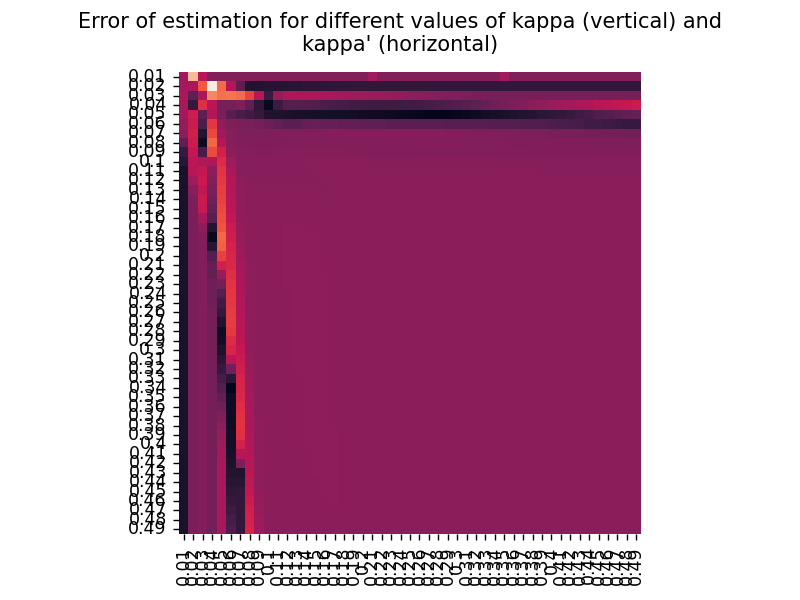

In [44]:
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]

vmin = all_components_results_molar.min().min()
vmax = all_components_results_molar.max().max()

sns.heatmap(all_components_results_molar.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

#### Visible proportions

In [45]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [46]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [47]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


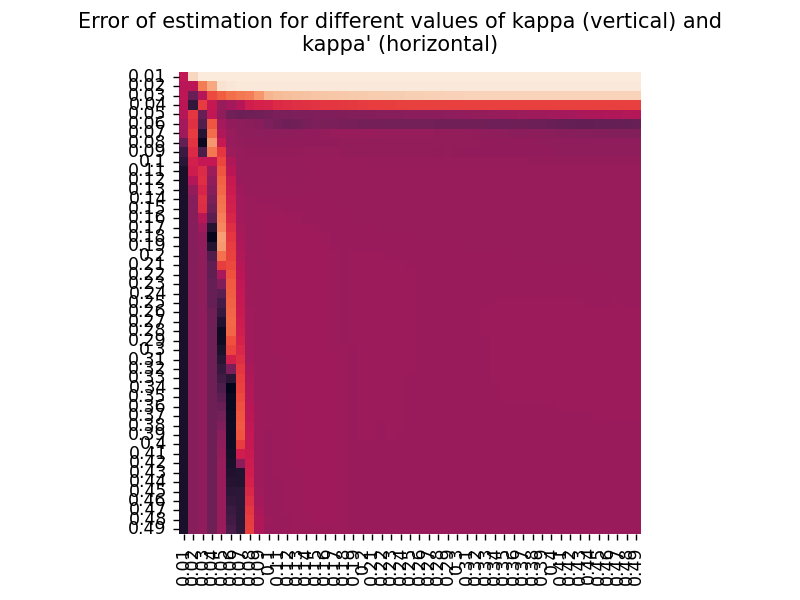

In [48]:
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]

vmin = all_components_results_vis.min().min()
vmax = all_components_results_vis.max().max()

sns.heatmap(all_components_results_vis.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

#### Both

In [49]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [50]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [51]:
all_components_results_both.min().min()

0.012521037797094348

In [52]:
all_components_results_both[0.060000000000000005][0.34]

0.012521037797094348

### Estimation with best kappa

In [53]:
estimation = estimate_proportions(mix, [comp0, comp1], 
                                   MTD=0.34, MTD_th=0.06, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 19.67it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(3.5000299999999998, 11.99995, 0), (3.5000299999999998, 11.99995, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 23301.69it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(3.16003, 12.33995)]


Splitting the experimental spectrum into chunks: 139577it [00:00, 1514405.74it/s]


Ion currents in chunks: [0.9999999999999973]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 558307 rows, 139580 columns and 1349168 nonzeros
Model fingerprint: 0x753e9fef
Coefficient statistics:
  Matrix range     [2e-12, 1e+00]
  Objective range  [2e-12, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [2e-05, 3e-01]
Presolve removed 6159 rows and 0 columns (presolve time = 5s) ...
Presolve removed 10492 rows and 0 columns (presolve time = 10s) ...
Presolve removed 14518 rows and 0 columns (presolve time = 15s) ...
Presolve removed 24968 rows and 0 columns (presolve time = 20s) ...
Presolve removed 28063 rows and 0 columns (presolve time = 25s) ...
Presolve removed 32208 rows and 0 columns (presolve time = 30s) ...
Preso

   41124   -2.8246331e-01   1.451043e+00   0.000000e+00    300s

Solved with barrier
Extra simplex iterations after uncrush: 86
   41995   -2.9875359e+21   1.344105e+33   2.081665e-03    305s
   43251   -2.8246337e-01   0.000000e+00   0.000000e+00    310s
Extra simplex iterations from dual to original model: 526
   43904   -2.8246329e-01   0.000000e+00   0.000000e+00    313s

Solved in 43904 iterations and 312.68 seconds (1173.95 work units)
Optimal objective -2.824632945e-01
Gurobi status= 2


Deconvolving chunks: 100%|███████████████████████| 1/1 [05:39<00:00, 339.34s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.991632018282
Noise proportion in experimental spectrum: 0.008367981725999998
Total explanation: 1.000000000008
Noise proportion in combination of theoretical spectra: 0.773785318536


In [54]:
estimation['proportion_of_noise_in_theoretical']

0.7737853185359979

In [55]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.2809742568409993, 0.7106577614409981]

In [56]:
1-sum(estimated_visible_proportions)

0.00836798171800257

In [57]:
real_visible_proportions

[0.2815423226100844, 0.7184576773899155]

In [58]:
estimated_molar_proportions = [prop/prot for prop, prot in zip(estimated_visible_proportions, protons)]
estimated_molar_proportions = [mp/sum(estimated_molar_proportions) for mp in estimated_molar_proportions]
estimated_molar_proportions

[0.3722765280395459, 0.6277234719604541]

In [59]:
molar_proportions

[0.3702, 0.6298]

### Visualisation of our estimation

In [83]:
p = estimated_visible_proportions

In [84]:
p = np.array(p).reshape(len(p),1)

In [85]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [86]:
components_ints = [comp_int.reshape(-1,1) for comp_int in components_ints]

In [87]:
X = np.concatenate(components_ints, axis=1)

In [88]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


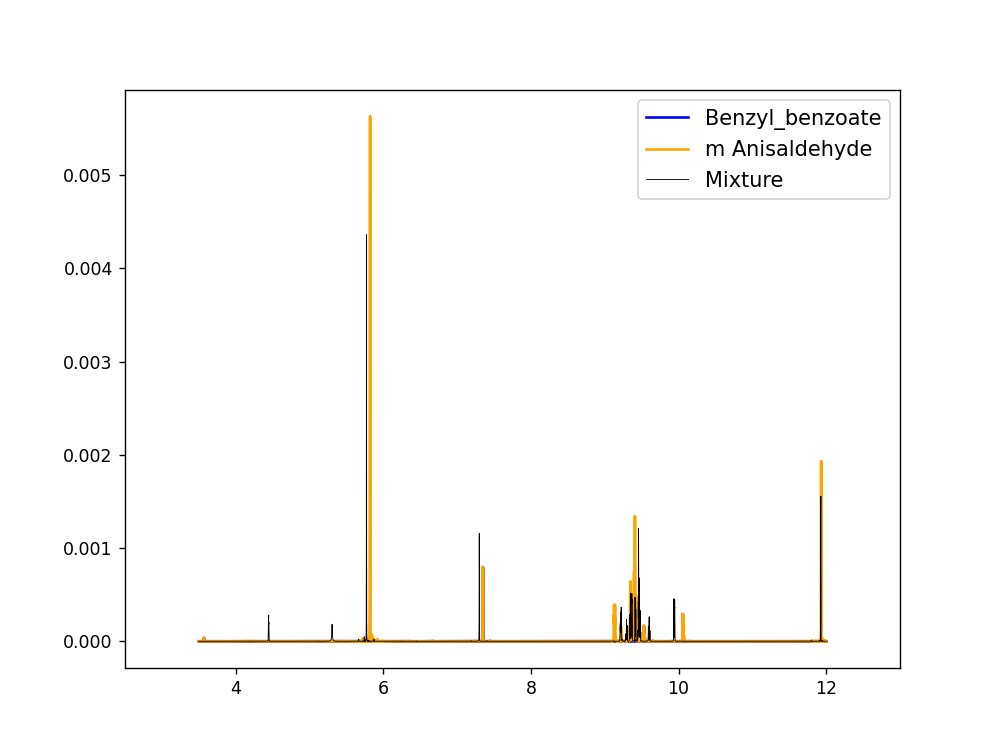

In [90]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
ax.set_xlim(2.5, 13)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12})